Toy example을 제외하고, 코드 구현, 결과를 통합해서 visualization하기 위한 script

다루고 있는 것으로는

# Code Implementation
- HVP
- IHVP-CG
- IHVP-NCG
- IHVP-SE

# Experimental Result

- TOP-k examples sorted by IF measure
- t-sne result
- interpretation of result
- TOP-k examples sorted by IF measure on specific class
- relabeling using IF measure


# Code Implementation

## HVP

Remark)

tensorflow에서는 gradient가 operator로 존재하며 이를 이용하면 hessian vector product를 automatic differentiation으로 구현할 수 있음. 그 결과 추가적인 error 없이 정확한 값을 얻을 수 있음.

반면 cntk에서는 gradient output이 값으로만 나오게 됨. 때문에 numerical differentiation을 이용해서 구현함. 그 결과 error가 조금 발생하게 됨.

In [1]:
import cntk as C
from cntk.device import try_set_default_device, gpu
try_set_default_device(gpu(0))

import numpy as np
import time
import os

from torch.utils.data import DataLoader

In [2]:
# Hessian Vector Product

def grad_inner_product(grad1, grad2):
    # inner product for dictionary-format gradients (output scalar value)
    
    val = 0
    
    assert(len(grad1)==len(grad2))
    
    for ks in grad1.keys():
        val += np.sum(np.multiply(grad1[ks],grad2[ks]))
        
    return val

def weight_update(w, v, r):
    # w: weights of neural network (tuple)
    # v: value for delta w (dictionary, e.g., gradient value)
    # r: hyperparameter for a gradient (scalar)

    for p in w:
        p.value += r * v[p]

def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-2
    
    assert type(x)==dict, "Input of HVP is wrong. 'x' should be dictionary(feed dict format)"
    assert type(v)==dict, "Input of HVP is wrong. 'v' should be dictionary(weight:value format)"

    w = v.keys()
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=w)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=w)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp


## IHVP

논문에서 나온 conjugate gradient와 stochastic estimation 두 방법을 모두 구현함.

Remark)

원작자 코드에서는 conjugate gradient를 구현할 때 scipy의 ncg (Newton's conjugate gradient)를 사용해서 구현함. 하지만 ncg의 경우 update를 담당하는 outer loop 안에 update 수치를 찾기 위한 작은 inner loop를 하나 더 돌게 되는데, 적절한 해를 찾지 못할 경우 이 inner loop를 벗어나지 못할 가능성이 있음.
- 과거 버전에서는 while loop을 사용해서 진행되어 평생 벗어나지 못할 가능성이 있음.
- 최신 버전에서는 for loop을 사용해서 진행되어 cg_maxiter를 넘기면 벗어날 가능성이 있으나 이 값은 내부에서만 존재하는 hyperparameter라서 바꿔줄 수 없음. 내부에서 지정된 값은 20 * len(x0)인데, 우리의 경우 len(x0)가 80000이 넘어가기 때문에 사실상 며칠을 돌려도 끝나지 않음. (몇 십분 돌렸을 때 겨우 400번 정도 돌았음.)

때문에 scipy의 cg를 사용해서 구현함. 이 경우 maxiter를 이용하면 수렴하지 않더라도 학습을 중간에 끝낼 수 있음.

In [3]:
# Newton-Conjugate Gradient

from scipy.optimize import fmin_ncg

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}
    fmt_idx = [np.prod(val) for val in fmt.values()]
    #lambda ls, idx: [ls[sum(idx[:i]):sum(idx[:i+1])] for i in range(len(idx))]
    vec_split = [vec[sum(fmt_idx[:i]):sum(fmt_idx[:i+1])] for i in range(len(fmt_idx))]
    dic = {key: vec_split[i].reshape(shape) for (i,(key,shape)) in enumerate(fmt.items())}

    return dic

def get_inverse_hvp_ncg(model, y, v, data_set, **kwargs):
    # return x, which is the solution of QP, whose value is H^-1 v
    # kwargs: hyperparameters for conjugate gradient
    batch_size = kwargs.pop('batch_size', 50)
    damping = kwargs.pop('damping', 0.0)
    avextol = kwargs.pop('avextol', 1e-8)
    maxiter = kwargs.pop('maxiter', 1e1)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    t0 = time.time()
    get_inverse_hvp_ncg.cnt = 0

    def HVP_minibatch_val(y, v):
        # Calculate Hessian vector product w.r.t whole dataset
        # y: scalar function output of the neural network (e.g. model.loss)
        # v: vector to be producted by inverse hessian (i.e.H^-1 v) (numeric dictionary, e.g. v_test)
        
        ## model: neural network model (e.g. model)
        ## dataloader: training set dataloader
        ## damping: damp term to make hessian convex

        hvp_batch = {ks: [] for ks in v.keys()}

        for img, lb in dataloader:
            img = img.numpy(); lb = lb.numpy()
            x_feed = {model.X: img, model.y:lb}
            hvp = HVP(y,x_feed,v)
            # add hvp value
            [hvp_batch[ks].append(hvp[ks]/img.shape[0]) for ks in hvp.keys()]

        hvp_mean = {ks: np.mean(hvp_batch[ks], axis=0) + damping*v[ks] for ks in hvp_batch.keys()}

        return hvp_mean

    def get_fmin_loss(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)

        return 0.5 * grad_inner_product(hvp_val, x_dic) - grad_inner_product(v, x_dic)

    def get_fmin_grad(x):
        # x: 1D vector
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)

        return hvp_flat - v_flat
    
    def get_fmin_hvp(x, p):
        p_dic = vec2dic(p, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, p_dic)
        hvp_flat = dic2vec(hvp_val)

        return hvp_flat

    def ncg_callback(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        print('iteration: {}'.format(get_inverse_hvp_ncg.cnt), ', ', time.time()-t0, '(sec) elapsed')
        print('vector element-wise square: ', grad_inner_product(x_dic, x_dic))
        get_inverse_hvp_ncg.cnt += 1
        
        return 0
    
    fmin_loss_fn = get_fmin_loss
    fmin_grad_fn = get_fmin_grad
    fmin_hvp_fn = get_fmin_hvp
    
    fmin_results = fmin_ncg(\
            f = fmin_loss_fn, x0 = dic2vec(v), fprime = fmin_grad_fn,\
            fhess_p = fmin_hvp_fn, avextol = avextol, maxiter = maxiter, callback=ncg_callback)
    
    return vec2dic(fmin_results, {key: val.shape for (key, val) in v.items()})

In [4]:
# Conjugate Gradient

from scipy.optimize import fmin_cg

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}
    fmt_idx = [np.prod(val) for val in fmt.values()]
    #lambda ls, idx: [ls[sum(idx[:i]):sum(idx[:i+1])] for i in range(len(idx))]
    vec_split = [vec[sum(fmt_idx[:i]):sum(fmt_idx[:i+1])] for i in range(len(fmt_idx))]
    dic = {key: vec_split[i].reshape(shape) for (i,(key,shape)) in enumerate(fmt.items())}

    return dic

def get_inverse_hvp_cg(model, y, v, data_set, **kwargs):
    # return x, which is the solution of QP, whose value is H^-1 v
    # kwargs: hyperparameters for conjugate gradient
    batch_size = kwargs.pop('batch_size', 50)
    damping = kwargs.pop('damping', 0.0)
    maxiter = kwargs.pop('maxiter', 5e1)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    t0 = time.time()
    get_inverse_hvp_cg.cnt = 0

    def HVP_minibatch_val(y, v):
        # Calculate Hessian vector product w.r.t whole dataset
        # y: scalar function output of the neural network (e.g. model.loss)
        # v: vector to be producted by inverse hessian (i.e.H^-1 v) (numeric dictionary, e.g. v_test)
        
        ## model: neural network model (e.g. model)
        ## dataloader: training set dataloader
        ## damping: damp term to make hessian convex
        
        num_data = data_set.__len__()

        hvp_batch = {key: np.zeros_like(value) for key,value in v.items()}

        for img, lb in dataloader:
            img = img.numpy(); lb = lb.numpy()
            x_feed = {model.X: img, model.y:lb}
            hvp = HVP(y,x_feed,v)
            # add hvp value
            for ks in hvp.keys():
                hvp_batch[ks] += hvp[ks]/num_data
                
        return hvp_batch

    def fmin_loss_fn(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)

        return 0.5 * grad_inner_product(hvp_val, x_dic) - grad_inner_product(v, x_dic)

    def fmin_grad_fn(x):
        # x: 1D vector
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)

        return hvp_flat - v_flat
    
    def cg_callback(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        print('iteration: {}'.format(get_inverse_hvp_cg.cnt), ', ', time.time()-t0, '(sec) elapsed')
        print('vector element-wise square: ', grad_inner_product(x_dic, x_dic))
        get_inverse_hvp_cg.cnt += 1
        
        return 0
    
    fmin_results = fmin_cg(f=fmin_loss_fn, x0=dic2vec(v), fprime=fmin_grad_fn, callback=cg_callback, maxiter=maxiter)
    
    return vec2dic(fmin_results, {key: val.shape for (key, val) in v.items()})

In [5]:
# Stochastic Estimation

def get_inverse_hvp_se(model, y, v, data_set, **kwargs):
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    # kwargs: hyperparameters for stochastic estimation
    
    # hyperparameters
    recursion_depth = kwargs.pop('recursion_depth', 50) # epoch
    scale = kwargs.pop('scale', 1e1) # similar to learning rate
    damping = kwargs.pop('damping', 0.0) # paper reference: 0.01
    batch_size = kwargs.pop('batch_size', 1)
    num_samples = kwargs.pop('num_samples', 1) # the number of samples(:stochatic estimation of IF) to be averaged
    tolerance = kwargs.pop('tolerance', 1e-2) # the difference btw l2 norms of current and previous vector used for early stopping
    verbose = kwargs.pop('verbose', False)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = v.keys()
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        prev_norm = 0
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping/scale)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
            
            if verbose:
                print('#w: \n', list(map(lambda x: x.value, params)), '\n#hvp: \n', hvp, '\n#ihvp: \n', cur_estimate)
            
            cur_norm = np.sqrt(grad_inner_product(cur_estimate,cur_estimate))
            print('Recursion depth: {}, norm: {}, time: {} \n'.format(depth, cur_norm,time.time()-t1))
            
            # divergence check
            if np.isnan(cur_norm):
                print('## The result has been diverged ##')
                break
            
            # convergence check
            if np.abs(cur_norm - prev_norm) <= tolerance:
                # change this to more precise one (<- scipy.fmin_cg also use gnorm)
                print('## Early stopped due to small change')
                break
            prev_norm = cur_norm
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    inv_hvp_val = {ks: np.mean([inv_hvps[i][ks] for i in range(num_samples)], axis=0) for ks in inv_hvps[0].keys()}
    
    return inv_hvp_val

## Toy Example for IHVP (CG, NCG, SE)

간단한 neural network를 사용해서 위 알고리즘이 잘 동작하는지 확인.

사실 network의 Hessian은 w에 대해서 locally convex함. 따라서 수렴하지 않거나 발산할 가능성이 있음. 

하지만 w를 고정시켜두고 이를 진행시켰을 때 만약 알고리즘이 locally convex한 경우에서도 잘 동작한다면, (1.25, -0.083) 값이 나와야 함.

세 알고리즘 모두 원하는 값에 잘 수렴함을 확인함.
(SE의 경우에는 scale에 따라서 발산할 때도 있음.)

이에 대한 자세한 결과는 ihvp_toy.ipynb를 참고

In [6]:
# toy example for inverse HVP (CG, NCG and SE)

class SimpleNet(object):
    def __init__(self):
        self.X = C.input_variable(shape=(1,))
        self.h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.X)
        self.pred = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.h)
        self.y = C.input_variable(shape=(1,))
        self.loss = C.squared_error(self.pred, self.y)
        
class SimpleDataset(object):
    def __init__(self, images, labels):
        self._images, self._labels = images, labels
    
    def __getitem__(self, index):
        X = self._images[index]
        y = self._labels[index]
        
        return X, y
    
    def __len__(self):
        return len(self._images)


net = SimpleNet()

params = net.pred.parameters

x_feed = {net.X:np.array([[2.]],dtype=np.float32), net.y:np.array([[1.]],dtype=np.float32)}
v_feed = {p: np.ones_like(p.value) for p in params}

print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))
params[0].value = np.asarray([[1.]])
params[1].value = np.asarray([[1./3.]])
print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))

print('hvp', HVP(net.loss, x_feed, v_feed))

#images = np.asarray([[2.],[2.]], dtype=np.float32)
#labels = np.asarray([[1.],[1.]], dtype=np.float32)
images = np.asarray([[2.]], dtype=np.float32)
labels = np.asarray([[1.]], dtype=np.float32)

train_set = SimpleDataset(images,labels)

print('######## damping = 0.0, desired solution: [1.25, -0.08] ########'); t1 = time.time()
ihvp_ncg = get_inverse_hvp_ncg(net, net.loss, v_feed, train_set, **{'damping': 0.0}); t2 = time.time()
ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_feed, train_set, **{'damping': 0.0}); t3 = time.time()
ihvp_se = get_inverse_hvp_se(net, net.loss, v_feed, train_set, **{'damping': 0.0, 'recursion_depth': 100}); t4 = time.time()
print('inverse hvp_ncg', ihvp_ncg, '\ntime: ', t2-t1)
print('inverse hvp_cg', ihvp_cg, '\ntime: ', t3-t2 )
print('inverse hvp_se', ihvp_se, '\ntime: ', t4-t3)

# print('inverse hvp_ncg', get_inverse_hvp_ncg(net, net.loss, v_feed, train_set, **{'damping': 0.1}))
# print('inverse hvp_cg', get_inverse_hvp_cg(net, net.loss, v_feed, train_set, **{'damping': 0.1}))
# print('inverse hvp_se', get_inverse_hvp_se(net, net.loss, v_feed, train_set, **{'scale':10, 'damping':0.1}))

w1 = 
 [[-0.7322467]] 
w2 = 
 [[-0.68041325]] 
loss = 
 [  1.25268134e-05]
w1 = 
 [[ 1.]] 
w2 = 
 [[ 0.33333334]] 
loss = 
 [ 0.1111111]
hvp {Parameter('W', [], [1 x 1]): array([[ 2.22302079]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 9.33413506]], dtype=float32)}
######## damping = 0.0, desired solution: [1.25, -0.08] ########
iteration: 0 ,  0.2309260368347168 (sec) elapsed
vector element-wise square:  0.725185762087
iteration: 1 ,  0.39815402030944824 (sec) elapsed
vector element-wise square:  1.56326942006
iteration: 2 ,  0.5678737163543701 (sec) elapsed
vector element-wise square:  1.56095527625
iteration: 3 ,  0.7835187911987305 (sec) elapsed
vector element-wise square:  1.56935306871
iteration: 4 ,  1.2178359031677246 (sec) elapsed
vector element-wise square:  1.56935306871
Optimization terminated successfully.
         Current function value: -0.583328
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 13
         Hessian evaluat

# Experimental Result

Noisy EMNIST dataset을 사용해서 실험을 진행함.

이 데이터를 사용하는 이유는
- EMNIST dataset은 일반적으로 사용하는 typo이기 때문에 직관적으로 해석할 수 있음.
- noisy label 문제를 다루기 때문에 이와 연결지어 해석할 수 있음.
- 과거 학습된 network를 가지고 있음. (suawiki/noisy label 참고)

In [7]:
import os, sys
sys.path.append('../refer/boot_strapping')
import json

from datasets import dataset28 as dataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.misc
from torch.utils.data import DataLoader

In [8]:
def show_image_from_data(img):
    # show image from dataset
    # img: (C,W,H) numpy array
    img_show = np.squeeze(np.transpose(img, [1,2,0]))
    imshow(img_show)
    plt.show()

In [14]:
def IF_val(net, ihvp, data_set, cosine=False):
    # Calculate influence function w.r.t ihvp and data_set
    # This should be done in sample-wise, since the gradient operation will sum up over whole feed-dicted data
    
    # ihvp: inverse hessian vector product (dictionary)
    # data_set: data_set to be feed to the gradient operation (dataset)
    IF_list = []
    
    #params = net.logits.parameters
    params = ihvp.keys()
    
    dataloader = DataLoader(data_set, 1, shuffle=False, num_workers=6)
    
    t1 = time.time()
    for img, lb in dataloader:
        img = img.numpy(); lb = lb.numpy()
        gd = net.loss.grad({net.X:img, net.y:lb}, wrt=params)
        if cosine:
            nrm = np.sqrt(grad_inner_product(gd,gd))
            gd = {k: v/nrm for k,v in gd.items()}
        IF = -grad_inner_product(ihvp, gd) / len(dataloader)
        IF_list.append(IF)
    print('IF_val takes {} sec'.format(time.time()-t1))
        
    return IF_list

def visualize_topk_samples(measure, train_set, num_sample=5, mask=None, verbose='ALL', save_path='./result'):
    # 'ALL': show DISADV / ADV / INF / NEG examples
    # 'ADV': show ADV only
    # 'DIS': show DIS only

    axis = 2 # axis=1 -> column output / axis=2 -> row output
    
    if mask == None:
        argsort = np.argsort(measure)
    else:
        assert(len(mask) == len(measure))
        argsort = list(filter(lambda idx: mask[idx], np.argsort(measure)))
    
    topk = argsort[-1:-num_sample-1:-1]
    botk = argsort[0:num_sample]
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)

    if verbose == 'DIS' or verbose == 'ALL':
        dis = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST DISADVANTAGEOUS EXAMPLES ##\n'.format(num_sample))
        for idx in topk:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            print(trainval_list[idx])
            dis.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        dis = np.squeeze(np.concatenate(dis, axis=axis))
        scipy.misc.imsave(save_path+'/disadvantageous_true_{}_noisy_{}.png'.format(true_label, noisy_label), dis)

    if verbose == 'ADV' or verbose == 'ALL':
        adv = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST ADVANTAGEOUS EXAMPLES ##\n'.format(num_sample))
        for idx in botk:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            print(trainval_list[idx])
            adv.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        adv = np.squeeze(np.concatenate(adv, axis=axis))
        scipy.misc.imsave(save_path+'/advantageous_true_{}_noisy_{}.png'.format(true_label, noisy_label), adv)

    if verbose == 'ALL':
        
        if mask == None:
            argsort_abs = np.argsort(np.abs(measure))
        else:
            assert(len(mask) == len(measure))
            argsort_abs = list(filter(lambda idx: mask[idx], np.argsort(np.abs(measure))))

        topk_abs = argsort_abs[-1:-num_sample-1:-1]
        botk_abs = argsort_abs[0:num_sample]
        
        inf = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST INFLUENTIAL EXAMPLES ##\n'.format(num_sample))
        for idx in topk_abs:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            inf.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        inf = np.squeeze(np.concatenate(inf, axis=axis))
        scipy.misc.imsave(save_path+'/influential_true_{}_noisy_{}.png'.format(true_label, noisy_label), inf)

        neg = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST NEGLIGIBLE EXAMPLES ##\n'.format(num_sample))
        for idx in botk_abs:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            neg.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        neg = np.squeeze(np.concatenate(neg, axis=axis))
        scipy.misc.imsave(save_path+'/negligible_true_{}_noisy_{}.png'.format(true_label, noisy_label), neg)
        
    return 0

In [10]:
# emnist dataset
root_dir = '/Data/emnist/balanced/original'

# sample size
# trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1', sample_size=100)
trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1')
test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=500)

with open('/Data/emnist/balanced/original/annotation/annotation1_wp_0.3.json','r') as fid:
    noisy_anno_dict = json.load(fid)

#train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict)
#train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict)
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# emnist dataset: SANITY CHECK
print(len(test_set), type(test_set))
print(len(test_list))

500 <class 'datasets.dataset28.LazyDataset'>
500


In [11]:
test_set.__len__()

500

In [12]:
# emnist network
from models.nn import VGG as ConvNet

hp_d = dict() # hyperparameters for a network
net = ConvNet(test_set.__getitem__(0)[0].shape, len(anno_dict['classes']), **hp_d)
net.logits.restore('/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn')

# emnist network: SANITY CHECK
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = net.predict(test_set, **hp_d)
total_time = time.time() - start_time

print('Test error rate: {}'.format(test_score))
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))
print('Confusion matrix: \n{}'.format(confusion_matrix))

conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
Test error rate: 0.1316918545081967
Total tack time(sec): 4.931594133377075
Tact time per image(sec): 0.00986318826675415
Confusion matrix: 
[[10  0  0 ...,  0  0  0]
 [ 0  9  0 ...,  0  0  0]
 [ 0  0  7 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  4  0  0]
 [ 0  0  0 ...,  0 12  0]
 [ 0  0  0 ...,  0  0  8]]


## Inverse Hessian Vector Product w.r.t. Freezed Network

Gradient, Hessian을 구할 때 weight의 범위를 한정지어서 inversed HVP를 구함.

앞단 network를 freeze 시키는 데에는 두 가지 이유가 있음.

1. Convexity
    - Network가 깊어지면 깊어질 수록 convexity가 망가질 가능성이 있음.
    - 때문에 CG, NCG, SE 방법론을 사용할 때 값이 발산하는 문제가 발생함.
2. Computational Complexity
    - Weight가 많을 수록 계산이 복잡해지고, vanishing gradient 등의 문제로 인해 precision loss가 발생할 가능성이 늘어남.
    
이를 해결하기 위해 가장 간단하고 직관적인 방법인 network freezing을 사용함.
이는 feature extraction을 담당하는 앞부분 weight를 전부 고정하고, 
최종 layer의 weight만을 사용하여 convexity가 보장된 logistic regression문제로 바꾸는 것.

In [ ]:
# DO THIS FOR SEVERAL EXAMPLES

# vec v.s. freeze v.s. se

# restore trainval_list, test_list
file_dir = './compare/result_net_nn_if_nn/train_e_99502'

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# FIXME
# network trained with noisy dataset, influence value with noisy dataset
train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset
save_dir = './compare/result_net_ns_if_ns' 
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn'

# # network trained with non-noisy dataset, influence value with non-noisy dataset
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset
# save_dir = './compare/result_net_nn_if_nn'
# restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network

for idx_test in range(0, 30):
    # Set a single test image

    # # Re-sample a test instance
    # test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=100)
    # test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)
    
    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = test_list[idx_test]
    img_test, lb_test = test_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

    # Calculate influence functions

#     # CG-FREEZE (1885 sec)
#     t1 = time.time()
#     ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':50})
#     IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
#     print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))
#     np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)
#     #IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')
#     visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path+'/cg-frz')
    
#     # VECTOR-FREEZE (175 sec)
#     t1 = time.time()
#     IF_v_logreg = IF_val(net, v_logreg, train_set)
#     print('V_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_logreg),min(IF_v_logreg)]))
#     np.save(save_path+'/if_v_logreg.npy', IF_v_logreg)
#     #IF_v_logreg = np.load(save_path+'/if_v_logreg.npy')
#     visualize_topk_samples(IF_v_logreg, train_set, num_sample=5, save_path=save_path+'/vec-frz')

#     # Vector-FULL (1688 sec)
#     t1 = time.time()
#     IF_v = IF_val(net, v_test, train_set)
#     print('V takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v),min(IF_v)]))
#     np.save(save_path+'/if_v.npy', IF_v)
#     #IF_v = np.load(save_path+'/if_v.npy')
#     visualize_topk_samples(IF_v, train_set, num_sample=5, save_path=save_path+'/v')
    
#     # VECTOR-FREEZE-cosine-similarity (178 sec)
#     t1 = time.time()
#     IF_v_cos = IF_val(net, v_logreg, train_set, cosine=True)
#     print('V_cos takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_cos),min(IF_v_cos)]))
#     np.save(save_path+'/if_v_cos.npy', IF_v_cos)
#     #IF_v_cos = np.load(save_path+'/if_v_cos.npy')
#     visualize_topk_samples(IF_v_cos, train_set, num_sample=5, save_path=save_path+'/vec-cos')

#     # CG-FULL (1epoch, more than 3 hours, did it stuck at line search as it happened in ncg?)
#     t1 = time.time()
#     ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_test, train_set,**{'damping':0.1, 'maxiter':100})
#     IF_cg = IF_val(net, ihvp_cg, train_set)
#     print('CG takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg),min(IF_cg)]))
#     np.save(save_path+'/if_cg.npy', IF_cg)
#     visualize_topk_samples(IF_cg, train_set, num_sample=5, save_path=save_path+'/cg')
    
#     # SE-FULL (? sec: diverge)
#     t1 = time.time()
#     ihvp_se = get_inverse_hvp_se(net, net.loss, v_test, train_set,**{'scale':1e5, 'damping':0.1, 'batch_size':50, 'recursion_depth':100})
#     IF_se = IF_val(net, ihvp_se, train_set)
#     print('SE takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se),min(IF_se)]))
#     np.save(save_path+'/if_se.npy', IF_se)
#     visualize_topk_samples(IF_se, train_set, num_sample=5, save_path=save_path+'/se')
    
    # SE-FREEZE (1065 sec)
    t1 = time.time()
    ihvp_se_logreg = get_inverse_hvp_se(net, net.loss, v_logreg, train_set,**{'scale':1e3, 'damping':0.1, 'batch_size':50, 'tolerance':0, 'recursion_depth':65})
    IF_se_logreg = IF_val(net, ihvp_se_logreg, train_set)
    print('SE_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se_logreg),min(IF_se_logreg)]))
    np.save(save_path+'/if_se_logreg.npy', IF_se_logreg)
    #IF_se_logreg = np.load(save_path+'/if_se_logreg.npy')
    visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=save_path+'/se-frz')
    

figures for ppts
=====================


In [ ]:
def find_idx(filename, filename_list):
    i = 0
    for fn in filename_list:
        if fn == filename:
            break
        i += 1
        
    return i

filename = 'train_e_99502.png'
fidx = find_idx(filename, test_list)

In [ ]:
fig_sample = []
for i in range(20):
    img, lb = train_set[i]
    fig_sample.append(img)
#print(fig_sample[1].shape)
fig_sample = np.concatenate(fig_sample, axis=1)
show_image_from_data(fig_sample)
scipy.misc.imsave('./images/image_samples_total.png', np.squeeze(fig_sample))

In [ ]:
# visualize image samples (MASK)

# FIXME #
num_sample = 10
filename = 'train_e_99502.png'
file_dir = './compare/result_net_nn_if_nn/train_e_99502'

sample_idx = find_idx(filename, test_list)
img_test, lb_test = test_set[0]
show_image_from_data(img_test)
mask = [anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
mask_inv = [not e for e in mask]
#len(mask_e)

fig_sample = np.empty((1,28,0))

# data with same label w.r.t test sample (set A)
cnt = 0
for i in range(len(trainval_list)):
    if mask[i]:
        img, lb = train_set[i]
        fig_sample = np.concatenate((fig_sample, img), axis=2)
        cnt += 1
        if cnt == num_sample:
            break

print(fig_sample.shape)
scipy.misc.imsave('./images/image_samples.png', np.squeeze(fig_sample))
show_image_from_data(fig_sample)

# data with the others (set B)
fig_sample = np.empty((1,28,0))
cnt = 0
for i in range(len(trainval_list)):
    if mask_inv[i]:
        img, lb = train_set[i]
        fig_sample = np.concatenate((fig_sample, img), axis=2)
        cnt += 1
        if cnt == num_sample:
            break

print(fig_sample.shape)
scipy.misc.imsave('./images/image_samples2.png', np.squeeze(fig_sample))
show_image_from_data(fig_sample)

# data somewhat similar to each other (A n B)
IF_cg_logreg = np.load(file_dir+'/if_cg_logreg.npy')
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path='./images/all') # show all
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, mask=mask, save_path='./images/masked') # masked
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, mask=mask_inv, save_path='./images/masked_inv') # masked

# idx_sort_mask = list(filter(lambda idx: mask[idx], np.argsort(IF_cg_logreg)))

# for idx in idx_sort_mask:
#     show_image_from_data(train_set[idx][0])
#     print(IF_cg_logreg[idx])

    #show top bot inf neg
#     break
# for fige in mask_e[0:5]:
#     idx = find_idx(mask_e, trainval_list)
#     print(fige,idx)
#     show_image_from_data(train_set[idx])

In [ ]:
# axis change

# import glob

# file_dir = './compare/result_net_nn_if_nn/train_e_99502'
# restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network
# net.logits.restore(restore_dir)

# trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

# test_list = list(np.load(file_dir+'/test_list.npy'))
# test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# for dr in glob.glob('compare/result_net_nn_if_nn/*'):
#     dr_se = dr+'/if_se_logreg.npy'
#     if os.path.isfile(dr_se):
#         print(dr_se)
#         IF_se_logreg = np.load(dr_se)
#         visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=dr+'/se-frz')
        
import glob

file_dir = './compare/result_net_ns_if_ns/train_e_99502'
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn' # noisy network
net.logits.restore(restore_dir)

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

for dr in glob.glob('compare/result_net_ns_if_ns/*'):
    dr_se = dr+'/if_se_logreg.npy'
    if os.path.isfile(dr_se):
        print(dr_se)
        IF_se_logreg = np.load(dr_se)
        visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=dr+'/se-frz')

num_of_samples 22559
47 ['train_N_43201.png', 'train_R_58280.png', 'train_M_68622.png', 'train_O_3897.png', 'train_Q_54865.png', 'train_G_98150.png', 'train_3_20482.png', 'train_8_100781.png', 'train_J_9128.png', 'train_n_50633.png', 'train_e_106291.png', 'train_A_29714.png', 'train_2_87560.png', 'train_d_26555.png', 'train_f_952.png', 'train_g_11056.png', 'train_h_6101.png', 'train_6_75714.png', 'train_W_28889.png', 'train_q_67554.png', 'train_a_48806.png', 'train_I_104736.png', 'train_Z_54754.png', 'train_F_41402.png', 'train_5_63087.png', 'train_E_63405.png', 'train_9_71069.png', 'train_4_33293.png', 'train_S_55325.png', 'train_V_18529.png', 'train_P_104114.png', 'train_U_14826.png', 'train_Y_80298.png', 'train_H_100708.png', 'train_D_109455.png', 'train_b_97894.png', 'train_7_74705.png', 'train_L_66551.png', 'train_1_31620.png', 'train_t_67915.png', 'train_X_17045.png', 'train_B_69574.png', 'train_r_100253.png', 'train_C_29303.png', 'train_K_97272.png', 'train_0_104721.png', 'train

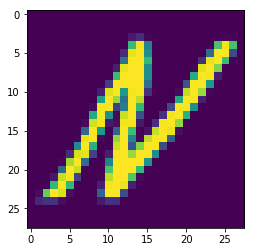

testfile name:  train_N_43201.png
ground truth label:  N
network prediction:  N
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:64: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Recursion depth: 0, norm: 26359.435454880288, time: 377.89260387420654 

Recursion depth: 1, norm: 48349.00571883562, time: 245.45038723945618 

Recursion depth: 2, norm: 66705.88996482994, time: 174.69453978538513 

Recursion depth: 3, norm: 82030.74638816838, time: 51.53217434883118 

Recursion depth: 4, norm: 94824.41800506871, time: 15.140137195587158 

Recursion depth: 5, norm: 105504.90559210979, time: 15.03752326965332 

Recursion depth: 6, norm: 114421.27085467981, time: 14.758824586868286 

Recursion depth: 7, norm: 121864.86004587212, time: 15.293226480484009 

Recursion depth: 8, norm: 128078.89467043351, time: 14.877825260162354 

Recursion depth: 9, norm: 133266.65597965606, time: 15.003761768341064 

Recursion depth: 10, norm: 137597.54625719166, time: 14.958439350128174 

Recursion depth: 11, norm: 141213.00306983065, time: 14.929710626602173 

Recursion depth: 12, norm: 144231.44293807782, time: 15.24335765838623 

Recursion depth: 13, norm: 146751.39816710434, time: 15

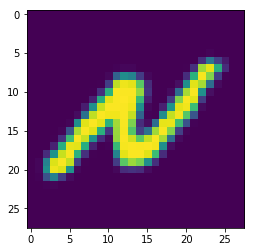

training set name:  train_N_51999.png
training set label:  4
IF measure:  0.0103664297795
train_N_51999.png


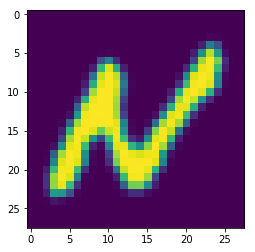

training set name:  train_N_37271.png
training set label:  W
IF measure:  0.0100535632237
train_N_37271.png


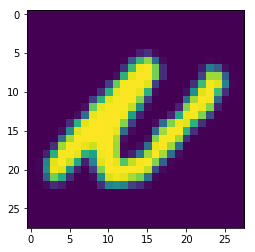

training set name:  train_N_32237.png
training set label:  q
IF measure:  0.00983711986783
train_N_32237.png


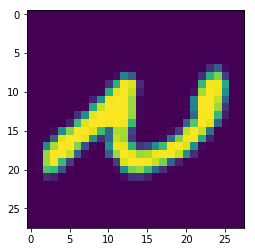

training set name:  train_N_68771.png
training set label:  W
IF measure:  0.00973194389479
train_N_68771.png


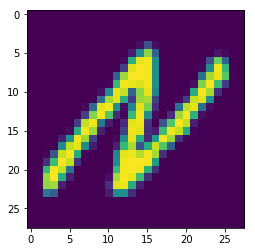

training set name:  train_N_98687.png
training set label:  h
IF measure:  0.00965049178571
train_N_98687.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:62: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


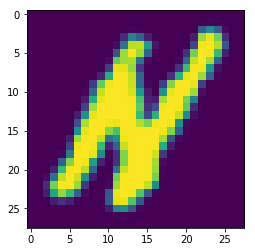

training set name:  train_N_61475.png
training set label:  N
IF measure:  -0.0126056729373
train_N_61475.png


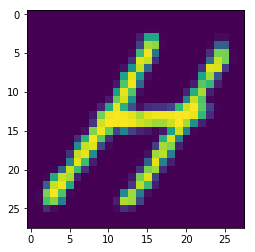

training set name:  train_H_6092.png
training set label:  N
IF measure:  -0.0116226152431
train_H_6092.png


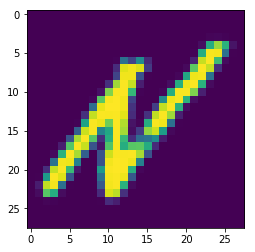

training set name:  train_N_109076.png
training set label:  N
IF measure:  -0.0101253102012
train_N_109076.png


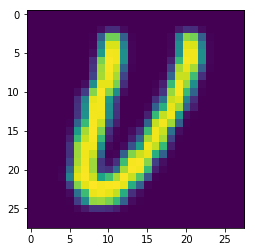

training set name:  train_V_102441.png
training set label:  N
IF measure:  -0.00983977792322
train_V_102441.png


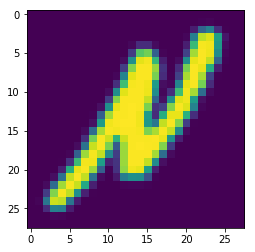

training set name:  train_N_61472.png
training set label:  N
IF measure:  -0.00973273514116
train_N_61472.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


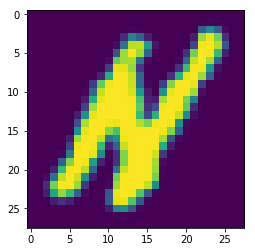

training set name:  train_N_61475.png
training set label:  N
IF measure:  -0.0126056729373


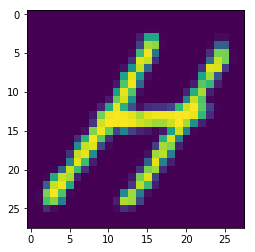

training set name:  train_H_6092.png
training set label:  N
IF measure:  -0.0116226152431


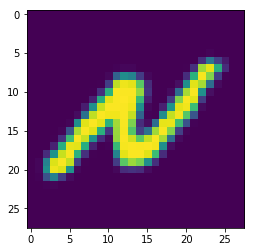

training set name:  train_N_51999.png
training set label:  4
IF measure:  0.0103664297795


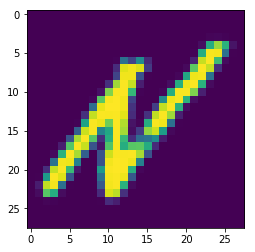

training set name:  train_N_109076.png
training set label:  N
IF measure:  -0.0101253102012


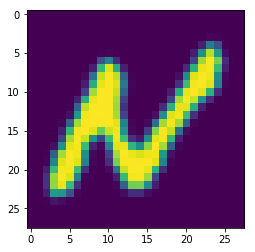

training set name:  train_N_37271.png
training set label:  W
IF measure:  0.0100535632237

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:105: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


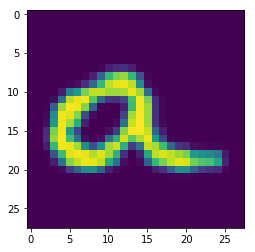

training set name:  train_a_45786.png
training set label:  a
IF measure:  -1.50305287523e-11


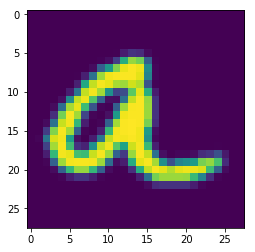

training set name:  train_a_63335.png
training set label:  a
IF measure:  7.22341978194e-11


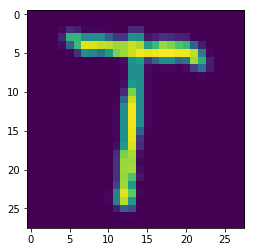

training set name:  train_T_53825.png
training set label:  T
IF measure:  -2.16850628234e-10


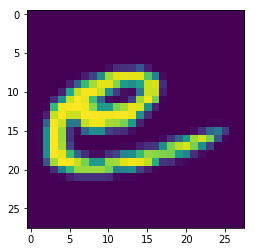

training set name:  train_e_94937.png
training set label:  e
IF measure:  4.62993436183e-10


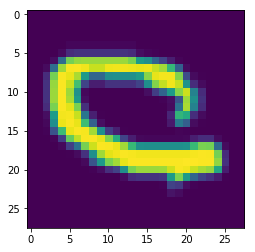

training set name:  train_C_65872.png
training set label:  C
IF measure:  -4.9144255946e-10


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:120: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


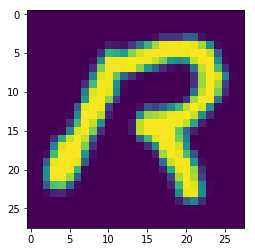

testfile name:  train_R_58280.png
ground truth label:  R
network prediction:  R
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 16310.898309297683, time: 14.926907300949097 

Recursion depth: 1, norm: 29915.450163753176, time: 15.058022499084473 

Recursion depth: 2, norm: 41272.80410270182, time: 15.178298473358154 

Recursion depth: 3, norm: 50753.98602573004, time: 15.187559843063354 

Recursion depth: 4, norm: 58669.26425309934, time: 15.06542420387268 

Recursion depth: 5, norm: 65277.044249873936, time: 14.928419589996338 

Recursion depth: 6, norm: 70793.32066303995, time: 15.842162609100342 

Recursion depth: 7, norm: 75398.55149802282, time: 16.143587827682495 

Recursion depth: 8, norm: 79243.25038134163, time: 15.934990406036377 

Recursion depth: 9, norm: 82452.76024488204, time: 15.849804401397705 

Recursion depth: 10, norm: 85131.98162852784, time: 15.484628677368164 

Recursion depth: 11, norm: 87368.78815114697, time: 15.8404655456

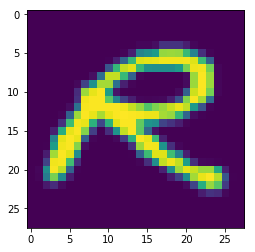

training set name:  train_R_33830.png
training set label:  g
IF measure:  0.00897908824238
train_R_33830.png


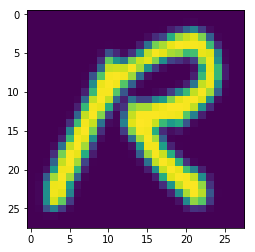

training set name:  train_R_87812.png
training set label:  G
IF measure:  0.00757699544601
train_R_87812.png


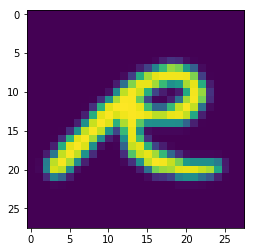

training set name:  train_R_17435.png
training set label:  B
IF measure:  0.00755915519722
train_R_17435.png


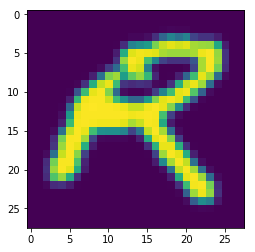

training set name:  train_R_24054.png
training set label:  d
IF measure:  0.00723153453135
train_R_24054.png


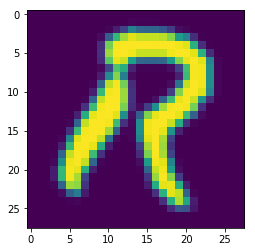

training set name:  train_R_44911.png
training set label:  L
IF measure:  0.0069930710876
train_R_44911.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



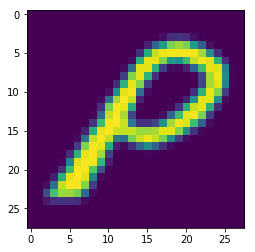

training set name:  train_P_65996.png
training set label:  R
IF measure:  -0.00589871378549
train_P_65996.png


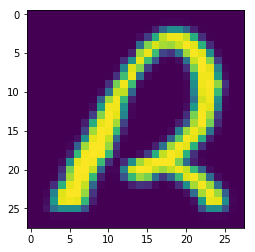

training set name:  train_R_63370.png
training set label:  R
IF measure:  -0.00567434291415
train_R_63370.png


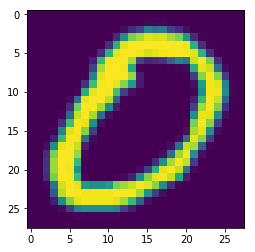

training set name:  train_0_92268.png
training set label:  R
IF measure:  -0.00563504032474
train_0_92268.png


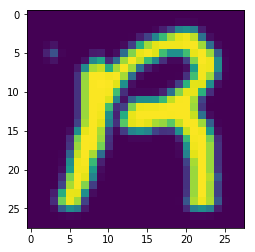

training set name:  train_R_32340.png
training set label:  R
IF measure:  -0.00562737730484
train_R_32340.png


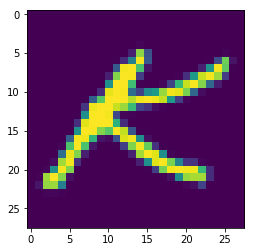

training set name:  train_K_66548.png
training set label:  R
IF measure:  -0.00559690445133
train_K_66548.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



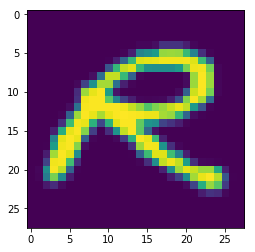

training set name:  train_R_33830.png
training set label:  g
IF measure:  0.00897908824238


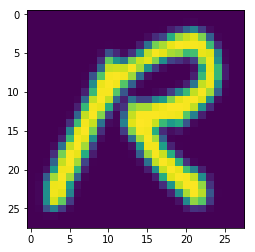

training set name:  train_R_87812.png
training set label:  G
IF measure:  0.00757699544601


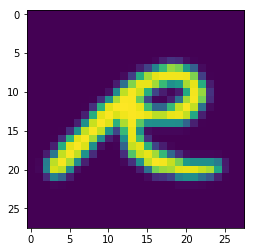

training set name:  train_R_17435.png
training set label:  B
IF measure:  0.00755915519722


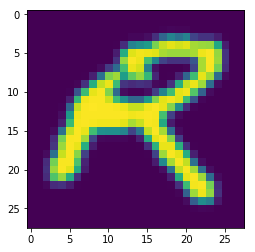

training set name:  train_R_24054.png
training set label:  d
IF measure:  0.00723153453135


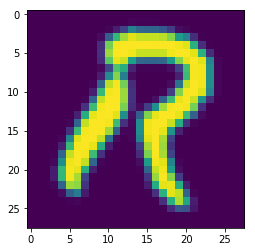

training set name:  train_R_44911.png
training set label:  L
IF measure:  0.0069930710876

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



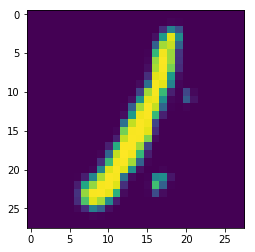

training set name:  train_1_68208.png
training set label:  1
IF measure:  1.60476147422e-10


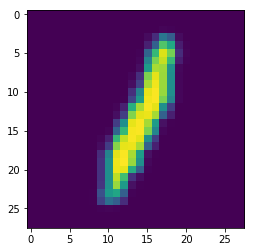

training set name:  train_I_20301.png
training set label:  I
IF measure:  2.00739026347e-10


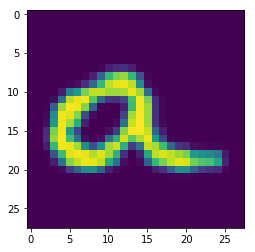

training set name:  train_a_45786.png
training set label:  a
IF measure:  2.15832163489e-10


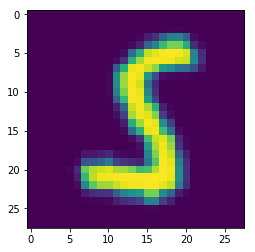

training set name:  train_S_31284.png
training set label:  S
IF measure:  5.34229729642e-10


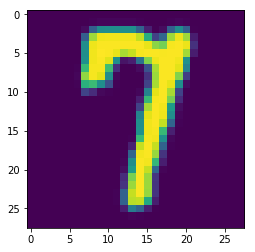

training set name:  train_7_103987.png
training set label:  7
IF measure:  6.52322496728e-10


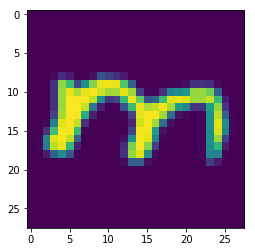

testfile name:  train_M_68622.png
ground truth label:  M
network prediction:  M
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 8685.460816430525, time: 14.954341650009155 

Recursion depth: 1, norm: 15927.151826754838, time: 15.059703350067139 

Recursion depth: 2, norm: 21972.584267104314, time: 14.784943580627441 

Recursion depth: 3, norm: 27019.358425950828, time: 14.77728009223938 

Recursion depth: 4, norm: 31232.31166996769, time: 15.182626247406006 

Recursion depth: 5, norm: 34749.43020036444, time: 14.84385371208191 

Recursion depth: 6, norm: 37685.50189396447, time: 15.027624607086182 

Recursion depth: 7, norm: 40136.777695151366, time: 14.8956778049469 

Recursion depth: 8, norm: 42183.00558578063, time: 14.98396635055542 

Recursion depth: 9, norm: 43891.51707334801, time: 15.043400049209595 

Recursion depth: 10, norm: 45317.5831493693, time: 14.980243444442749 

Recursion depth: 11, norm: 46508.230180259496, time: 14.9881367683410

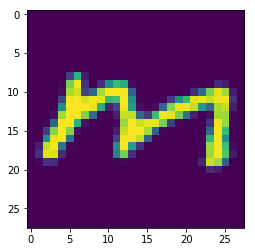

training set name:  train_M_18470.png
training set label:  7
IF measure:  0.00412922440797
train_M_18470.png


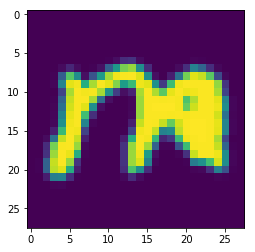

training set name:  train_M_26201.png
training set label:  t
IF measure:  0.00396577712439
train_M_26201.png


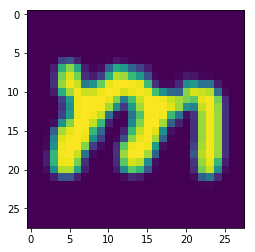

training set name:  train_M_30158.png
training set label:  O
IF measure:  0.00393061903669
train_M_30158.png


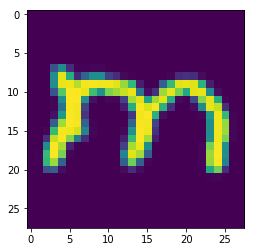

training set name:  train_M_111865.png
training set label:  B
IF measure:  0.00389842045434
train_M_111865.png


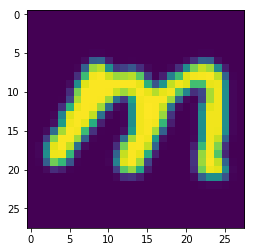

training set name:  train_M_15884.png
training set label:  6
IF measure:  0.00384771235499
train_M_15884.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



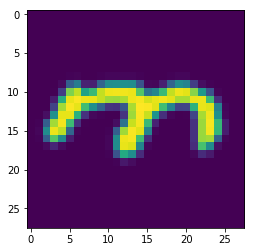

training set name:  train_M_10121.png
training set label:  M
IF measure:  -0.00279413842537
train_M_10121.png


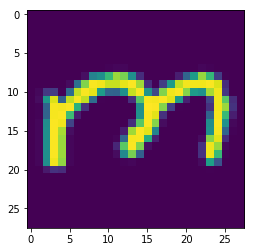

training set name:  train_M_104731.png
training set label:  M
IF measure:  -0.0026957555707
train_M_104731.png


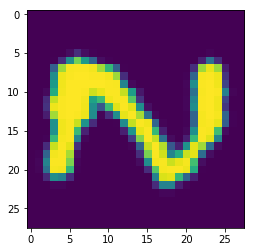

training set name:  train_N_82087.png
training set label:  M
IF measure:  -0.00259546360384
train_N_82087.png


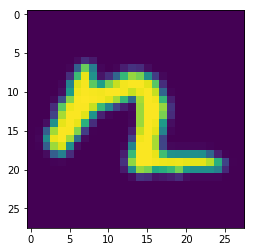

training set name:  train_n_3991.png
training set label:  M
IF measure:  -0.00249983670177
train_n_3991.png


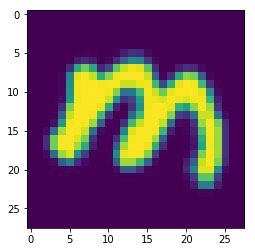

training set name:  train_M_59048.png
training set label:  M
IF measure:  -0.00239899440385
train_M_59048.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



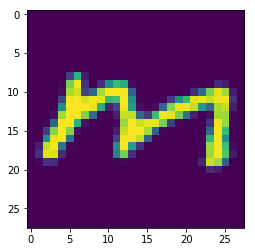

training set name:  train_M_18470.png
training set label:  7
IF measure:  0.00412922440797


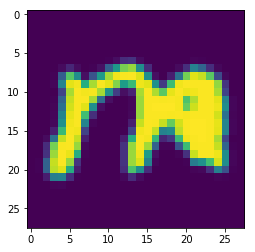

training set name:  train_M_26201.png
training set label:  t
IF measure:  0.00396577712439


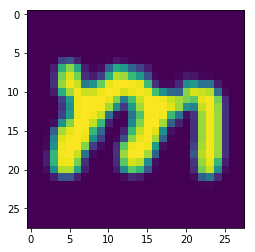

training set name:  train_M_30158.png
training set label:  O
IF measure:  0.00393061903669


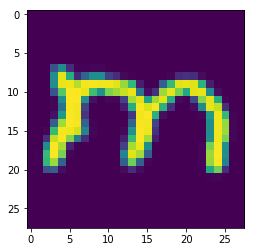

training set name:  train_M_111865.png
training set label:  B
IF measure:  0.00389842045434


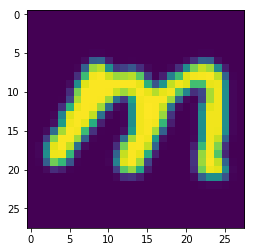

training set name:  train_M_15884.png
training set label:  6
IF measure:  0.00384771235499

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



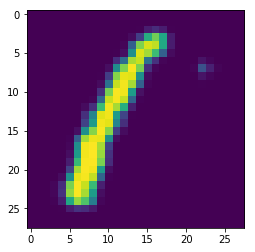

training set name:  train_1_97521.png
training set label:  1
IF measure:  -2.60334795486e-12


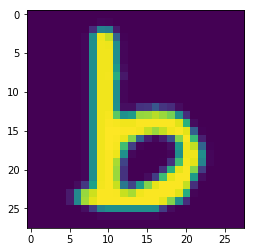

training set name:  train_b_71830.png
training set label:  b
IF measure:  -3.45156464481e-12


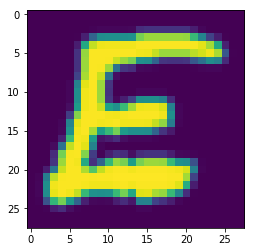

training set name:  train_E_45577.png
training set label:  E
IF measure:  -1.40009372102e-11


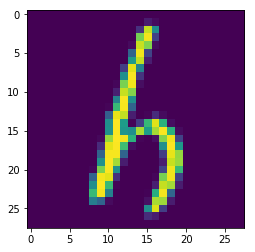

training set name:  train_h_50040.png
training set label:  h
IF measure:  -1.6659878835e-11


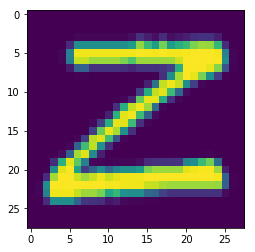

training set name:  train_Z_95752.png
training set label:  Z
IF measure:  5.9487403813e-11


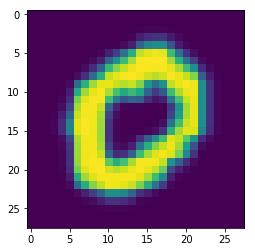

testfile name:  train_O_3897.png
ground truth label:  O
network prediction:  O
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 7101.531647622751, time: 15.045975923538208 

Recursion depth: 1, norm: 13019.244414519608, time: 15.132028818130493 

Recursion depth: 2, norm: 17959.453525580895, time: 14.930776119232178 

Recursion depth: 3, norm: 22083.62174072677, time: 14.957369804382324 

Recursion depth: 4, norm: 25526.41910599683, time: 14.931682825088501 

Recursion depth: 5, norm: 28400.883439164354, time: 14.941723346710205 

Recursion depth: 6, norm: 30800.462892219657, time: 15.15803575515747 

Recursion depth: 7, norm: 32803.708102133816, time: 15.007833480834961 

Recursion depth: 8, norm: 34475.865438738445, time: 14.965461492538452 

Recursion depth: 9, norm: 35872.07702726454, time: 14.983815670013428 

Recursion depth: 10, norm: 37037.31448485432, time: 15.02844786643982 

Recursion depth: 11, norm: 38010.32324579732, time: 15.028133630

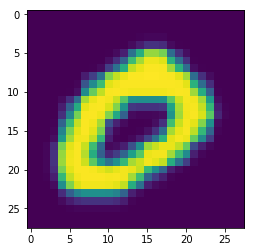

training set name:  train_0_11401.png
training set label:  0
IF measure:  0.00358469754008
train_0_11401.png


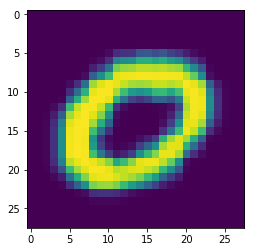

training set name:  train_0_1192.png
training set label:  0
IF measure:  0.00345008969043
train_0_1192.png


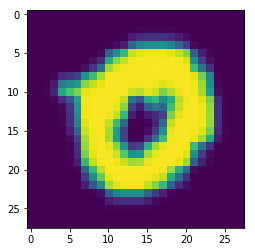

training set name:  train_0_14342.png
training set label:  0
IF measure:  0.00340572241826
train_0_14342.png


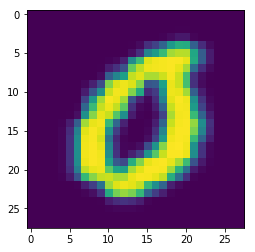

training set name:  train_O_20025.png
training set label:  4
IF measure:  0.00328596394562
train_O_20025.png


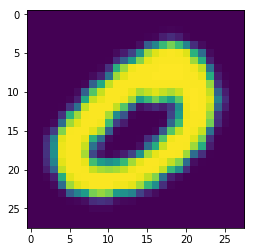

training set name:  train_0_45230.png
training set label:  0
IF measure:  0.00326940957985
train_0_45230.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



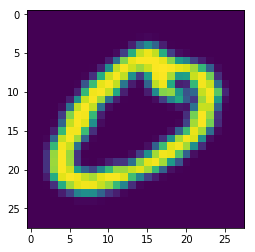

training set name:  train_O_92057.png
training set label:  O
IF measure:  -0.0035925364386
train_O_92057.png


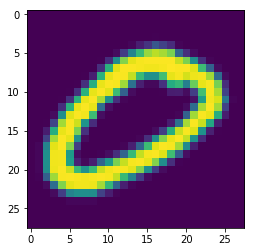

training set name:  train_O_110532.png
training set label:  O
IF measure:  -0.00353243849537
train_O_110532.png


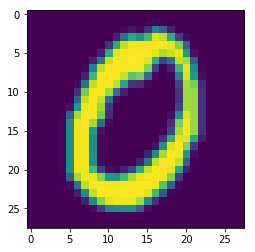

training set name:  train_O_11676.png
training set label:  O
IF measure:  -0.00348141673186
train_O_11676.png


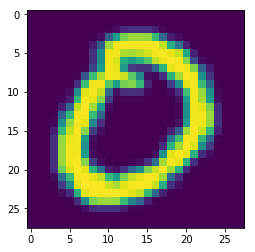

training set name:  train_O_13120.png
training set label:  O
IF measure:  -0.00342260095958
train_O_13120.png


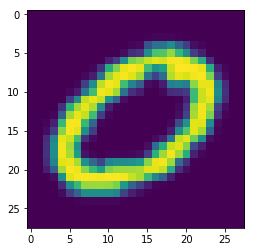

training set name:  train_O_82966.png
training set label:  O
IF measure:  -0.00330649376153
train_O_82966.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



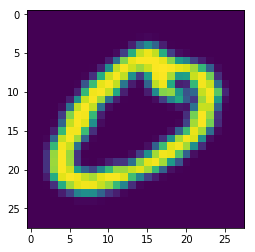

training set name:  train_O_92057.png
training set label:  O
IF measure:  -0.0035925364386


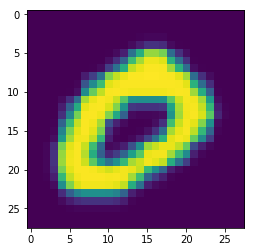

training set name:  train_0_11401.png
training set label:  0
IF measure:  0.00358469754008


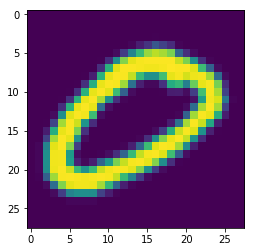

training set name:  train_O_110532.png
training set label:  O
IF measure:  -0.00353243849537


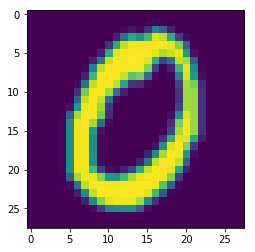

training set name:  train_O_11676.png
training set label:  O
IF measure:  -0.00348141673186


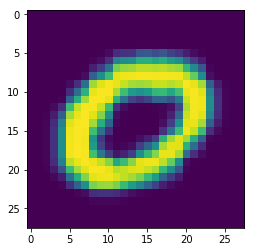

training set name:  train_0_1192.png
training set label:  0
IF measure:  0.00345008969043

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



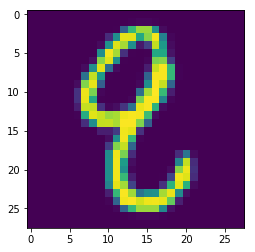

training set name:  train_q_57833.png
training set label:  q
IF measure:  -1.62128718646e-12


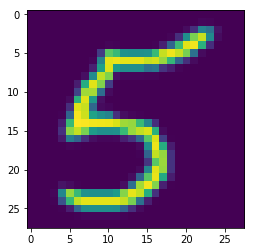

training set name:  train_5_9617.png
training set label:  5
IF measure:  3.43163316518e-11


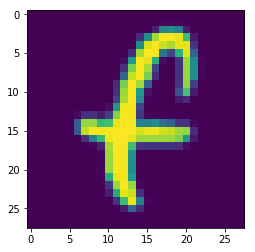

training set name:  train_f_6323.png
training set label:  f
IF measure:  4.8355446676e-11


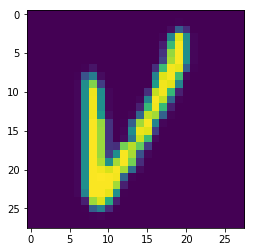

training set name:  train_V_89191.png
training set label:  V
IF measure:  -9.65298007012e-11


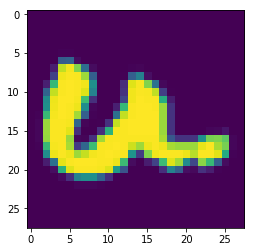

training set name:  train_U_87783.png
training set label:  U
IF measure:  1.30948853652e-10


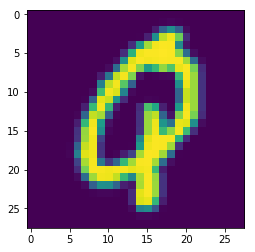

testfile name:  train_Q_54865.png
ground truth label:  Q
network prediction:  Q
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 11658.595654065715, time: 16.20114541053772 

Recursion depth: 1, norm: 21380.95113062092, time: 16.63985276222229 

Recursion depth: 2, norm: 29497.400031612957, time: 20.793765783309937 

Recursion depth: 3, norm: 36273.10186625897, time: 20.124281644821167 

Recursion depth: 4, norm: 41929.56934252962, time: 20.878028631210327 

Recursion depth: 5, norm: 46651.74474765119, time: 20.879157066345215 

Recursion depth: 6, norm: 50593.975036559445, time: 20.663994312286377 

Recursion depth: 7, norm: 53885.12419490188, time: 20.584223747253418 

Recursion depth: 8, norm: 56632.614883121896, time: 20.705830097198486 

Recursion depth: 9, norm: 58926.33948838159, time: 20.64760947227478 

Recursion depth: 10, norm: 60841.10569754629, time: 20.740817308425903 

Recursion depth: 11, norm: 62439.38387748553, time: 20.66040992736

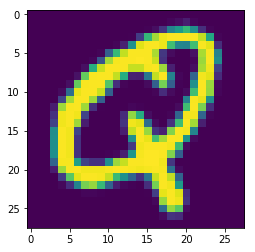

training set name:  train_Q_35174.png
training set label:  G
IF measure:  0.0054589597363
train_Q_35174.png


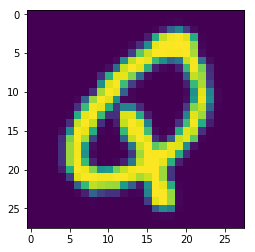

training set name:  train_Q_100225.png
training set label:  A
IF measure:  0.00528989541774
train_Q_100225.png


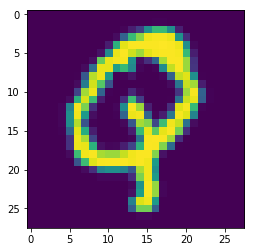

training set name:  train_Q_85221.png
training set label:  f
IF measure:  0.00525751688802
train_Q_85221.png


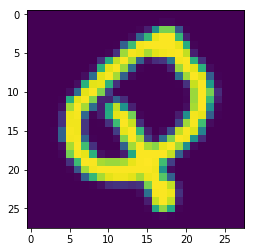

training set name:  train_Q_98465.png
training set label:  K
IF measure:  0.00522396624722
train_Q_98465.png


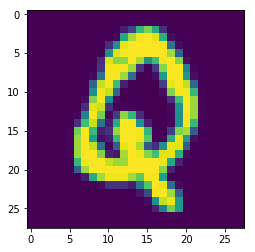

training set name:  train_Q_74436.png
training set label:  B
IF measure:  0.00516721953948
train_Q_74436.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



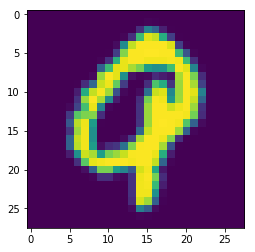

training set name:  train_Q_69617.png
training set label:  Q
IF measure:  -0.00449824454197
train_Q_69617.png


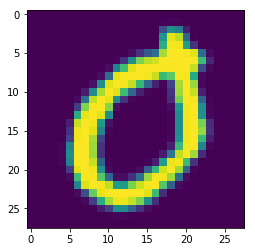

training set name:  train_0_42905.png
training set label:  Q
IF measure:  -0.00414054095745
train_0_42905.png


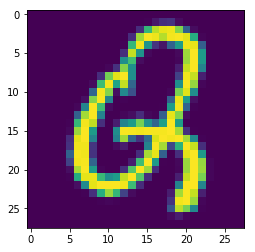

training set name:  train_Q_31301.png
training set label:  Q
IF measure:  -0.00413642368471
train_Q_31301.png


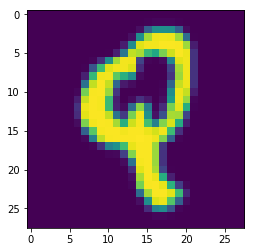

training set name:  train_Q_21495.png
training set label:  Q
IF measure:  -0.00410030295293
train_Q_21495.png


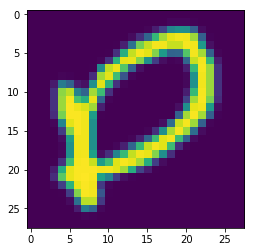

training set name:  train_Q_47894.png
training set label:  Q
IF measure:  -0.00408459698372
train_Q_47894.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



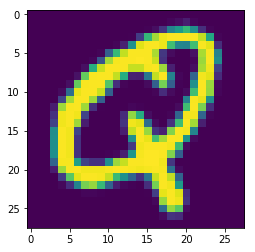

training set name:  train_Q_35174.png
training set label:  G
IF measure:  0.0054589597363


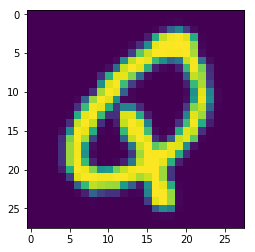

training set name:  train_Q_100225.png
training set label:  A
IF measure:  0.00528989541774


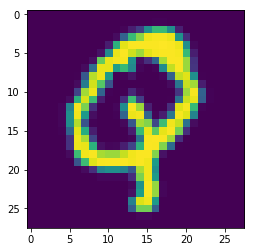

training set name:  train_Q_85221.png
training set label:  f
IF measure:  0.00525751688802


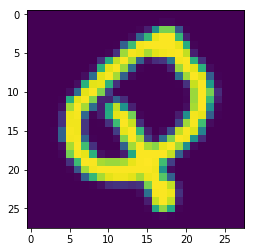

training set name:  train_Q_98465.png
training set label:  K
IF measure:  0.00522396624722


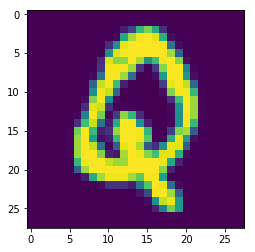

training set name:  train_Q_74436.png
training set label:  B
IF measure:  0.00516721953948

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



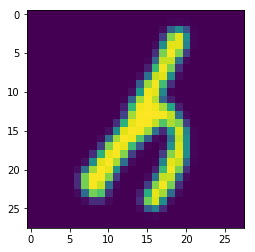

training set name:  train_h_62882.png
training set label:  h
IF measure:  -6.20199192239e-11


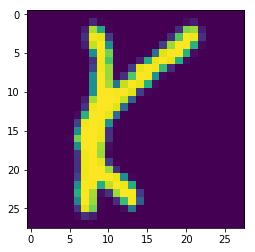

training set name:  train_K_101578.png
training set label:  K
IF measure:  -1.12759927164e-10


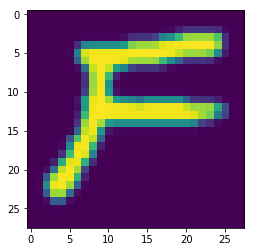

training set name:  train_F_50943.png
training set label:  F
IF measure:  2.30265675085e-10


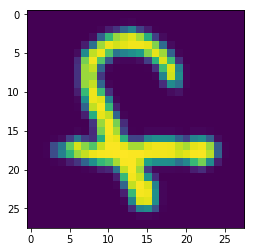

training set name:  train_f_57199.png
training set label:  f
IF measure:  -2.62342134147e-10


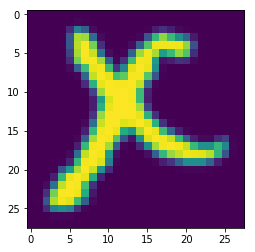

training set name:  train_X_7169.png
training set label:  X
IF measure:  -3.86893240849e-10


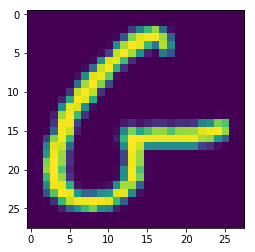

testfile name:  train_G_98150.png
ground truth label:  G
network prediction:  G
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 3508.086335775933, time: 18.0006582736969 

Recursion depth: 1, norm: 6426.186544133309, time: 17.988569736480713 

Recursion depth: 2, norm: 8861.452114310541, time: 18.056211709976196 

Recursion depth: 3, norm: 10894.165469702119, time: 18.14029049873352 

Recursion depth: 4, norm: 12590.902628175134, time: 18.084924697875977 

Recursion depth: 5, norm: 14007.260994302205, time: 18.371286630630493 

Recursion depth: 6, norm: 15189.701518936276, time: 18.20367980003357 

Recursion depth: 7, norm: 16176.7601239981, time: 18.1688973903656 

Recursion depth: 8, norm: 17000.680152294644, time: 18.056384801864624 

Recursion depth: 9, norm: 17688.271394839576, time: 18.118002891540527 

Recursion depth: 10, norm: 18262.311729864596, time: 18.213667631149292 

Recursion depth: 11, norm: 18741.791724562383, time: 16.85580778121

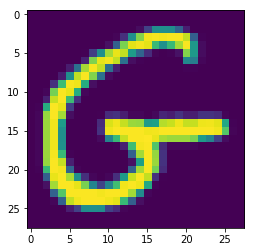

training set name:  train_G_36712.png
training set label:  Z
IF measure:  0.00211479724088
train_G_36712.png


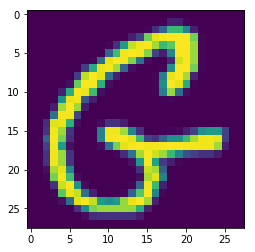

training set name:  train_G_77052.png
training set label:  f
IF measure:  0.0017632913135
train_G_77052.png


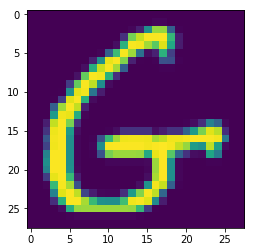

training set name:  train_G_7108.png
training set label:  F
IF measure:  0.00172549503532
train_G_7108.png


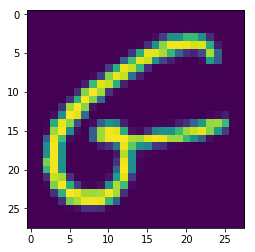

training set name:  train_G_59140.png
training set label:  h
IF measure:  0.00170865826943
train_G_59140.png


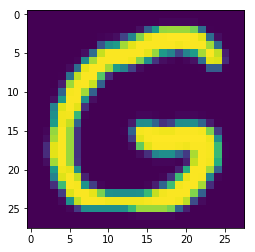

training set name:  train_G_93059.png
training set label:  r
IF measure:  0.00142975418749
train_G_93059.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



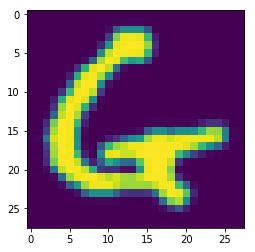

training set name:  train_G_38354.png
training set label:  G
IF measure:  -0.00113047347503
train_G_38354.png


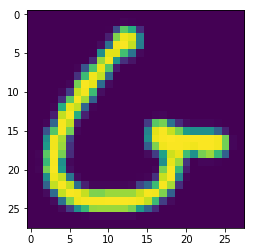

training set name:  train_G_111566.png
training set label:  G
IF measure:  -0.00112306389509
train_G_111566.png


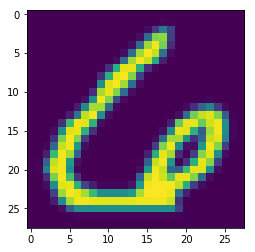

training set name:  train_6_96625.png
training set label:  G
IF measure:  -0.00107047268592
train_6_96625.png


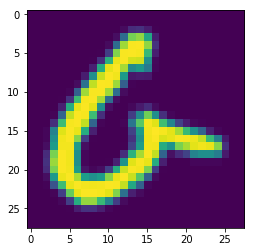

training set name:  train_G_103407.png
training set label:  G
IF measure:  -0.00106210168385
train_G_103407.png


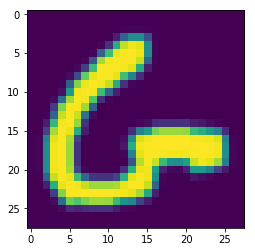

training set name:  train_G_57033.png
training set label:  G
IF measure:  -0.00104500288408
train_G_57033.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



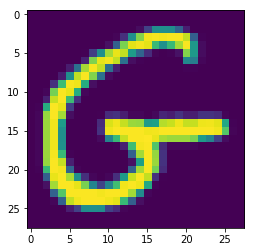

training set name:  train_G_36712.png
training set label:  Z
IF measure:  0.00211479724088


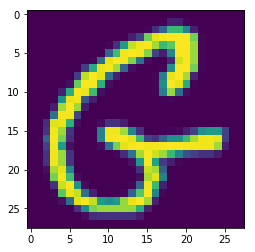

training set name:  train_G_77052.png
training set label:  f
IF measure:  0.0017632913135


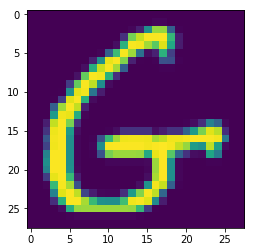

training set name:  train_G_7108.png
training set label:  F
IF measure:  0.00172549503532


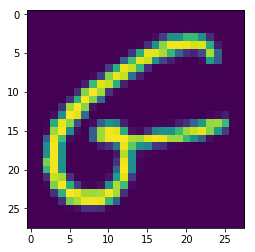

training set name:  train_G_59140.png
training set label:  h
IF measure:  0.00170865826943


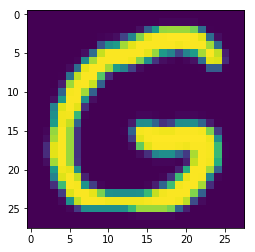

training set name:  train_G_93059.png
training set label:  r
IF measure:  0.00142975418749

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



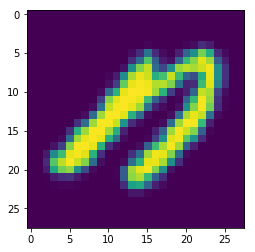

training set name:  train_n_4718.png
training set label:  n
IF measure:  -3.57863589038e-12


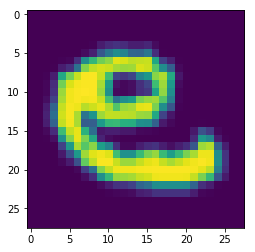

training set name:  train_e_72298.png
training set label:  e
IF measure:  -3.46427176937e-11


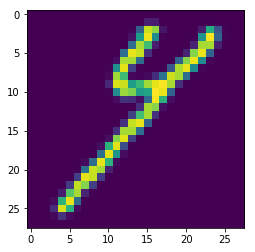

training set name:  train_Y_28968.png
training set label:  Y
IF measure:  -3.55593077442e-11


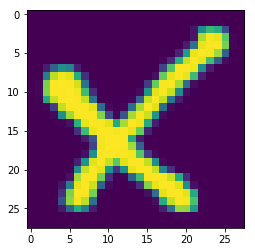

training set name:  train_X_34209.png
training set label:  X
IF measure:  5.69795205502e-11


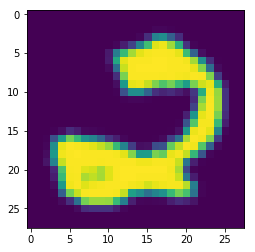

training set name:  train_2_92197.png
training set label:  2
IF measure:  6.20223784073e-11


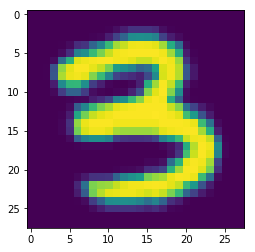

testfile name:  train_3_20482.png
ground truth label:  3
network prediction:  3
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 16044.700657460082, time: 15.085243940353394 

Recursion depth: 1, norm: 29427.1224383221, time: 15.140641927719116 

Recursion depth: 2, norm: 40599.021527618126, time: 15.155065298080444 

Recursion depth: 3, norm: 49925.53481436128, time: 15.313301801681519 

Recursion depth: 4, norm: 57711.483878860716, time: 15.11514687538147 

Recursion depth: 5, norm: 64211.249909965154, time: 15.290170431137085 

Recursion depth: 6, norm: 69637.36622676076, time: 15.299103498458862 

Recursion depth: 7, norm: 74167.17192936508, time: 15.216514348983765 

Recursion depth: 8, norm: 77948.87608554725, time: 15.36315631866455 

Recursion depth: 9, norm: 81105.737602219, time: 15.359297752380371 

Recursion depth: 10, norm: 83741.10585011402, time: 15.499619722366333 

Recursion depth: 11, norm: 85941.2756246962, time: 15.79413485527038

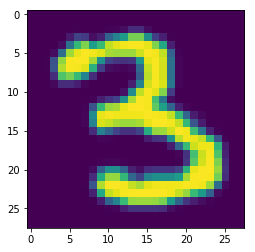

training set name:  train_3_1165.png
training set label:  8
IF measure:  0.00676177642077
train_3_1165.png


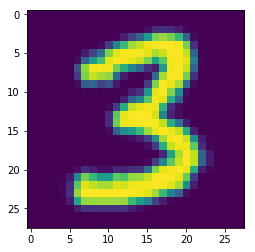

training set name:  train_3_75956.png
training set label:  B
IF measure:  0.00608349575377
train_3_75956.png


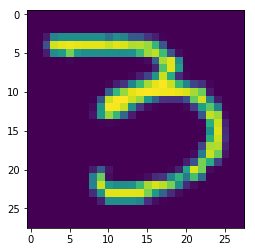

training set name:  train_3_44261.png
training set label:  U
IF measure:  0.00591349794351
train_3_44261.png


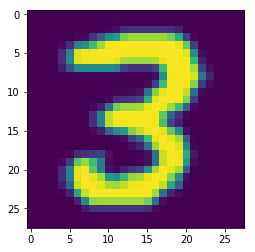

training set name:  train_3_14224.png
training set label:  t
IF measure:  0.00586408458069
train_3_14224.png


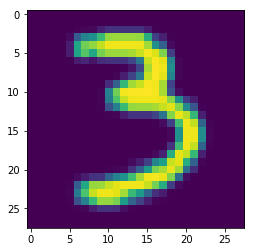

training set name:  train_3_29354.png
training set label:  4
IF measure:  0.00578328882549
train_3_29354.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



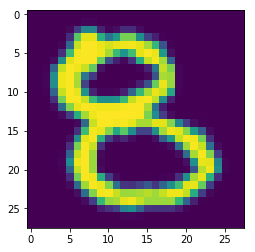

training set name:  train_8_93984.png
training set label:  3
IF measure:  -0.00855042279718
train_8_93984.png


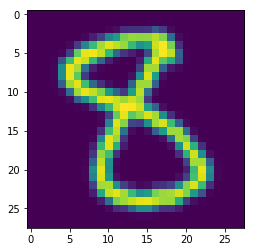

training set name:  train_8_82791.png
training set label:  3
IF measure:  -0.00720842734825
train_8_82791.png


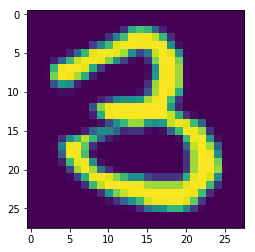

training set name:  train_3_88849.png
training set label:  3
IF measure:  -0.00667626179543
train_3_88849.png


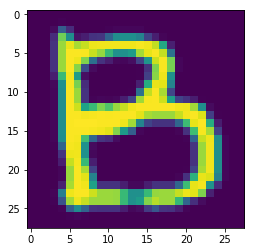

training set name:  train_B_91329.png
training set label:  3
IF measure:  -0.00628563500148
train_B_91329.png


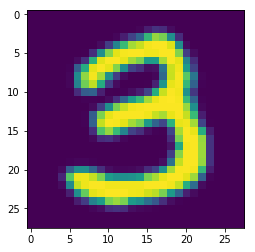

training set name:  train_3_85746.png
training set label:  3
IF measure:  -0.00625086317354
train_3_85746.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



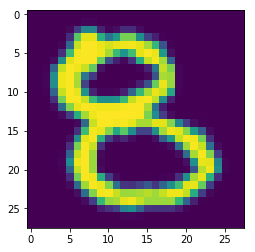

training set name:  train_8_93984.png
training set label:  3
IF measure:  -0.00855042279718


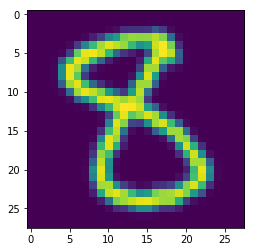

training set name:  train_8_82791.png
training set label:  3
IF measure:  -0.00720842734825


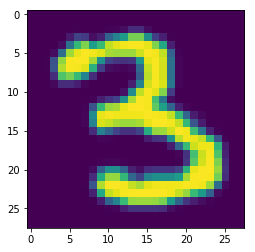

training set name:  train_3_1165.png
training set label:  8
IF measure:  0.00676177642077


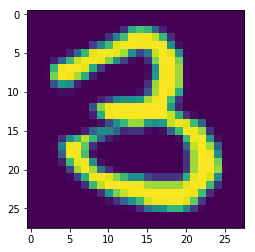

training set name:  train_3_88849.png
training set label:  3
IF measure:  -0.00667626179543


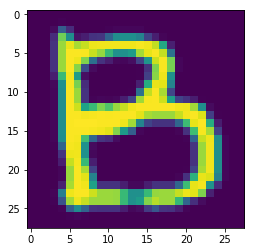

training set name:  train_B_91329.png
training set label:  3
IF measure:  -0.00628563500148

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



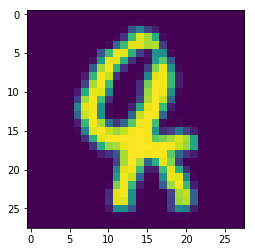

training set name:  train_q_16354.png
training set label:  q
IF measure:  -2.78244100731e-11


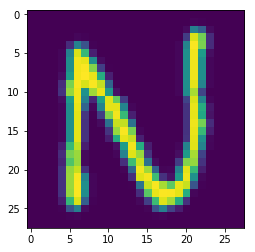

training set name:  train_N_43506.png
training set label:  N
IF measure:  -7.92666559656e-11


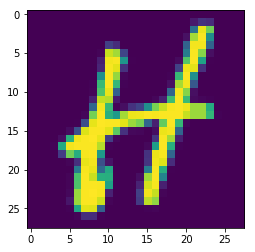

training set name:  train_H_81916.png
training set label:  H
IF measure:  -5.21195614327e-10


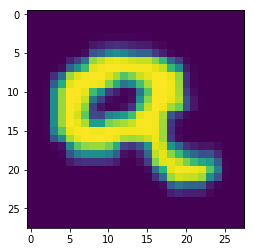

training set name:  train_a_7356.png
training set label:  a
IF measure:  -6.79481556599e-10


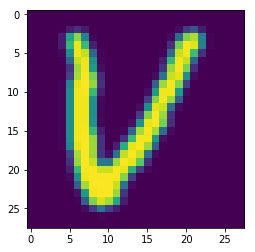

training set name:  train_V_87076.png
training set label:  V
IF measure:  -6.90529014583e-10


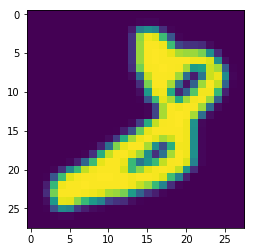

testfile name:  train_8_100781.png
ground truth label:  8
network prediction:  Y
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 31303.771344280547, time: 18.15075182914734 

Recursion depth: 1, norm: 57418.948723396185, time: 18.156585693359375 

Recursion depth: 2, norm: 79220.33651152966, time: 18.276273488998413 

Recursion depth: 3, norm: 97420.86125671442, time: 18.495450496673584 

Recursion depth: 4, norm: 112615.07821779462, time: 18.63841462135315 

Recursion depth: 5, norm: 125299.76800457374, time: 18.622267961502075 

Recursion depth: 6, norm: 135889.34514523204, time: 18.59058403968811 

Recursion depth: 7, norm: 144729.4596825401, time: 18.426188230514526 

Recursion depth: 8, norm: 152109.20170719456, time: 18.559541940689087 

Recursion depth: 9, norm: 158269.8465280105, time: 18.54010248184204 

Recursion depth: 10, norm: 163412.87493952244, time: 18.617099046707153 

Recursion depth: 11, norm: 167706.48959417164, time: 18.4914493

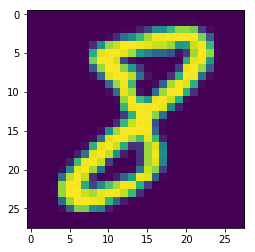

training set name:  train_8_36855.png
training set label:  6
IF measure:  0.0111926751145
train_8_36855.png


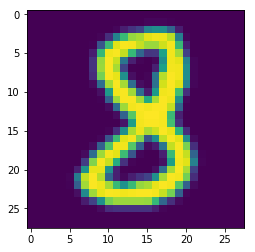

training set name:  train_8_41882.png
training set label:  K
IF measure:  0.00931423938972
train_8_41882.png


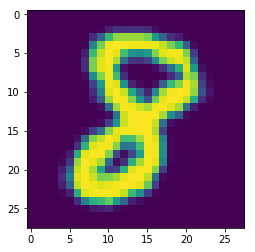

training set name:  train_8_25396.png
training set label:  Y
IF measure:  0.00931254809207
train_8_25396.png


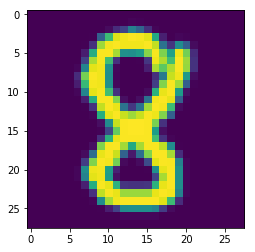

training set name:  train_8_4076.png
training set label:  B
IF measure:  0.00907078859337
train_8_4076.png


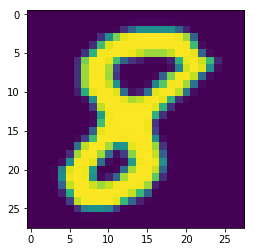

training set name:  train_8_76395.png
training set label:  f
IF measure:  0.00904682553406
train_8_76395.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



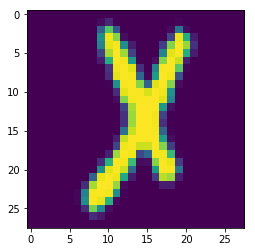

training set name:  train_X_41370.png
training set label:  8
IF measure:  -0.0122327923669
train_X_41370.png


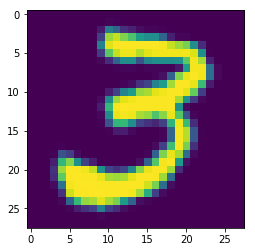

training set name:  train_3_24401.png
training set label:  8
IF measure:  -0.0114018145394
train_3_24401.png


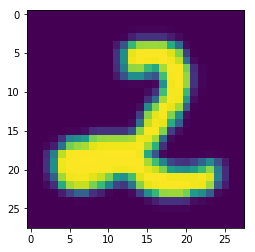

training set name:  train_2_44798.png
training set label:  8
IF measure:  -0.0113484945914
train_2_44798.png


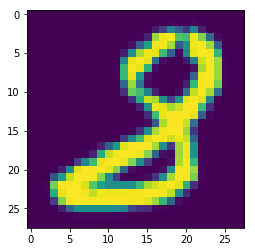

training set name:  train_8_48557.png
training set label:  8
IF measure:  -0.0109093832314
train_8_48557.png


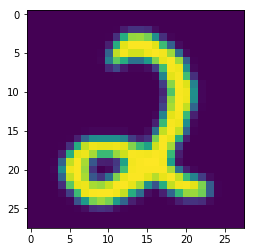

training set name:  train_2_104640.png
training set label:  8
IF measure:  -0.0107327176641
train_2_104640.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



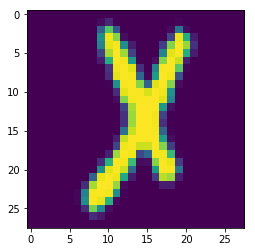

training set name:  train_X_41370.png
training set label:  8
IF measure:  -0.0122327923669


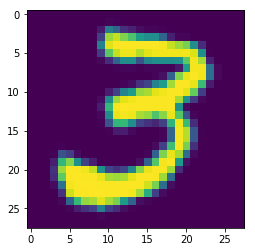

training set name:  train_3_24401.png
training set label:  8
IF measure:  -0.0114018145394


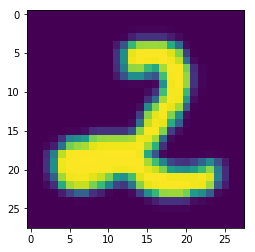

training set name:  train_2_44798.png
training set label:  8
IF measure:  -0.0113484945914


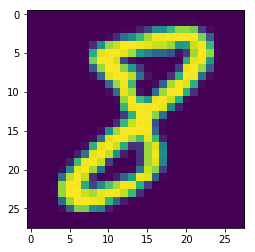

training set name:  train_8_36855.png
training set label:  6
IF measure:  0.0111926751145


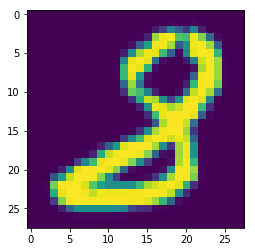

training set name:  train_8_48557.png
training set label:  8
IF measure:  -0.0109093832314

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



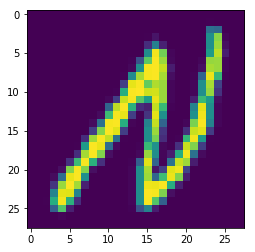

training set name:  train_N_53484.png
training set label:  N
IF measure:  4.54050394131e-10


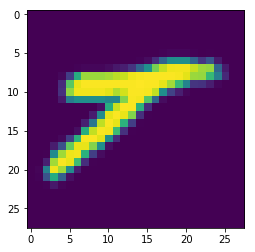

training set name:  train_T_12657.png
training set label:  T
IF measure:  1.3206946723e-09


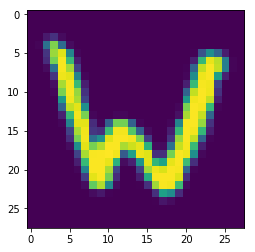

training set name:  train_W_28257.png
training set label:  W
IF measure:  1.48836163315e-09


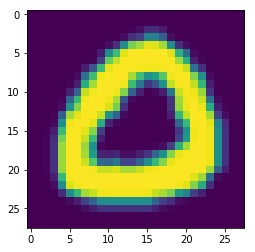

training set name:  train_O_48488.png
training set label:  O
IF measure:  -1.66544017096e-09


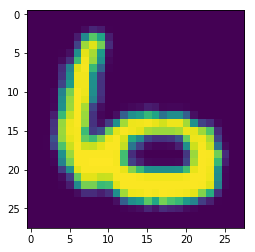

training set name:  train_b_74726.png
training set label:  b
IF measure:  -2.55064434947e-09


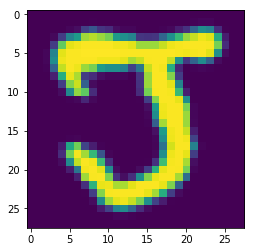

testfile name:  train_J_9128.png
ground truth label:  J
network prediction:  J
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 23514.913783596996, time: 18.539936304092407 

Recursion depth: 1, norm: 43130.77772310627, time: 18.603909730911255 

Recursion depth: 2, norm: 59506.39767705654, time: 19.348227977752686 

Recursion depth: 3, norm: 73177.24009212154, time: 18.466552734375 

Recursion depth: 4, norm: 84589.98894077241, time: 18.03564429283142 

Recursion depth: 5, norm: 94117.58494032877, time: 18.913398504257202 

Recursion depth: 6, norm: 102071.30760404708, time: 18.625717639923096 

Recursion depth: 7, norm: 108711.05579470747, time: 18.381988763809204 

Recursion depth: 8, norm: 114254.19124916162, time: 18.935410976409912 

Recursion depth: 9, norm: 118881.78130394917, time: 18.65430474281311 

Recursion depth: 10, norm: 122744.81781321768, time: 18.407915592193604 

Recursion depth: 11, norm: 125969.96519011982, time: 18.57922983169

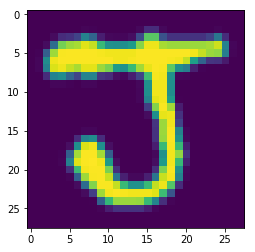

training set name:  train_J_18134.png
training set label:  5
IF measure:  0.0156002041983
train_J_18134.png


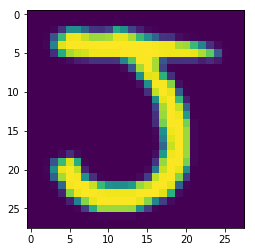

training set name:  train_J_74384.png
training set label:  5
IF measure:  0.0118807059706
train_J_74384.png


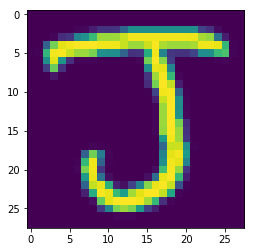

training set name:  train_J_24465.png
training set label:  E
IF measure:  0.0109244887235
train_J_24465.png


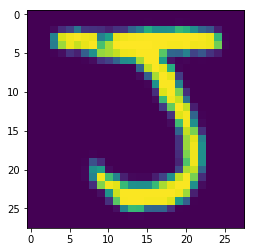

training set name:  train_J_67531.png
training set label:  L
IF measure:  0.0107140616454
train_J_67531.png


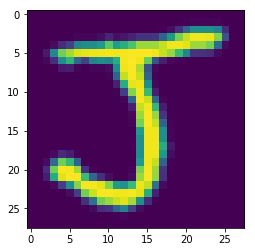

training set name:  train_J_33762.png
training set label:  r
IF measure:  0.00966806942795
train_J_33762.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



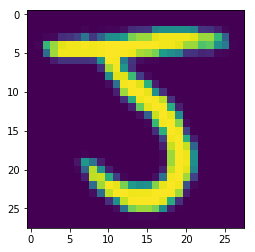

training set name:  train_J_106473.png
training set label:  J
IF measure:  -0.012918251626
train_J_106473.png


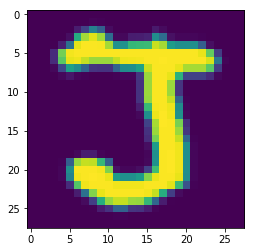

training set name:  train_J_90119.png
training set label:  J
IF measure:  -0.0100887648339
train_J_90119.png


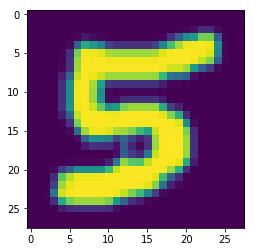

training set name:  train_5_38212.png
training set label:  J
IF measure:  -0.00970648149332
train_5_38212.png


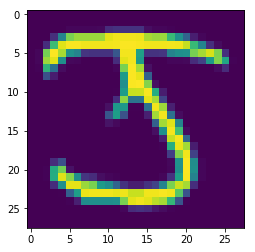

training set name:  train_J_94902.png
training set label:  J
IF measure:  -0.0095939396121
train_J_94902.png


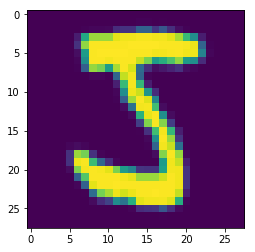

training set name:  train_J_45208.png
training set label:  J
IF measure:  -0.009336716687
train_J_45208.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



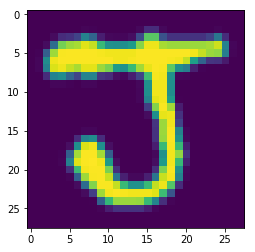

training set name:  train_J_18134.png
training set label:  5
IF measure:  0.0156002041983


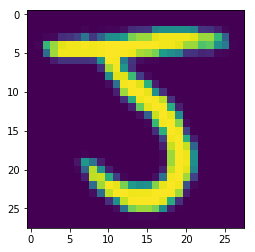

training set name:  train_J_106473.png
training set label:  J
IF measure:  -0.012918251626


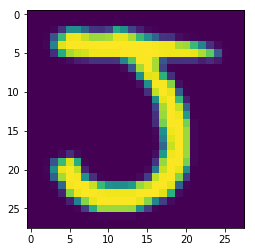

training set name:  train_J_74384.png
training set label:  5
IF measure:  0.0118807059706


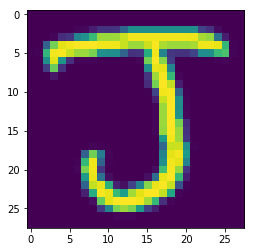

training set name:  train_J_24465.png
training set label:  E
IF measure:  0.0109244887235


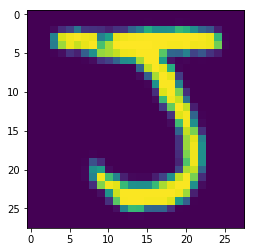

training set name:  train_J_67531.png
training set label:  L
IF measure:  0.0107140616454

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



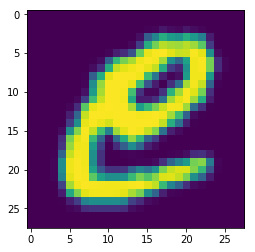

training set name:  train_e_37226.png
training set label:  e
IF measure:  3.19996357859e-10


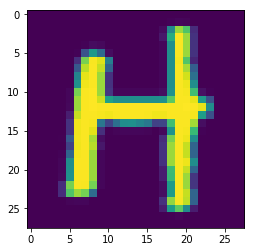

training set name:  train_H_39268.png
training set label:  H
IF measure:  8.01614439445e-10


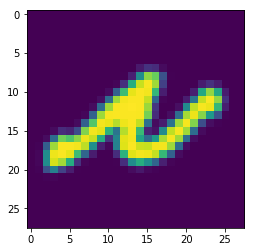

training set name:  train_N_208.png
training set label:  N
IF measure:  8.49398388032e-10


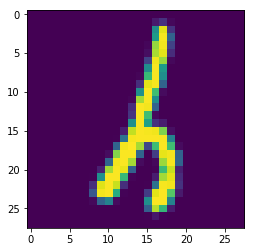

training set name:  train_h_51908.png
training set label:  h
IF measure:  9.2654934001e-10


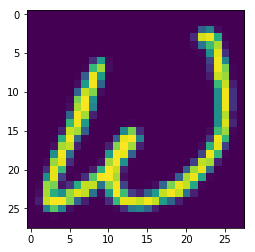

training set name:  train_W_13584.png
training set label:  W
IF measure:  -1.09272060336e-09


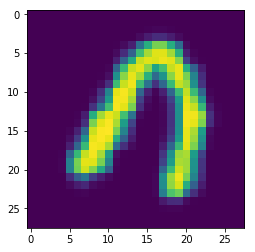

testfile name:  train_n_50633.png
ground truth label:  n
network prediction:  n
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 13604.706732644037, time: 16.15783429145813 

Recursion depth: 1, norm: 24951.166120043366, time: 16.105647087097168 

Recursion depth: 2, norm: 34423.61712182495, time: 16.224213123321533 

Recursion depth: 3, norm: 42331.2163214099, time: 16.14339542388916 

Recursion depth: 4, norm: 48932.64140121602, time: 16.08586096763611 

Recursion depth: 5, norm: 54443.71235964719, time: 16.232726335525513 

Recursion depth: 6, norm: 59044.54830041466, time: 16.10577917098999 

Recursion depth: 7, norm: 62885.287969444806, time: 16.150687217712402 

Recursion depth: 8, norm: 66091.5919917201, time: 16.1270432472229 

Recursion depth: 9, norm: 68768.16144844938, time: 15.923104286193848 

Recursion depth: 10, norm: 71002.67947056647, time: 16.032133102416992 

Recursion depth: 11, norm: 72868.05674642354, time: 16.41058588027954 



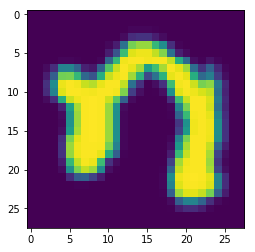

training set name:  train_n_1674.png
training set label:  E
IF measure:  0.00603852429236
train_n_1674.png


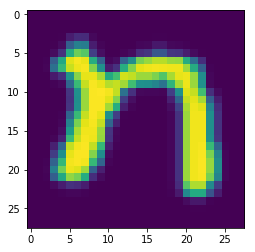

training set name:  train_n_29793.png
training set label:  D
IF measure:  0.0059987575397
train_n_29793.png


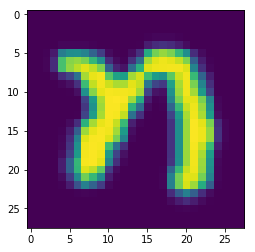

training set name:  train_n_27370.png
training set label:  I
IF measure:  0.00597280955589
train_n_27370.png


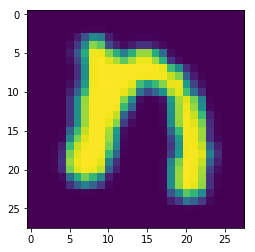

training set name:  train_n_71788.png
training set label:  S
IF measure:  0.00591744782654
train_n_71788.png


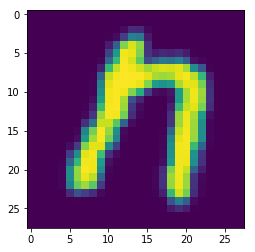

training set name:  train_n_14702.png
training set label:  b
IF measure:  0.00576827180512
train_n_14702.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



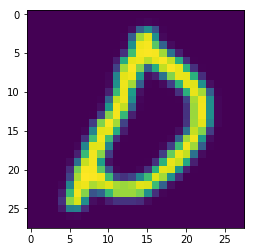

training set name:  train_D_15424.png
training set label:  n
IF measure:  -0.00637863294241
train_D_15424.png


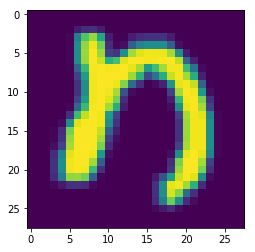

training set name:  train_n_9931.png
training set label:  n
IF measure:  -0.00584189553104
train_n_9931.png


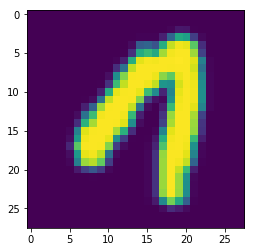

training set name:  train_n_93233.png
training set label:  n
IF measure:  -0.00549712479115
train_n_93233.png


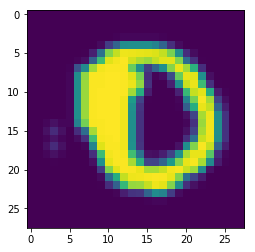

training set name:  train_O_110743.png
training set label:  n
IF measure:  -0.0052741700321
train_O_110743.png


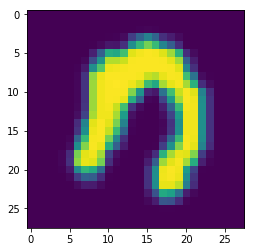

training set name:  train_n_62223.png
training set label:  n
IF measure:  -0.00516167596669
train_n_62223.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



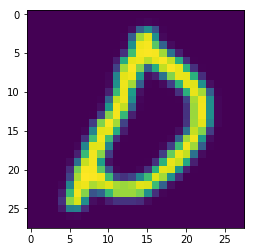

training set name:  train_D_15424.png
training set label:  n
IF measure:  -0.00637863294241


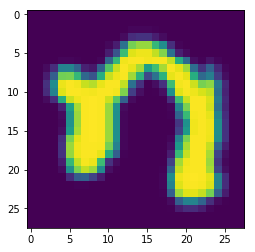

training set name:  train_n_1674.png
training set label:  E
IF measure:  0.00603852429236


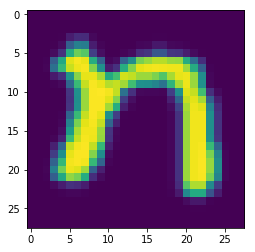

training set name:  train_n_29793.png
training set label:  D
IF measure:  0.0059987575397


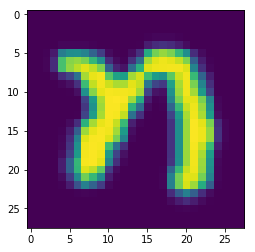

training set name:  train_n_27370.png
training set label:  I
IF measure:  0.00597280955589


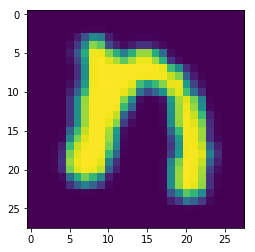

training set name:  train_n_71788.png
training set label:  S
IF measure:  0.00591744782654

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



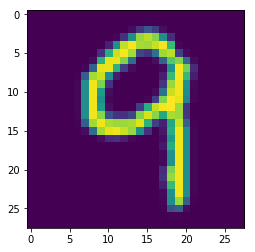

training set name:  train_9_64744.png
training set label:  9
IF measure:  9.77400414347e-11


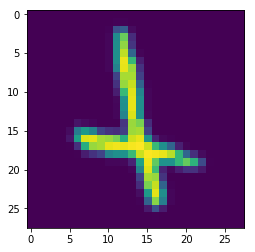

training set name:  train_t_70444.png
training set label:  b
IF measure:  -1.12741221244e-10


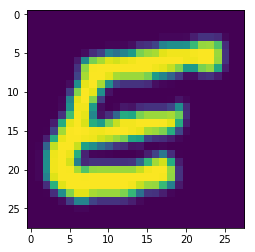

training set name:  train_E_64003.png
training set label:  E
IF measure:  -2.04039814831e-10


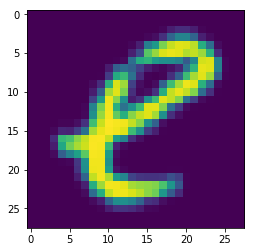

training set name:  train_e_47224.png
training set label:  e
IF measure:  3.21007928828e-10


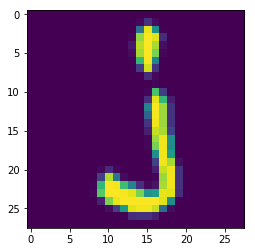

training set name:  train_J_51125.png
training set label:  J
IF measure:  5.60292759706e-10


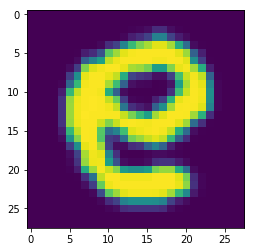

testfile name:  train_e_106291.png
ground truth label:  e
network prediction:  e
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 10726.56977439666, time: 15.080515384674072 

Recursion depth: 1, norm: 19670.874254529208, time: 15.293521404266357 

Recursion depth: 2, norm: 27137.79338395073, time: 15.266074180603027 

Recursion depth: 3, norm: 33371.484931000596, time: 15.160701990127563 

Recursion depth: 4, norm: 38575.30041360663, time: 15.264513969421387 

Recursion depth: 5, norm: 42919.74163482348, time: 15.097145080566406 

Recursion depth: 6, norm: 46546.3657765029, time: 15.264608144760132 

Recursion depth: 7, norm: 49573.81867982332, time: 15.392804622650146 

Recursion depth: 8, norm: 52101.3824672628, time: 15.229974031448364 

Recursion depth: 9, norm: 54211.45469363463, time: 15.298034191131592 

Recursion depth: 10, norm: 55973.025664153625, time: 15.555176496505737 

Recursion depth: 11, norm: 57443.482515425545, time: 15.558553934

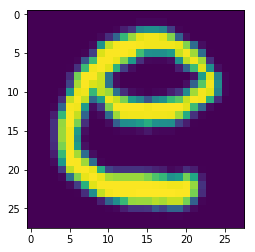

training set name:  train_e_53139.png
training set label:  O
IF measure:  0.00496649156648
train_e_53139.png


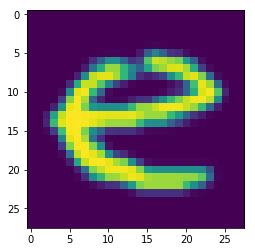

training set name:  train_e_67875.png
training set label:  K
IF measure:  0.00493744027847
train_e_67875.png


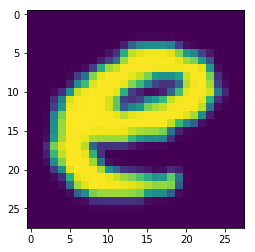

training set name:  train_e_81063.png
training set label:  5
IF measure:  0.00464192368883
train_e_81063.png


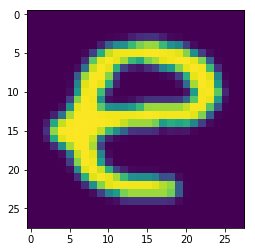

training set name:  train_e_79411.png
training set label:  D
IF measure:  0.00451825616472
train_e_79411.png


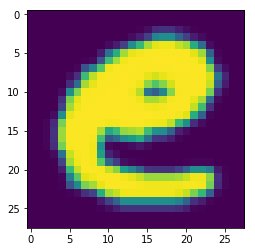

training set name:  train_e_103764.png
training set label:  2
IF measure:  0.00438423365724
train_e_103764.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



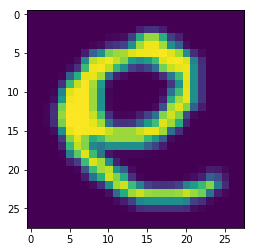

training set name:  train_e_19748.png
training set label:  e
IF measure:  -0.00474933678852
train_e_19748.png


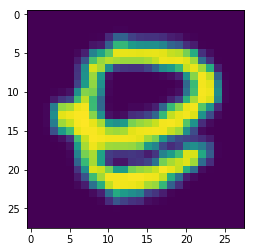

training set name:  train_e_38676.png
training set label:  e
IF measure:  -0.00458337288905
train_e_38676.png


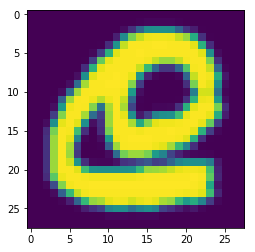

training set name:  train_e_47241.png
training set label:  e
IF measure:  -0.00425186387613
train_e_47241.png


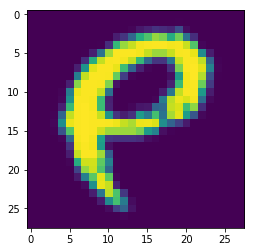

training set name:  train_e_53363.png
training set label:  e
IF measure:  -0.00418684758404
train_e_53363.png


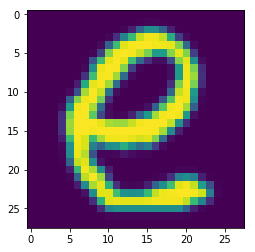

training set name:  train_e_55909.png
training set label:  e
IF measure:  -0.00418159356143
train_e_55909.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



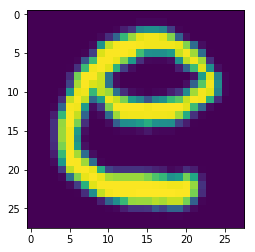

training set name:  train_e_53139.png
training set label:  O
IF measure:  0.00496649156648


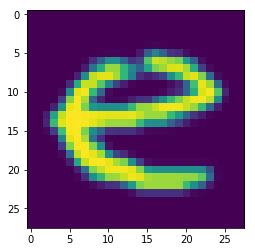

training set name:  train_e_67875.png
training set label:  K
IF measure:  0.00493744027847


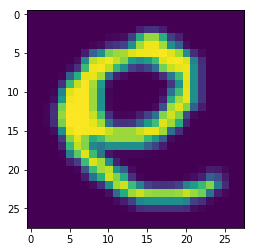

training set name:  train_e_19748.png
training set label:  e
IF measure:  -0.00474933678852


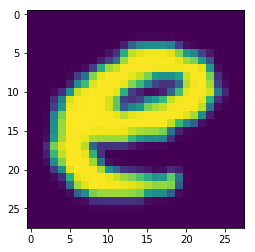

training set name:  train_e_81063.png
training set label:  5
IF measure:  0.00464192368883


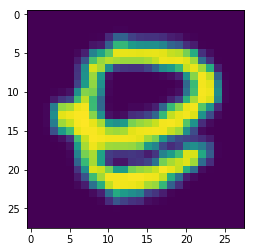

training set name:  train_e_38676.png
training set label:  e
IF measure:  -0.00458337288905

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



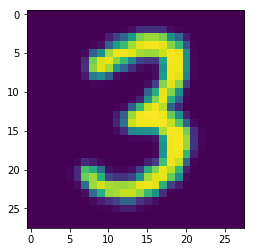

training set name:  train_3_87802.png
training set label:  4
IF measure:  -6.09380801139e-11


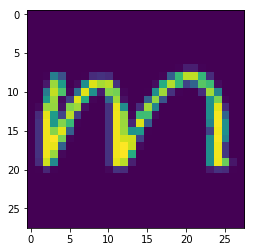

training set name:  train_M_73208.png
training set label:  H
IF measure:  -1.88817550405e-10


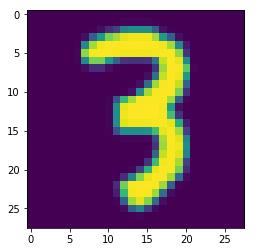

training set name:  train_3_25910.png
training set label:  a
IF measure:  1.99624411564e-10


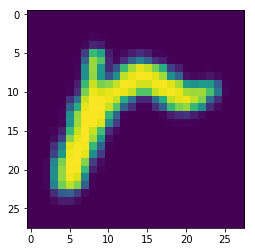

training set name:  train_r_16061.png
training set label:  r
IF measure:  -2.2972417097e-10


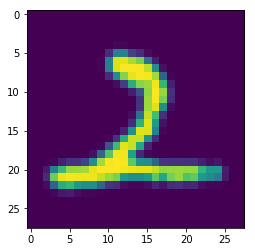

training set name:  train_2_103665.png
training set label:  2
IF measure:  -2.42768969624e-10


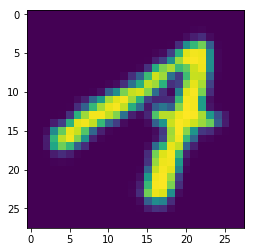

testfile name:  train_A_29714.png
ground truth label:  A
network prediction:  n
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 29439.894008810563, time: 15.969645977020264 

Recursion depth: 1, norm: 53999.874782262224, time: 16.501214742660522 

Recursion depth: 2, norm: 74503.12600824209, time: 16.642793893814087 

Recursion depth: 3, norm: 91619.82808322662, time: 16.684608221054077 

Recursion depth: 4, norm: 105909.0673360879, time: 16.439037084579468 

Recursion depth: 5, norm: 117837.88470606557, time: 16.80652904510498 

Recursion depth: 6, norm: 127796.235437512, time: 16.55454444885254 

Recursion depth: 7, norm: 136109.30238598684, time: 16.034026384353638 

Recursion depth: 8, norm: 143049.34372446453, time: 16.47668719291687 

Recursion depth: 9, norm: 148842.95883917384, time: 16.461670398712158 

Recursion depth: 10, norm: 153679.43470744547, time: 16.433927536010742 

Recursion depth: 11, norm: 157717.04553408298, time: 16.80731129

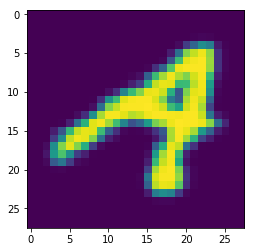

training set name:  train_A_85543.png
training set label:  D
IF measure:  0.0116889830177
train_A_85543.png


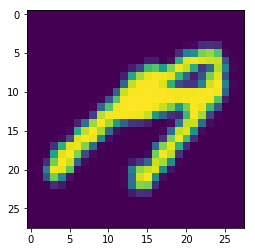

training set name:  train_A_70671.png
training set label:  n
IF measure:  0.0115601212632
train_A_70671.png


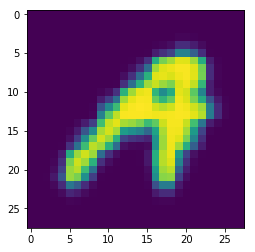

training set name:  train_A_1360.png
training set label:  B
IF measure:  0.0103057187553
train_A_1360.png


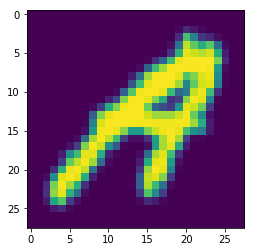

training set name:  train_A_21738.png
training set label:  0
IF measure:  0.0102619606341
train_A_21738.png


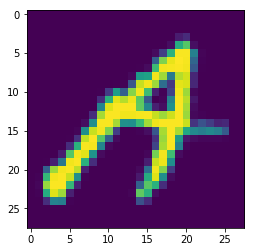

training set name:  train_A_85526.png
training set label:  D
IF measure:  0.00984056626863
train_A_85526.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



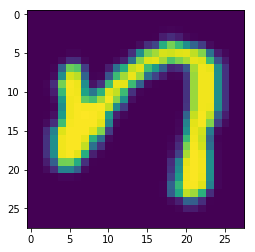

training set name:  train_n_26580.png
training set label:  A
IF measure:  -0.0125349596988
train_n_26580.png


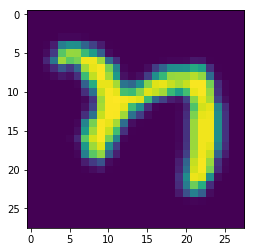

training set name:  train_n_4387.png
training set label:  A
IF measure:  -0.0107202818208
train_n_4387.png


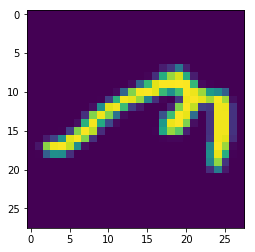

training set name:  train_M_50139.png
training set label:  A
IF measure:  -0.0104477928674
train_M_50139.png


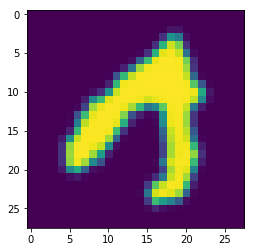

training set name:  train_A_32148.png
training set label:  A
IF measure:  -0.00993147507204
train_A_32148.png


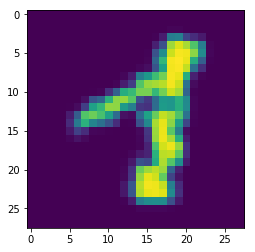

training set name:  train_J_33349.png
training set label:  A
IF measure:  -0.00983268536152
train_J_33349.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



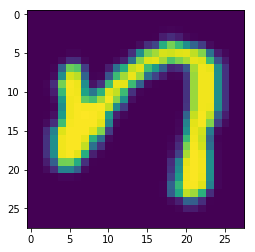

training set name:  train_n_26580.png
training set label:  A
IF measure:  -0.0125349596988


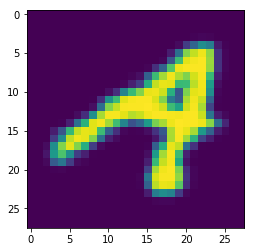

training set name:  train_A_85543.png
training set label:  D
IF measure:  0.0116889830177


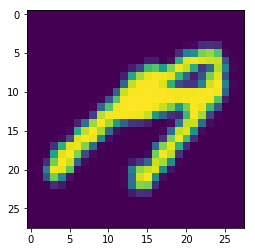

training set name:  train_A_70671.png
training set label:  n
IF measure:  0.0115601212632


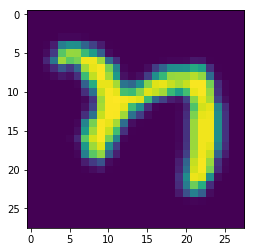

training set name:  train_n_4387.png
training set label:  A
IF measure:  -0.0107202818208


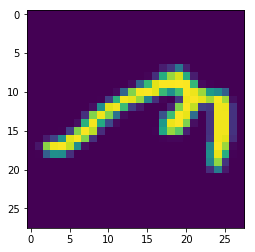

training set name:  train_M_50139.png
training set label:  A
IF measure:  -0.0104477928674

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



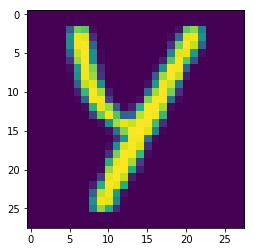

training set name:  train_Y_95440.png
training set label:  5
IF measure:  -3.29920815647e-11


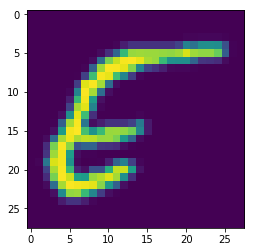

training set name:  train_E_21242.png
training set label:  E
IF measure:  9.50338109231e-11


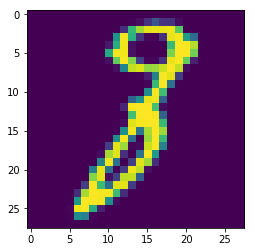

training set name:  train_q_34779.png
training set label:  q
IF measure:  3.81466589128e-10


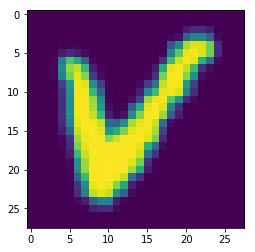

training set name:  train_V_756.png
training set label:  V
IF measure:  -1.0015194398e-09


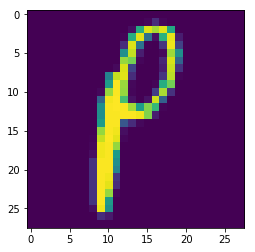

training set name:  train_P_77242.png
training set label:  P
IF measure:  1.10095172191e-09


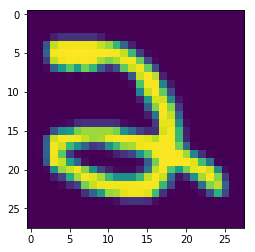

testfile name:  train_2_87560.png
ground truth label:  2
network prediction:  2
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 4120.717384709662, time: 14.990776300430298 

Recursion depth: 1, norm: 7548.062962401347, time: 15.091399669647217 

Recursion depth: 2, norm: 10408.74740546533, time: 15.022043466567993 

Recursion depth: 3, norm: 12796.672023420777, time: 14.998268604278564 

Recursion depth: 4, norm: 14789.998078304472, time: 15.01107144355774 

Recursion depth: 5, norm: 16454.159840675547, time: 14.96118426322937 

Recursion depth: 6, norm: 17843.251875271362, time: 14.87560749053955 

Recursion depth: 7, norm: 19002.769329429328, time: 15.115288734436035 

Recursion depth: 8, norm: 19970.92710471587, time: 15.161220073699951 

Recursion depth: 9, norm: 20779.210523230904, time: 15.086922883987427 

Recursion depth: 10, norm: 21453.991019301047, time: 15.17264175415039 

Recursion depth: 11, norm: 22017.182456265833, time: 15.09050869

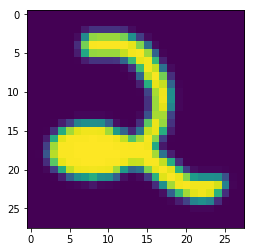

training set name:  train_2_76337.png
training set label:  3
IF measure:  0.00221648679993
train_2_76337.png


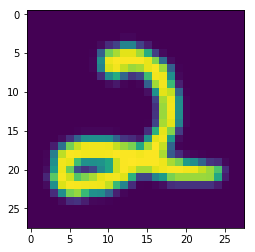

training set name:  train_2_43327.png
training set label:  f
IF measure:  0.00187340627708
train_2_43327.png


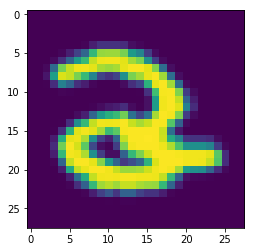

training set name:  train_a_82495.png
training set label:  F
IF measure:  0.00181974567843
train_a_82495.png


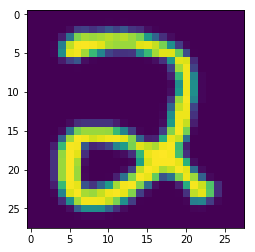

training set name:  train_2_92298.png
training set label:  V
IF measure:  0.00176040056617
train_2_92298.png


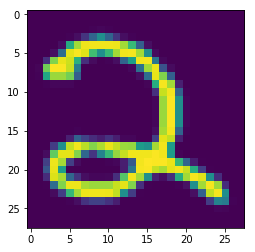

training set name:  train_2_87652.png
training set label:  O
IF measure:  0.00167822483927
train_2_87652.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



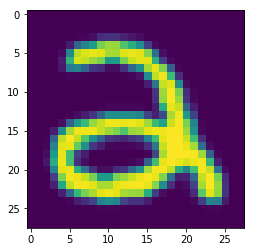

training set name:  train_2_96480.png
training set label:  2
IF measure:  -0.00177194791126
train_2_96480.png


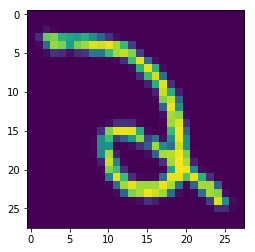

training set name:  train_2_29147.png
training set label:  2
IF measure:  -0.00174657165515
train_2_29147.png


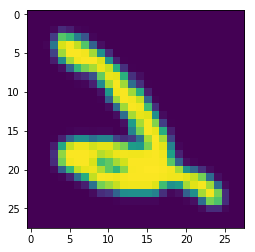

training set name:  train_2_1226.png
training set label:  2
IF measure:  -0.00159160717133
train_2_1226.png


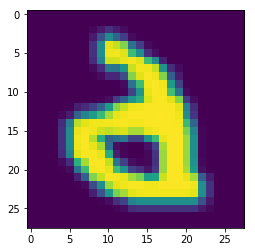

training set name:  train_a_6006.png
training set label:  2
IF measure:  -0.00140276725027
train_a_6006.png


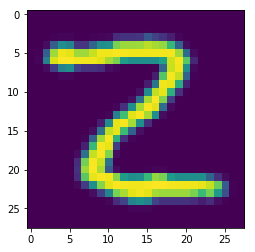

training set name:  train_2_28310.png
training set label:  2
IF measure:  -0.00135541526561
train_2_28310.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



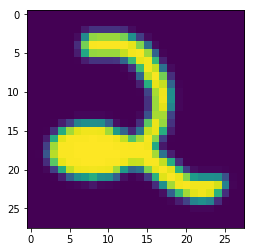

training set name:  train_2_76337.png
training set label:  3
IF measure:  0.00221648679993


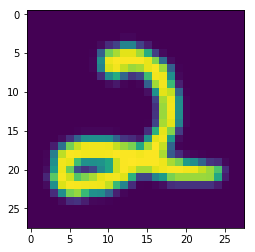

training set name:  train_2_43327.png
training set label:  f
IF measure:  0.00187340627708


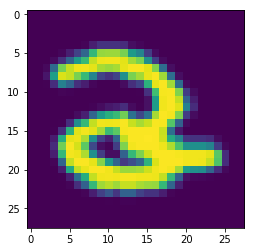

training set name:  train_a_82495.png
training set label:  F
IF measure:  0.00181974567843


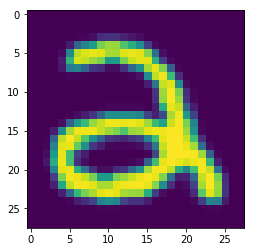

training set name:  train_2_96480.png
training set label:  2
IF measure:  -0.00177194791126


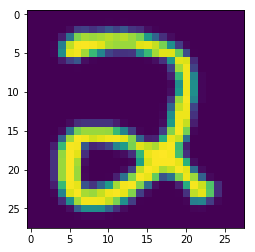

training set name:  train_2_92298.png
training set label:  V
IF measure:  0.00176040056617

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



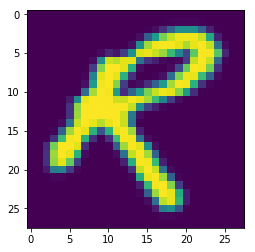

training set name:  train_R_57534.png
training set label:  R
IF measure:  6.87378034712e-12


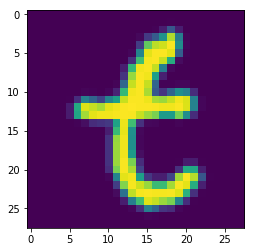

training set name:  train_t_85814.png
training set label:  t
IF measure:  -2.6824288417e-11


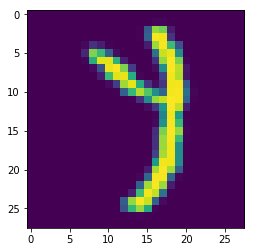

training set name:  train_Y_60593.png
training set label:  Y
IF measure:  -2.68771810166e-11


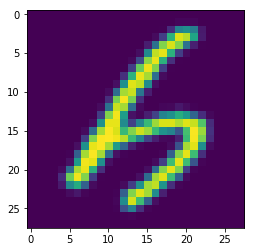

training set name:  train_h_101517.png
training set label:  R
IF measure:  1.50473640797e-10


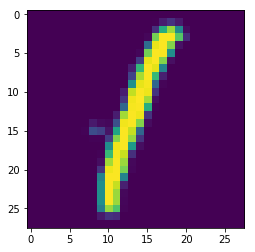

training set name:  train_1_109944.png
training set label:  1
IF measure:  -1.52877673956e-10


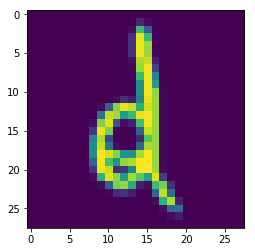

testfile name:  train_d_26555.png
ground truth label:  d
network prediction:  d
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 18389.02787669865, time: 14.93720531463623 

Recursion depth: 1, norm: 33728.10602079518, time: 15.000231504440308 

Recursion depth: 2, norm: 46533.509753724786, time: 14.92053508758545 

Recursion depth: 3, norm: 57223.55191702102, time: 14.989285230636597 

Recursion depth: 4, norm: 66147.97075496723, time: 15.244867324829102 

Recursion depth: 5, norm: 73598.14397116275, time: 14.999011039733887 

Recursion depth: 6, norm: 79817.57331565525, time: 14.943239450454712 

Recursion depth: 7, norm: 85009.95438182518, time: 15.007988691329956 

Recursion depth: 8, norm: 89344.40846521957, time: 14.94037652015686 

Recursion depth: 9, norm: 92963.05025116162, time: 15.241142988204956 

Recursion depth: 10, norm: 95983.87843799603, time: 15.080626726150513 

Recursion depth: 11, norm: 98505.74247220311, time: 15.07345390319824

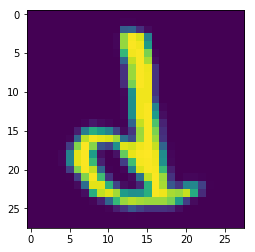

training set name:  train_d_10198.png
training set label:  W
IF measure:  0.00654211301647
train_d_10198.png


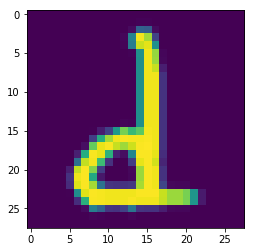

training set name:  train_d_57078.png
training set label:  N
IF measure:  0.00605390242545
train_d_57078.png


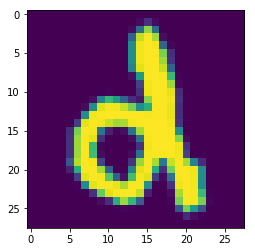

training set name:  train_d_24116.png
training set label:  H
IF measure:  0.0059130682643
train_d_24116.png


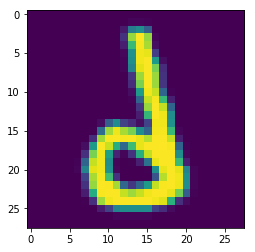

training set name:  train_d_28306.png
training set label:  U
IF measure:  0.00576392513112
train_d_28306.png


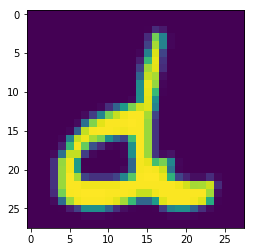

training set name:  train_d_60241.png
training set label:  B
IF measure:  0.00566728815225
train_d_60241.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



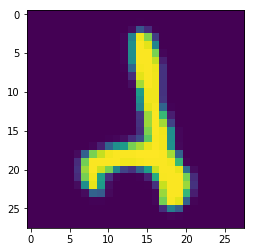

training set name:  train_d_98762.png
training set label:  d
IF measure:  -0.00786236794599
train_d_98762.png


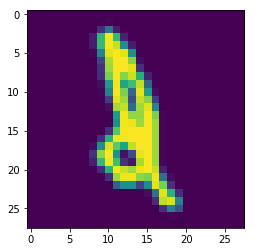

training set name:  train_d_21549.png
training set label:  d
IF measure:  -0.00657066991883
train_d_21549.png


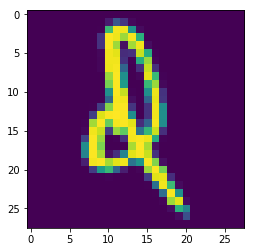

training set name:  train_d_89199.png
training set label:  d
IF measure:  -0.00646307961421
train_d_89199.png


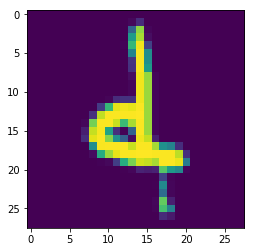

training set name:  train_d_42517.png
training set label:  d
IF measure:  -0.00639164583586
train_d_42517.png


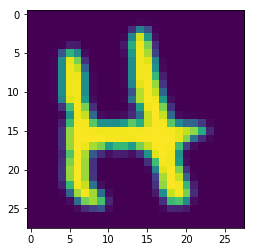

training set name:  train_H_64296.png
training set label:  d
IF measure:  -0.00616249088594
train_H_64296.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



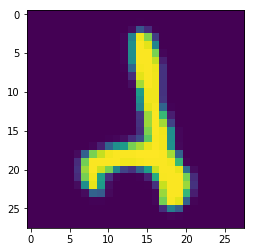

training set name:  train_d_98762.png
training set label:  d
IF measure:  -0.00786236794599


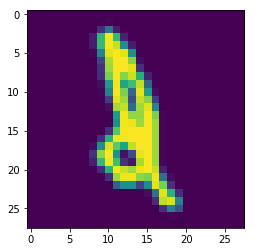

training set name:  train_d_21549.png
training set label:  d
IF measure:  -0.00657066991883


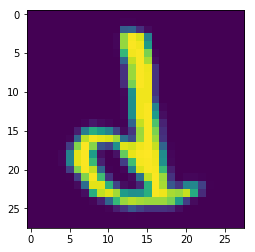

training set name:  train_d_10198.png
training set label:  W
IF measure:  0.00654211301647


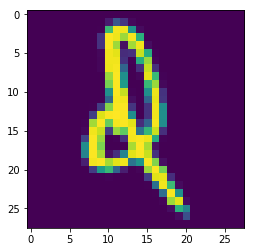

training set name:  train_d_89199.png
training set label:  d
IF measure:  -0.00646307961421


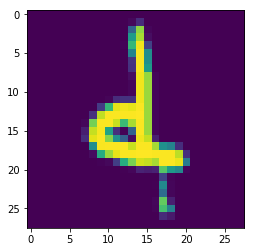

training set name:  train_d_42517.png
training set label:  d
IF measure:  -0.00639164583586

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



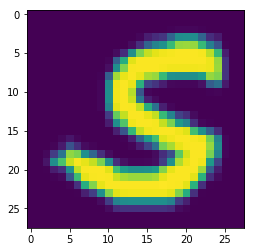

training set name:  train_S_3923.png
training set label:  S
IF measure:  1.05325936782e-10


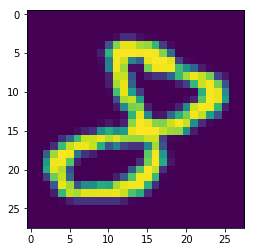

training set name:  train_8_110886.png
training set label:  8
IF measure:  -2.38522403405e-10


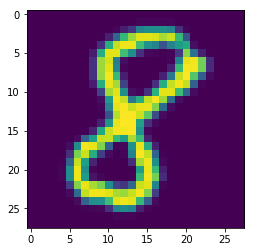

training set name:  train_8_106900.png
training set label:  8
IF measure:  2.59475290741e-10


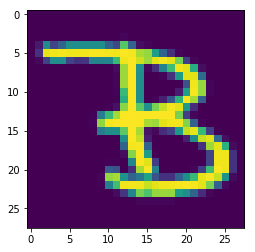

training set name:  train_B_95254.png
training set label:  B
IF measure:  2.75800075607e-10


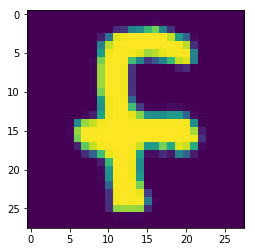

training set name:  train_f_92811.png
training set label:  3
IF measure:  -3.27695456271e-10


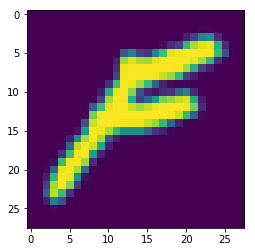

testfile name:  train_f_952.png
ground truth label:  f
network prediction:  F
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 39986.72403123316, time: 15.124987602233887 

Recursion depth: 1, norm: 73346.404881221, time: 15.294068813323975 

Recursion depth: 2, norm: 101195.9030890085, time: 15.005262851715088 

Recursion depth: 3, norm: 124445.10443565066, time: 15.131547927856445 

Recursion depth: 4, norm: 143853.79031502784, time: 15.312743186950684 

Recursion depth: 5, norm: 160056.19743077742, time: 15.08613634109497 

Recursion depth: 6, norm: 173582.6507229337, time: 15.043535947799683 

Recursion depth: 7, norm: 184874.55149911792, time: 15.217941522598267 

Recursion depth: 8, norm: 194301.53339590505, time: 15.044578075408936 

Recursion depth: 9, norm: 202171.1801419777, time: 15.063493013381958 

Recursion depth: 10, norm: 208741.06377040432, time: 15.126930475234985 

Recursion depth: 11, norm: 214225.75411934018, time: 15.0397171974

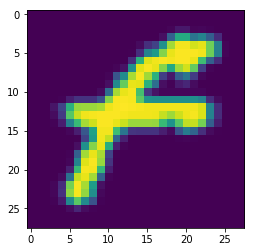

training set name:  train_F_24893.png
training set label:  F
IF measure:  0.0162950843467
train_F_24893.png


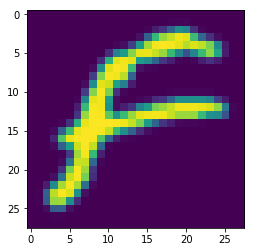

training set name:  train_F_53558.png
training set label:  F
IF measure:  0.0152608645723
train_F_53558.png


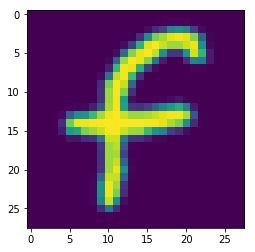

training set name:  train_F_46448.png
training set label:  F
IF measure:  0.0146850108678
train_F_46448.png


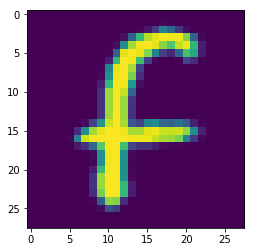

training set name:  train_F_5217.png
training set label:  F
IF measure:  0.0145425981558
train_F_5217.png


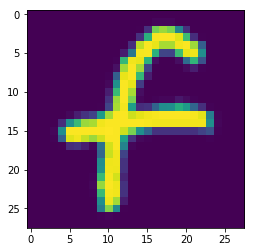

training set name:  train_F_22449.png
training set label:  F
IF measure:  0.0145403863479
train_F_22449.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



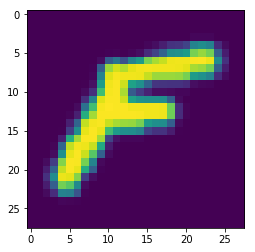

training set name:  train_F_5696.png
training set label:  f
IF measure:  -0.0259977545299
train_F_5696.png


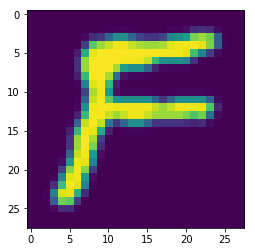

training set name:  train_f_86788.png
training set label:  f
IF measure:  -0.0217969868517
train_f_86788.png


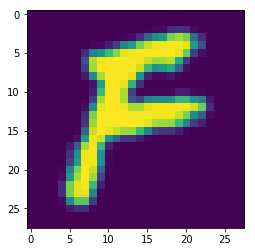

training set name:  train_f_31410.png
training set label:  f
IF measure:  -0.0217424777383
train_f_31410.png


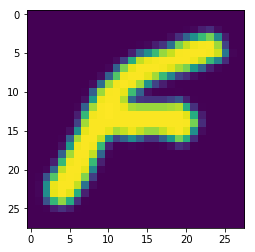

training set name:  train_f_67147.png
training set label:  f
IF measure:  -0.0217357505932
train_f_67147.png


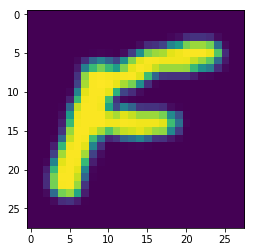

training set name:  train_f_55593.png
training set label:  f
IF measure:  -0.0197281235816
train_f_55593.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



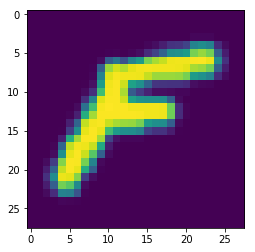

training set name:  train_F_5696.png
training set label:  f
IF measure:  -0.0259977545299


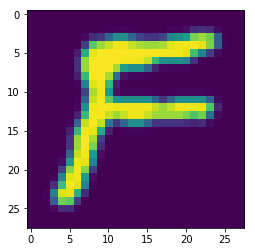

training set name:  train_f_86788.png
training set label:  f
IF measure:  -0.0217969868517


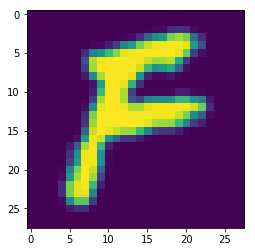

training set name:  train_f_31410.png
training set label:  f
IF measure:  -0.0217424777383


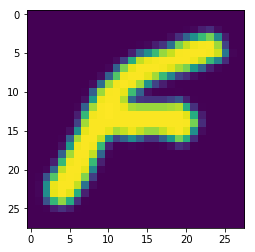

training set name:  train_f_67147.png
training set label:  f
IF measure:  -0.0217357505932


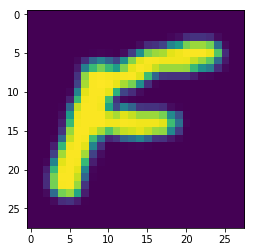

training set name:  train_f_55593.png
training set label:  f
IF measure:  -0.0197281235816

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



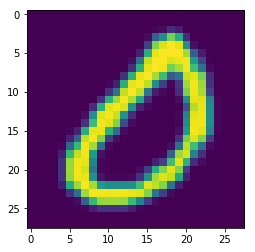

training set name:  train_0_112742.png
training set label:  0
IF measure:  2.23129366835e-11


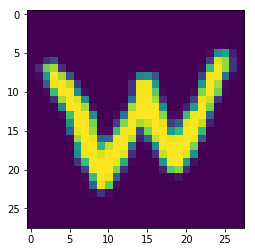

training set name:  train_W_75902.png
training set label:  W
IF measure:  -3.9762294009e-11


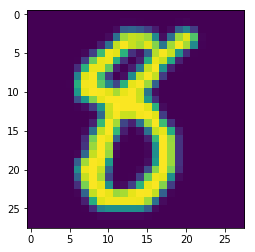

training set name:  train_8_26692.png
training set label:  8
IF measure:  -8.04667374497e-11


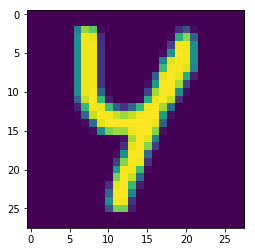

training set name:  train_Y_75961.png
training set label:  g
IF measure:  1.17983716414e-10


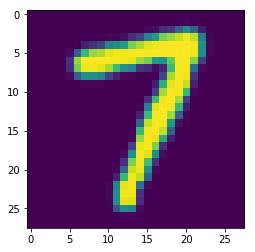

training set name:  train_7_13093.png
training set label:  7
IF measure:  -2.40984489416e-10


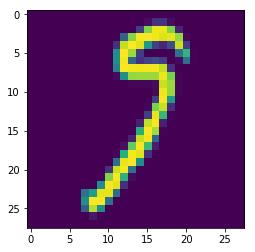

testfile name:  train_g_11056.png
ground truth label:  g
network prediction:  g
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 22656.248845517213, time: 15.123742818832397 

Recursion depth: 1, norm: 41555.90501962387, time: 15.033125400543213 

Recursion depth: 2, norm: 57333.700089912214, time: 14.96226167678833 

Recursion depth: 3, norm: 70505.51724510643, time: 15.026617765426636 

Recursion depth: 4, norm: 81501.68324642137, time: 15.083467245101929 

Recursion depth: 5, norm: 90681.42819783994, time: 15.015845537185669 

Recursion depth: 6, norm: 98344.84202031136, time: 15.122180700302124 

Recursion depth: 7, norm: 104742.2810043776, time: 15.094215869903564 

Recursion depth: 8, norm: 110082.94283857058, time: 14.99442982673645 

Recursion depth: 9, norm: 114541.48673733897, time: 15.164745330810547 

Recursion depth: 10, norm: 118263.55335436188, time: 15.047733068466187 

Recursion depth: 11, norm: 121371.03229354194, time: 15.03050971

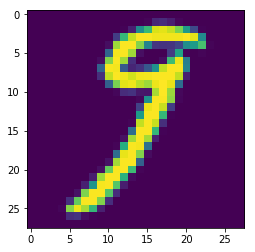

training set name:  train_9_101982.png
training set label:  9
IF measure:  0.007694629807
train_9_101982.png


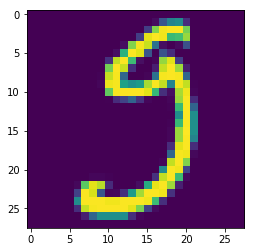

training set name:  train_g_64814.png
training set label:  V
IF measure:  0.00752125674634
train_g_64814.png


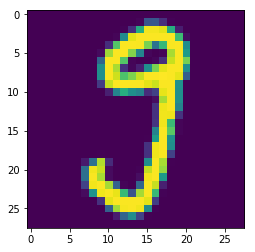

training set name:  train_g_107004.png
training set label:  G
IF measure:  0.007392972824
train_g_107004.png


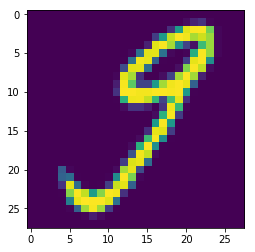

training set name:  train_g_93973.png
training set label:  K
IF measure:  0.00662532199888
train_g_93973.png


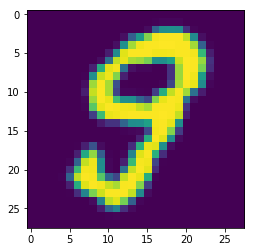

training set name:  train_g_61358.png
training set label:  X
IF measure:  0.00654175537803
train_g_61358.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



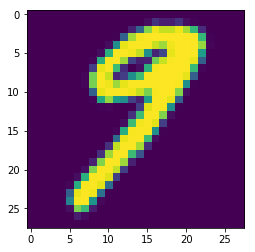

training set name:  train_g_81108.png
training set label:  g
IF measure:  -0.0110881459998
train_g_81108.png


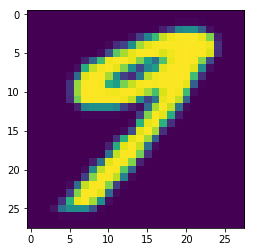

training set name:  train_g_51528.png
training set label:  g
IF measure:  -0.0106988453749
train_g_51528.png


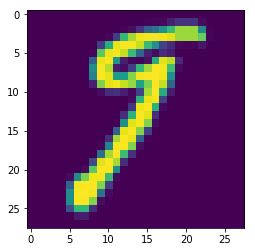

training set name:  train_g_107511.png
training set label:  g
IF measure:  -0.00997952150432
train_g_107511.png


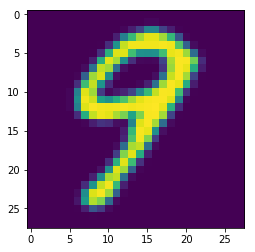

training set name:  train_g_108806.png
training set label:  g
IF measure:  -0.009876131018
train_g_108806.png


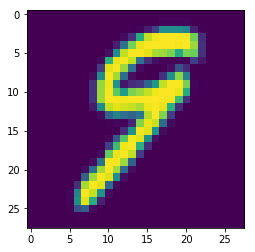

training set name:  train_g_12332.png
training set label:  g
IF measure:  -0.00970715971809
train_g_12332.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



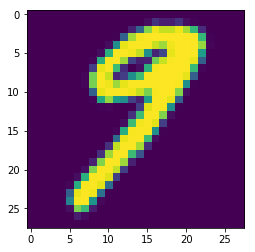

training set name:  train_g_81108.png
training set label:  g
IF measure:  -0.0110881459998


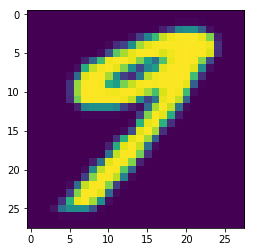

training set name:  train_g_51528.png
training set label:  g
IF measure:  -0.0106988453749


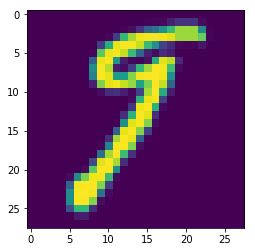

training set name:  train_g_107511.png
training set label:  g
IF measure:  -0.00997952150432


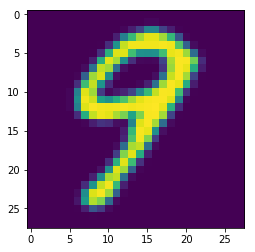

training set name:  train_g_108806.png
training set label:  g
IF measure:  -0.009876131018


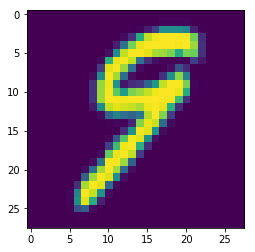

training set name:  train_g_12332.png
training set label:  g
IF measure:  -0.00970715971809

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



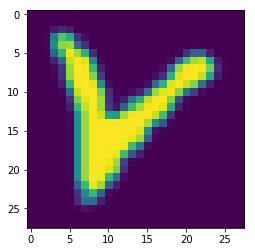

training set name:  train_V_53964.png
training set label:  V
IF measure:  -2.08448445266e-11


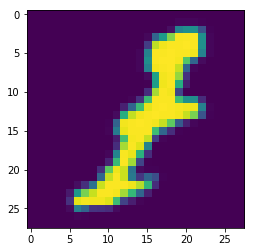

training set name:  train_E_57958.png
training set label:  D
IF measure:  2.87168114347e-11


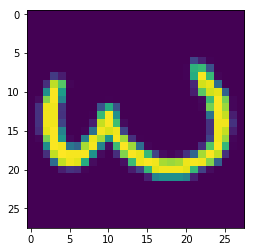

training set name:  train_W_112404.png
training set label:  W
IF measure:  3.28122789774e-10


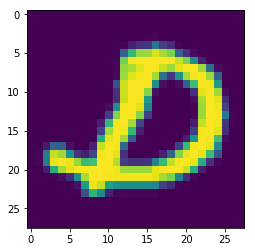

training set name:  train_D_51861.png
training set label:  D
IF measure:  -4.27595063848e-10


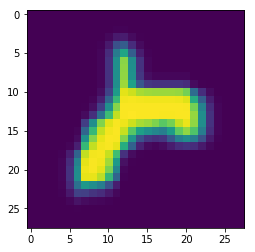

training set name:  train_r_92204.png
training set label:  r
IF measure:  4.44326218687e-10


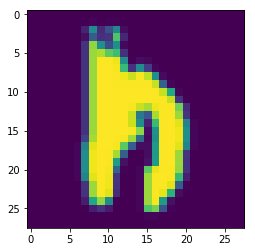

testfile name:  train_h_6101.png
ground truth label:  h
network prediction:  h
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 21388.97526472458, time: 14.844674825668335 

Recursion depth: 1, norm: 39231.26492352751, time: 15.040078163146973 

Recursion depth: 2, norm: 54126.42103446338, time: 15.153374195098877 

Recursion depth: 3, norm: 66560.93130358079, time: 15.133254766464233 

Recursion depth: 4, norm: 76941.81504227725, time: 14.910518169403076 

Recursion depth: 5, norm: 85608.12243005917, time: 15.220759630203247 

Recursion depth: 6, norm: 92842.99318742368, time: 15.415170431137085 

Recursion depth: 7, norm: 98882.67160630319, time: 15.825240135192871 

Recursion depth: 8, norm: 103924.70932362524, time: 15.20129942893982 

Recursion depth: 9, norm: 108133.97080473832, time: 15.493694543838501 

Recursion depth: 10, norm: 111647.97526153352, time: 16.05452013015747 

Recursion depth: 11, norm: 114581.56932072452, time: 15.90056681632

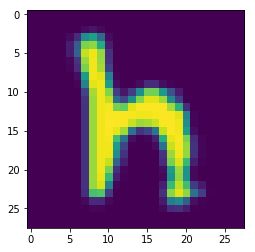

training set name:  train_h_16603.png
training set label:  O
IF measure:  0.00829091145003
train_h_16603.png


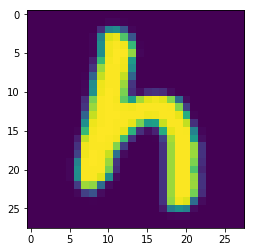

training set name:  train_h_1648.png
training set label:  H
IF measure:  0.00799097422484
train_h_1648.png


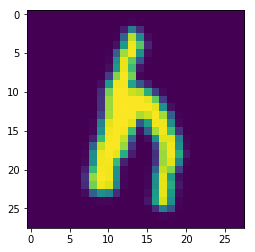

training set name:  train_h_12978.png
training set label:  W
IF measure:  0.00798522107145
train_h_12978.png


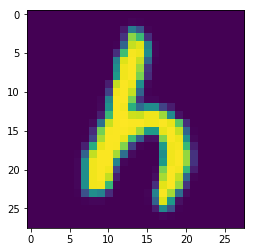

training set name:  train_h_33005.png
training set label:  5
IF measure:  0.00763235145532
train_h_33005.png


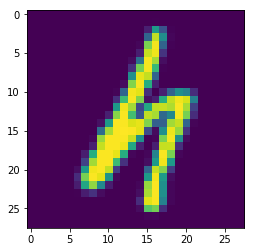

training set name:  train_h_94974.png
training set label:  2
IF measure:  0.00740406885743
train_h_94974.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



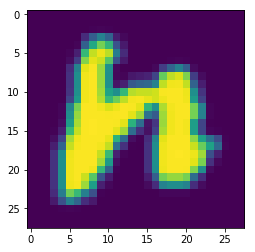

training set name:  train_h_81025.png
training set label:  h
IF measure:  -0.00705658130823
train_h_81025.png


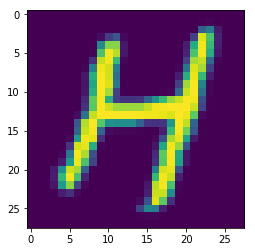

training set name:  train_h_93406.png
training set label:  h
IF measure:  -0.00667541670672
train_h_93406.png


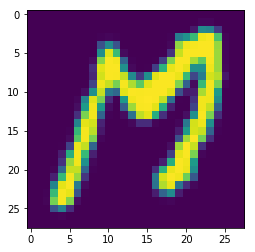

training set name:  train_M_35774.png
training set label:  h
IF measure:  -0.00663325953568
train_M_35774.png


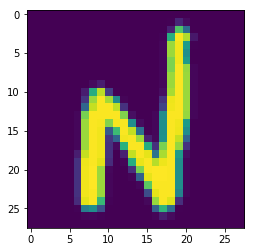

training set name:  train_N_79816.png
training set label:  h
IF measure:  -0.00661571766679
train_N_79816.png


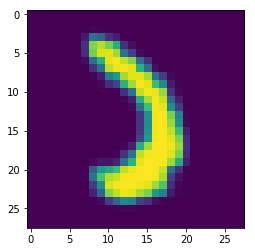

training set name:  train_J_16093.png
training set label:  h
IF measure:  -0.00646616536463
train_J_16093.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



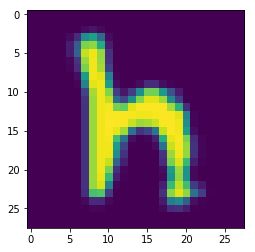

training set name:  train_h_16603.png
training set label:  O
IF measure:  0.00829091145003


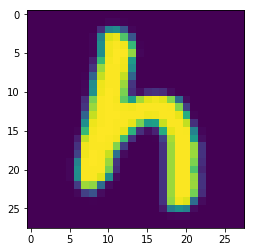

training set name:  train_h_1648.png
training set label:  H
IF measure:  0.00799097422484


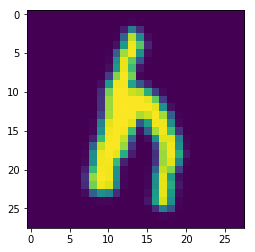

training set name:  train_h_12978.png
training set label:  W
IF measure:  0.00798522107145


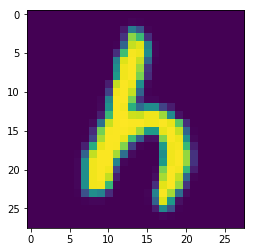

training set name:  train_h_33005.png
training set label:  5
IF measure:  0.00763235145532


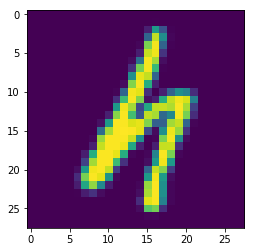

training set name:  train_h_94974.png
training set label:  2
IF measure:  0.00740406885743

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



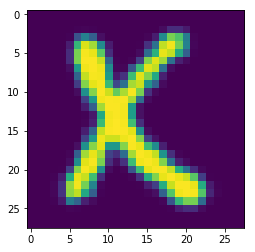

training set name:  train_X_37223.png
training set label:  4
IF measure:  -2.29328605278e-10


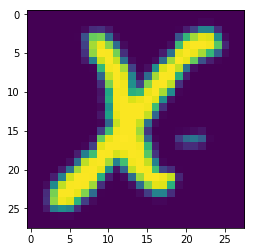

training set name:  train_X_76611.png
training set label:  X
IF measure:  -3.33959510322e-10


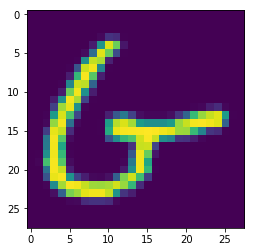

training set name:  train_G_95184.png
training set label:  G
IF measure:  3.43693532578e-10


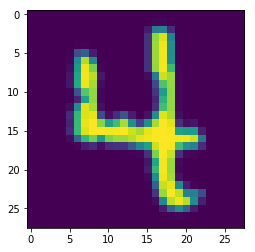

training set name:  train_4_112095.png
training set label:  4
IF measure:  -6.01479162772e-10


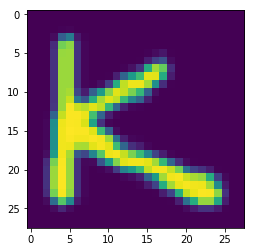

training set name:  train_K_83203.png
training set label:  K
IF measure:  -6.06464612808e-10


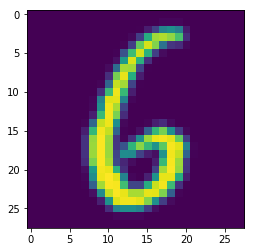

testfile name:  train_6_75714.png
ground truth label:  6
network prediction:  6
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 13540.13492362613, time: 14.886253356933594 

Recursion depth: 1, norm: 24832.48963807294, time: 14.95792531967163 

Recursion depth: 2, norm: 34260.093271910395, time: 14.90578579902649 

Recursion depth: 3, norm: 42130.54788986253, time: 14.990917921066284 

Recursion depth: 4, norm: 48700.63424638328, time: 14.961074113845825 

Recursion depth: 5, norm: 54185.601657635954, time: 14.947866678237915 

Recursion depth: 6, norm: 58764.48673306013, time: 15.107034683227539 

Recursion depth: 7, norm: 62586.770399182606, time: 15.045950889587402 

Recursion depth: 8, norm: 65777.69438799143, time: 15.119520902633667 

Recursion depth: 9, norm: 68441.61976458477, time: 14.999595403671265 

Recursion depth: 10, norm: 70665.3356321188, time: 15.03133487701416 

Recursion depth: 11, norm: 72521.75095790227, time: 15.0607192516326

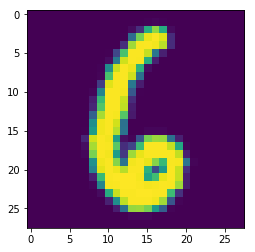

training set name:  train_6_1248.png
training set label:  b
IF measure:  0.00694598468113
train_6_1248.png


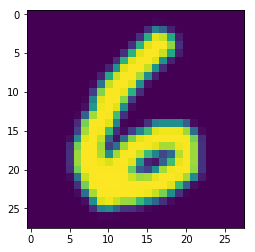

training set name:  train_6_59550.png
training set label:  G
IF measure:  0.00690687441974
train_6_59550.png


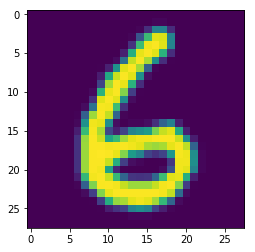

training set name:  train_6_3684.png
training set label:  h
IF measure:  0.00654713117009
train_6_3684.png


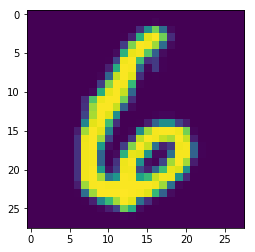

training set name:  train_6_51952.png
training set label:  K
IF measure:  0.00642959931799
train_6_51952.png


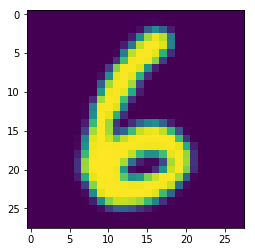

training set name:  train_6_83348.png
training set label:  M
IF measure:  0.00634413528791
train_6_83348.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



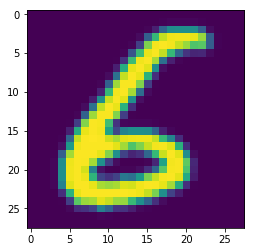

training set name:  train_6_98392.png
training set label:  6
IF measure:  -0.00570292283933
train_6_98392.png


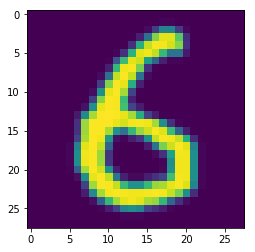

training set name:  train_6_110993.png
training set label:  6
IF measure:  -0.00549037832476
train_6_110993.png


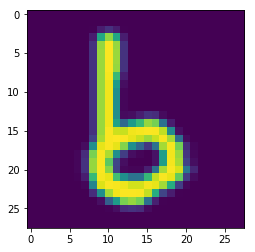

training set name:  train_6_15464.png
training set label:  6
IF measure:  -0.00546601260913
train_6_15464.png


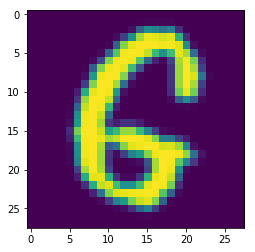

training set name:  train_G_10742.png
training set label:  6
IF measure:  -0.00545571568481
train_G_10742.png


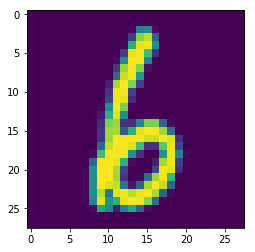

training set name:  train_6_79780.png
training set label:  6
IF measure:  -0.00539070714186
train_6_79780.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



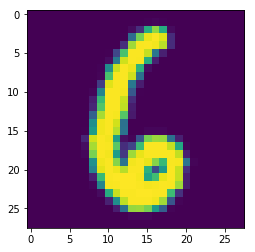

training set name:  train_6_1248.png
training set label:  b
IF measure:  0.00694598468113


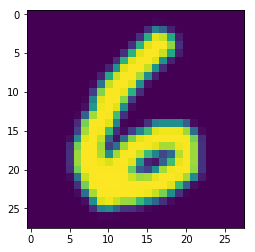

training set name:  train_6_59550.png
training set label:  G
IF measure:  0.00690687441974


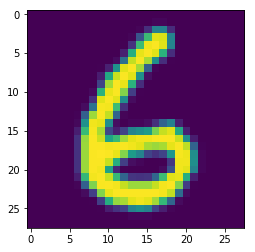

training set name:  train_6_3684.png
training set label:  h
IF measure:  0.00654713117009


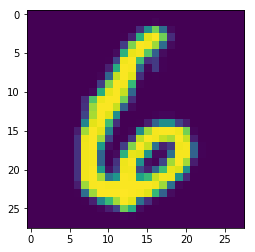

training set name:  train_6_51952.png
training set label:  K
IF measure:  0.00642959931799


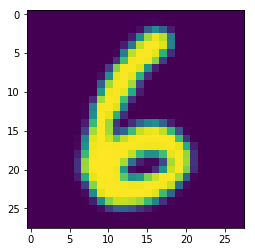

training set name:  train_6_83348.png
training set label:  M
IF measure:  0.00634413528791

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



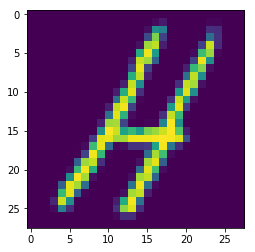

training set name:  train_H_107100.png
training set label:  H
IF measure:  -1.10998990614e-10


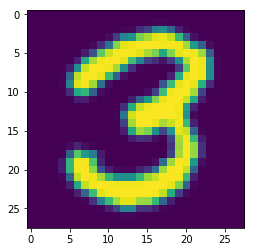

training set name:  train_3_80874.png
training set label:  3
IF measure:  2.39600735155e-10


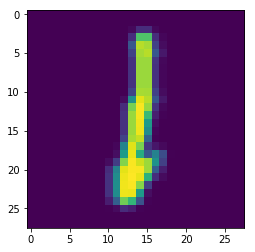

training set name:  train_L_66844.png
training set label:  L
IF measure:  3.18653401853e-10


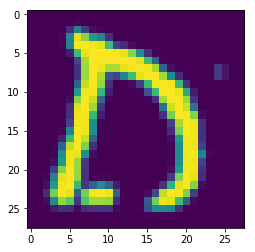

training set name:  train_D_33747.png
training set label:  A
IF measure:  3.88866715345e-10


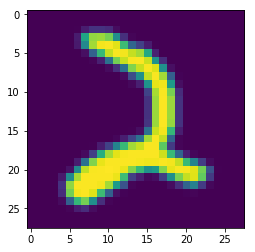

training set name:  train_2_60301.png
training set label:  2
IF measure:  -4.90172693609e-10


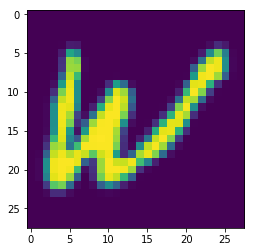

testfile name:  train_W_28889.png
ground truth label:  W
network prediction:  W
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 9770.248309600427, time: 14.869651794433594 

Recursion depth: 1, norm: 17916.21816783609, time: 15.166569948196411 

Recursion depth: 2, norm: 24716.67780568416, time: 15.052415132522583 

Recursion depth: 3, norm: 30393.753737404666, time: 14.988125085830688 

Recursion depth: 4, norm: 35133.22126207616, time: 14.944231510162354 

Recursion depth: 5, norm: 39089.596976049776, time: 14.923403978347778 

Recursion depth: 6, norm: 42392.65857433336, time: 15.065950870513916 

Recursion depth: 7, norm: 45150.137903997595, time: 14.863272905349731 

Recursion depth: 8, norm: 47451.94290279377, time: 14.946365118026733 

Recursion depth: 9, norm: 49373.52192218011, time: 14.872857093811035 

Recursion depth: 10, norm: 50977.55627724813, time: 15.005752801895142 

Recursion depth: 11, norm: 52316.61961556767, time: 14.961078405

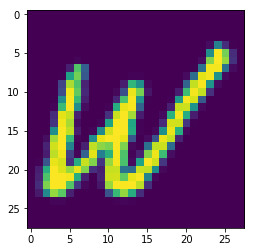

training set name:  train_W_86504.png
training set label:  q
IF measure:  0.00514626430334
train_W_86504.png


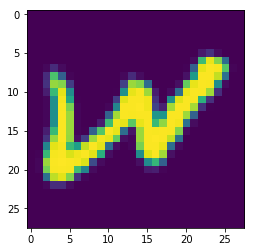

training set name:  train_W_86261.png
training set label:  V
IF measure:  0.00491527156997
train_W_86261.png


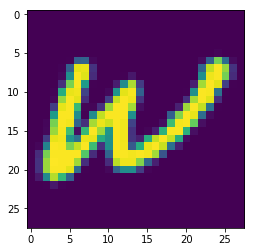

training set name:  train_W_10400.png
training set label:  C
IF measure:  0.00451819703828
train_W_10400.png


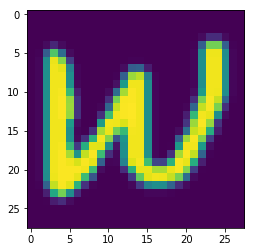

training set name:  train_W_88116.png
training set label:  n
IF measure:  0.00448065033143
train_W_88116.png


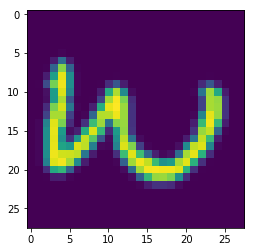

training set name:  train_W_90509.png
training set label:  q
IF measure:  0.00447732556004
train_W_90509.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



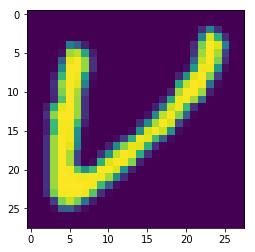

training set name:  train_V_78529.png
training set label:  W
IF measure:  -0.00411130619493
train_V_78529.png


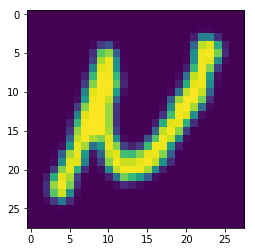

training set name:  train_N_6131.png
training set label:  W
IF measure:  -0.00382902740587
train_N_6131.png


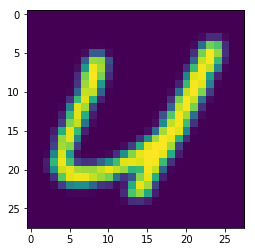

training set name:  train_U_24520.png
training set label:  W
IF measure:  -0.00382200038021
train_U_24520.png


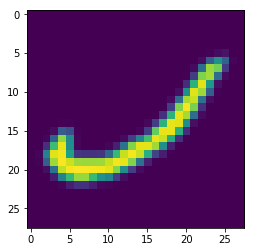

training set name:  train_J_87855.png
training set label:  W
IF measure:  -0.00340268269763
train_J_87855.png


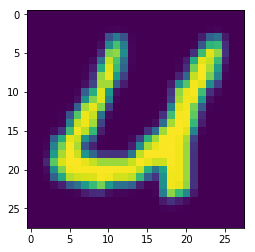

training set name:  train_U_27108.png
training set label:  W
IF measure:  -0.00339283322823
train_U_27108.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



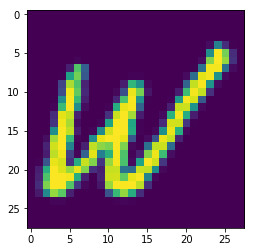

training set name:  train_W_86504.png
training set label:  q
IF measure:  0.00514626430334


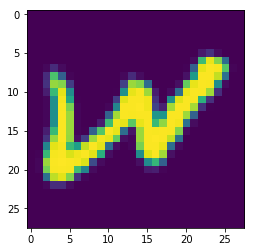

training set name:  train_W_86261.png
training set label:  V
IF measure:  0.00491527156997


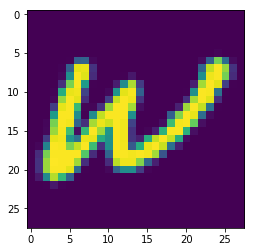

training set name:  train_W_10400.png
training set label:  C
IF measure:  0.00451819703828


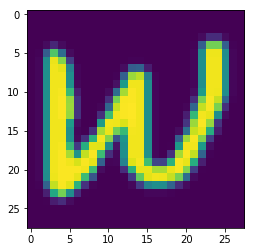

training set name:  train_W_88116.png
training set label:  n
IF measure:  0.00448065033143


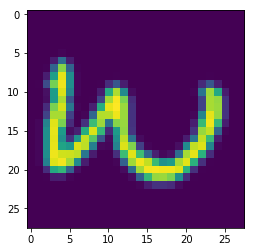

training set name:  train_W_90509.png
training set label:  q
IF measure:  0.00447732556004

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



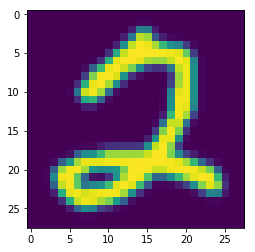

training set name:  train_2_2378.png
training set label:  2
IF measure:  -2.44370260827e-10


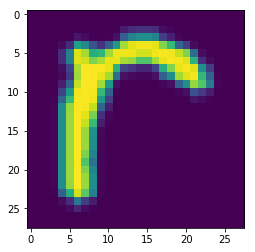

training set name:  train_r_41447.png
training set label:  r
IF measure:  -3.40354848481e-10


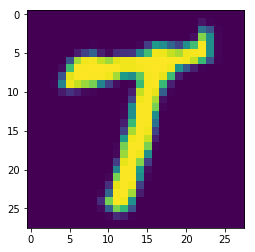

training set name:  train_T_71040.png
training set label:  T
IF measure:  6.19370084613e-10


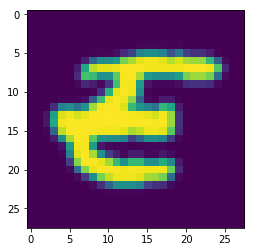

training set name:  train_E_44714.png
training set label:  E
IF measure:  -6.49541442539e-10


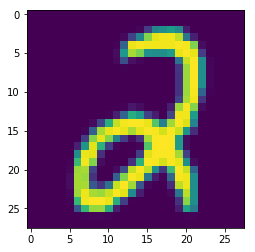

training set name:  train_2_16678.png
training set label:  2
IF measure:  7.81583624928e-10


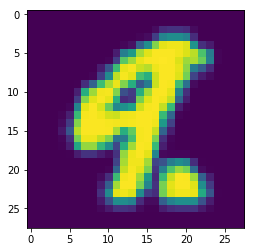

testfile name:  train_q_67554.png
ground truth label:  q
network prediction:  q
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 9262.929085034333, time: 16.4091317653656 

Recursion depth: 1, norm: 16985.71849194199, time: 16.159390687942505 

Recursion depth: 2, norm: 23432.581025145308, time: 16.854625940322876 

Recursion depth: 3, norm: 28814.696226491786, time: 16.380558013916016 

Recursion depth: 4, norm: 33307.700142009206, time: 16.595768451690674 

Recursion depth: 5, norm: 37058.56319057715, time: 16.6007137298584 

Recursion depth: 6, norm: 40189.66984188848, time: 16.223203659057617 

Recursion depth: 7, norm: 42803.73420333792, time: 16.87077522277832 

Recursion depth: 8, norm: 44985.92590744354, time: 16.589072227478027 

Recursion depth: 9, norm: 46807.48580088445, time: 16.661560535430908 

Recursion depth: 10, norm: 48328.137575329754, time: 16.73827862739563 

Recursion depth: 11, norm: 49597.580807938604, time: 16.4417455196380

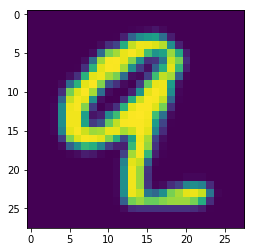

training set name:  train_q_23617.png
training set label:  W
IF measure:  0.00373484678566
train_q_23617.png


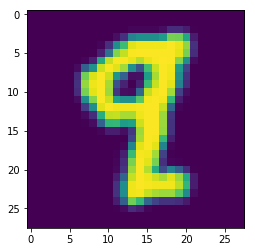

training set name:  train_q_101609.png
training set label:  R
IF measure:  0.00367033560595
train_q_101609.png


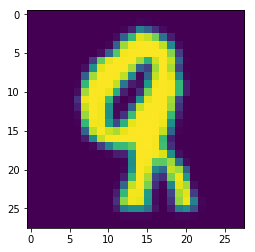

training set name:  train_g_68949.png
training set label:  g
IF measure:  0.00313471746862
train_g_68949.png


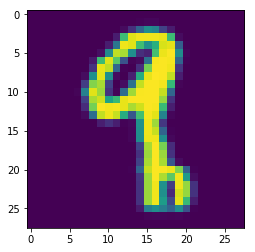

training set name:  train_q_27070.png
training set label:  L
IF measure:  0.0030765642194
train_q_27070.png


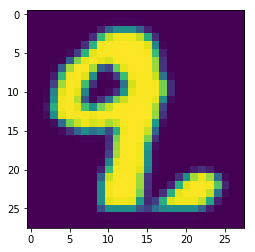

training set name:  train_q_56396.png
training set label:  R
IF measure:  0.00286303961795
train_q_56396.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



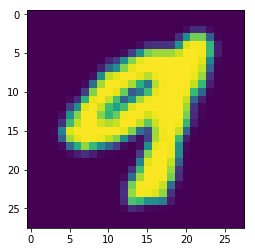

training set name:  train_q_31385.png
training set label:  q
IF measure:  -0.00334646370235
train_q_31385.png


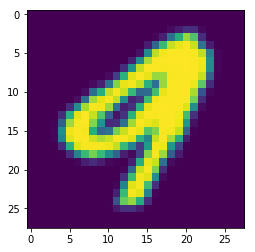

training set name:  train_q_75540.png
training set label:  q
IF measure:  -0.00314221671974
train_q_75540.png


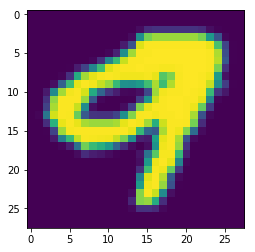

training set name:  train_q_88150.png
training set label:  q
IF measure:  -0.00310105903748
train_q_88150.png


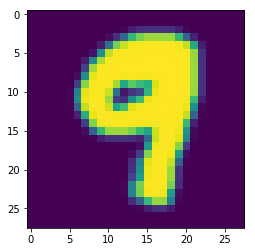

training set name:  train_q_2034.png
training set label:  q
IF measure:  -0.00297053710736
train_q_2034.png


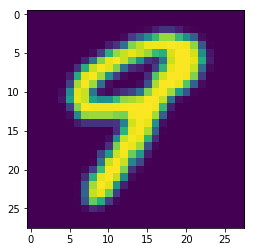

training set name:  train_q_42341.png
training set label:  q
IF measure:  -0.00296151455201
train_q_42341.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



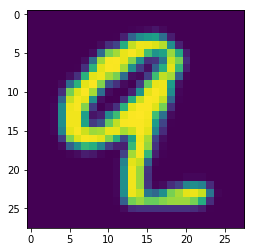

training set name:  train_q_23617.png
training set label:  W
IF measure:  0.00373484678566


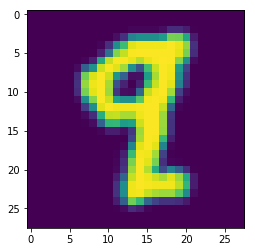

training set name:  train_q_101609.png
training set label:  R
IF measure:  0.00367033560595


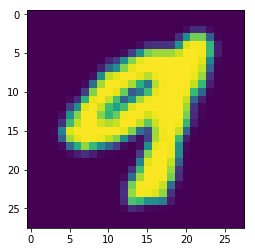

training set name:  train_q_31385.png
training set label:  q
IF measure:  -0.00334646370235


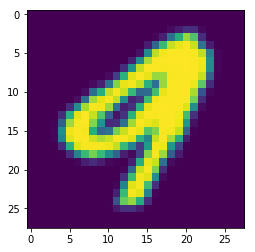

training set name:  train_q_75540.png
training set label:  q
IF measure:  -0.00314221671974


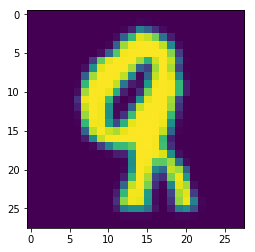

training set name:  train_g_68949.png
training set label:  g
IF measure:  0.00313471746862

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



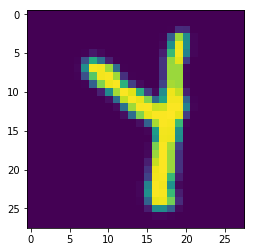

training set name:  train_Y_14323.png
training set label:  Y
IF measure:  -6.7070396518e-11


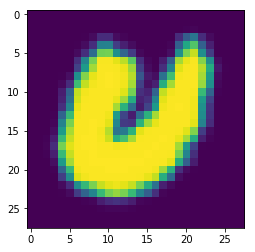

training set name:  train_U_31432.png
training set label:  U
IF measure:  7.08954345191e-11


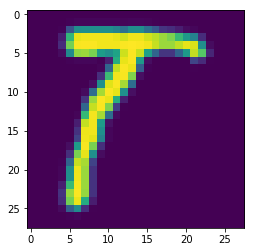

training set name:  train_T_102476.png
training set label:  T
IF measure:  -1.3731176889e-10


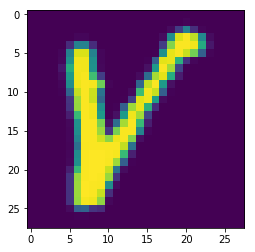

training set name:  train_V_23437.png
training set label:  Z
IF measure:  -1.57106501803e-10


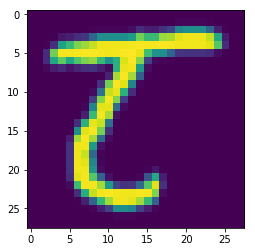

training set name:  train_t_10618.png
training set label:  t
IF measure:  4.30299359265e-10


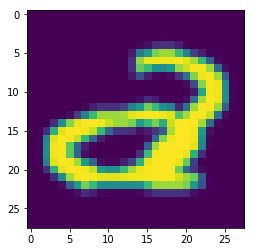

testfile name:  train_a_48806.png
ground truth label:  a
network prediction:  a
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 7330.177596330801, time: 14.934087991714478 

Recursion depth: 1, norm: 13438.592710222674, time: 15.011876344680786 

Recursion depth: 2, norm: 18537.868294554526, time: 14.914650440216064 

Recursion depth: 3, norm: 22794.855273449313, time: 15.1622896194458 

Recursion depth: 4, norm: 26348.70644002282, time: 14.977742433547974 

Recursion depth: 5, norm: 29315.492921832305, time: 14.9584801197052 

Recursion depth: 6, norm: 31792.165275032778, time: 14.957615375518799 

Recursion depth: 7, norm: 33859.76799425832, time: 15.038552522659302 

Recursion depth: 8, norm: 35585.83320121928, time: 15.076087713241577 

Recursion depth: 9, norm: 37026.69197686988, time: 15.279786109924316 

Recursion depth: 10, norm: 38229.49734334732, time: 15.006690979003906 

Recursion depth: 11, norm: 39233.58629255042, time: 14.93022966384

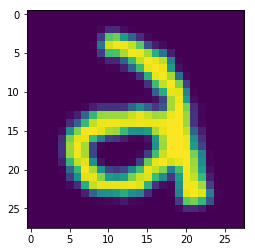

training set name:  train_a_5775.png
training set label:  Q
IF measure:  0.00288781461088
train_a_5775.png


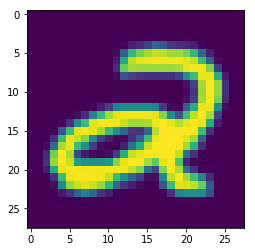

training set name:  train_a_20757.png
training set label:  b
IF measure:  0.0028139391914
train_a_20757.png


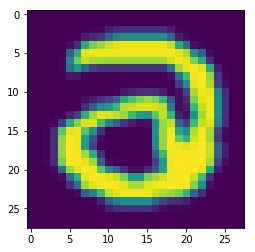

training set name:  train_a_38105.png
training set label:  7
IF measure:  0.00256148175937
train_a_38105.png


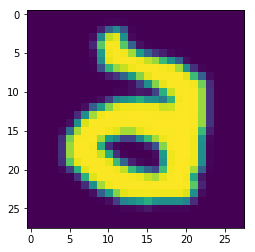

training set name:  train_a_46661.png
training set label:  X
IF measure:  0.00251599347602
train_a_46661.png


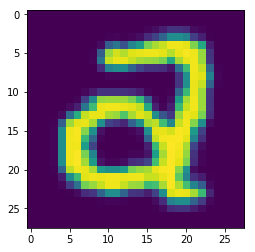

training set name:  train_a_79792.png
training set label:  9
IF measure:  0.00209528835794
train_a_79792.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



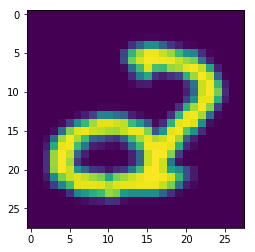

training set name:  train_a_74485.png
training set label:  a
IF measure:  -0.00368032582395
train_a_74485.png


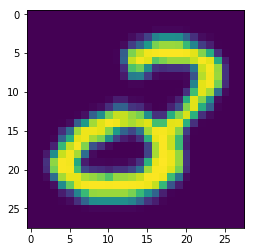

training set name:  train_a_88251.png
training set label:  a
IF measure:  -0.00293958523965
train_a_88251.png


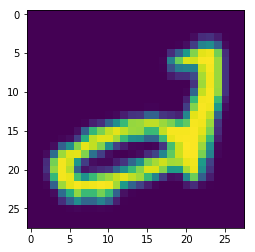

training set name:  train_a_41388.png
training set label:  a
IF measure:  -0.00285185581958
train_a_41388.png


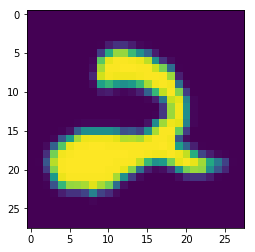

training set name:  train_2_39049.png
training set label:  a
IF measure:  -0.00268637018793
train_2_39049.png


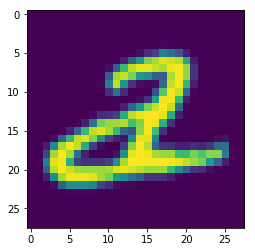

training set name:  train_a_81540.png
training set label:  a
IF measure:  -0.00262063351321
train_a_81540.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



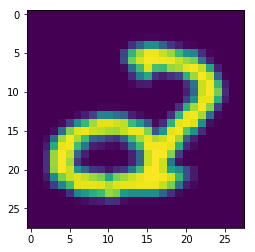

training set name:  train_a_74485.png
training set label:  a
IF measure:  -0.00368032582395


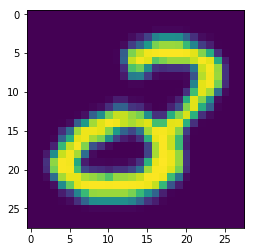

training set name:  train_a_88251.png
training set label:  a
IF measure:  -0.00293958523965


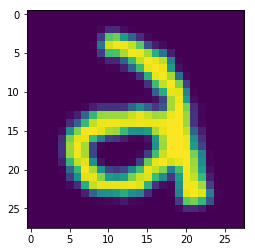

training set name:  train_a_5775.png
training set label:  Q
IF measure:  0.00288781461088


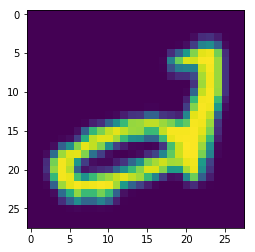

training set name:  train_a_41388.png
training set label:  a
IF measure:  -0.00285185581958


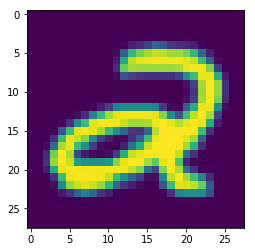

training set name:  train_a_20757.png
training set label:  b
IF measure:  0.0028139391914

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



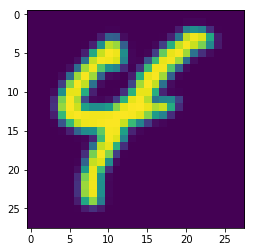

training set name:  train_4_98386.png
training set label:  4
IF measure:  -3.59863187319e-11


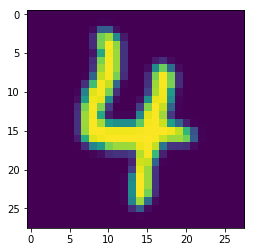

training set name:  train_4_70550.png
training set label:  4
IF measure:  -3.9374025238e-11


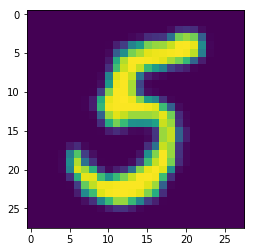

training set name:  train_5_102670.png
training set label:  5
IF measure:  6.07624299182e-11


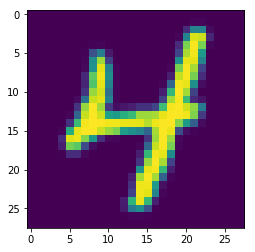

training set name:  train_4_18319.png
training set label:  4
IF measure:  -9.09081881483e-11


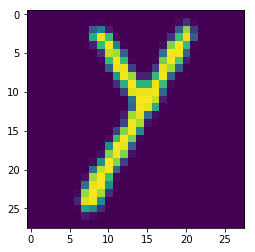

training set name:  train_Y_97876.png
training set label:  Y
IF measure:  1.08293566392e-10


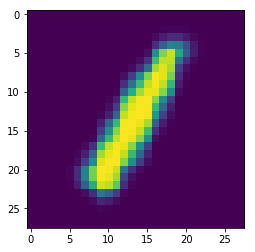

testfile name:  train_I_104736.png
ground truth label:  I
network prediction:  I
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 9170.657368068005, time: 15.00936484336853 

Recursion depth: 1, norm: 16815.65818106743, time: 14.93101978302002 

Recursion depth: 2, norm: 23197.883507984086, time: 15.1430025100708 

Recursion depth: 3, norm: 28525.901090061994, time: 15.038138151168823 

Recursion depth: 4, norm: 32973.825915413574, time: 15.126301050186157 

Recursion depth: 5, norm: 36687.057043322515, time: 15.057774543762207 

Recursion depth: 6, norm: 39786.83400950621, time: 14.845396995544434 

Recursion depth: 7, norm: 42374.573490478935, time: 15.096057653427124 

Recursion depth: 8, norm: 44534.89780497986, time: 15.039836883544922 

Recursion depth: 9, norm: 46338.32724645981, time: 15.043392419815063 

Recursion depth: 10, norm: 47843.810984285104, time: 15.062883138656616 

Recursion depth: 11, norm: 49100.79392433487, time: 14.894081115

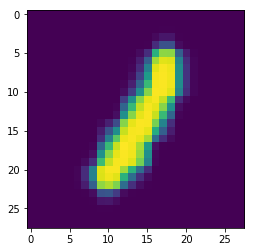

training set name:  train_L_5025.png
training set label:  L
IF measure:  0.00338100802338
train_L_5025.png


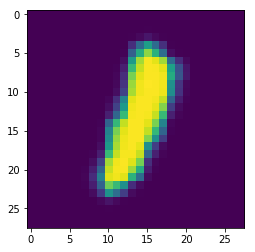

training set name:  train_L_28998.png
training set label:  L
IF measure:  0.00337250969564
train_L_28998.png


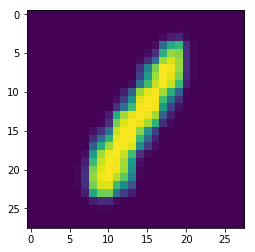

training set name:  train_I_10197.png
training set label:  B
IF measure:  0.00308517459516
train_I_10197.png


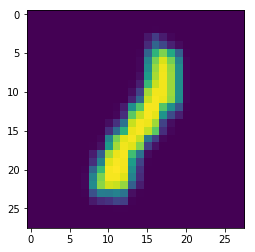

training set name:  train_L_99368.png
training set label:  L
IF measure:  0.00306814653231
train_L_99368.png


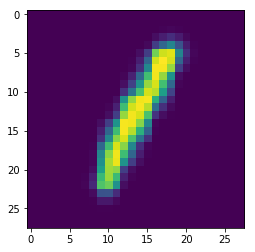

training set name:  train_1_57060.png
training set label:  1
IF measure:  0.00306617097387
train_1_57060.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



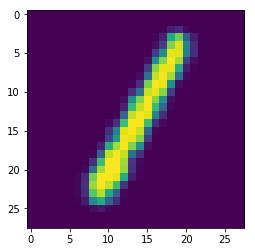

training set name:  train_I_79831.png
training set label:  I
IF measure:  -0.00519039352418
train_I_79831.png


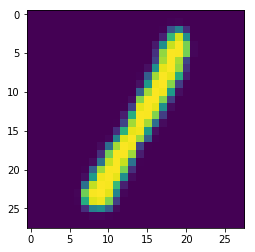

training set name:  train_1_68699.png
training set label:  I
IF measure:  -0.00430199924513
train_1_68699.png


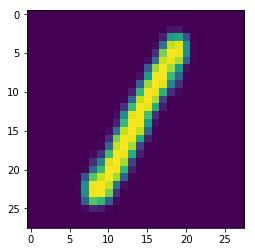

training set name:  train_1_80110.png
training set label:  I
IF measure:  -0.00428888469353
train_1_80110.png


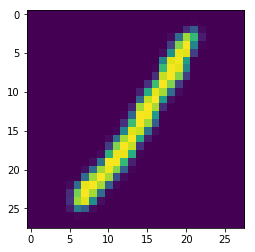

training set name:  train_L_9115.png
training set label:  I
IF measure:  -0.00427540485212
train_L_9115.png


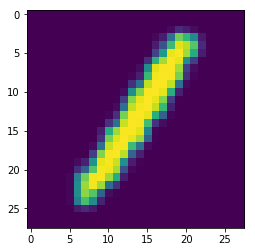

training set name:  train_I_13608.png
training set label:  I
IF measure:  -0.00418498878308
train_I_13608.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



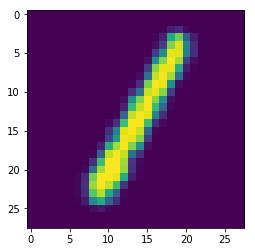

training set name:  train_I_79831.png
training set label:  I
IF measure:  -0.00519039352418


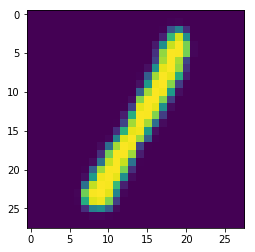

training set name:  train_1_68699.png
training set label:  I
IF measure:  -0.00430199924513


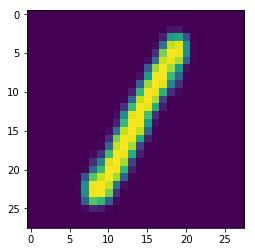

training set name:  train_1_80110.png
training set label:  I
IF measure:  -0.00428888469353


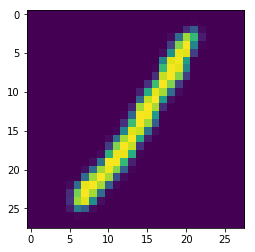

training set name:  train_L_9115.png
training set label:  I
IF measure:  -0.00427540485212


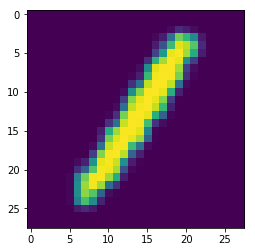

training set name:  train_I_13608.png
training set label:  I
IF measure:  -0.00418498878308

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



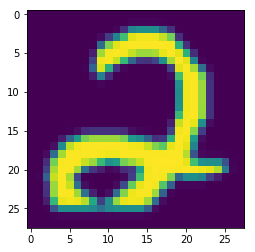

training set name:  train_2_99573.png
training set label:  2
IF measure:  8.76814069735e-11


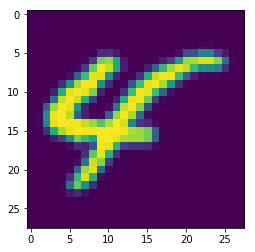

training set name:  train_4_111346.png
training set label:  4
IF measure:  1.11180889554e-10


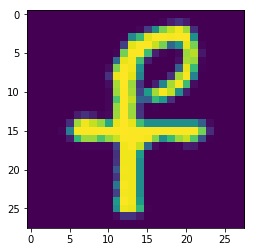

training set name:  train_F_104230.png
training set label:  F
IF measure:  1.70225156587e-10


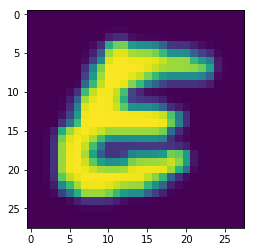

training set name:  train_E_37820.png
training set label:  E
IF measure:  2.22586733914e-10


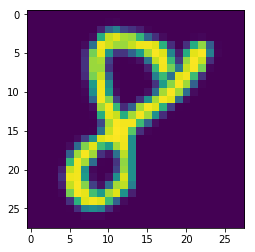

training set name:  train_8_42168.png
training set label:  8
IF measure:  -2.93708735819e-10


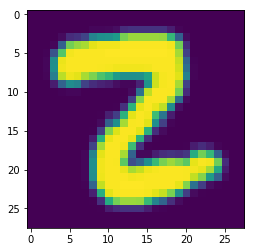

testfile name:  train_Z_54754.png
ground truth label:  Z
network prediction:  2
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 26979.380404301355, time: 17.374292612075806 

Recursion depth: 1, norm: 49486.1827988379, time: 15.180740594863892 

Recursion depth: 2, norm: 68275.1274110858, time: 15.177380084991455 

Recursion depth: 3, norm: 83960.67523549343, time: 15.213907480239868 

Recursion depth: 4, norm: 97055.16227383271, time: 15.03329586982727 

Recursion depth: 5, norm: 107986.78231154033, time: 15.156968355178833 

Recursion depth: 6, norm: 117112.84072210015, time: 16.322856426239014 

Recursion depth: 7, norm: 124731.5497618786, time: 17.782246828079224 

Recursion depth: 8, norm: 131091.85575008084, time: 20.432260990142822 

Recursion depth: 9, norm: 136401.46356986056, time: 20.43038558959961 

Recursion depth: 10, norm: 140833.94393398205, time: 20.451873302459717 

Recursion depth: 11, norm: 144534.4428432199, time: 20.6213836669

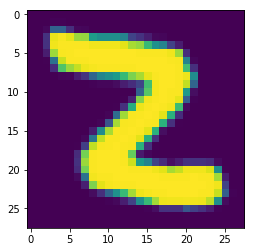

training set name:  train_Z_109846.png
training set label:  2
IF measure:  0.0170062248271
train_Z_109846.png


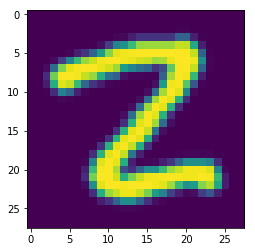

training set name:  train_2_58015.png
training set label:  2
IF measure:  0.0155002932335
train_2_58015.png


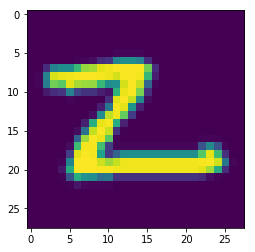

training set name:  train_Z_59193.png
training set label:  2
IF measure:  0.0115705460944
train_Z_59193.png


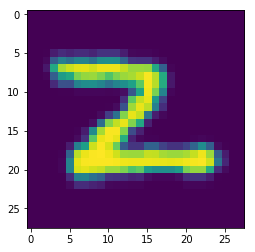

training set name:  train_Z_8000.png
training set label:  2
IF measure:  0.0109671978557
train_Z_8000.png


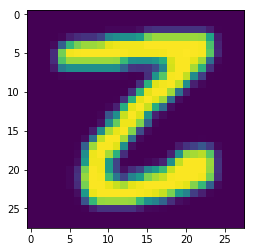

training set name:  train_2_80545.png
training set label:  2
IF measure:  0.0103795329518
train_2_80545.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



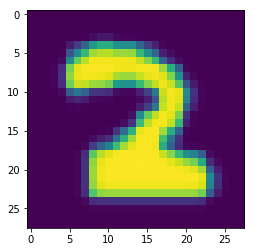

training set name:  train_Z_49610.png
training set label:  Z
IF measure:  -0.0144580265203
train_Z_49610.png


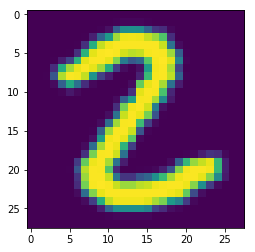

training set name:  train_Z_21556.png
training set label:  Z
IF measure:  -0.0138240787419
train_Z_21556.png


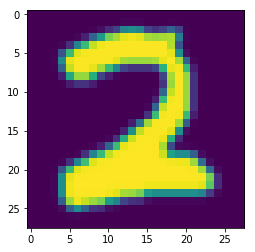

training set name:  train_Z_45072.png
training set label:  Z
IF measure:  -0.0133292724055
train_Z_45072.png


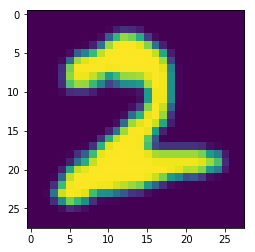

training set name:  train_Z_76510.png
training set label:  Z
IF measure:  -0.0131816117582
train_Z_76510.png


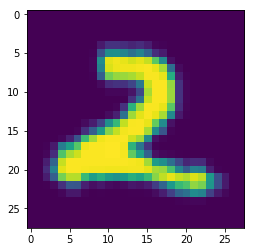

training set name:  train_Z_38771.png
training set label:  Z
IF measure:  -0.0131641106086
train_Z_38771.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



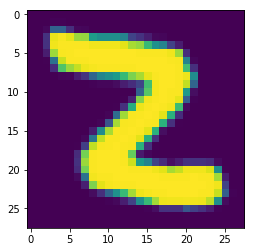

training set name:  train_Z_109846.png
training set label:  2
IF measure:  0.0170062248271


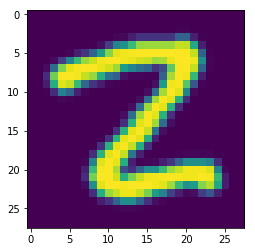

training set name:  train_2_58015.png
training set label:  2
IF measure:  0.0155002932335


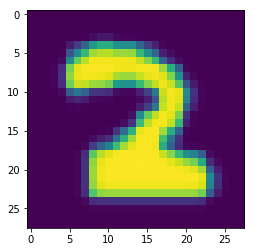

training set name:  train_Z_49610.png
training set label:  Z
IF measure:  -0.0144580265203


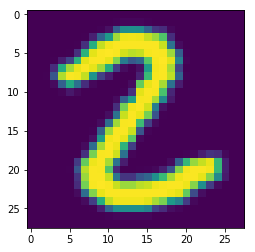

training set name:  train_Z_21556.png
training set label:  Z
IF measure:  -0.0138240787419


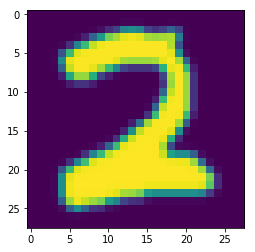

training set name:  train_Z_45072.png
training set label:  Z
IF measure:  -0.0133292724055

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



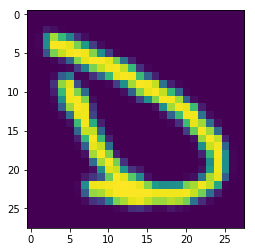

training set name:  train_D_99131.png
training set label:  D
IF measure:  -8.8277426346e-11


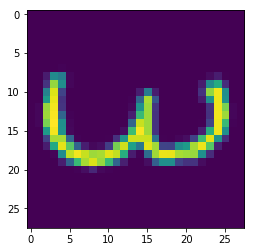

training set name:  train_W_36283.png
training set label:  W
IF measure:  9.61948679892e-11


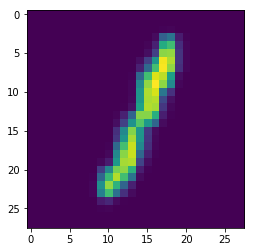

training set name:  train_L_7907.png
training set label:  L
IF measure:  5.55269091542e-10


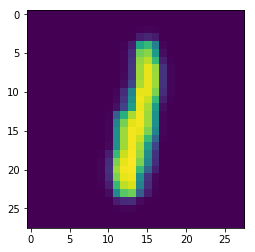

training set name:  train_I_79419.png
training set label:  I
IF measure:  7.57669719557e-10


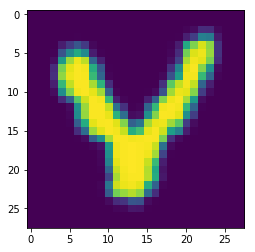

training set name:  train_V_32365.png
training set label:  V
IF measure:  7.8353807099e-10


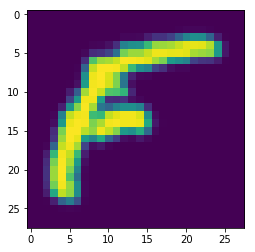

testfile name:  train_F_41402.png
ground truth label:  F
network prediction:  F
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 15442.06801646075, time: 18.21100378036499 

Recursion depth: 1, norm: 28321.49891866601, time: 18.203699827194214 

Recursion depth: 2, norm: 39073.666941432566, time: 18.30640721321106 

Recursion depth: 3, norm: 48049.73569646351, time: 18.16309952735901 

Recursion depth: 4, norm: 55543.13922529046, time: 18.46590280532837 

Recursion depth: 5, norm: 61798.75301330926, time: 18.43862771987915 

Recursion depth: 6, norm: 67021.05533338012, time: 17.84068536758423 

Recursion depth: 7, norm: 71380.71764839577, time: 18.192232608795166 

Recursion depth: 8, norm: 75020.17072094677, time: 18.11922597885132 

Recursion depth: 9, norm: 78058.59328094505, time: 18.235671043395996 

Recursion depth: 10, norm: 80594.89423034192, time: 18.289467334747314 

Recursion depth: 11, norm: 82712.41263558934, time: 18.27752375602722 

R

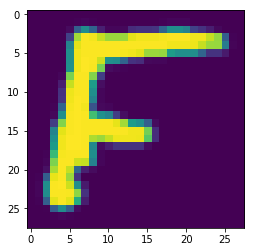

training set name:  train_f_46467.png
training set label:  E
IF measure:  0.00733742044961
train_f_46467.png


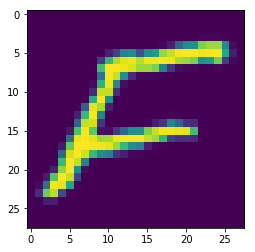

training set name:  train_F_20449.png
training set label:  U
IF measure:  0.00665674722152
train_F_20449.png


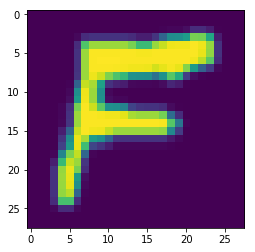

training set name:  train_f_104628.png
training set label:  f
IF measure:  0.00645510657882
train_f_104628.png


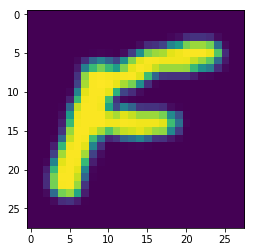

training set name:  train_f_55593.png
training set label:  f
IF measure:  0.00641822910055
train_f_55593.png


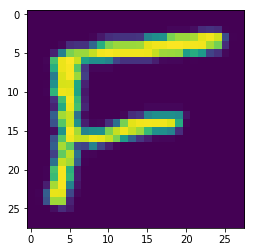

training set name:  train_F_59752.png
training set label:  O
IF measure:  0.0064156283248
train_F_59752.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



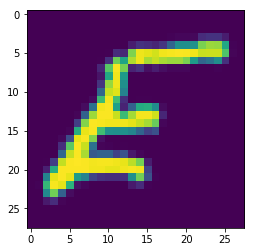

training set name:  train_E_56626.png
training set label:  F
IF measure:  -0.00634006975707
train_E_56626.png


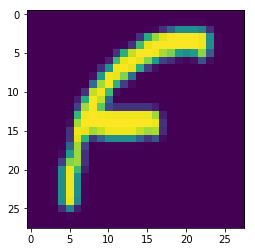

training set name:  train_F_6611.png
training set label:  F
IF measure:  -0.00573727984959
train_F_6611.png


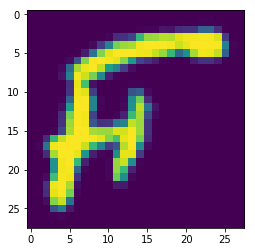

training set name:  train_F_22729.png
training set label:  F
IF measure:  -0.0056200805391
train_F_22729.png


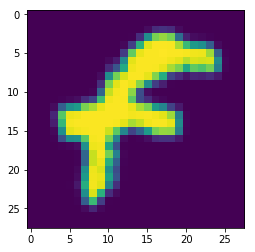

training set name:  train_F_84029.png
training set label:  F
IF measure:  -0.0055976296993
train_F_84029.png


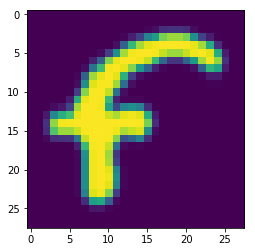

training set name:  train_F_31011.png
training set label:  F
IF measure:  -0.00552274559407
train_F_31011.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



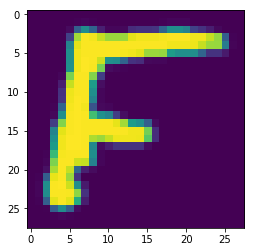

training set name:  train_f_46467.png
training set label:  E
IF measure:  0.00733742044961


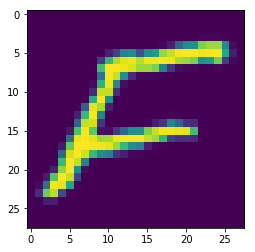

training set name:  train_F_20449.png
training set label:  U
IF measure:  0.00665674722152


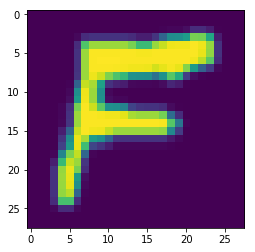

training set name:  train_f_104628.png
training set label:  f
IF measure:  0.00645510657882


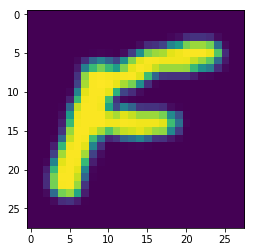

training set name:  train_f_55593.png
training set label:  f
IF measure:  0.00641822910055


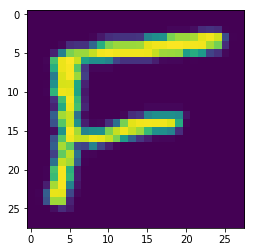

training set name:  train_F_59752.png
training set label:  O
IF measure:  0.0064156283248

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



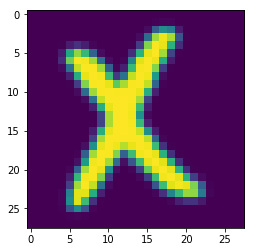

training set name:  train_X_105841.png
training set label:  X
IF measure:  -8.29623651101e-12


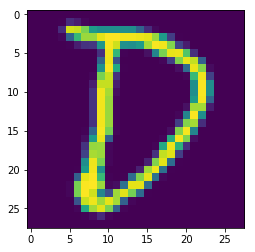

training set name:  train_D_34062.png
training set label:  D
IF measure:  -3.94759402472e-11


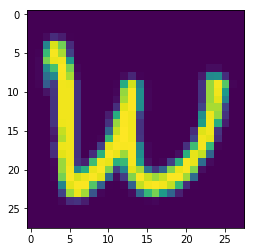

training set name:  train_W_11529.png
training set label:  W
IF measure:  -5.55346495346e-11


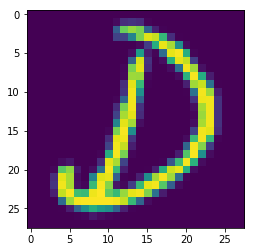

training set name:  train_D_102831.png
training set label:  D
IF measure:  -1.0048561888e-10


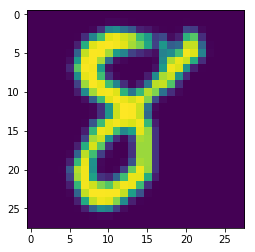

training set name:  train_8_46401.png
training set label:  8
IF measure:  -1.0829211507e-10


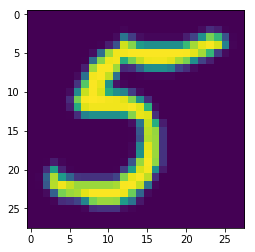

testfile name:  train_5_63087.png
ground truth label:  5
network prediction:  5
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 8093.014413726275, time: 14.885354995727539 

Recursion depth: 1, norm: 14838.830540595172, time: 14.932087898254395 

Recursion depth: 2, norm: 20470.23472783104, time: 15.234684944152832 

Recursion depth: 3, norm: 25171.404694861587, time: 15.722357273101807 

Recursion depth: 4, norm: 29096.01005185247, time: 14.952564477920532 

Recursion depth: 5, norm: 32372.33332164211, time: 15.070069789886475 

Recursion depth: 6, norm: 35107.42166907163, time: 14.957788705825806 

Recursion depth: 7, norm: 37390.876975540436, time: 15.070557355880737 

Recursion depth: 8, norm: 39297.15080320709, time: 14.96053957939148 

Recursion depth: 9, norm: 40888.51934223102, time: 15.016451120376587 

Recursion depth: 10, norm: 42216.9697589133, time: 14.87591814994812 

Recursion depth: 11, norm: 43326.073288783045, time: 14.99343132972

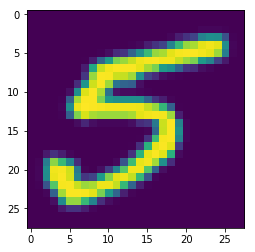

training set name:  train_5_74827.png
training set label:  d
IF measure:  0.00469317921695
train_5_74827.png


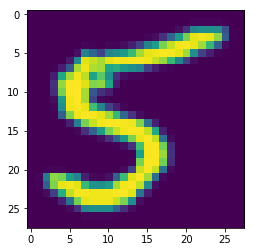

training set name:  train_5_87293.png
training set label:  a
IF measure:  0.00456408677187
train_5_87293.png


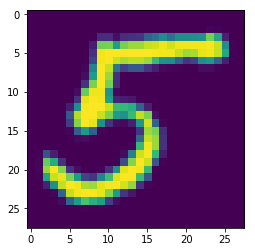

training set name:  train_5_29442.png
training set label:  6
IF measure:  0.00450441416961
train_5_29442.png


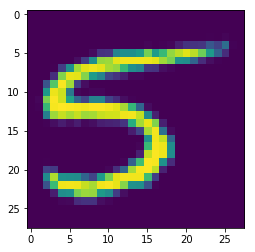

training set name:  train_5_29006.png
training set label:  G
IF measure:  0.00423934799058
train_5_29006.png


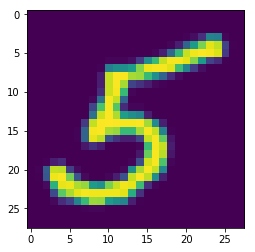

training set name:  train_5_22791.png
training set label:  F
IF measure:  0.00404839326383
train_5_22791.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



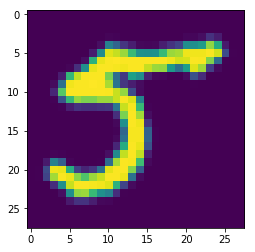

training set name:  train_5_24351.png
training set label:  5
IF measure:  -0.00391158704375
train_5_24351.png


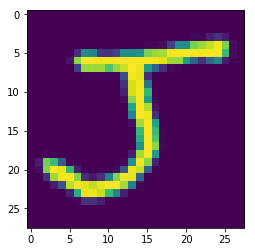

training set name:  train_J_7160.png
training set label:  5
IF measure:  -0.00348008321928
train_J_7160.png


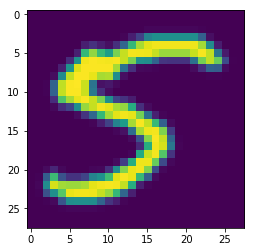

training set name:  train_5_108669.png
training set label:  5
IF measure:  -0.00345952253366
train_5_108669.png


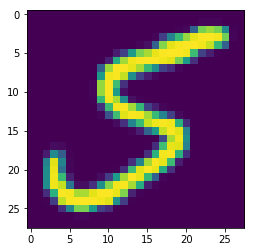

training set name:  train_5_67342.png
training set label:  5
IF measure:  -0.00343238549399
train_5_67342.png


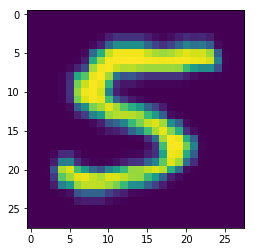

training set name:  train_5_98838.png
training set label:  5
IF measure:  -0.00310393134726
train_5_98838.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



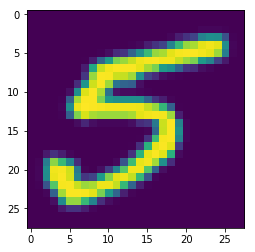

training set name:  train_5_74827.png
training set label:  d
IF measure:  0.00469317921695


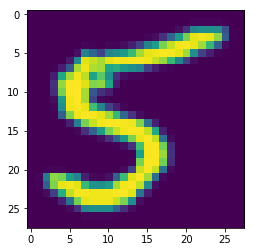

training set name:  train_5_87293.png
training set label:  a
IF measure:  0.00456408677187


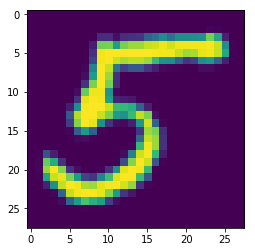

training set name:  train_5_29442.png
training set label:  6
IF measure:  0.00450441416961


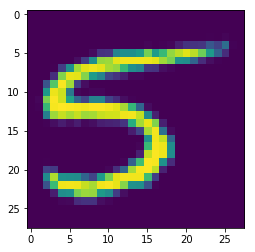

training set name:  train_5_29006.png
training set label:  G
IF measure:  0.00423934799058


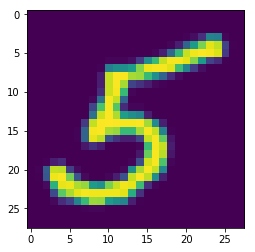

training set name:  train_5_22791.png
training set label:  F
IF measure:  0.00404839326383

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



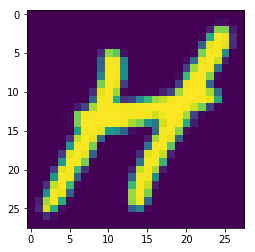

training set name:  train_H_49486.png
training set label:  H
IF measure:  2.27296271639e-11


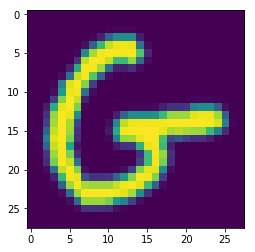

training set name:  train_G_27471.png
training set label:  G
IF measure:  -7.8214327056e-11


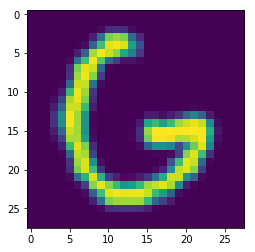

training set name:  train_G_64500.png
training set label:  G
IF measure:  -2.39871809728e-10


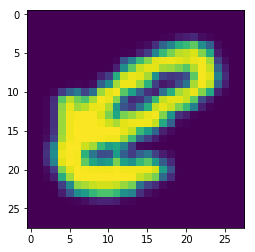

training set name:  train_e_34937.png
training set label:  e
IF measure:  -2.40210773888e-10


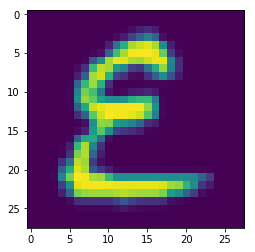

training set name:  train_E_55019.png
training set label:  h
IF measure:  2.92766989532e-10


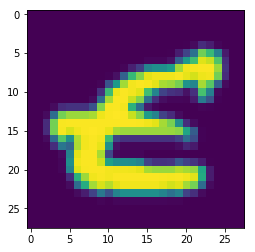

testfile name:  train_E_63405.png
ground truth label:  E
network prediction:  E
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 11067.802767910847, time: 15.022165060043335 

Recursion depth: 1, norm: 20296.869869514365, time: 15.274373292922974 

Recursion depth: 2, norm: 28001.33664220335, time: 15.683143854141235 

Recursion depth: 3, norm: 34433.15668254945, time: 15.283085107803345 

Recursion depth: 4, norm: 39802.59223028068, time: 15.004114866256714 

Recursion depth: 5, norm: 44285.23940321425, time: 15.721826553344727 

Recursion depth: 6, norm: 48027.29128318607, time: 16.418540477752686 

Recursion depth: 7, norm: 51151.47435802804, time: 15.877373456954956 

Recursion depth: 8, norm: 53759.40213116213, time: 15.141947984695435 

Recursion depth: 9, norm: 55936.58732439797, time: 15.09550952911377 

Recursion depth: 10, norm: 57754.09126633368, time: 15.065735816955566 

Recursion depth: 11, norm: 59271.39409107905, time: 15.15581107139

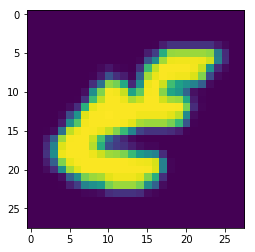

training set name:  train_E_56556.png
training set label:  S
IF measure:  0.00524769515222
train_E_56556.png


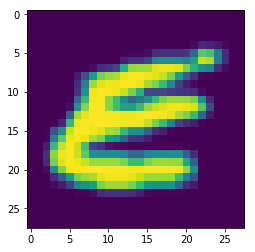

training set name:  train_E_23227.png
training set label:  t
IF measure:  0.0052356061202
train_E_23227.png


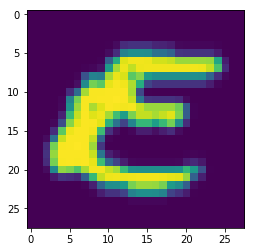

training set name:  train_E_70627.png
training set label:  R
IF measure:  0.00494012654567
train_E_70627.png


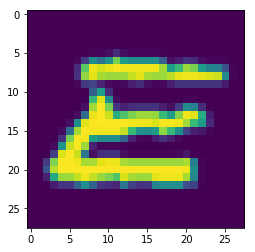

training set name:  train_E_45516.png
training set label:  7
IF measure:  0.00493242290954
train_E_45516.png


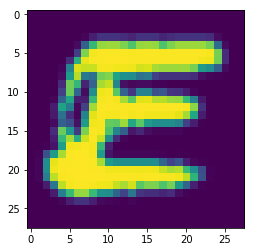

training set name:  train_E_10871.png
training set label:  K
IF measure:  0.00486619498924
train_E_10871.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



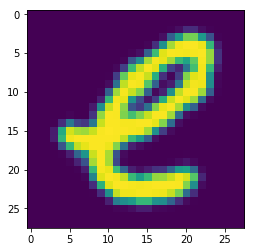

training set name:  train_e_48239.png
training set label:  E
IF measure:  -0.0046148905623
train_e_48239.png


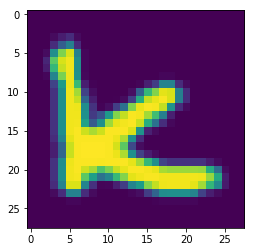

training set name:  train_K_65796.png
training set label:  E
IF measure:  -0.00456121034973
train_K_65796.png


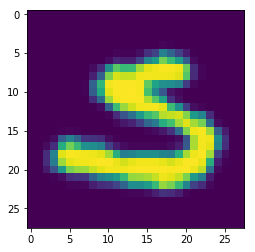

training set name:  train_S_91537.png
training set label:  E
IF measure:  -0.00454846204965
train_S_91537.png


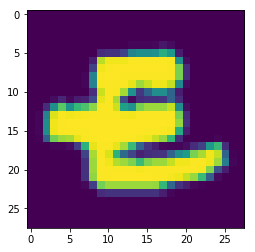

training set name:  train_E_4972.png
training set label:  E
IF measure:  -0.00427036684614
train_E_4972.png


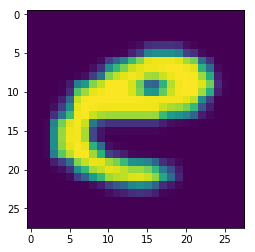

training set name:  train_e_30533.png
training set label:  E
IF measure:  -0.00413992961353
train_e_30533.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



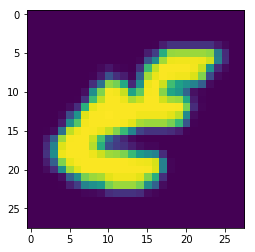

training set name:  train_E_56556.png
training set label:  S
IF measure:  0.00524769515222


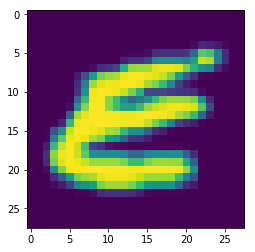

training set name:  train_E_23227.png
training set label:  t
IF measure:  0.0052356061202


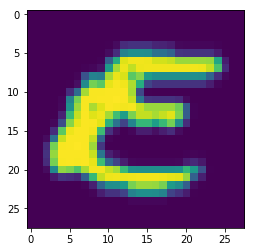

training set name:  train_E_70627.png
training set label:  R
IF measure:  0.00494012654567


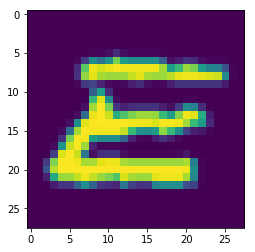

training set name:  train_E_45516.png
training set label:  7
IF measure:  0.00493242290954


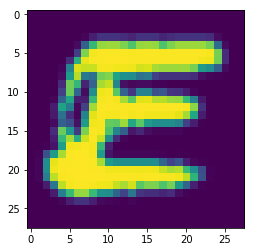

training set name:  train_E_10871.png
training set label:  K
IF measure:  0.00486619498924

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



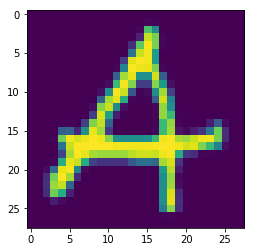

training set name:  train_A_84665.png
training set label:  A
IF measure:  1.19052695204e-11


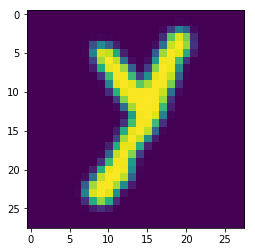

training set name:  train_Y_42207.png
training set label:  Y
IF measure:  1.18871602553e-10


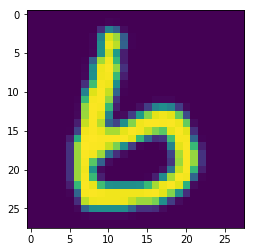

training set name:  train_b_79557.png
training set label:  b
IF measure:  1.63067884806e-10


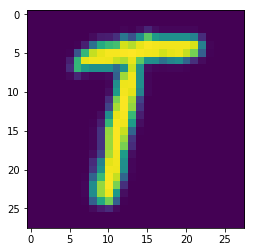

training set name:  train_T_103761.png
training set label:  T
IF measure:  -1.82346592357e-10


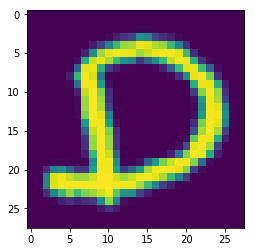

training set name:  train_D_44472.png
training set label:  r
IF measure:  2.5922276083e-10


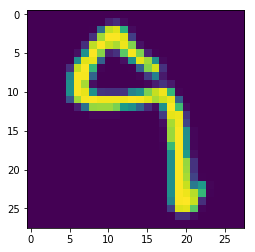

testfile name:  train_9_71069.png
ground truth label:  9
network prediction:  9
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 20273.961118575226, time: 14.943584680557251 

Recursion depth: 1, norm: 37185.64370493, time: 15.064533710479736 

Recursion depth: 2, norm: 51303.78896826237, time: 15.605666160583496 

Recursion depth: 3, norm: 63090.191198790955, time: 15.785013198852539 

Recursion depth: 4, norm: 72929.63746653346, time: 15.31128978729248 

Recursion depth: 5, norm: 81143.84745623048, time: 14.88366985321045 

Recursion depth: 6, norm: 88000.98532402918, time: 15.110530138015747 

Recursion depth: 7, norm: 93725.66718887628, time: 15.01275110244751 

Recursion depth: 8, norm: 98504.85604273528, time: 15.024343013763428 

Recursion depth: 9, norm: 102494.6468455792, time: 15.095784187316895 

Recursion depth: 10, norm: 105825.47680969833, time: 14.964266538619995 

Recursion depth: 11, norm: 108606.00903264976, time: 14.99843430519104

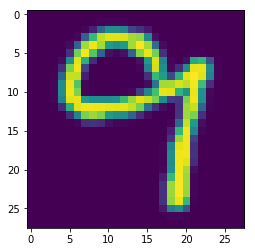

training set name:  train_g_90228.png
training set label:  g
IF measure:  0.0110721320442
train_g_90228.png


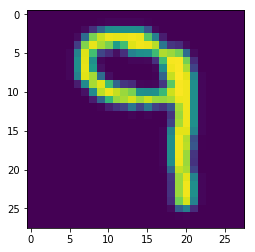

training set name:  train_g_56167.png
training set label:  g
IF measure:  0.0106704314444
train_g_56167.png


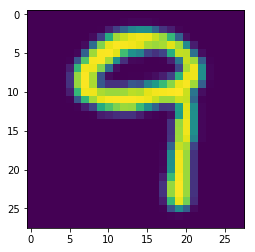

training set name:  train_9_49787.png
training set label:  q
IF measure:  0.0104411351501
train_9_49787.png


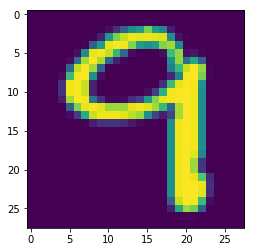

training set name:  train_q_43414.png
training set label:  q
IF measure:  0.00969650357011
train_q_43414.png


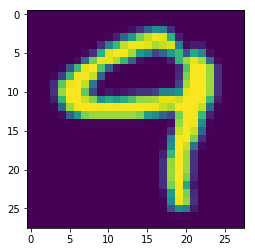

training set name:  train_q_16402.png
training set label:  q
IF measure:  0.00942622161081
train_q_16402.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



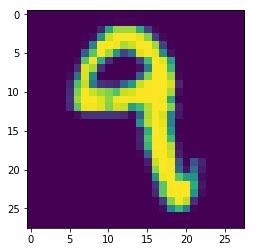

training set name:  train_9_77324.png
training set label:  9
IF measure:  -0.00997215547989
train_9_77324.png


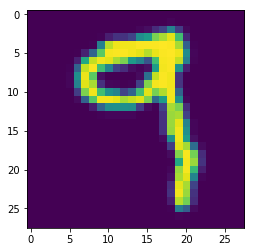

training set name:  train_9_58145.png
training set label:  9
IF measure:  -0.00760287769826
train_9_58145.png


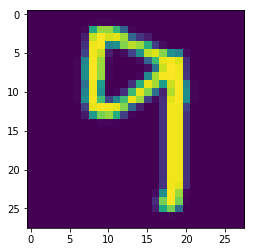

training set name:  train_9_7711.png
training set label:  9
IF measure:  -0.00746751179826
train_9_7711.png


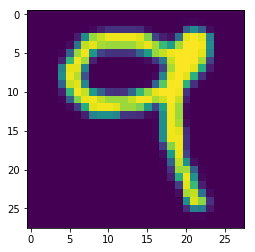

training set name:  train_9_95810.png
training set label:  9
IF measure:  -0.00742963051542
train_9_95810.png


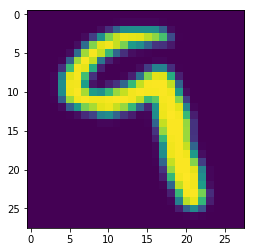

training set name:  train_9_100785.png
training set label:  9
IF measure:  -0.00735414774547
train_9_100785.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



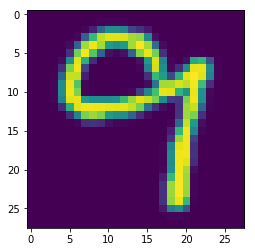

training set name:  train_g_90228.png
training set label:  g
IF measure:  0.0110721320442


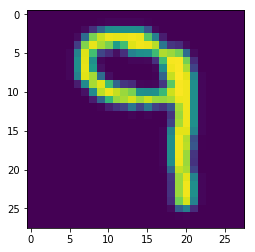

training set name:  train_g_56167.png
training set label:  g
IF measure:  0.0106704314444


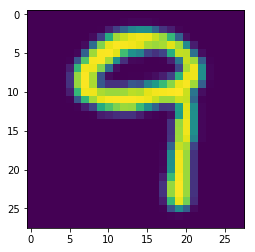

training set name:  train_9_49787.png
training set label:  q
IF measure:  0.0104411351501


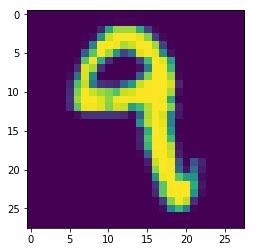

training set name:  train_9_77324.png
training set label:  9
IF measure:  -0.00997215547989


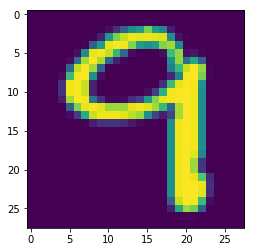

training set name:  train_q_43414.png
training set label:  q
IF measure:  0.00969650357011

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



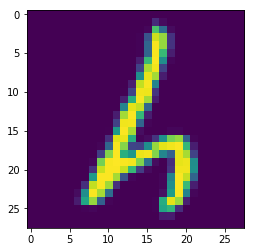

training set name:  train_h_111889.png
training set label:  h
IF measure:  1.51066424933e-11


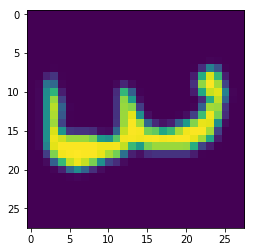

training set name:  train_W_4809.png
training set label:  W
IF measure:  6.62112142891e-11


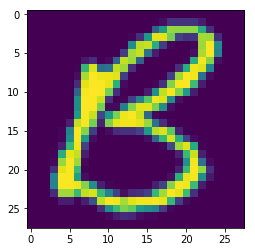

training set name:  train_B_29214.png
training set label:  B
IF measure:  1.96900120164e-10


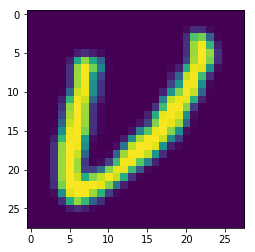

training set name:  train_V_69355.png
training set label:  V
IF measure:  5.6983503621e-10


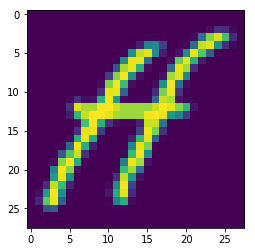

training set name:  train_H_40086.png
training set label:  H
IF measure:  9.42721574878e-10


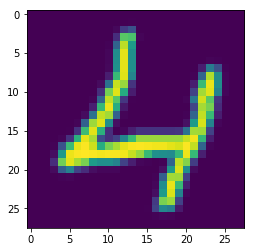

testfile name:  train_4_33293.png
ground truth label:  4
network prediction:  4
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 23393.725472869857, time: 14.849430084228516 

Recursion depth: 1, norm: 42908.42141118687, time: 14.960221529006958 

Recursion depth: 2, norm: 59199.50021748494, time: 15.352446794509888 

Recursion depth: 3, norm: 72799.96283652898, time: 15.362097024917603 

Recursion depth: 4, norm: 84154.08146964709, time: 15.279942750930786 

Recursion depth: 5, norm: 93632.50233759642, time: 15.36116075515747 

Recursion depth: 6, norm: 101545.41254039988, time: 15.430805683135986 

Recursion depth: 7, norm: 108151.31386164478, time: 15.260411262512207 

Recursion depth: 8, norm: 113666.1222352553, time: 15.126655101776123 

Recursion depth: 9, norm: 118270.36394634118, time: 14.988149642944336 

Recursion depth: 10, norm: 122114.06241706973, time: 15.361909627914429 

Recursion depth: 11, norm: 125322.62992771895, time: 15.0430898

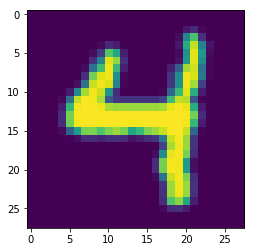

training set name:  train_4_96112.png
training set label:  H
IF measure:  0.00812351179461
train_4_96112.png


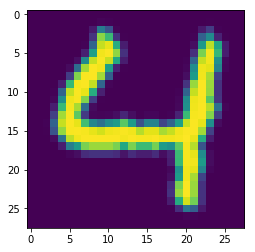

training set name:  train_4_78556.png
training set label:  M
IF measure:  0.00679862558419
train_4_78556.png


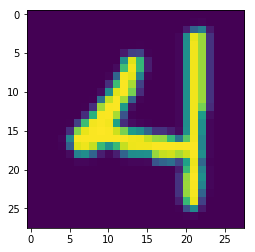

training set name:  train_4_53361.png
training set label:  6
IF measure:  0.0067151886193
train_4_53361.png


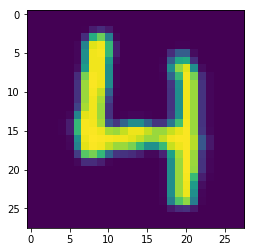

training set name:  train_4_65931.png
training set label:  1
IF measure:  0.00668667493031
train_4_65931.png


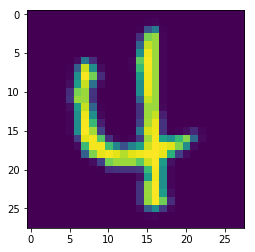

training set name:  train_4_82286.png
training set label:  B
IF measure:  0.00652755227812
train_4_82286.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



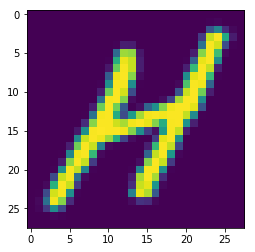

training set name:  train_H_90705.png
training set label:  4
IF measure:  -0.0099051862321
train_H_90705.png


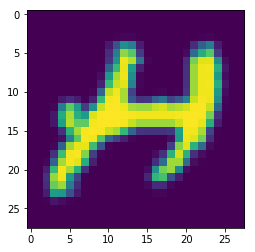

training set name:  train_H_82872.png
training set label:  4
IF measure:  -0.00884189074132
train_H_82872.png


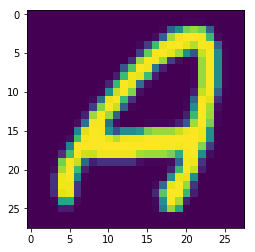

training set name:  train_A_65579.png
training set label:  4
IF measure:  -0.00873513136667
train_A_65579.png


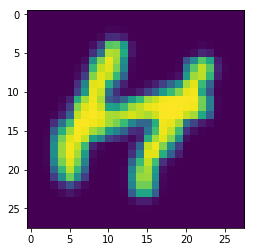

training set name:  train_H_67761.png
training set label:  4
IF measure:  -0.00856674390693
train_H_67761.png


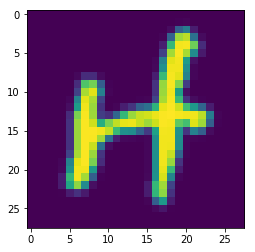

training set name:  train_4_82375.png
training set label:  4
IF measure:  -0.00855956200167
train_4_82375.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



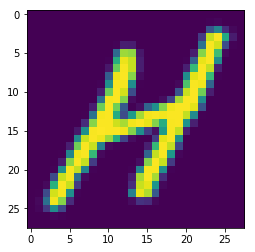

training set name:  train_H_90705.png
training set label:  4
IF measure:  -0.0099051862321


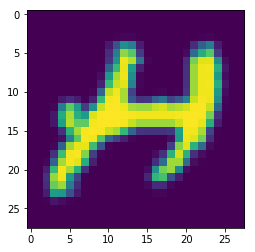

training set name:  train_H_82872.png
training set label:  4
IF measure:  -0.00884189074132


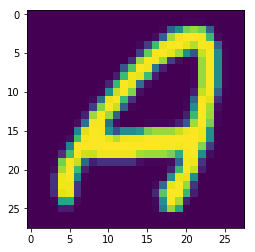

training set name:  train_A_65579.png
training set label:  4
IF measure:  -0.00873513136667


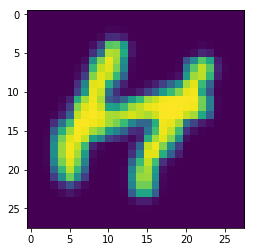

training set name:  train_H_67761.png
training set label:  4
IF measure:  -0.00856674390693


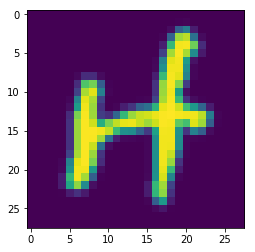

training set name:  train_4_82375.png
training set label:  4
IF measure:  -0.00855956200167

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



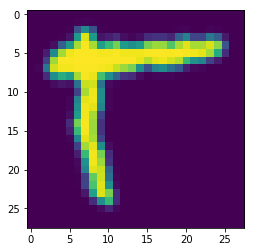

training set name:  train_T_92858.png
training set label:  T
IF measure:  9.46700130424e-11


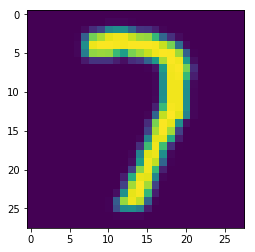

training set name:  train_7_29042.png
training set label:  7
IF measure:  -9.54361494481e-11


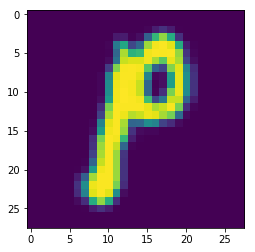

training set name:  train_P_20276.png
training set label:  P
IF measure:  3.96338440082e-10


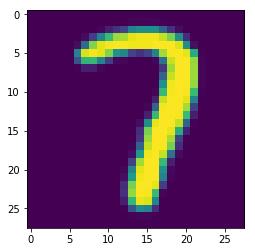

training set name:  train_7_100576.png
training set label:  7
IF measure:  5.62414752752e-10


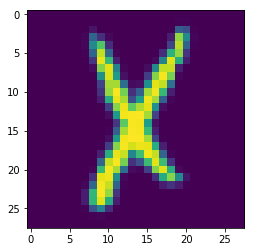

training set name:  train_X_98514.png
training set label:  X
IF measure:  -8.25955355804e-10


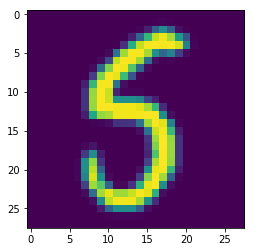

testfile name:  train_S_55325.png
ground truth label:  S
network prediction:  5
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 27495.573880172058, time: 15.034706592559814 

Recursion depth: 1, norm: 50432.86974781427, time: 15.229928493499756 

Recursion depth: 2, norm: 69581.5661795565, time: 15.858336448669434 

Recursion depth: 3, norm: 85567.16131787942, time: 15.804661512374878 

Recursion depth: 4, norm: 98912.37539357752, time: 15.503296613693237 

Recursion depth: 5, norm: 110053.25644432336, time: 15.772765636444092 

Recursion depth: 6, norm: 119353.82434593371, time: 15.426396369934082 

Recursion depth: 7, norm: 127118.1655783311, time: 15.582542181015015 

Recursion depth: 8, norm: 133599.86965562505, time: 16.6626935005188 

Recursion depth: 9, norm: 139011.03338943998, time: 16.48912024497986 

Recursion depth: 10, norm: 143528.44767501668, time: 16.1139874458313 

Recursion depth: 11, norm: 147299.63014210184, time: 17.23564076423

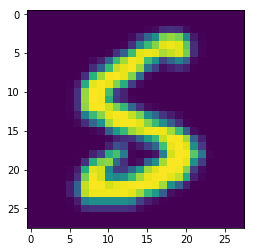

training set name:  train_S_110436.png
training set label:  g
IF measure:  0.0140462243282
train_S_110436.png


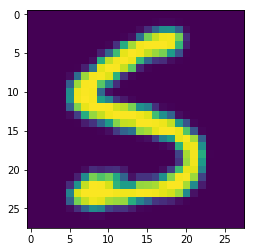

training set name:  train_S_30105.png
training set label:  g
IF measure:  0.0132594145676
train_S_30105.png


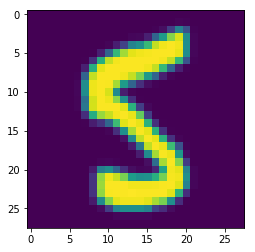

training set name:  train_5_85619.png
training set label:  5
IF measure:  0.0130640921018
train_5_85619.png


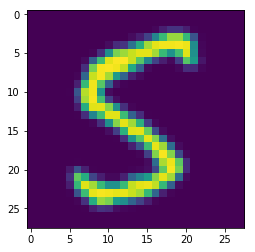

training set name:  train_5_5099.png
training set label:  5
IF measure:  0.0125250543686
train_5_5099.png


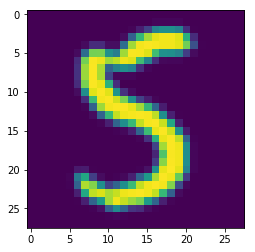

training set name:  train_5_14748.png
training set label:  5
IF measure:  0.0125051487845
train_5_14748.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



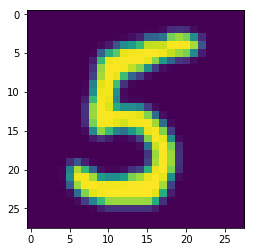

training set name:  train_5_23186.png
training set label:  S
IF measure:  -0.0136384259407
train_5_23186.png


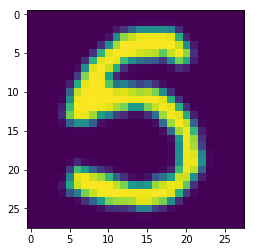

training set name:  train_S_38064.png
training set label:  S
IF measure:  -0.0110153039085
train_S_38064.png


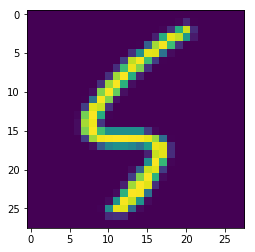

training set name:  train_S_107250.png
training set label:  S
IF measure:  -0.0107164709915
train_S_107250.png


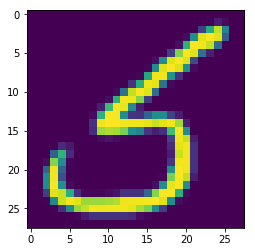

training set name:  train_S_108450.png
training set label:  S
IF measure:  -0.0104787695704
train_S_108450.png


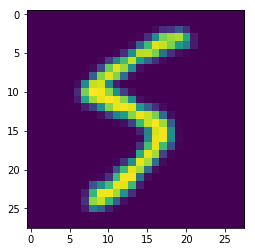

training set name:  train_S_6085.png
training set label:  S
IF measure:  -0.0104477475615
train_S_6085.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



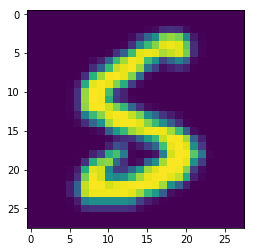

training set name:  train_S_110436.png
training set label:  g
IF measure:  0.0140462243282


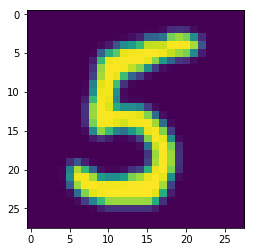

training set name:  train_5_23186.png
training set label:  S
IF measure:  -0.0136384259407


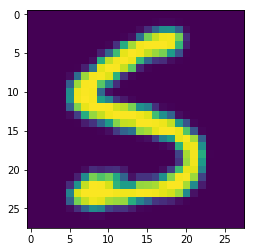

training set name:  train_S_30105.png
training set label:  g
IF measure:  0.0132594145676


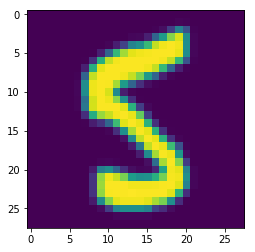

training set name:  train_5_85619.png
training set label:  5
IF measure:  0.0130640921018


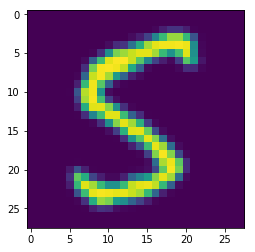

training set name:  train_5_5099.png
training set label:  5
IF measure:  0.0125250543686

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



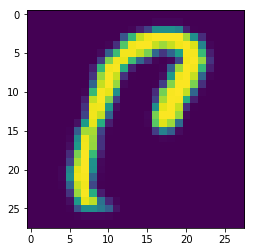

training set name:  train_C_12573.png
training set label:  C
IF measure:  5.81810372299e-10


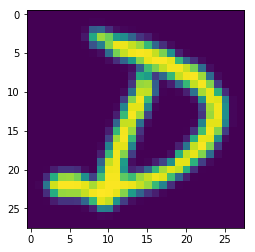

training set name:  train_D_62834.png
training set label:  D
IF measure:  -6.77365530096e-10


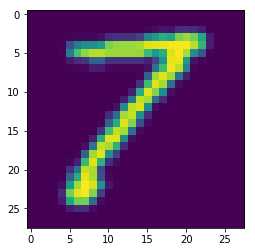

training set name:  train_7_25809.png
training set label:  7
IF measure:  8.48361822085e-10


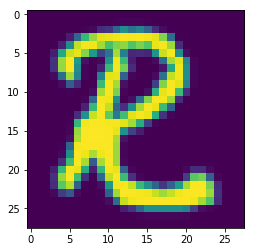

training set name:  train_R_92485.png
training set label:  R
IF measure:  9.46552418164e-10


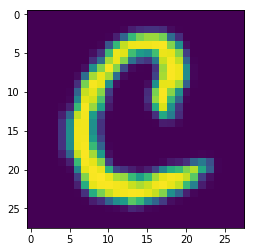

training set name:  train_C_562.png
training set label:  C
IF measure:  -1.27380175438e-09


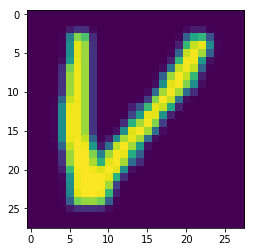

testfile name:  train_V_18529.png
ground truth label:  V
network prediction:  V
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 14681.536164729152, time: 14.751273155212402 

Recursion depth: 1, norm: 26927.07620360963, time: 14.99489688873291 

Recursion depth: 2, norm: 37149.638070242356, time: 14.795218706130981 

Recursion depth: 3, norm: 45683.73786151917, time: 14.61314582824707 

Recursion depth: 4, norm: 52808.24477295188, time: 14.790241479873657 

Recursion depth: 5, norm: 58755.59753759637, time: 14.689893007278442 

Recursion depth: 6, norm: 63720.65668996201, time: 14.588028192520142 

Recursion depth: 7, norm: 67865.5835678144, time: 14.768765687942505 

Recursion depth: 8, norm: 71325.92505534015, time: 14.620050191879272 

Recursion depth: 9, norm: 74214.51165371905, time: 14.847002506256104 

Recursion depth: 10, norm: 76625.97598073384, time: 14.510292291641235 

Recursion depth: 11, norm: 78639.11260943882, time: 14.6185209751129

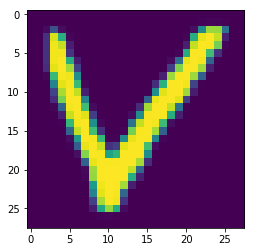

training set name:  train_V_37447.png
training set label:  g
IF measure:  0.00806583766132
train_V_37447.png


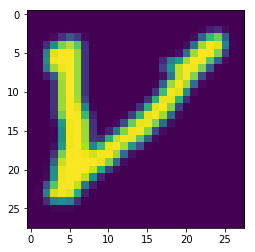

training set name:  train_V_23538.png
training set label:  g
IF measure:  0.00722372267686
train_V_23538.png


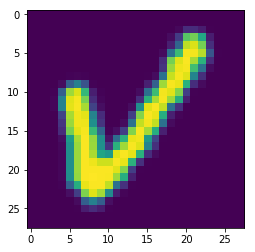

training set name:  train_V_74609.png
training set label:  K
IF measure:  0.00703341782569
train_V_74609.png


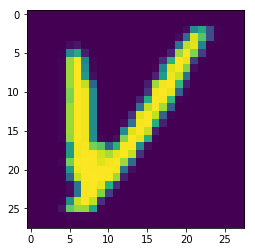

training set name:  train_V_33908.png
training set label:  Y
IF measure:  0.00699368060586
train_V_33908.png


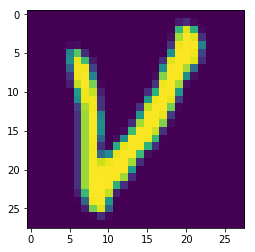

training set name:  train_V_56948.png
training set label:  U
IF measure:  0.00689415849005
train_V_56948.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



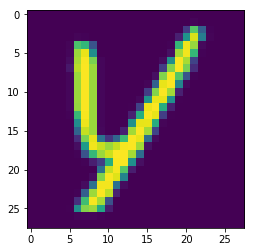

training set name:  train_V_53241.png
training set label:  V
IF measure:  -0.00628333385796
train_V_53241.png


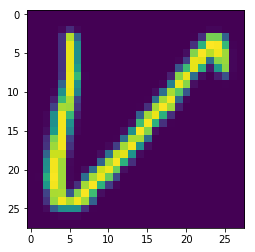

training set name:  train_V_15512.png
training set label:  V
IF measure:  -0.00571459057008
train_V_15512.png


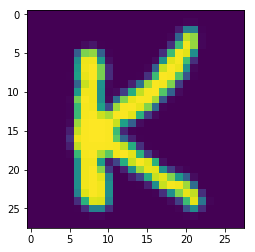

training set name:  train_K_2071.png
training set label:  V
IF measure:  -0.00544091142873
train_K_2071.png


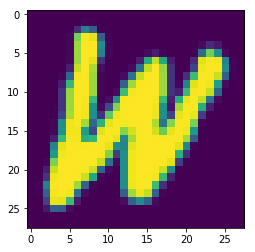

training set name:  train_W_729.png
training set label:  V
IF measure:  -0.00535593534826
train_W_729.png


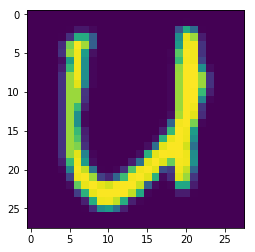

training set name:  train_U_73602.png
training set label:  V
IF measure:  -0.00526646938149
train_U_73602.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



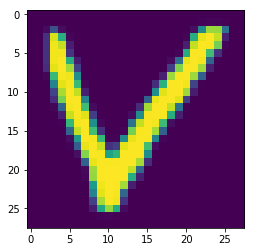

training set name:  train_V_37447.png
training set label:  g
IF measure:  0.00806583766132


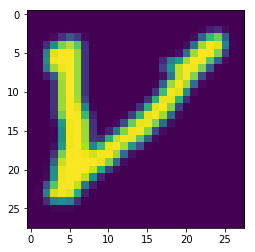

training set name:  train_V_23538.png
training set label:  g
IF measure:  0.00722372267686


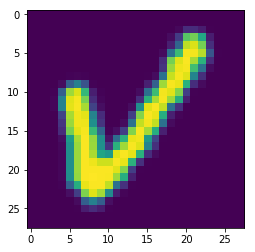

training set name:  train_V_74609.png
training set label:  K
IF measure:  0.00703341782569


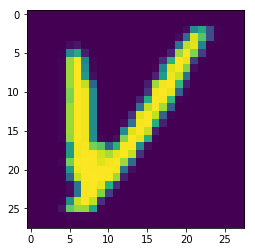

training set name:  train_V_33908.png
training set label:  Y
IF measure:  0.00699368060586


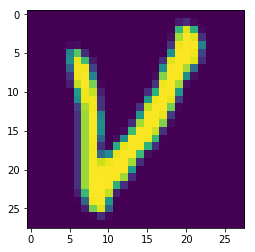

training set name:  train_V_56948.png
training set label:  U
IF measure:  0.00689415849005

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



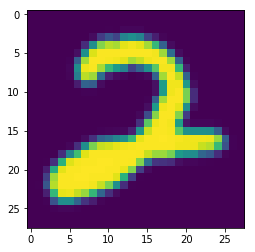

training set name:  train_2_25173.png
training set label:  2
IF measure:  7.01729990113e-11


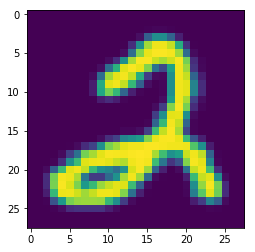

training set name:  train_2_76826.png
training set label:  2
IF measure:  2.93731956961e-10


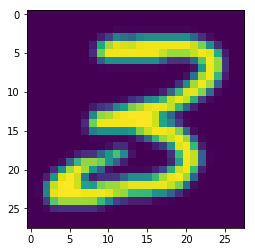

training set name:  train_3_6576.png
training set label:  3
IF measure:  3.93128762325e-10


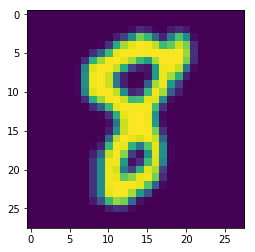

training set name:  train_8_110284.png
training set label:  8
IF measure:  -6.60415507938e-10


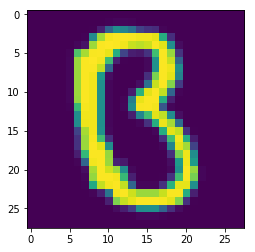

training set name:  train_B_93453.png
training set label:  B
IF measure:  -6.75120356152e-10


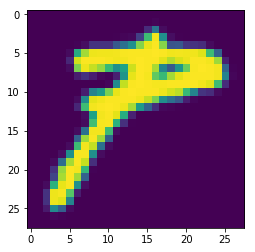

testfile name:  train_P_104114.png
ground truth label:  P
network prediction:  P
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 22642.703397010704, time: 14.44179892539978 

Recursion depth: 1, norm: 41530.97386589917, time: 14.81861424446106 

Recursion depth: 2, norm: 57299.08806429645, time: 14.58745551109314 

Recursion depth: 3, norm: 70462.2658733027, time: 14.677063465118408 

Recursion depth: 4, norm: 81451.1651113721, time: 14.581607580184937 

Recursion depth: 5, norm: 90625.26536237012, time: 14.609230518341064 

Recursion depth: 6, norm: 98284.19796691633, time: 14.8740713596344 

Recursion depth: 7, norm: 104678.2192817589, time: 14.639431953430176 

Recursion depth: 8, norm: 110015.96816826182, time: 14.699471473693848 

Recursion depth: 9, norm: 114472.04733034174, time: 14.67071270942688 

Recursion depth: 10, norm: 118192.38880740164, time: 14.808880805969238 

Recursion depth: 11, norm: 121298.10261500384, time: 14.71304774284362

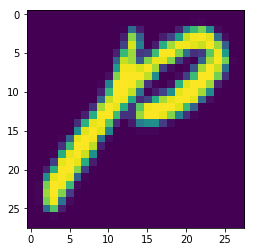

training set name:  train_P_95181.png
training set label:  T
IF measure:  0.00924117470041
train_P_95181.png


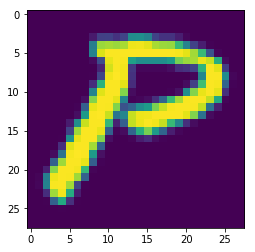

training set name:  train_P_42993.png
training set label:  T
IF measure:  0.00811161749223
train_P_42993.png


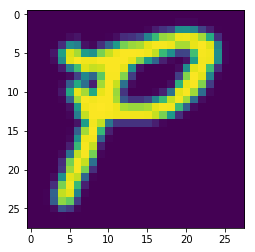

training set name:  train_P_93003.png
training set label:  S
IF measure:  0.00719547064592
train_P_93003.png


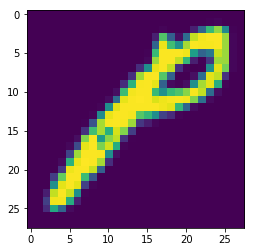

training set name:  train_P_17143.png
training set label:  2
IF measure:  0.00682342307153
train_P_17143.png


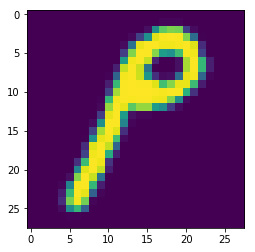

training set name:  train_P_79034.png
training set label:  4
IF measure:  0.00665863661479
train_P_79034.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



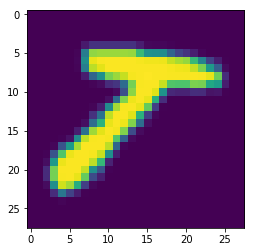

training set name:  train_T_15157.png
training set label:  P
IF measure:  -0.0130522114641
train_T_15157.png


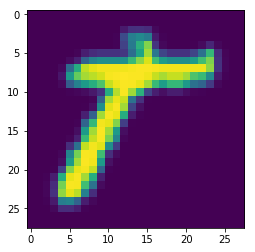

training set name:  train_T_98558.png
training set label:  P
IF measure:  -0.0100135276239
train_T_98558.png


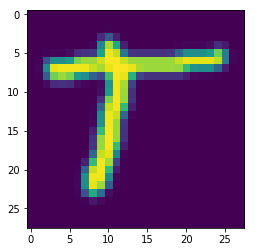

training set name:  train_T_21109.png
training set label:  P
IF measure:  -0.0100133319749
train_T_21109.png


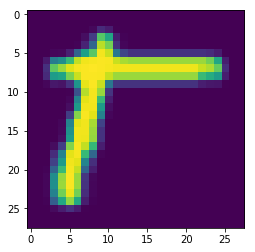

training set name:  train_t_21328.png
training set label:  P
IF measure:  -0.00974055561402
train_t_21328.png


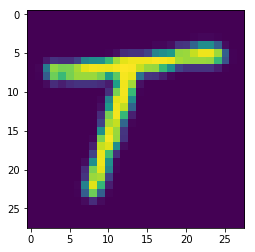

training set name:  train_T_89862.png
training set label:  P
IF measure:  -0.00947365675201
train_T_89862.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



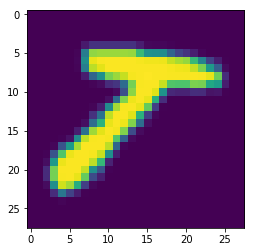

training set name:  train_T_15157.png
training set label:  P
IF measure:  -0.0130522114641


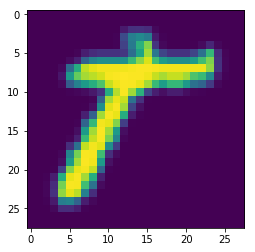

training set name:  train_T_98558.png
training set label:  P
IF measure:  -0.0100135276239


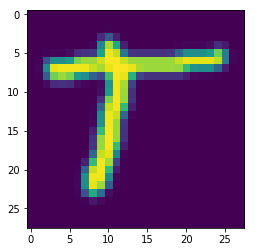

training set name:  train_T_21109.png
training set label:  P
IF measure:  -0.0100133319749


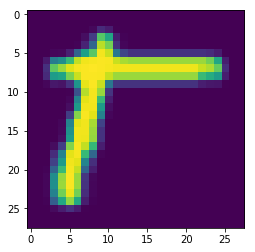

training set name:  train_t_21328.png
training set label:  P
IF measure:  -0.00974055561402


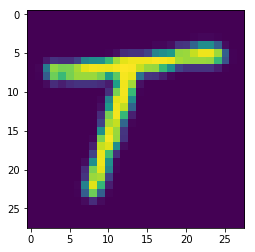

training set name:  train_T_89862.png
training set label:  P
IF measure:  -0.00947365675201

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



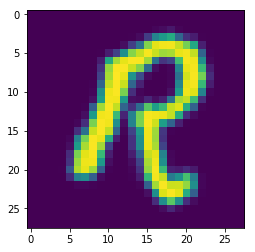

training set name:  train_R_62516.png
training set label:  R
IF measure:  -5.00576853412e-12


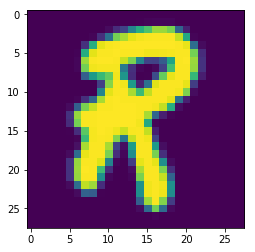

training set name:  train_R_97461.png
training set label:  G
IF measure:  -4.92249494121e-11


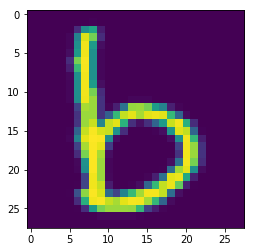

training set name:  train_b_4998.png
training set label:  b
IF measure:  -8.22338018012e-11


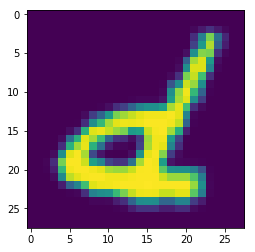

training set name:  train_d_94521.png
training set label:  d
IF measure:  1.69545293171e-10


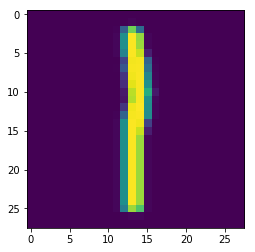

training set name:  train_1_48916.png
training set label:  7
IF measure:  3.60681087518e-10


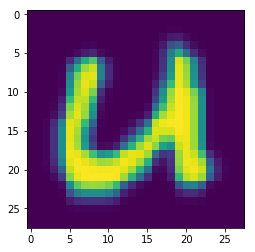

testfile name:  train_U_14826.png
ground truth label:  U
network prediction:  U
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 12572.429538478233, time: 14.621055841445923 

Recursion depth: 1, norm: 23057.13733044499, time: 14.597005367279053 

Recursion depth: 2, norm: 31809.84305604163, time: 14.880300998687744 

Recursion depth: 3, norm: 39116.883893019905, time: 14.91508436203003 

Recursion depth: 4, norm: 45216.958690849606, time: 14.615986585617065 

Recursion depth: 5, norm: 50309.432067953225, time: 14.702133893966675 

Recursion depth: 6, norm: 54560.56998877486, time: 14.64023470878601 

Recursion depth: 7, norm: 58109.736688441466, time: 14.660131692886353 

Recursion depth: 8, norm: 61072.646823271054, time: 14.920098543167114 

Recursion depth: 9, norm: 63546.1472947023, time: 14.757002830505371 

Recursion depth: 10, norm: 65610.89163393529, time: 14.684715270996094 

Recursion depth: 11, norm: 67334.51320830945, time: 14.618902683

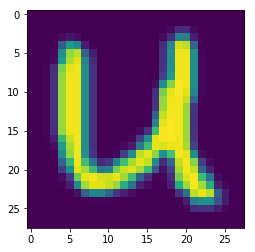

training set name:  train_U_38470.png
training set label:  A
IF measure:  0.00495462168986
train_U_38470.png


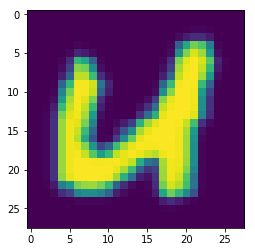

training set name:  train_U_77384.png
training set label:  3
IF measure:  0.00489247430459
train_U_77384.png


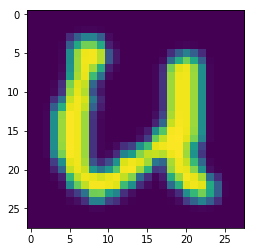

training set name:  train_U_57984.png
training set label:  R
IF measure:  0.00485017411939
train_U_57984.png


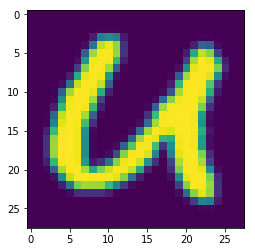

training set name:  train_U_6445.png
training set label:  Q
IF measure:  0.00484409035045
train_U_6445.png


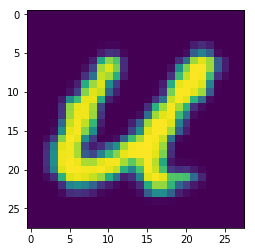

training set name:  train_U_36588.png
training set label:  N
IF measure:  0.00481549402078
train_U_36588.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



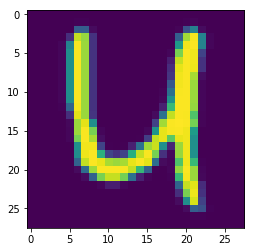

training set name:  train_U_79111.png
training set label:  U
IF measure:  -0.00565402861817
train_U_79111.png


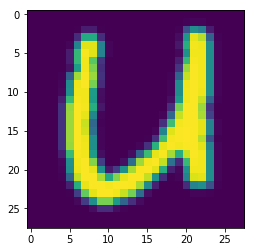

training set name:  train_U_14004.png
training set label:  U
IF measure:  -0.00493994407514
train_U_14004.png


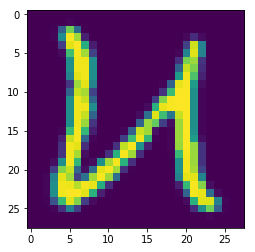

training set name:  train_U_84993.png
training set label:  U
IF measure:  -0.00490667645602
train_U_84993.png


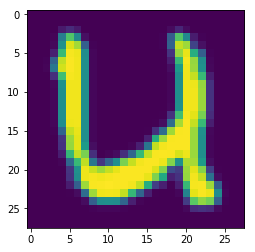

training set name:  train_U_20828.png
training set label:  U
IF measure:  -0.00474796048399
train_U_20828.png


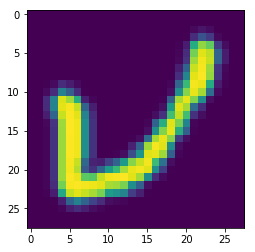

training set name:  train_U_112517.png
training set label:  U
IF measure:  -0.00472091413136
train_U_112517.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



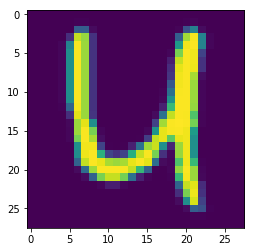

training set name:  train_U_79111.png
training set label:  U
IF measure:  -0.00565402861817


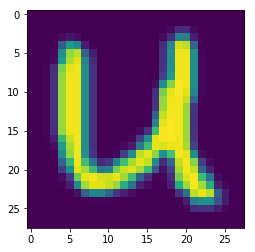

training set name:  train_U_38470.png
training set label:  A
IF measure:  0.00495462168986


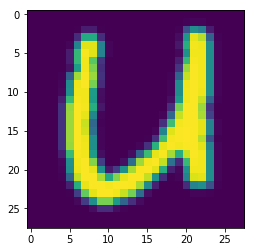

training set name:  train_U_14004.png
training set label:  U
IF measure:  -0.00493994407514


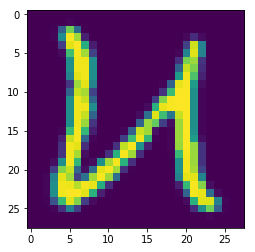

training set name:  train_U_84993.png
training set label:  U
IF measure:  -0.00490667645602


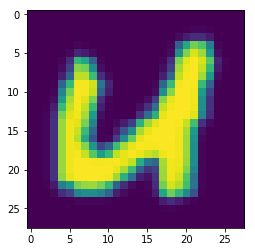

training set name:  train_U_77384.png
training set label:  3
IF measure:  0.00489247430459

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



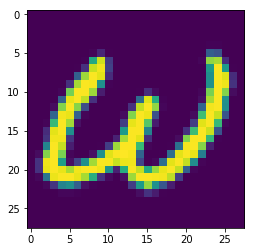

training set name:  train_W_40.png
training set label:  W
IF measure:  2.95517243458e-12


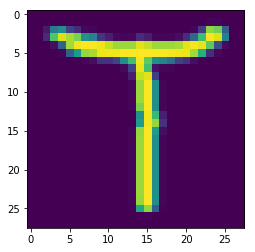

training set name:  train_T_13422.png
training set label:  T
IF measure:  2.2260027958e-10


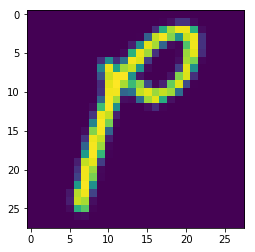

training set name:  train_P_67700.png
training set label:  P
IF measure:  -2.87894420045e-10


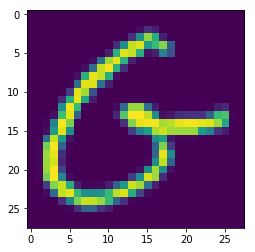

training set name:  train_G_28747.png
training set label:  G
IF measure:  3.06743536481e-10


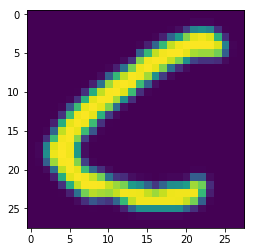

training set name:  train_C_109549.png
training set label:  C
IF measure:  -3.11968293279e-10


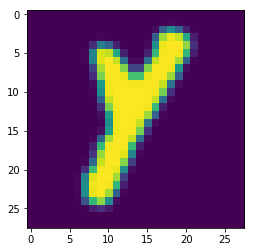

testfile name:  train_Y_80298.png
ground truth label:  Y
network prediction:  Y
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 9203.106578080035, time: 14.813905477523804 

Recursion depth: 1, norm: 16875.36812931795, time: 14.79572606086731 

Recursion depth: 2, norm: 23280.340979569006, time: 14.611352443695068 

Recursion depth: 3, norm: 28627.215418636162, time: 14.807886362075806 

Recursion depth: 4, norm: 33091.1140111662, time: 14.562551975250244 

Recursion depth: 5, norm: 36817.73593663793, time: 14.625918865203857 

Recursion depth: 6, norm: 39928.849401153544, time: 14.580201148986816 

Recursion depth: 7, norm: 42526.111725621, time: 14.604243516921997 

Recursion depth: 8, norm: 44694.4205046894, time: 14.584136724472046 

Recursion depth: 9, norm: 46504.29877441439, time: 14.983304500579834 

Recursion depth: 10, norm: 48015.25669513806, time: 14.603868246078491 

Recursion depth: 11, norm: 49276.54520661935, time: 14.61967515945434

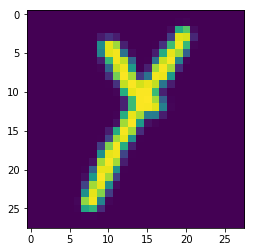

training set name:  train_Y_78137.png
training set label:  b
IF measure:  0.00494874650018
train_Y_78137.png


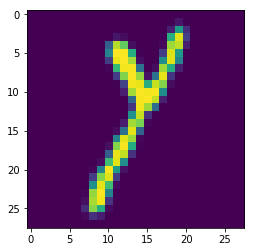

training set name:  train_Y_13883.png
training set label:  e
IF measure:  0.00453546707987
train_Y_13883.png


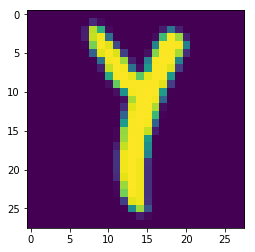

training set name:  train_Y_103216.png
training set label:  n
IF measure:  0.00436541463202
train_Y_103216.png


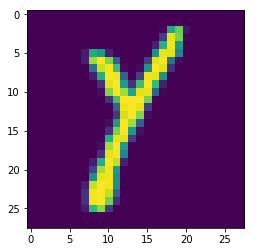

training set name:  train_Y_43273.png
training set label:  S
IF measure:  0.004103985265
train_Y_43273.png


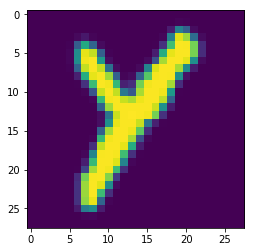

training set name:  train_Y_99177.png
training set label:  q
IF measure:  0.00399050930555
train_Y_99177.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



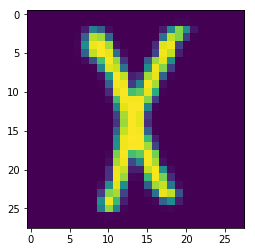

training set name:  train_X_98329.png
training set label:  Y
IF measure:  -0.00436095955735
train_X_98329.png


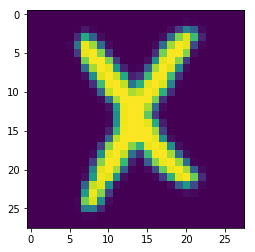

training set name:  train_X_97658.png
training set label:  Y
IF measure:  -0.00345244265247
train_X_97658.png


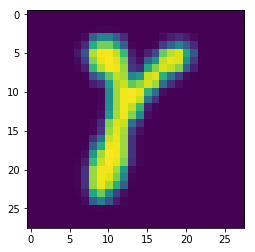

training set name:  train_Y_111105.png
training set label:  Y
IF measure:  -0.00342902725576
train_Y_111105.png


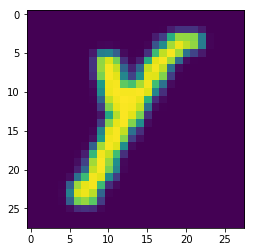

training set name:  train_Y_29757.png
training set label:  Y
IF measure:  -0.00340750337651
train_Y_29757.png


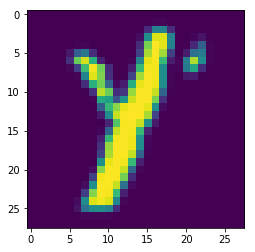

training set name:  train_Y_110716.png
training set label:  Y
IF measure:  -0.00337973056718
train_Y_110716.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



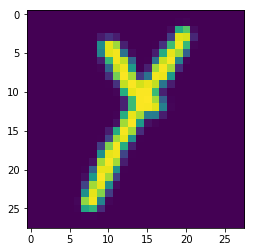

training set name:  train_Y_78137.png
training set label:  b
IF measure:  0.00494874650018


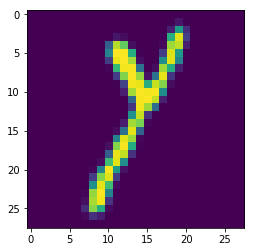

training set name:  train_Y_13883.png
training set label:  e
IF measure:  0.00453546707987


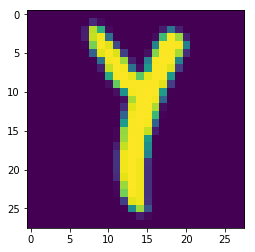

training set name:  train_Y_103216.png
training set label:  n
IF measure:  0.00436541463202


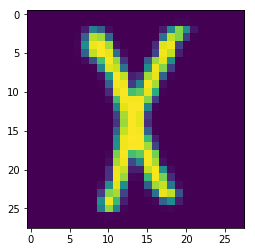

training set name:  train_X_98329.png
training set label:  Y
IF measure:  -0.00436095955735


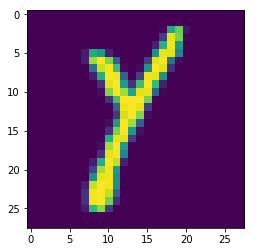

training set name:  train_Y_43273.png
training set label:  S
IF measure:  0.004103985265

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



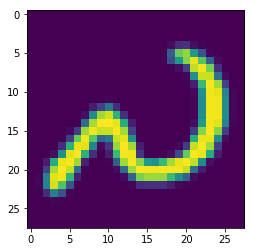

training set name:  train_N_93141.png
training set label:  N
IF measure:  2.09970720086e-11


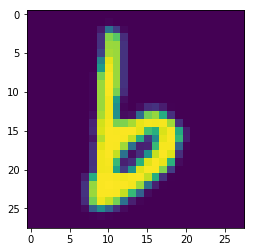

training set name:  train_b_47760.png
training set label:  b
IF measure:  1.08798787473e-10


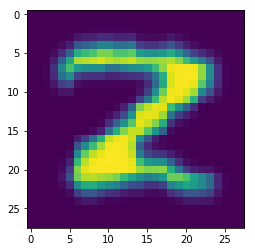

training set name:  train_Z_112735.png
training set label:  Z
IF measure:  1.54693115685e-10


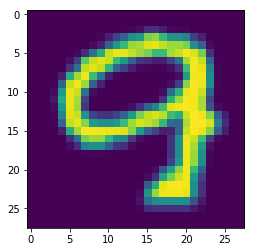

training set name:  train_q_9268.png
training set label:  q
IF measure:  1.75933687162e-10


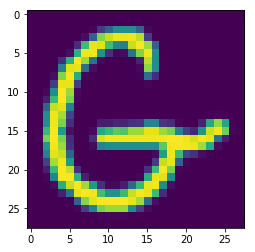

training set name:  train_G_11476.png
training set label:  G
IF measure:  -2.25864946289e-10


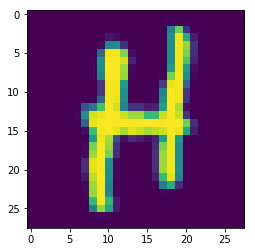

testfile name:  train_H_100708.png
ground truth label:  H
network prediction:  H
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 6565.558619369337, time: 14.860576152801514 

Recursion depth: 1, norm: 12036.67770426084, time: 14.598010301589966 

Recursion depth: 2, norm: 16603.76017842043, time: 14.60453748703003 

Recursion depth: 3, norm: 20416.47027830717, time: 14.919466018676758 

Recursion depth: 4, norm: 23599.295153669314, time: 14.72368597984314 

Recursion depth: 5, norm: 26256.44649176655, time: 14.999115943908691 

Recursion depth: 6, norm: 28474.834128138482, time: 14.592341184616089 

Recursion depth: 7, norm: 30326.695179330043, time: 14.704556941986084 

Recursion depth: 8, norm: 31872.57839820933, time: 14.591370105743408 

Recursion depth: 9, norm: 33163.12441176193, time: 14.742820501327515 

Recursion depth: 10, norm: 34240.50450124822, time: 14.628719568252563 

Recursion depth: 11, norm: 35140.195944245956, time: 14.882846593

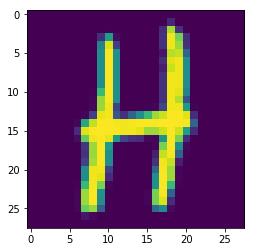

training set name:  train_H_22688.png
training set label:  P
IF measure:  0.00255705195063
train_H_22688.png


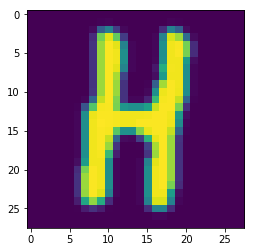

training set name:  train_H_47834.png
training set label:  S
IF measure:  0.00240802372944
train_H_47834.png


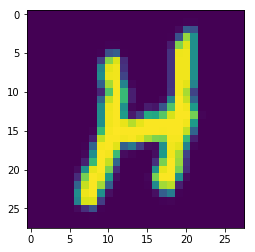

training set name:  train_H_21694.png
training set label:  O
IF measure:  0.00237138553503
train_H_21694.png


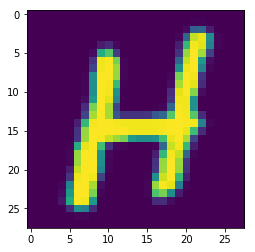

training set name:  train_H_57944.png
training set label:  7
IF measure:  0.00228467358157
train_H_57944.png


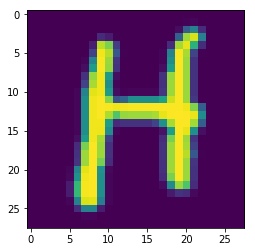

training set name:  train_H_857.png
training set label:  h
IF measure:  0.00224186356794
train_H_857.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



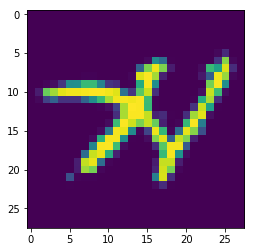

training set name:  train_H_2967.png
training set label:  H
IF measure:  -0.00214574688002
train_H_2967.png


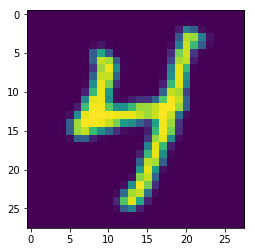

training set name:  train_4_51767.png
training set label:  H
IF measure:  -0.00208532141773
train_4_51767.png


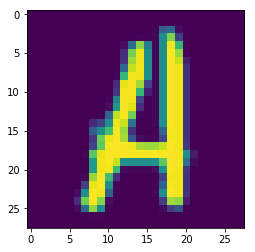

training set name:  train_H_72737.png
training set label:  H
IF measure:  -0.00201219814096
train_H_72737.png


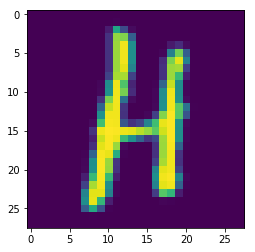

training set name:  train_H_74908.png
training set label:  H
IF measure:  -0.00197426427473
train_H_74908.png


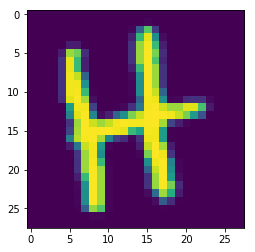

training set name:  train_H_17608.png
training set label:  H
IF measure:  -0.0019602101098
train_H_17608.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



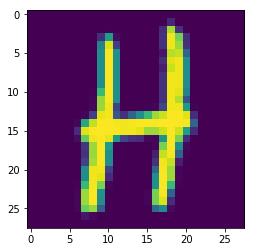

training set name:  train_H_22688.png
training set label:  P
IF measure:  0.00255705195063


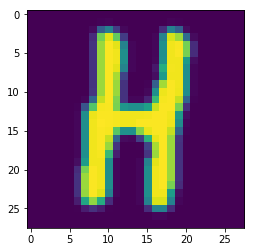

training set name:  train_H_47834.png
training set label:  S
IF measure:  0.00240802372944


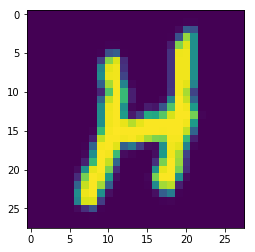

training set name:  train_H_21694.png
training set label:  O
IF measure:  0.00237138553503


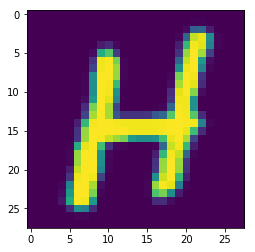

training set name:  train_H_57944.png
training set label:  7
IF measure:  0.00228467358157


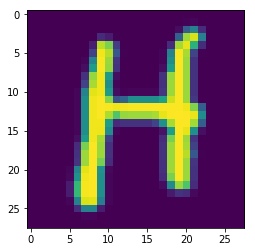

training set name:  train_H_857.png
training set label:  h
IF measure:  0.00224186356794

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



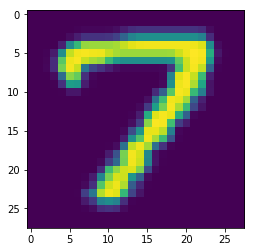

training set name:  train_7_72080.png
training set label:  7
IF measure:  -1.05483324518e-10


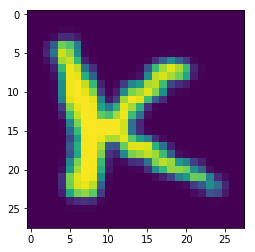

training set name:  train_K_41808.png
training set label:  K
IF measure:  -1.31153006186e-10


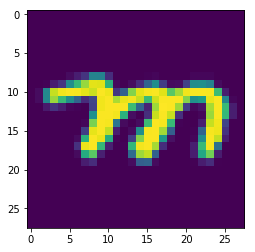

training set name:  train_M_106524.png
training set label:  M
IF measure:  3.51474550016e-10


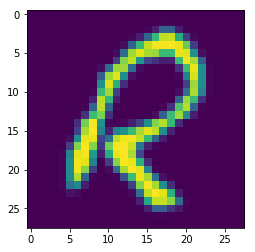

training set name:  train_R_10816.png
training set label:  R
IF measure:  3.7104223177e-10


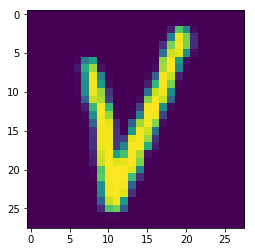

training set name:  train_V_32170.png
training set label:  V
IF measure:  4.9557947029e-10


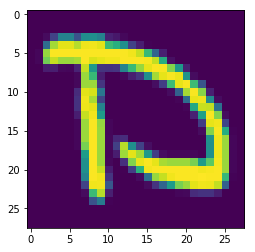

testfile name:  train_D_109455.png
ground truth label:  D
network prediction:  D
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 35789.40666244692, time: 14.72709584236145 

Recursion depth: 1, norm: 65647.08174778221, time: 14.711978673934937 

Recursion depth: 2, norm: 90572.91165685246, time: 14.671538591384888 

Recursion depth: 3, norm: 111381.51823799135, time: 14.643039226531982 

Recursion depth: 4, norm: 128752.89327234554, time: 14.641149997711182 

Recursion depth: 5, norm: 143254.8808941601, time: 14.607320070266724 

Recursion depth: 6, norm: 155361.48722897834, time: 14.552636861801147 

Recursion depth: 7, norm: 165468.3573980234, time: 14.910576820373535 

Recursion depth: 8, norm: 173905.81278381697, time: 14.593080759048462 

Recursion depth: 9, norm: 180949.69505362533, time: 14.639095067977905 

Recursion depth: 10, norm: 186830.12263551078, time: 14.6031174659729 

Recursion depth: 11, norm: 191739.29763092386, time: 14.5942714

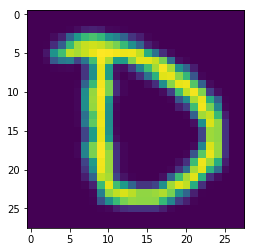

training set name:  train_D_100338.png
training set label:  R
IF measure:  0.0226933777121
train_D_100338.png


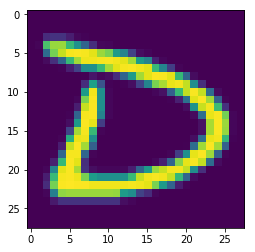

training set name:  train_D_73335.png
training set label:  N
IF measure:  0.0193996625536
train_D_73335.png


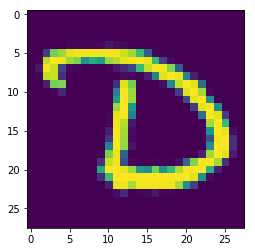

training set name:  train_D_34787.png
training set label:  q
IF measure:  0.0184116522207
train_D_34787.png


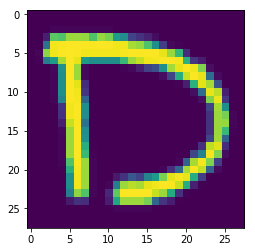

training set name:  train_D_39370.png
training set label:  O
IF measure:  0.0180508745002
train_D_39370.png


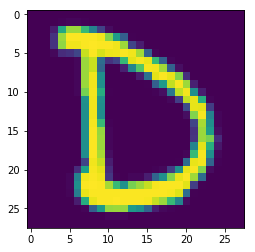

training set name:  train_D_112561.png
training set label:  B
IF measure:  0.0171161633804
train_D_112561.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



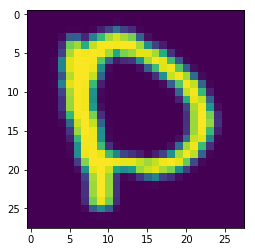

training set name:  train_D_90888.png
training set label:  D
IF measure:  -0.0185000087934
train_D_90888.png


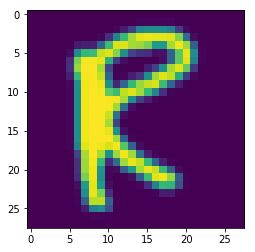

training set name:  train_R_109682.png
training set label:  D
IF measure:  -0.0165642068213
train_R_109682.png


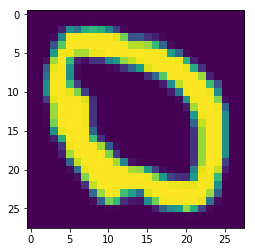

training set name:  train_D_109828.png
training set label:  D
IF measure:  -0.0161604606778
train_D_109828.png


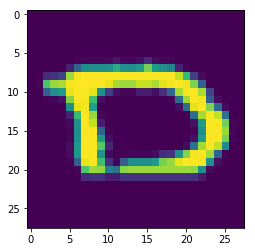

training set name:  train_D_110878.png
training set label:  D
IF measure:  -0.0160342853754
train_D_110878.png


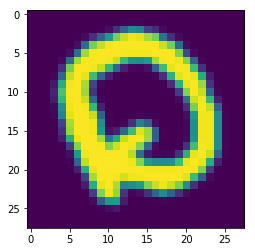

training set name:  train_D_111459.png
training set label:  D
IF measure:  -0.013139898647
train_D_111459.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



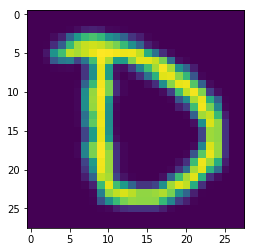

training set name:  train_D_100338.png
training set label:  R
IF measure:  0.0226933777121


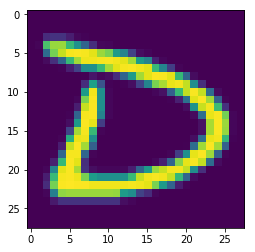

training set name:  train_D_73335.png
training set label:  N
IF measure:  0.0193996625536


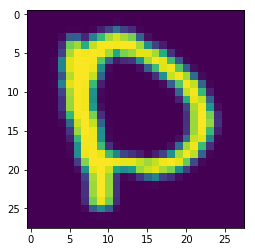

training set name:  train_D_90888.png
training set label:  D
IF measure:  -0.0185000087934


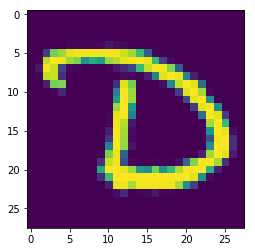

training set name:  train_D_34787.png
training set label:  q
IF measure:  0.0184116522207


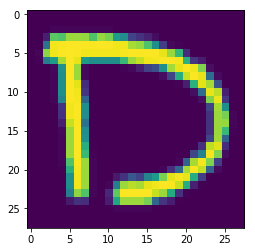

training set name:  train_D_39370.png
training set label:  O
IF measure:  0.0180508745002

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



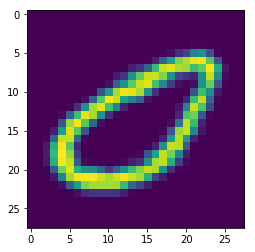

training set name:  train_0_23923.png
training set label:  0
IF measure:  3.22670659301e-11


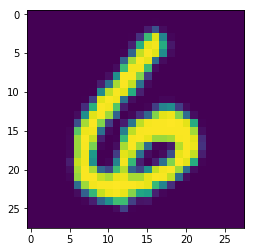

training set name:  train_6_90513.png
training set label:  6
IF measure:  -4.24594013534e-10


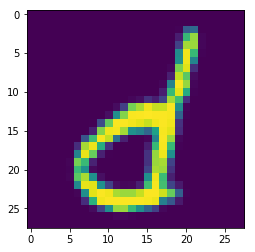

training set name:  train_d_60177.png
training set label:  d
IF measure:  5.04742468152e-10


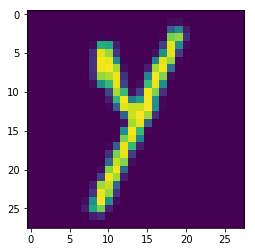

training set name:  train_Y_106952.png
training set label:  X
IF measure:  -8.16091530996e-10


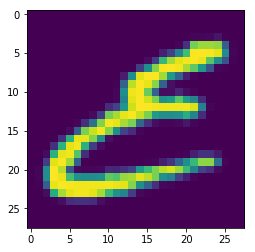

training set name:  train_E_100559.png
training set label:  E
IF measure:  -9.66811573904e-10


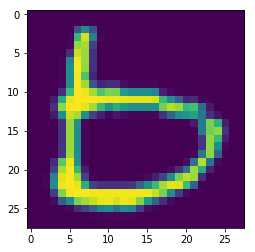

testfile name:  train_b_97894.png
ground truth label:  b
network prediction:  b
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 25137.552826896255, time: 14.65643310546875 

Recursion depth: 1, norm: 46107.71875998638, time: 14.599465608596802 

Recursion depth: 2, norm: 63613.8388992521, time: 14.725545644760132 

Recursion depth: 3, norm: 78228.47075074395, time: 14.562389612197876 

Recursion depth: 4, norm: 90428.77116272232, time: 14.593849182128906 

Recursion depth: 5, norm: 100613.86398503935, time: 14.630311012268066 

Recursion depth: 6, norm: 109116.43769845128, time: 14.615485191345215 

Recursion depth: 7, norm: 116214.62542210425, time: 14.636023044586182 

Recursion depth: 8, norm: 122140.20283264639, time: 14.603999614715576 

Recursion depth: 9, norm: 127087.13566683294, time: 14.671755075454712 

Recursion depth: 10, norm: 131216.90176193006, time: 14.867085695266724 

Recursion depth: 11, norm: 134664.31564449432, time: 14.953958

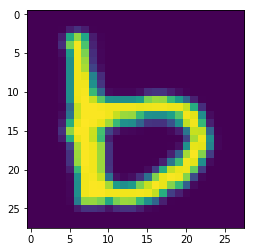

training set name:  train_b_31736.png
training set label:  h
IF measure:  0.0124110175046
train_b_31736.png


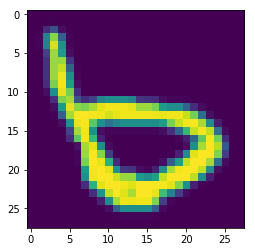

training set name:  train_b_9569.png
training set label:  n
IF measure:  0.0113447559007
train_b_9569.png


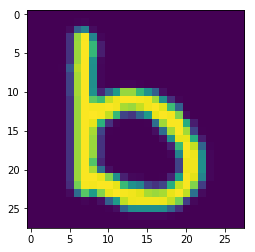

training set name:  train_b_13252.png
training set label:  J
IF measure:  0.0109851414959
train_b_13252.png


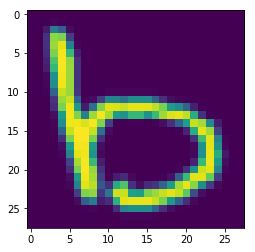

training set name:  train_b_45115.png
training set label:  e
IF measure:  0.0107554258713
train_b_45115.png


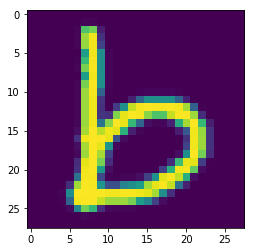

training set name:  train_b_11858.png
training set label:  D
IF measure:  0.0106550725639
train_b_11858.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



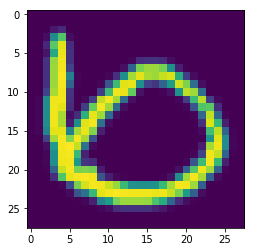

training set name:  train_b_14330.png
training set label:  b
IF measure:  -0.0117452154663
train_b_14330.png


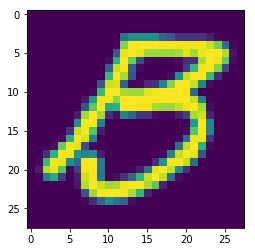

training set name:  train_B_75308.png
training set label:  b
IF measure:  -0.00975703074471
train_B_75308.png


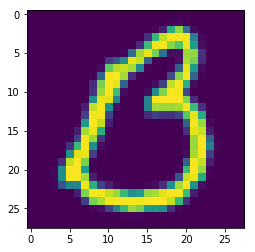

training set name:  train_b_58564.png
training set label:  b
IF measure:  -0.00931809771251
train_b_58564.png


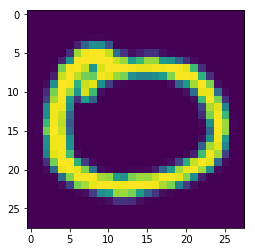

training set name:  train_0_96616.png
training set label:  b
IF measure:  -0.00915485094731
train_0_96616.png


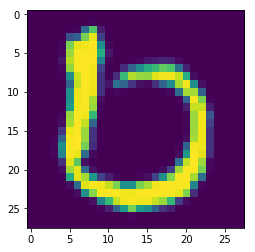

training set name:  train_b_9444.png
training set label:  b
IF measure:  -0.00906031524881
train_b_9444.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



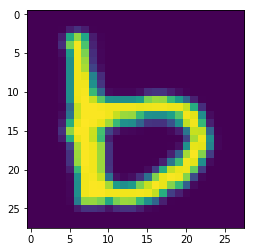

training set name:  train_b_31736.png
training set label:  h
IF measure:  0.0124110175046


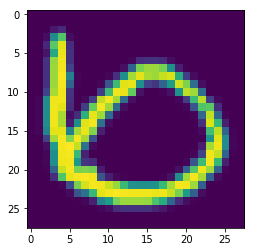

training set name:  train_b_14330.png
training set label:  b
IF measure:  -0.0117452154663


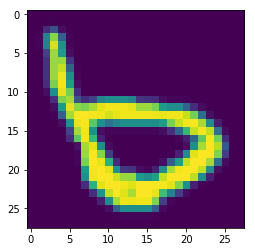

training set name:  train_b_9569.png
training set label:  n
IF measure:  0.0113447559007


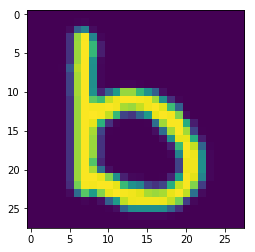

training set name:  train_b_13252.png
training set label:  J
IF measure:  0.0109851414959


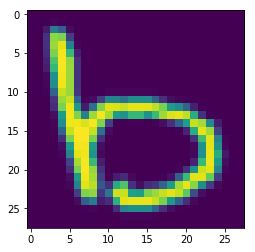

training set name:  train_b_45115.png
training set label:  e
IF measure:  0.0107554258713

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



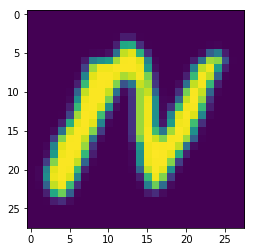

training set name:  train_N_50756.png
training set label:  7
IF measure:  4.23450412638e-11


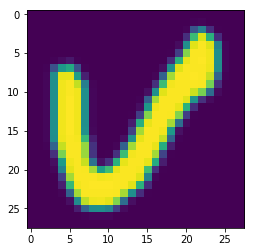

training set name:  train_V_45956.png
training set label:  V
IF measure:  -1.45083917142e-10


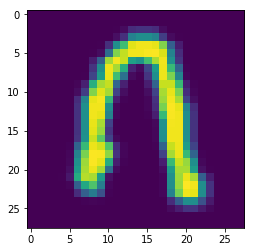

training set name:  train_n_60475.png
training set label:  n
IF measure:  3.61795702302e-10


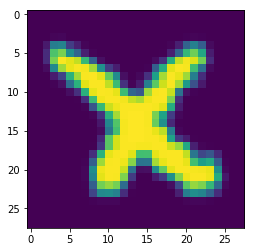

training set name:  train_X_103249.png
training set label:  X
IF measure:  5.47273601063e-10


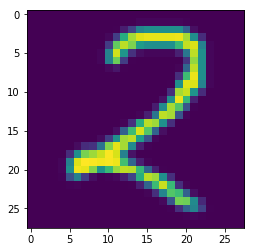

training set name:  train_2_22268.png
training set label:  2
IF measure:  -6.0259893781e-10


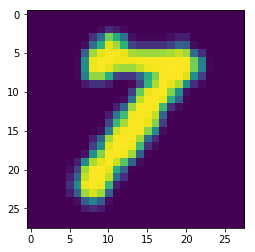

testfile name:  train_7_74705.png
ground truth label:  7
network prediction:  7
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 11428.360303155916, time: 14.707861185073853 

Recursion depth: 1, norm: 20958.08103691748, time: 14.80295991897583 

Recursion depth: 2, norm: 28913.61475369346, time: 14.726959943771362 

Recursion depth: 3, norm: 35555.3081585577, time: 14.7294442653656 

Recursion depth: 4, norm: 41099.85442796604, time: 14.614548206329346 

Recursion depth: 5, norm: 45728.697330013674, time: 14.60382080078125 

Recursion depth: 6, norm: 49593.038377377125, time: 14.6913321018219 

Recursion depth: 7, norm: 52818.88773440804, time: 14.57557463645935 

Recursion depth: 8, norm: 55511.80469954116, time: 14.73773717880249 

Recursion depth: 9, norm: 57759.87300020664, time: 14.667140483856201 

Recursion depth: 10, norm: 59636.71581333097, time: 14.603338241577148 

Recursion depth: 11, norm: 61203.68125366316, time: 14.592324495315552 



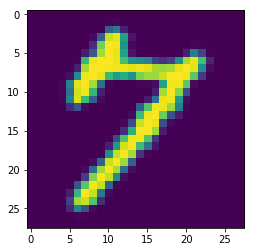

training set name:  train_7_18175.png
training set label:  n
IF measure:  0.00642979167772
train_7_18175.png


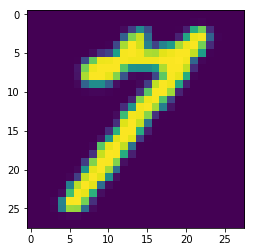

training set name:  train_7_93542.png
training set label:  8
IF measure:  0.00575239199167
train_7_93542.png


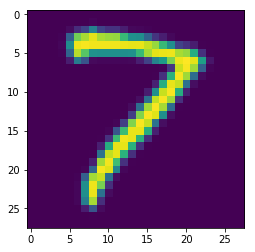

training set name:  train_7_81876.png
training set label:  U
IF measure:  0.00563852992041
train_7_81876.png


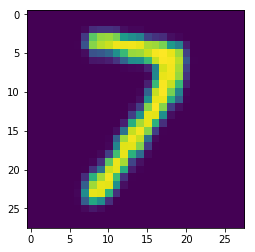

training set name:  train_7_69167.png
training set label:  L
IF measure:  0.00560258744509
train_7_69167.png


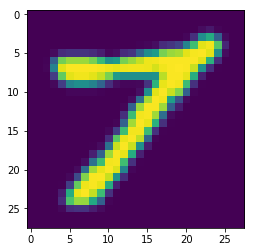

training set name:  train_T_54106.png
training set label:  T
IF measure:  0.00560030617771
train_T_54106.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



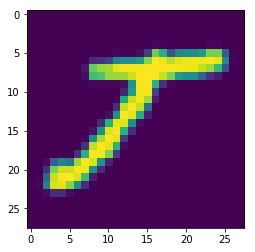

training set name:  train_T_106990.png
training set label:  7
IF measure:  -0.00512636985815
train_T_106990.png


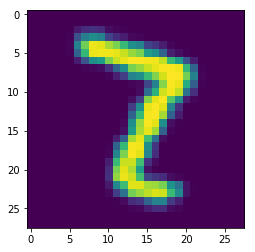

training set name:  train_7_55600.png
training set label:  7
IF measure:  -0.00502677032235
train_7_55600.png


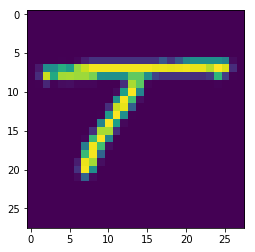

training set name:  train_T_33413.png
training set label:  7
IF measure:  -0.00469571270894
train_T_33413.png


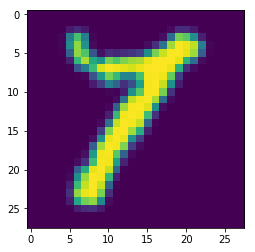

training set name:  train_7_52116.png
training set label:  7
IF measure:  -0.00461374062067
train_7_52116.png


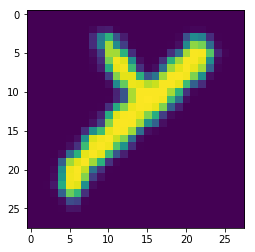

training set name:  train_Y_112316.png
training set label:  7
IF measure:  -0.00460007232185
train_Y_112316.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



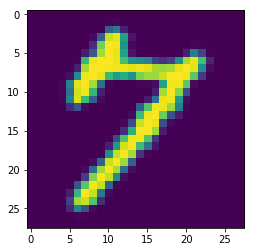

training set name:  train_7_18175.png
training set label:  n
IF measure:  0.00642979167772


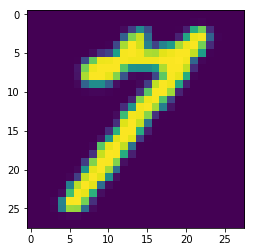

training set name:  train_7_93542.png
training set label:  8
IF measure:  0.00575239199167


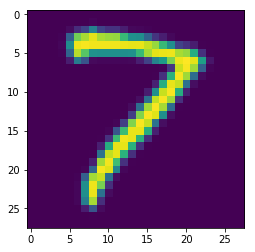

training set name:  train_7_81876.png
training set label:  U
IF measure:  0.00563852992041


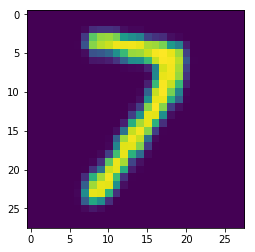

training set name:  train_7_69167.png
training set label:  L
IF measure:  0.00560258744509


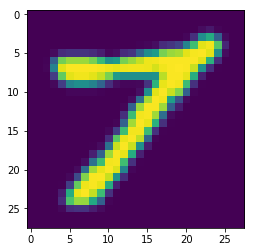

training set name:  train_T_54106.png
training set label:  T
IF measure:  0.00560030617771

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



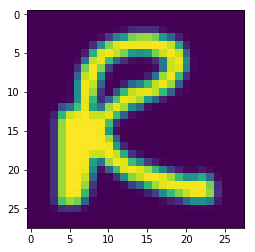

training set name:  train_R_51807.png
training set label:  R
IF measure:  -3.1274797535e-10


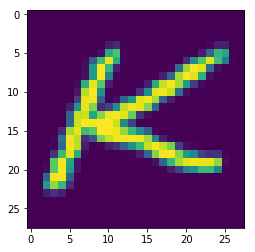

training set name:  train_K_15984.png
training set label:  K
IF measure:  3.47479062387e-10


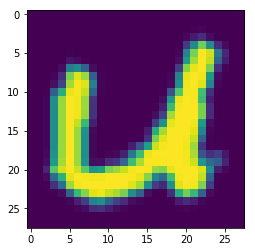

training set name:  train_U_34377.png
training set label:  U
IF measure:  4.05663985933e-10


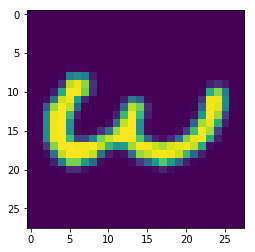

training set name:  train_W_82577.png
training set label:  W
IF measure:  5.30376028045e-10


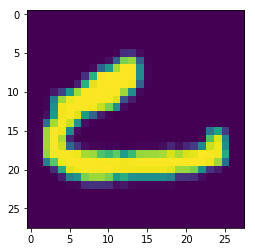

training set name:  train_C_106368.png
training set label:  C
IF measure:  -6.91123088782e-10


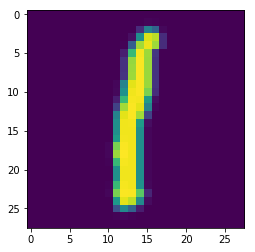

testfile name:  train_L_66551.png
ground truth label:  L
network prediction:  1
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 20686.611999068384, time: 14.68042254447937 

Recursion depth: 1, norm: 37942.47854318429, time: 14.629241704940796 

Recursion depth: 2, norm: 52348.036677606164, time: 15.143316984176636 

Recursion depth: 3, norm: 64374.00514959435, time: 14.67224907875061 

Recursion depth: 4, norm: 74413.61648246912, time: 14.688068151473999 

Recursion depth: 5, norm: 82794.91637775836, time: 14.788772344589233 

Recursion depth: 6, norm: 89791.62860757121, time: 14.790745735168457 

Recursion depth: 7, norm: 95632.76714599447, time: 14.75155258178711 

Recursion depth: 8, norm: 100508.96498322923, time: 14.959133386611938 

Recursion depth: 9, norm: 104579.70411126626, time: 14.640519142150879 

Recursion depth: 10, norm: 107977.86184213874, time: 14.74588680267334 

Recursion depth: 11, norm: 110814.69000092, time: 14.6313099861145

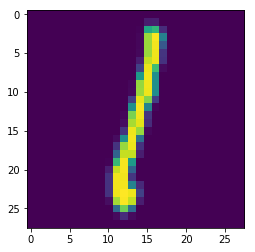

training set name:  train_1_20426.png
training set label:  1
IF measure:  0.00797358306904
train_1_20426.png


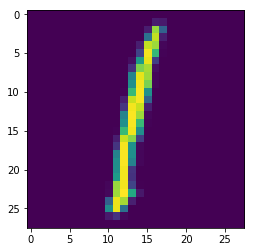

training set name:  train_1_72356.png
training set label:  1
IF measure:  0.00727599200839
train_1_72356.png


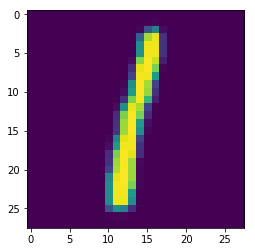

training set name:  train_1_69289.png
training set label:  1
IF measure:  0.00727503644765
train_1_69289.png


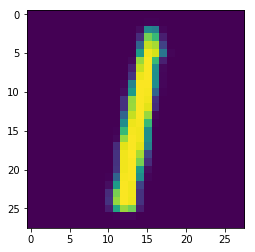

training set name:  train_1_28280.png
training set label:  1
IF measure:  0.00720979647962
train_1_28280.png


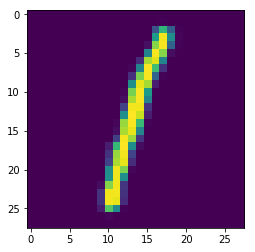

training set name:  train_1_83101.png
training set label:  1
IF measure:  0.00719821288231
train_1_83101.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



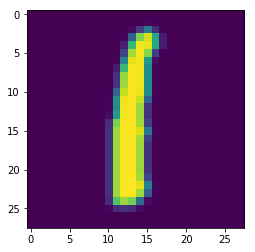

training set name:  train_L_73556.png
training set label:  L
IF measure:  -0.0117019996047
train_L_73556.png


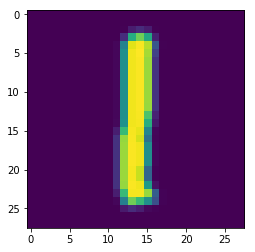

training set name:  train_L_79709.png
training set label:  L
IF measure:  -0.0107373851411
train_L_79709.png


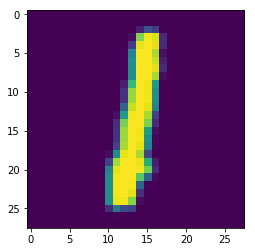

training set name:  train_L_1133.png
training set label:  L
IF measure:  -0.0105546332156
train_L_1133.png


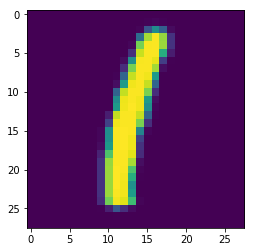

training set name:  train_L_96992.png
training set label:  L
IF measure:  -0.0104848917336
train_L_96992.png


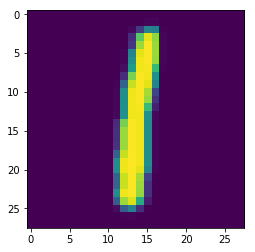

training set name:  train_L_38711.png
training set label:  L
IF measure:  -0.0104309134185
train_L_38711.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



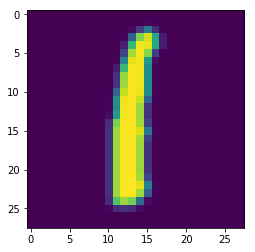

training set name:  train_L_73556.png
training set label:  L
IF measure:  -0.0117019996047


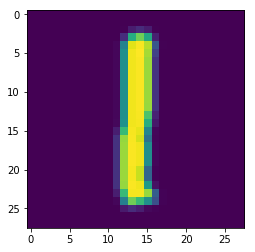

training set name:  train_L_79709.png
training set label:  L
IF measure:  -0.0107373851411


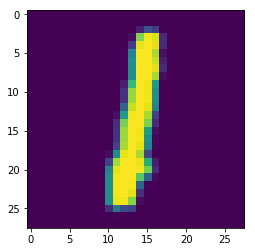

training set name:  train_L_1133.png
training set label:  L
IF measure:  -0.0105546332156


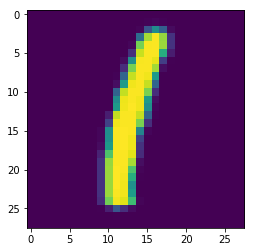

training set name:  train_L_96992.png
training set label:  L
IF measure:  -0.0104848917336


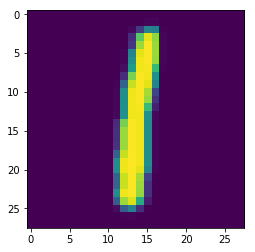

training set name:  train_L_38711.png
training set label:  L
IF measure:  -0.0104309134185

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



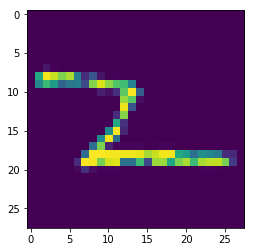

training set name:  train_Z_43809.png
training set label:  Z
IF measure:  -8.81242313165e-11


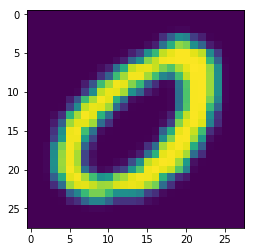

training set name:  train_O_52151.png
training set label:  O
IF measure:  -1.01747300892e-10


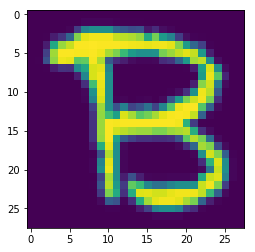

training set name:  train_B_89864.png
training set label:  B
IF measure:  2.64064368795e-10


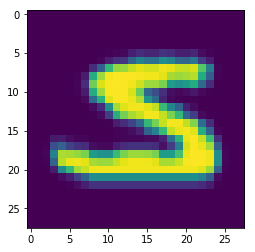

training set name:  train_S_42319.png
training set label:  S
IF measure:  -4.18109227618e-10


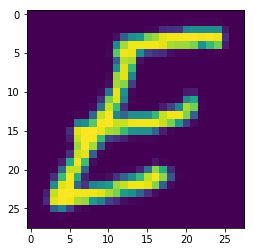

training set name:  train_E_53526.png
training set label:  E
IF measure:  -5.01041276238e-10


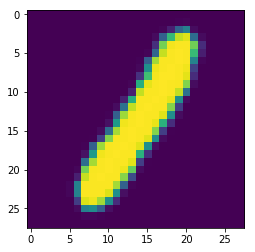

testfile name:  train_1_31620.png
ground truth label:  1
network prediction:  1
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 15366.03335282076, time: 14.53369951248169 

Recursion depth: 1, norm: 28183.024167927757, time: 14.569804906845093 

Recursion depth: 2, norm: 38882.82521885466, time: 14.53455638885498 

Recursion depth: 3, norm: 47815.42358904708, time: 14.44514012336731 

Recursion depth: 4, norm: 55272.523834180036, time: 14.81483769416809 

Recursion depth: 5, norm: 61497.53433268687, time: 14.86055612564087 

Recursion depth: 6, norm: 66694.20248417399, time: 14.532268047332764 

Recursion depth: 7, norm: 71032.50208179351, time: 14.603851318359375 

Recursion depth: 8, norm: 74654.12713306613, time: 14.774693250656128 

Recursion depth: 9, norm: 77677.44531072066, time: 14.624503374099731 

Recursion depth: 10, norm: 80201.51487347356, time: 14.622534036636353 

Recursion depth: 11, norm: 82308.48761822804, time: 14.733150959014893

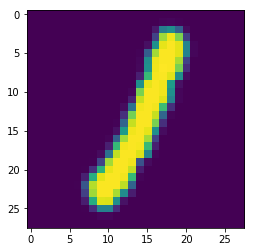

training set name:  train_1_50449.png
training set label:  e
IF measure:  0.00509112853002
train_1_50449.png


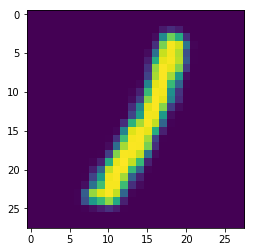

training set name:  train_L_4534.png
training set label:  L
IF measure:  0.00501016669028
train_L_4534.png


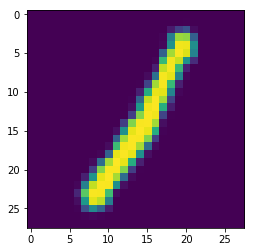

training set name:  train_L_105374.png
training set label:  K
IF measure:  0.00500240681548
train_L_105374.png


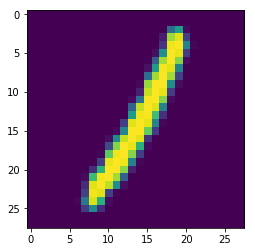

training set name:  train_L_86396.png
training set label:  L
IF measure:  0.00484023199595
train_L_86396.png


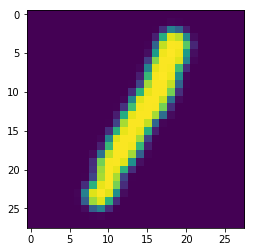

training set name:  train_1_25031.png
training set label:  L
IF measure:  0.00464450686589
train_1_25031.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



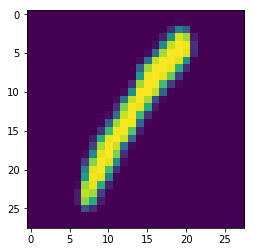

training set name:  train_1_20726.png
training set label:  1
IF measure:  -0.00584038657711
train_1_20726.png


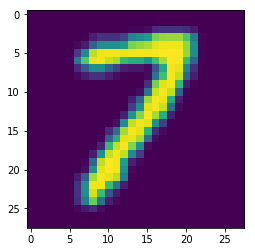

training set name:  train_7_65330.png
training set label:  1
IF measure:  -0.00509321759356
train_7_65330.png


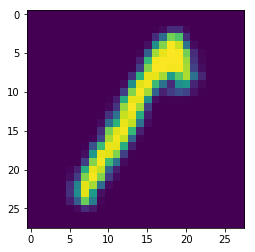

training set name:  train_1_33776.png
training set label:  1
IF measure:  -0.00508131356844
train_1_33776.png


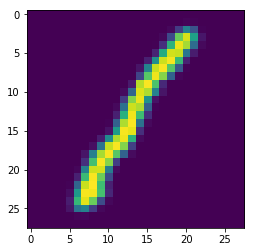

training set name:  train_1_56379.png
training set label:  1
IF measure:  -0.00505271264425
train_1_56379.png


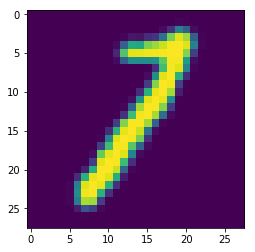

training set name:  train_1_19426.png
training set label:  1
IF measure:  -0.00501401832869
train_1_19426.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



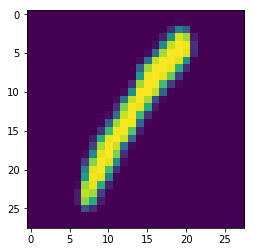

training set name:  train_1_20726.png
training set label:  1
IF measure:  -0.00584038657711


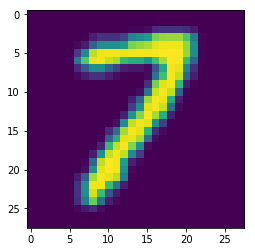

training set name:  train_7_65330.png
training set label:  1
IF measure:  -0.00509321759356


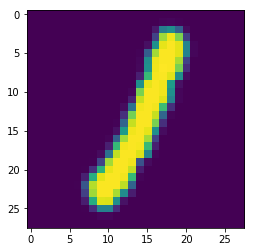

training set name:  train_1_50449.png
training set label:  e
IF measure:  0.00509112853002


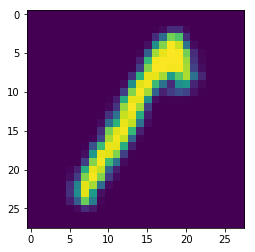

training set name:  train_1_33776.png
training set label:  1
IF measure:  -0.00508131356844


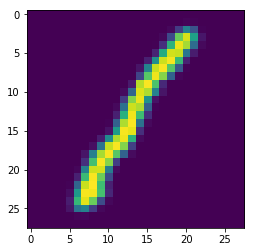

training set name:  train_1_56379.png
training set label:  1
IF measure:  -0.00505271264425

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



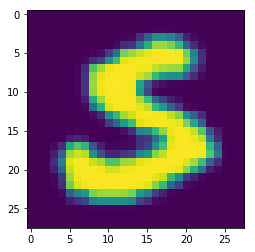

training set name:  train_S_61884.png
training set label:  S
IF measure:  -1.30683423106e-12


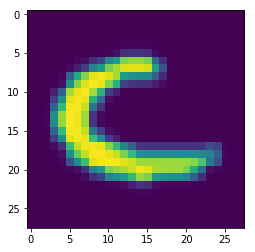

training set name:  train_C_19535.png
training set label:  C
IF measure:  4.48694373382e-10


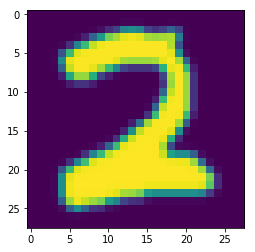

training set name:  train_Z_45072.png
training set label:  Z
IF measure:  -9.01904613719e-10


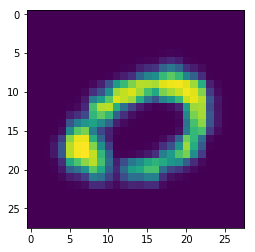

training set name:  train_O_104985.png
training set label:  H
IF measure:  9.35978413451e-10


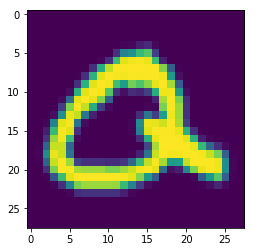

training set name:  train_Q_1127.png
training set label:  Q
IF measure:  -9.65199639677e-10


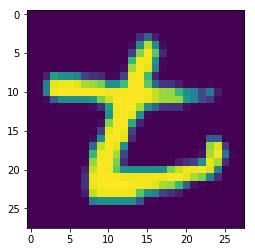

testfile name:  train_t_67915.png
ground truth label:  t
network prediction:  t
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 2164.3534081884845, time: 14.853136777877808 

Recursion depth: 1, norm: 3956.5063946712153, time: 14.716034650802612 

Recursion depth: 2, norm: 5451.152404502132, time: 14.787863492965698 

Recursion depth: 3, norm: 6698.277033446502, time: 14.621299028396606 

Recursion depth: 4, norm: 7739.268131858262, time: 14.64999270439148 

Recursion depth: 5, norm: 8608.119491144866, time: 14.587437868118286 

Recursion depth: 6, norm: 9333.320683050393, time: 14.855790376663208 

Recursion depth: 7, norm: 9938.604509177521, time: 14.656208276748657 

Recursion depth: 8, norm: 10443.918782672647, time: 14.603419780731201 

Recursion depth: 9, norm: 10865.558922900895, time: 14.779294490814209 

Recursion depth: 10, norm: 11217.638113772548, time: 14.629112482070923 

Recursion depth: 11, norm: 11511.387791348727, time: 14.6237866

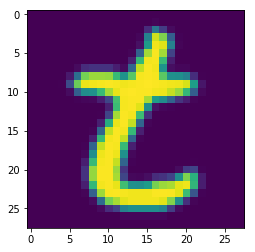

training set name:  train_t_55932.png
training set label:  a
IF measure:  0.000947735219507
train_t_55932.png


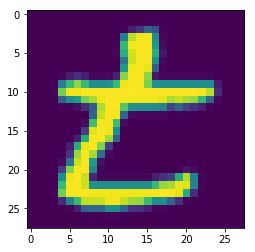

training set name:  train_t_17326.png
training set label:  d
IF measure:  0.000947063516145
train_t_17326.png


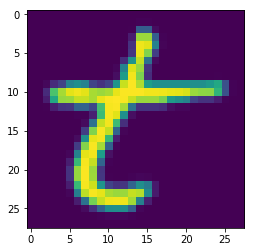

training set name:  train_t_108193.png
training set label:  g
IF measure:  0.00091248357434
train_t_108193.png


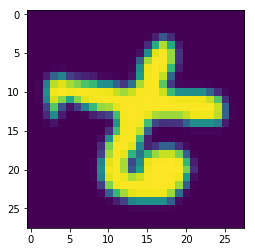

training set name:  train_t_53013.png
training set label:  F
IF measure:  0.000790537558232
train_t_53013.png


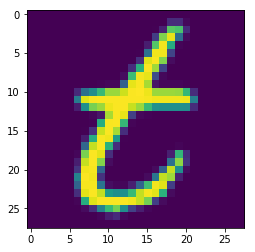

training set name:  train_t_15935.png
training set label:  E
IF measure:  0.0007859286621
train_t_15935.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



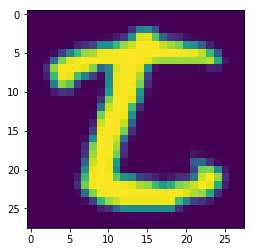

training set name:  train_t_22381.png
training set label:  t
IF measure:  -0.000656107917316
train_t_22381.png


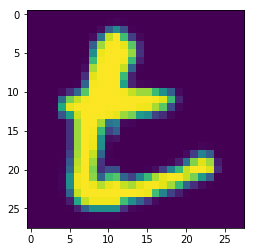

training set name:  train_t_23893.png
training set label:  t
IF measure:  -0.000643256023619
train_t_23893.png


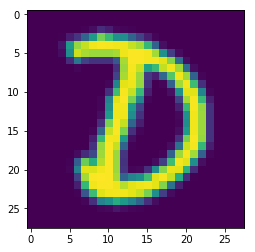

training set name:  train_D_92122.png
training set label:  t
IF measure:  -0.000609775232019
train_D_92122.png


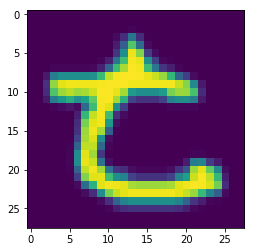

training set name:  train_t_84103.png
training set label:  t
IF measure:  -0.000605481730919
train_t_84103.png


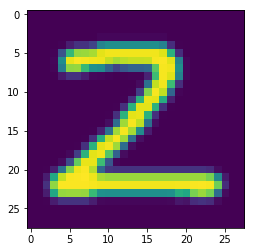

training set name:  train_Z_68584.png
training set label:  t
IF measure:  -0.000563888980987
train_Z_68584.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



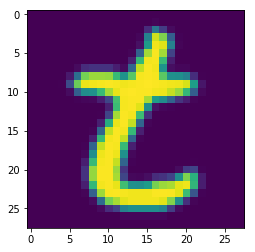

training set name:  train_t_55932.png
training set label:  a
IF measure:  0.000947735219507


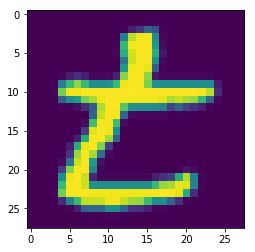

training set name:  train_t_17326.png
training set label:  d
IF measure:  0.000947063516145


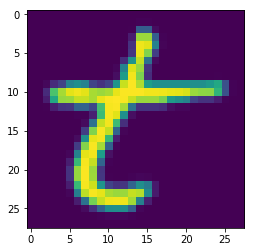

training set name:  train_t_108193.png
training set label:  g
IF measure:  0.00091248357434


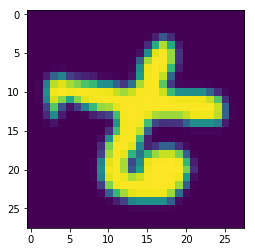

training set name:  train_t_53013.png
training set label:  F
IF measure:  0.000790537558232


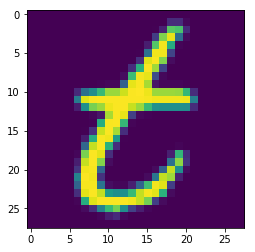

training set name:  train_t_15935.png
training set label:  E
IF measure:  0.0007859286621

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



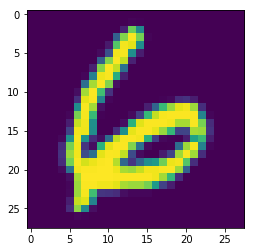

training set name:  train_6_111159.png
training set label:  6
IF measure:  1.17589279527e-12


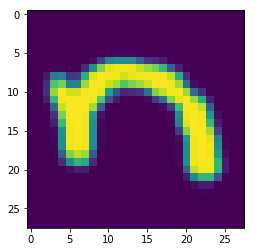

training set name:  train_n_90230.png
training set label:  n
IF measure:  -2.11004383391e-11


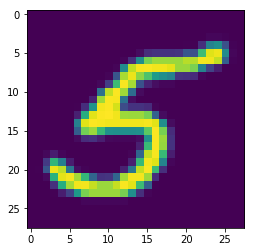

training set name:  train_5_76649.png
training set label:  5
IF measure:  -2.47801829489e-11


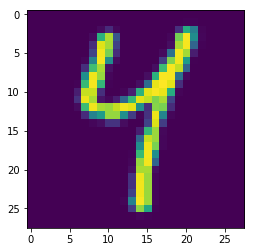

training set name:  train_Y_74199.png
training set label:  Y
IF measure:  5.84476127071e-11


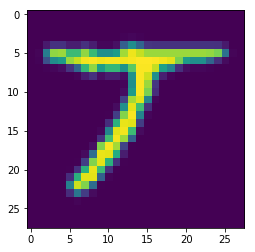

training set name:  train_T_70605.png
training set label:  J
IF measure:  6.67969030757e-11


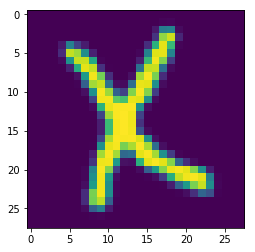

testfile name:  train_X_17045.png
ground truth label:  X
network prediction:  X
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 7891.7936203929585, time: 14.710920810699463 

Recursion depth: 1, norm: 14469.539585366909, time: 14.935073375701904 

Recursion depth: 2, norm: 19960.866644981874, time: 14.694773197174072 

Recursion depth: 3, norm: 24544.991940821656, time: 14.61281967163086 

Recursion depth: 4, norm: 28372.03387911237, time: 14.79117465019226 

Recursion depth: 5, norm: 31566.802981930243, time: 14.708655595779419 

Recursion depth: 6, norm: 34233.76366615275, time: 14.575968980789185 

Recursion depth: 7, norm: 36460.05310953345, time: 14.906436681747437 

Recursion depth: 8, norm: 38318.71016879352, time: 14.660382747650146 

Recursion depth: 9, norm: 39870.420003431114, time: 14.830900192260742 

Recursion depth: 10, norm: 41165.91836701812, time: 14.640477657318115 

Recursion depth: 11, norm: 42247.409186836536, time: 14.6523568

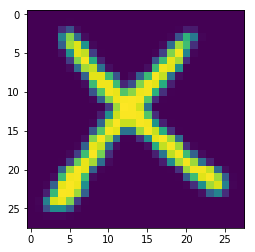

training set name:  train_X_6677.png
training set label:  K
IF measure:  0.00454816097354
train_X_6677.png


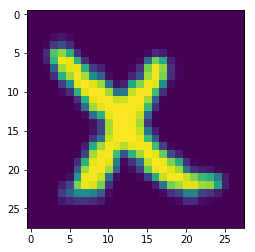

training set name:  train_X_28991.png
training set label:  g
IF measure:  0.00446092535524
train_X_28991.png


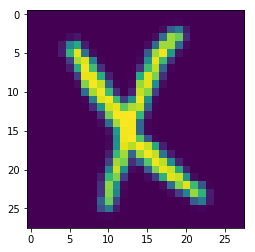

training set name:  train_X_104577.png
training set label:  G
IF measure:  0.00441388020173
train_X_104577.png


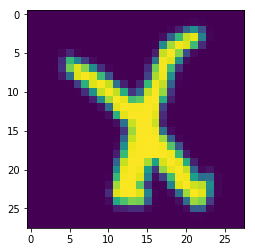

training set name:  train_X_20240.png
training set label:  K
IF measure:  0.00425592902387
train_X_20240.png


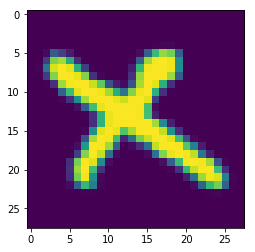

training set name:  train_X_71353.png
training set label:  Y
IF measure:  0.00403266585306
train_X_71353.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



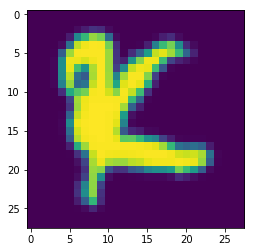

training set name:  train_X_28615.png
training set label:  X
IF measure:  -0.00307039618492
train_X_28615.png


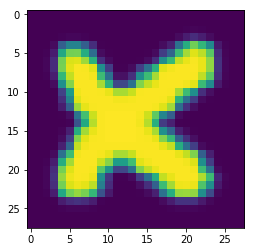

training set name:  train_X_111197.png
training set label:  X
IF measure:  -0.00305992947455
train_X_111197.png


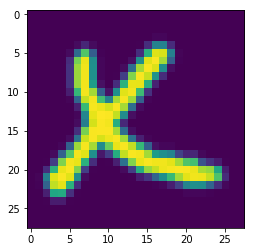

training set name:  train_X_50403.png
training set label:  X
IF measure:  -0.0029757358966
train_X_50403.png


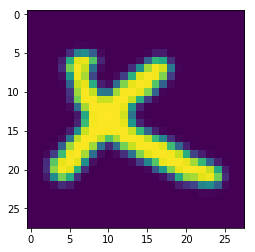

training set name:  train_X_38977.png
training set label:  X
IF measure:  -0.0029104240886
train_X_38977.png


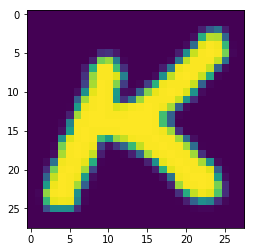

training set name:  train_K_62675.png
training set label:  X
IF measure:  -0.0028419023208
train_K_62675.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



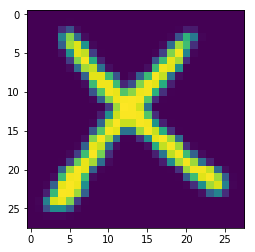

training set name:  train_X_6677.png
training set label:  K
IF measure:  0.00454816097354


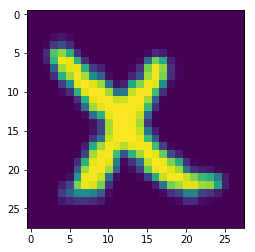

training set name:  train_X_28991.png
training set label:  g
IF measure:  0.00446092535524


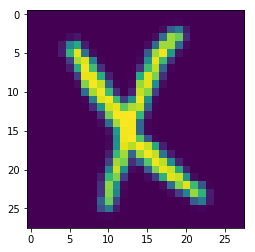

training set name:  train_X_104577.png
training set label:  G
IF measure:  0.00441388020173


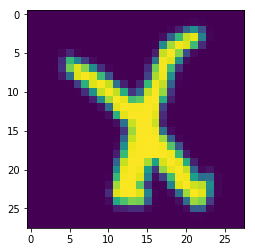

training set name:  train_X_20240.png
training set label:  K
IF measure:  0.00425592902387


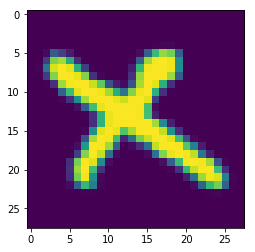

training set name:  train_X_71353.png
training set label:  Y
IF measure:  0.00403266585306

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



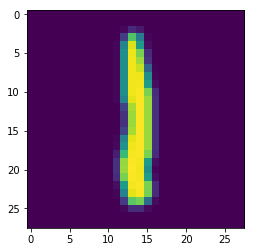

training set name:  train_1_30364.png
training set label:  1
IF measure:  -8.06670197936e-11


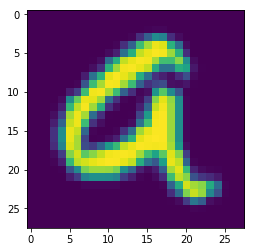

training set name:  train_a_61645.png
training set label:  a
IF measure:  1.25478017259e-10


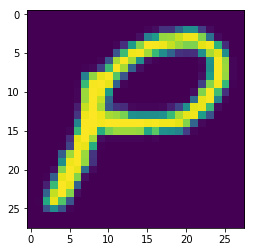

training set name:  train_P_76281.png
training set label:  P
IF measure:  -1.32361150566e-10


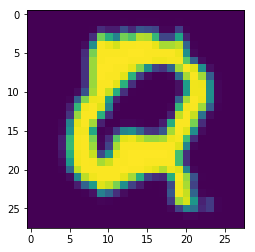

training set name:  train_Q_23891.png
training set label:  Q
IF measure:  -3.10136403241e-10


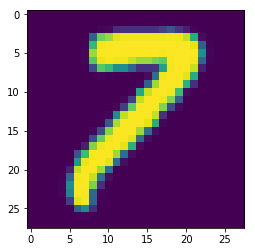

training set name:  train_7_15859.png
training set label:  7
IF measure:  -3.5070841361e-10


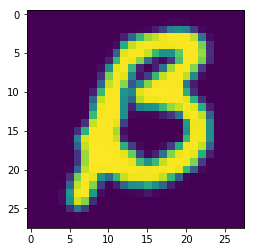

testfile name:  train_B_69574.png
ground truth label:  B
network prediction:  B
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 10806.541818645084, time: 14.467199802398682 

Recursion depth: 1, norm: 19817.219382711086, time: 14.710713386535645 

Recursion depth: 2, norm: 27339.42666736082, time: 14.582103490829468 

Recursion depth: 3, norm: 33619.27127965447, time: 14.533014297485352 

Recursion depth: 4, norm: 38861.830856252775, time: 14.571474552154541 

Recursion depth: 5, norm: 43238.35979486271, time: 14.642071723937988 

Recursion depth: 6, norm: 46891.968339471525, time: 14.726916074752808 

Recursion depth: 7, norm: 49942.00297344911, time: 14.712625741958618 

Recursion depth: 8, norm: 52488.22547248097, time: 14.855417013168335 

Recursion depth: 9, norm: 54613.833224742615, time: 14.519709587097168 

Recursion depth: 10, norm: 56387.84845602819, time: 14.782923936843872 

Recursion depth: 11, norm: 57869.016589190454, time: 14.593857

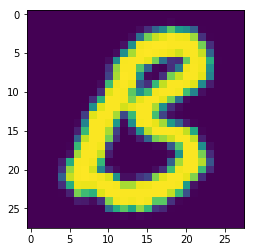

training set name:  train_B_66292.png
training set label:  f
IF measure:  0.00484822500788
train_B_66292.png


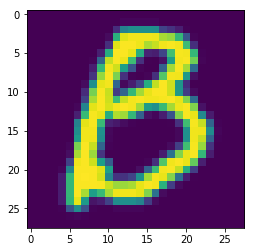

training set name:  train_B_100684.png
training set label:  a
IF measure:  0.00465167055686
train_B_100684.png


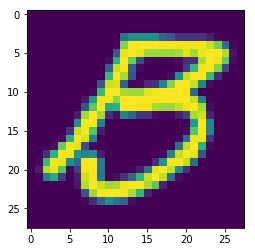

training set name:  train_B_75308.png
training set label:  b
IF measure:  0.00454973537501
train_B_75308.png


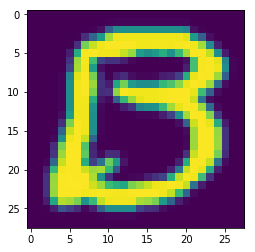

training set name:  train_b_8414.png
training set label:  O
IF measure:  0.00440264883986
train_b_8414.png


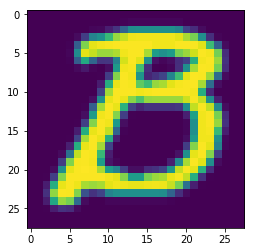

training set name:  train_B_72716.png
training set label:  g
IF measure:  0.00436043078014
train_B_72716.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



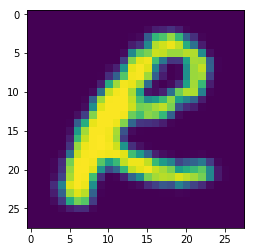

training set name:  train_R_49656.png
training set label:  B
IF measure:  -0.00436930651149
train_R_49656.png


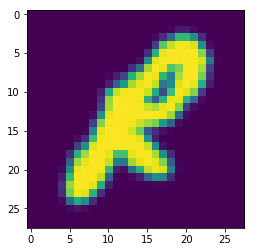

training set name:  train_R_13447.png
training set label:  B
IF measure:  -0.00411462474165
train_R_13447.png


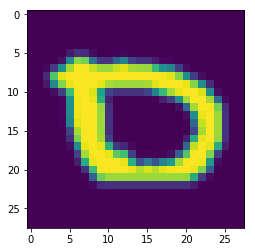

training set name:  train_D_27252.png
training set label:  B
IF measure:  -0.00407936869995
train_D_27252.png


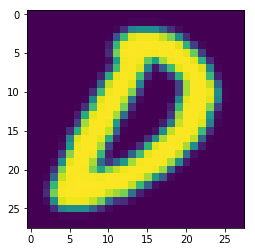

training set name:  train_D_33668.png
training set label:  B
IF measure:  -0.00406933864645
train_D_33668.png


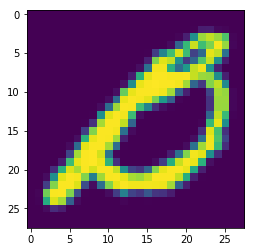

training set name:  train_B_69359.png
training set label:  B
IF measure:  -0.00403653395144
train_B_69359.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



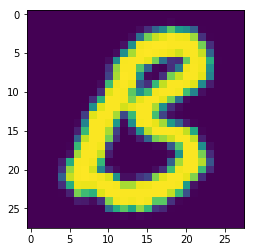

training set name:  train_B_66292.png
training set label:  f
IF measure:  0.00484822500788


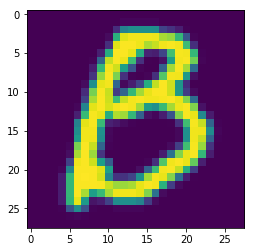

training set name:  train_B_100684.png
training set label:  a
IF measure:  0.00465167055686


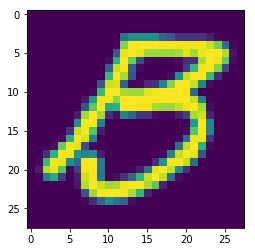

training set name:  train_B_75308.png
training set label:  b
IF measure:  0.00454973537501


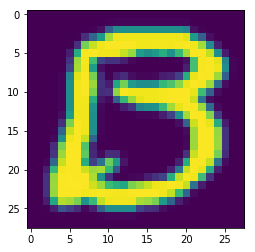

training set name:  train_b_8414.png
training set label:  O
IF measure:  0.00440264883986


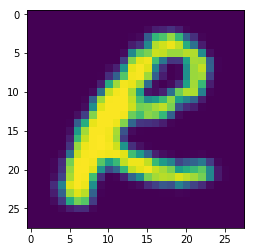

training set name:  train_R_49656.png
training set label:  B
IF measure:  -0.00436930651149

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



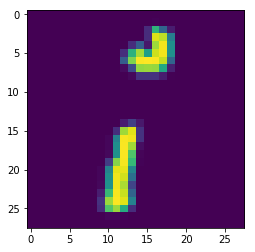

training set name:  train_I_75911.png
training set label:  I
IF measure:  3.19935724879e-11


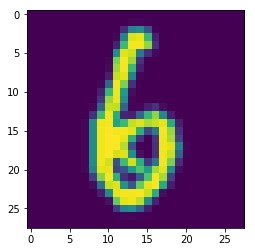

training set name:  train_6_144.png
training set label:  6
IF measure:  1.94491733042e-10


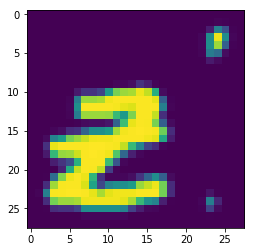

training set name:  train_Z_55780.png
training set label:  Z
IF measure:  -2.32296557403e-10


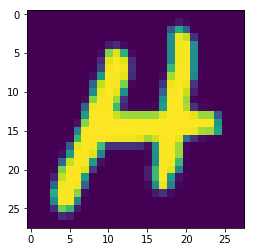

training set name:  train_H_24604.png
training set label:  H
IF measure:  2.32315535446e-10


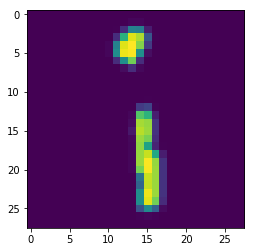

training set name:  train_J_66613.png
training set label:  J
IF measure:  -4.30612844673e-10


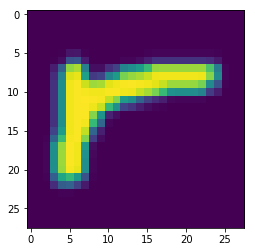

testfile name:  train_r_100253.png
ground truth label:  r
network prediction:  r
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 20349.636033293078, time: 14.925859451293945 

Recursion depth: 1, norm: 37324.47797357653, time: 14.58726167678833 

Recursion depth: 2, norm: 51495.7449261587, time: 14.684319257736206 

Recursion depth: 3, norm: 63326.006715250885, time: 14.607765674591064 

Recursion depth: 4, norm: 73202.16901841092, time: 14.594011306762695 

Recursion depth: 5, norm: 81446.84978561172, time: 14.79174256324768 

Recursion depth: 6, norm: 88329.96521000107, time: 15.126329183578491 

Recursion depth: 7, norm: 94075.81291702985, time: 14.715832471847534 

Recursion depth: 8, norm: 98872.52532427803, time: 14.93393588066101 

Recursion depth: 9, norm: 102876.92849225234, time: 14.624932765960693 

Recursion depth: 10, norm: 106220.0214083955, time: 15.100490808486938 

Recursion depth: 11, norm: 109010.88947440067, time: 14.76753091812

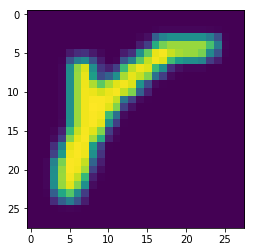

training set name:  train_r_108347.png
training set label:  8
IF measure:  0.00897630141876
train_r_108347.png


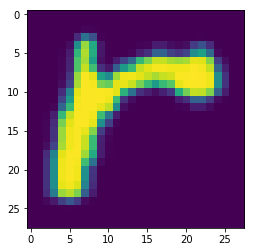

training set name:  train_r_104591.png
training set label:  e
IF measure:  0.00833629301042
train_r_104591.png


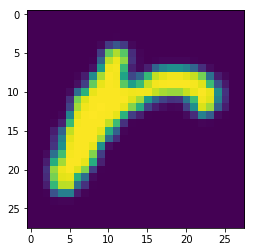

training set name:  train_r_55964.png
training set label:  8
IF measure:  0.00804586733909
train_r_55964.png


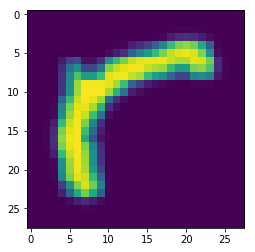

training set name:  train_r_93252.png
training set label:  8
IF measure:  0.00742600087261
train_r_93252.png


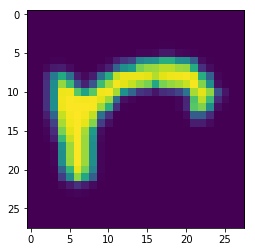

training set name:  train_r_21510.png
training set label:  f
IF measure:  0.00718852646702
train_r_21510.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



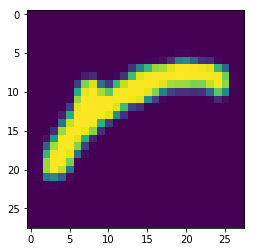

training set name:  train_r_29379.png
training set label:  r
IF measure:  -0.00965318427758
train_r_29379.png


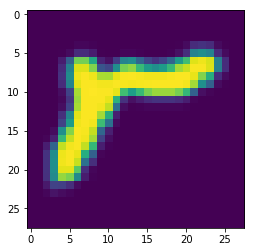

training set name:  train_r_25763.png
training set label:  r
IF measure:  -0.00935564893463
train_r_25763.png


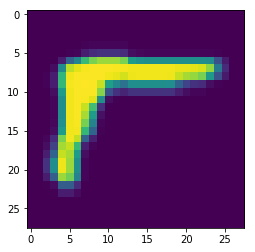

training set name:  train_r_61839.png
training set label:  r
IF measure:  -0.00897197824843
train_r_61839.png


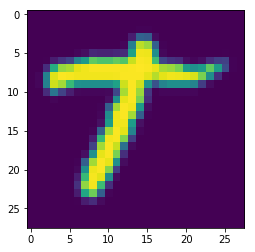

training set name:  train_t_111381.png
training set label:  r
IF measure:  -0.00848312581896
train_t_111381.png


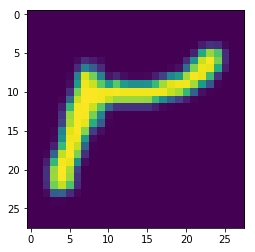

training set name:  train_r_91887.png
training set label:  r
IF measure:  -0.00838092243735
train_r_91887.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



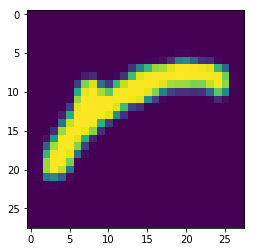

training set name:  train_r_29379.png
training set label:  r
IF measure:  -0.00965318427758


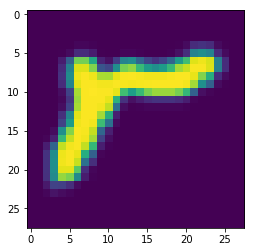

training set name:  train_r_25763.png
training set label:  r
IF measure:  -0.00935564893463


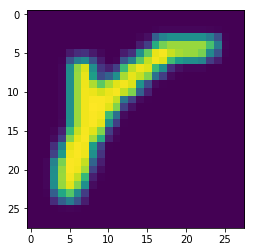

training set name:  train_r_108347.png
training set label:  8
IF measure:  0.00897630141876


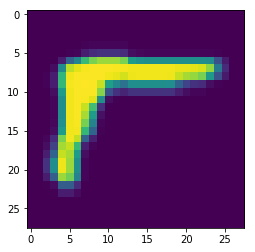

training set name:  train_r_61839.png
training set label:  r
IF measure:  -0.00897197824843


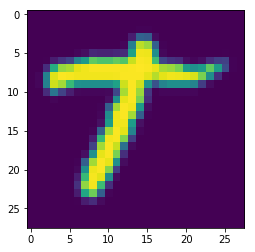

training set name:  train_t_111381.png
training set label:  r
IF measure:  -0.00848312581896

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



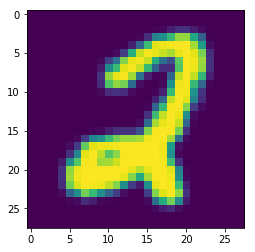

training set name:  train_2_105101.png
training set label:  2
IF measure:  -3.05877258904e-11


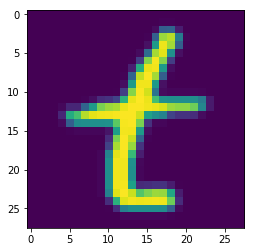

training set name:  train_t_4990.png
training set label:  t
IF measure:  1.480321958e-10


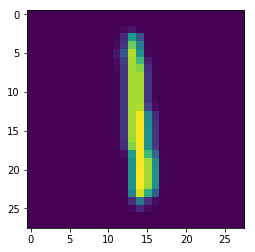

training set name:  train_1_15549.png
training set label:  1
IF measure:  1.8315804224e-10


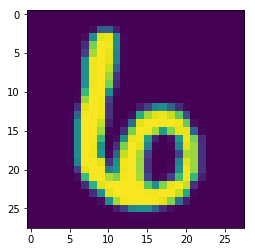

training set name:  train_6_34846.png
training set label:  6
IF measure:  -2.40106601268e-10


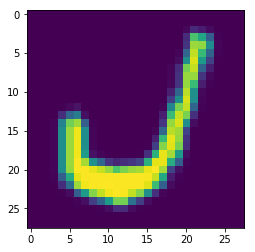

training set name:  train_J_64664.png
training set label:  O
IF measure:  4.88392204535e-10


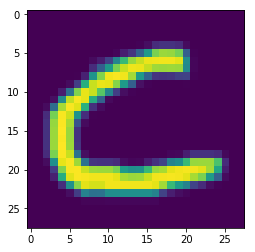

testfile name:  train_C_29303.png
ground truth label:  C
network prediction:  C
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 12619.4984170083, time: 14.578705549240112 

Recursion depth: 1, norm: 23143.785942451163, time: 14.575908899307251 

Recursion depth: 2, norm: 31929.41723747867, time: 14.903106451034546 

Recursion depth: 3, norm: 39264.020034250185, time: 14.647924423217773 

Recursion depth: 4, norm: 45387.07805091665, time: 14.580073356628418 

Recursion depth: 5, norm: 50498.69471085366, time: 14.657815933227539 

Recursion depth: 6, norm: 54766.001839645, time: 14.532854318618774 

Recursion depth: 7, norm: 58328.42420724222, time: 14.849941968917847 

Recursion depth: 8, norm: 61302.305099400626, time: 14.800510883331299 

Recursion depth: 9, norm: 63784.98302500362, time: 14.60839033126831 

Recursion depth: 10, norm: 65857.688769042, time: 14.658085823059082 

Recursion depth: 11, norm: 67587.72262770806, time: 14.573580265045166

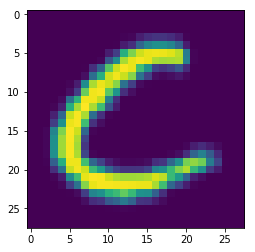

training set name:  train_C_8140.png
training set label:  K
IF measure:  0.00742058851987
train_C_8140.png


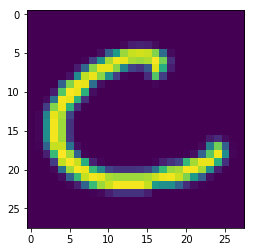

training set name:  train_C_21417.png
training set label:  K
IF measure:  0.00673399188734
train_C_21417.png


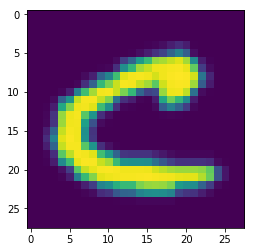

training set name:  train_C_4985.png
training set label:  L
IF measure:  0.00661213350159
train_C_4985.png


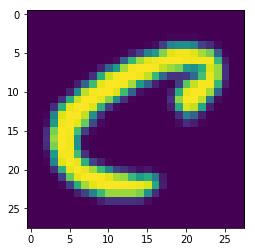

training set name:  train_C_78099.png
training set label:  0
IF measure:  0.00602285282039
train_C_78099.png


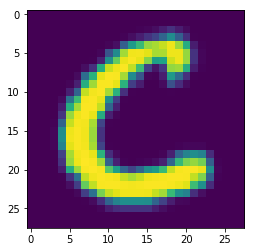

training set name:  train_C_92777.png
training set label:  h
IF measure:  0.00589142498289
train_C_92777.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



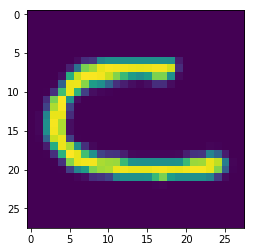

training set name:  train_C_80886.png
training set label:  C
IF measure:  -0.00632905322821
train_C_80886.png


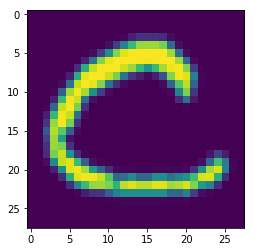

training set name:  train_C_40263.png
training set label:  C
IF measure:  -0.00626701777339
train_C_40263.png


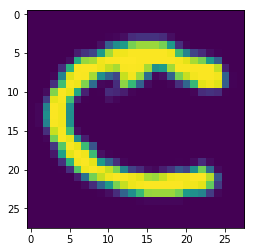

training set name:  train_C_73824.png
training set label:  C
IF measure:  -0.00608138002402
train_C_73824.png


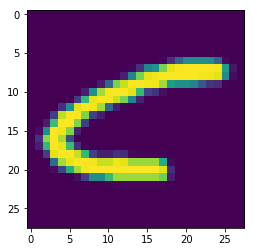

training set name:  train_C_35524.png
training set label:  C
IF measure:  -0.00582815880841
train_C_35524.png


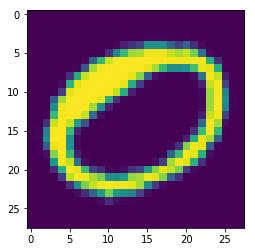

training set name:  train_0_109690.png
training set label:  C
IF measure:  -0.00554657693397
train_0_109690.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



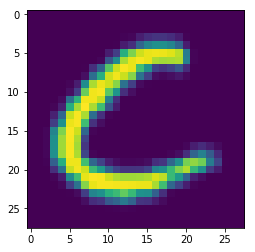

training set name:  train_C_8140.png
training set label:  K
IF measure:  0.00742058851987


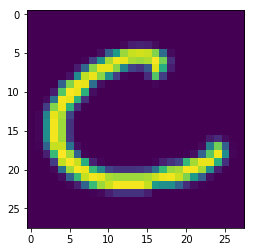

training set name:  train_C_21417.png
training set label:  K
IF measure:  0.00673399188734


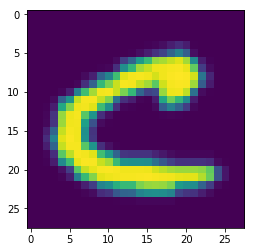

training set name:  train_C_4985.png
training set label:  L
IF measure:  0.00661213350159


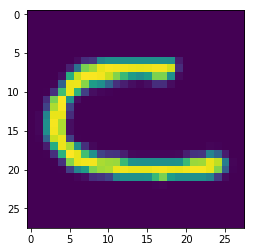

training set name:  train_C_80886.png
training set label:  C
IF measure:  -0.00632905322821


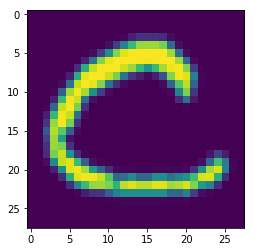

training set name:  train_C_40263.png
training set label:  C
IF measure:  -0.00626701777339

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



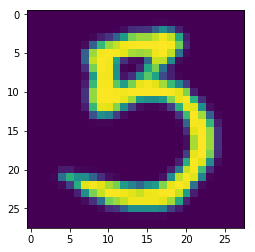

training set name:  train_5_62367.png
training set label:  5
IF measure:  -5.7397501094e-11


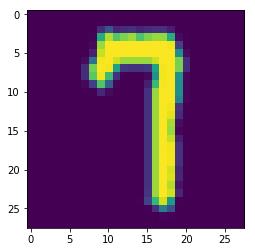

training set name:  train_7_48741.png
training set label:  7
IF measure:  -6.71761817173e-11


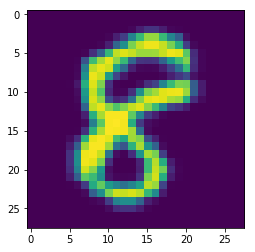

training set name:  train_8_8385.png
training set label:  A
IF measure:  1.89941195632e-10


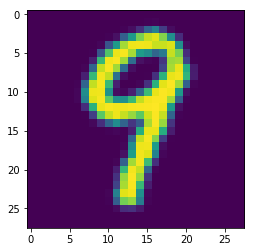

training set name:  train_q_82756.png
training set label:  9
IF measure:  -2.33880755267e-10


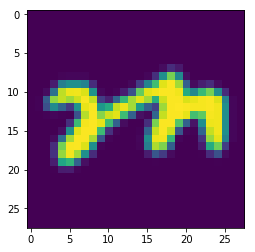

training set name:  train_M_16826.png
training set label:  M
IF measure:  4.78843477714e-10


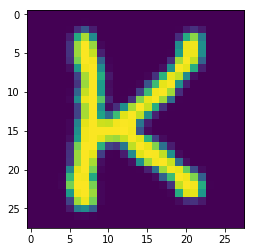

testfile name:  train_K_97272.png
ground truth label:  K
network prediction:  K
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 3788.6923497681105, time: 14.501270532608032 

Recursion depth: 1, norm: 6939.952051037753, time: 14.777472972869873 

Recursion depth: 2, norm: 9570.181548900013, time: 14.499749183654785 

Recursion depth: 3, norm: 11765.737900520731, time: 15.084075212478638 

Recursion depth: 4, norm: 13598.48870422969, time: 14.612416505813599 

Recursion depth: 5, norm: 15128.395000172688, time: 14.603984832763672 

Recursion depth: 6, norm: 16405.723603460014, time: 14.602303981781006 

Recursion depth: 7, norm: 17472.015066510645, time: 14.681121110916138 

Recursion depth: 8, norm: 18362.31408772462, time: 14.604694604873657 

Recursion depth: 9, norm: 19105.51129623662, time: 14.694741249084473 

Recursion depth: 10, norm: 19725.936075697395, time: 14.656531572341919 

Recursion depth: 11, norm: 20243.948826979755, time: 14.57364

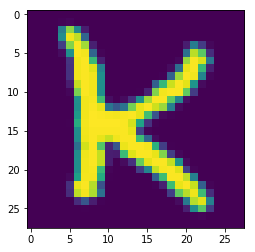

training set name:  train_K_33680.png
training set label:  q
IF measure:  0.00250412309179
train_K_33680.png


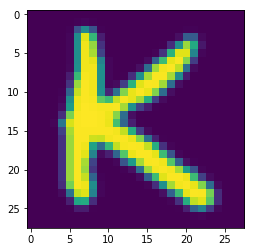

training set name:  train_K_50196.png
training set label:  f
IF measure:  0.00215713474701
train_K_50196.png


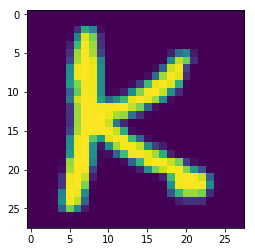

training set name:  train_K_49008.png
training set label:  0
IF measure:  0.00208426027407
train_K_49008.png


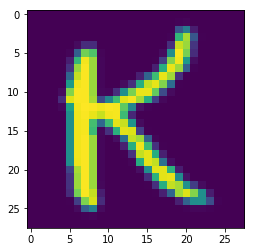

training set name:  train_K_2072.png
training set label:  t
IF measure:  0.00192416118828
train_K_2072.png


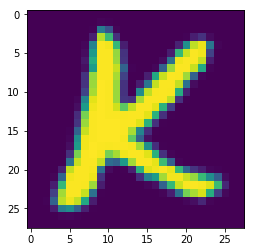

training set name:  train_K_90212.png
training set label:  t
IF measure:  0.00190109412404
train_K_90212.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



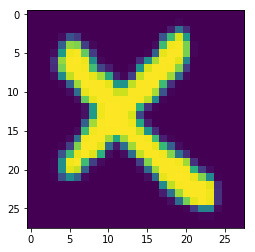

training set name:  train_X_28586.png
training set label:  K
IF measure:  -0.00155424308263
train_X_28586.png


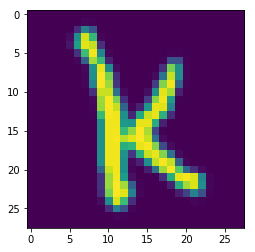

training set name:  train_K_16995.png
training set label:  K
IF measure:  -0.00138812617841
train_K_16995.png


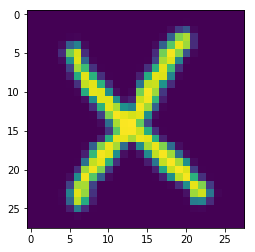

training set name:  train_X_73548.png
training set label:  K
IF measure:  -0.00136044974908
train_X_73548.png


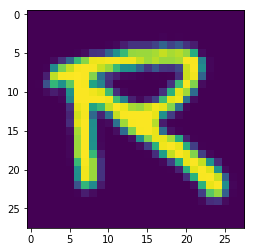

training set name:  train_R_67414.png
training set label:  K
IF measure:  -0.00133587507108
train_R_67414.png


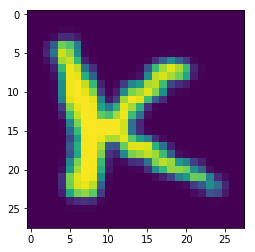

training set name:  train_K_41808.png
training set label:  K
IF measure:  -0.0013017328958
train_K_41808.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



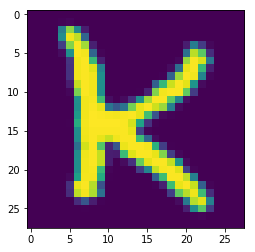

training set name:  train_K_33680.png
training set label:  q
IF measure:  0.00250412309179


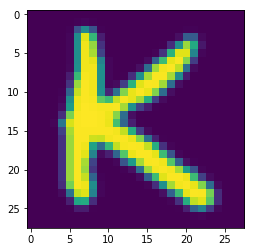

training set name:  train_K_50196.png
training set label:  f
IF measure:  0.00215713474701


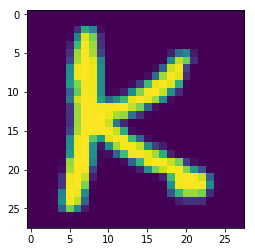

training set name:  train_K_49008.png
training set label:  0
IF measure:  0.00208426027407


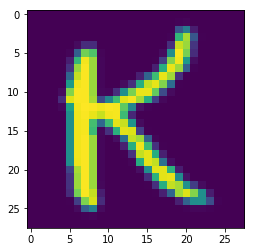

training set name:  train_K_2072.png
training set label:  t
IF measure:  0.00192416118828


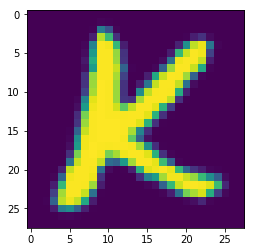

training set name:  train_K_90212.png
training set label:  t
IF measure:  0.00190109412404

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



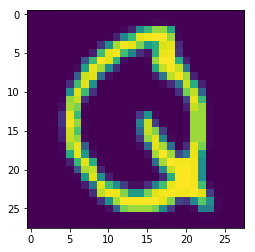

training set name:  train_Q_19496.png
training set label:  Q
IF measure:  -8.9743260892e-12


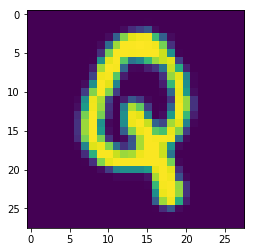

training set name:  train_Q_76206.png
training set label:  Q
IF measure:  -4.80415984378e-11


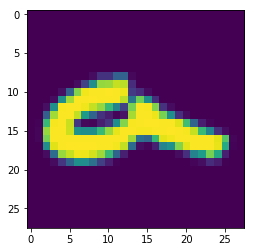

training set name:  train_a_94812.png
training set label:  a
IF measure:  1.30601826595e-10


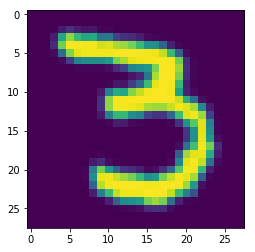

training set name:  train_3_12479.png
training set label:  O
IF measure:  1.53886019766e-10


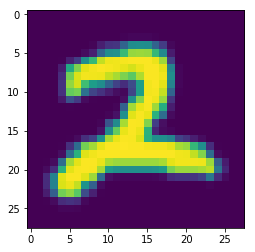

training set name:  train_2_31112.png
training set label:  2
IF measure:  1.91159015488e-10


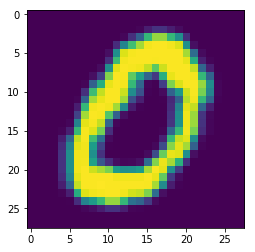

testfile name:  train_0_104721.png
ground truth label:  0
network prediction:  0
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 18079.898371534062, time: 14.673566102981567 

Recursion depth: 1, norm: 33160.52399691537, time: 14.867731809616089 

Recursion depth: 2, norm: 45750.05687154935, time: 14.679028272628784 

Recursion depth: 3, norm: 56260.01565499249, time: 14.620479345321655 

Recursion depth: 4, norm: 65034.15296211676, time: 14.8998281955719 

Recursion depth: 5, norm: 72358.90530542872, time: 14.783400058746338 

Recursion depth: 6, norm: 78473.66656401369, time: 14.843839406967163 

Recursion depth: 7, norm: 83578.60811236329, time: 14.553818702697754 

Recursion depth: 8, norm: 87840.27766349558, time: 14.539413928985596 

Recursion depth: 9, norm: 91398.0316308836, time: 14.59199857711792 

Recursion depth: 10, norm: 94368.21948622321, time: 15.017464876174927 

Recursion depth: 11, norm: 96847.85523696433, time: 14.66060996055603

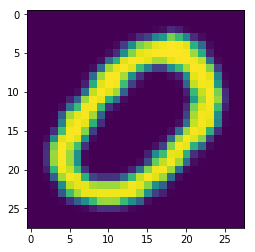

training set name:  train_0_5355.png
training set label:  O
IF measure:  0.0136849460397
train_0_5355.png


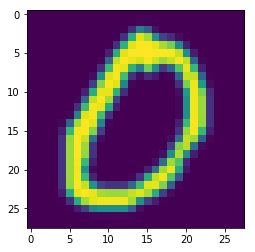

training set name:  train_O_8261.png
training set label:  O
IF measure:  0.0124117849302
train_O_8261.png


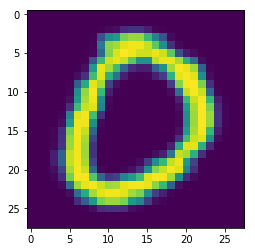

training set name:  train_O_23546.png
training set label:  O
IF measure:  0.0118598939309
train_O_23546.png


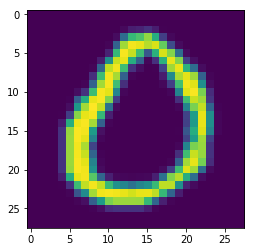

training set name:  train_0_59583.png
training set label:  O
IF measure:  0.011624993516
train_0_59583.png


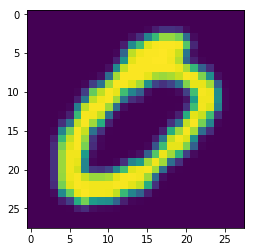

training set name:  train_O_20886.png
training set label:  O
IF measure:  0.0114229485604
train_O_20886.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



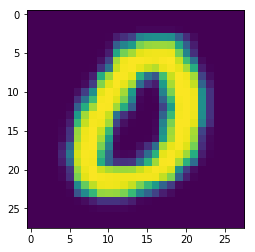

training set name:  train_0_70853.png
training set label:  0
IF measure:  -0.0106146698355
train_0_70853.png


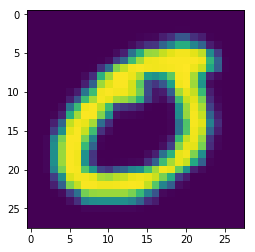

training set name:  train_0_99056.png
training set label:  0
IF measure:  -0.00997611897212
train_0_99056.png


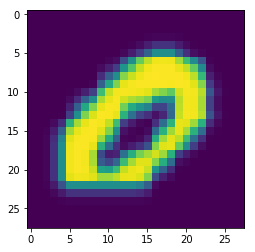

training set name:  train_0_46074.png
training set label:  0
IF measure:  -0.00974311611437
train_0_46074.png


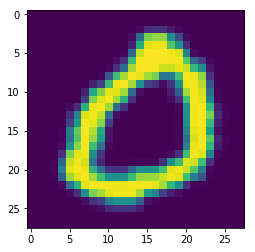

training set name:  train_0_91812.png
training set label:  0
IF measure:  -0.00959777879852
train_0_91812.png


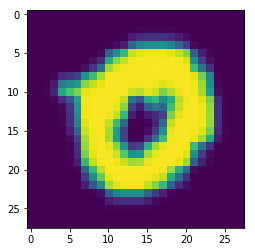

training set name:  train_0_14342.png
training set label:  0
IF measure:  -0.00955562064728
train_0_14342.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



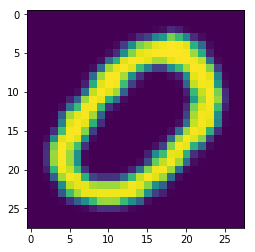

training set name:  train_0_5355.png
training set label:  O
IF measure:  0.0136849460397


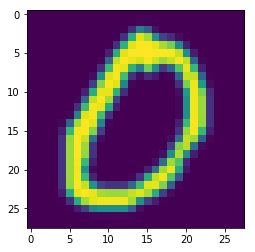

training set name:  train_O_8261.png
training set label:  O
IF measure:  0.0124117849302


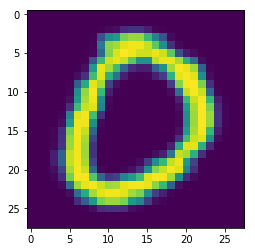

training set name:  train_O_23546.png
training set label:  O
IF measure:  0.0118598939309


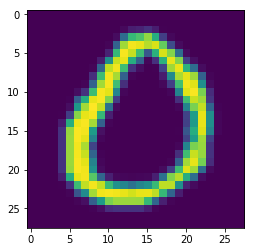

training set name:  train_0_59583.png
training set label:  O
IF measure:  0.011624993516


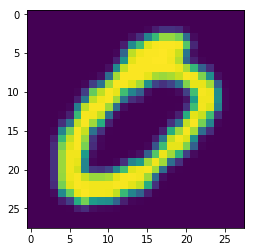

training set name:  train_O_20886.png
training set label:  O
IF measure:  0.0114229485604

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



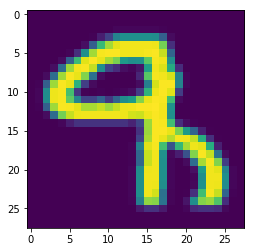

training set name:  train_q_39146.png
training set label:  q
IF measure:  3.62835977181e-11


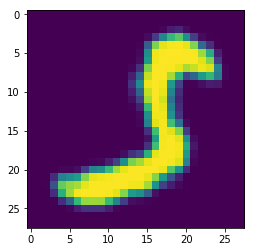

training set name:  train_S_57929.png
training set label:  S
IF measure:  5.5072806835e-11


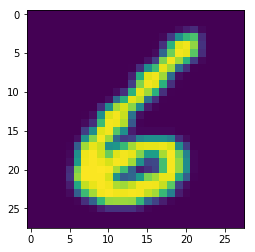

training set name:  train_6_32286.png
training set label:  6
IF measure:  8.45779276402e-11


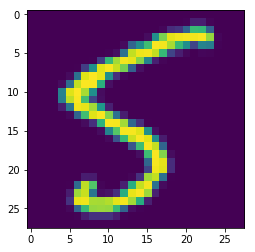

training set name:  train_S_28554.png
training set label:  S
IF measure:  1.96383772286e-10


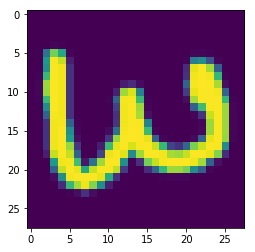

training set name:  train_W_44120.png
training set label:  W
IF measure:  -4.1675320972e-10


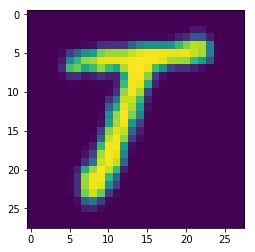

testfile name:  train_T_32704.png
ground truth label:  T
network prediction:  T
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 3608.05002547472, time: 14.539998531341553 

Recursion depth: 1, norm: 6607.403579508368, time: 14.540961027145386 

Recursion depth: 2, norm: 9110.783296800008, time: 14.758216619491577 

Recursion depth: 3, norm: 11200.348741082797, time: 14.737522602081299 

Recursion depth: 4, norm: 12944.648223300625, time: 14.602118492126465 

Recursion depth: 5, norm: 14400.900861035569, time: 14.749554634094238 

Recursion depth: 6, norm: 15616.596302091566, time: 14.88980221748352 

Recursion depth: 7, norm: 16631.59271537155, time: 14.740762948989868 

Recursion depth: 8, norm: 17478.83783768961, time: 14.639755487442017 

Recursion depth: 9, norm: 18186.01441097664, time: 14.615984916687012 

Recursion depth: 10, norm: 18776.428968589847, time: 14.747416734695435 

Recursion depth: 11, norm: 19269.388250863078, time: 14.65456938

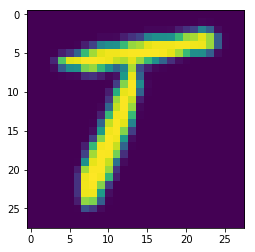

training set name:  train_T_36798.png
training set label:  t
IF measure:  0.00223112760561
train_T_36798.png


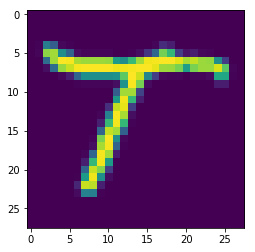

training set name:  train_T_62244.png
training set label:  I
IF measure:  0.00211456906024
train_T_62244.png


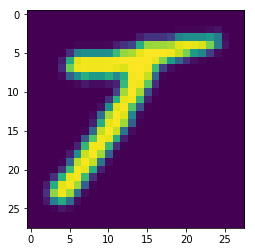

training set name:  train_T_26929.png
training set label:  A
IF measure:  0.00204838507062
train_T_26929.png


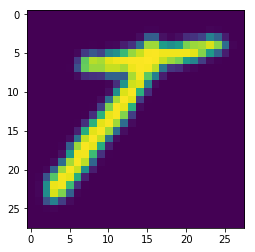

training set name:  train_T_63426.png
training set label:  I
IF measure:  0.0020192441121
train_T_63426.png


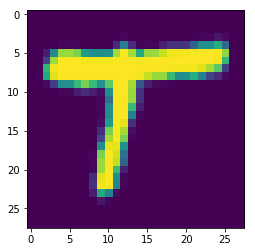

training set name:  train_T_28354.png
training set label:  Q
IF measure:  0.00201181898171
train_T_28354.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



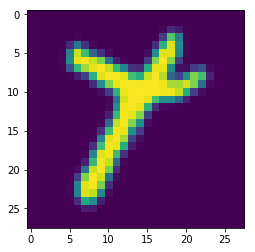

training set name:  train_T_107231.png
training set label:  T
IF measure:  -0.00143968497423
train_T_107231.png


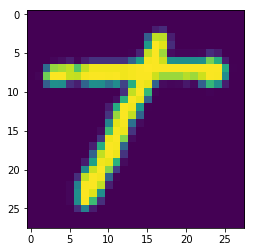

training set name:  train_T_83678.png
training set label:  T
IF measure:  -0.00141866660763
train_T_83678.png


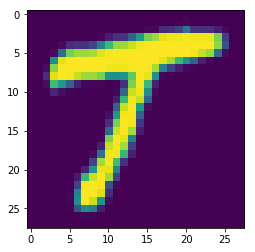

training set name:  train_T_84817.png
training set label:  T
IF measure:  -0.00135478095204
train_T_84817.png


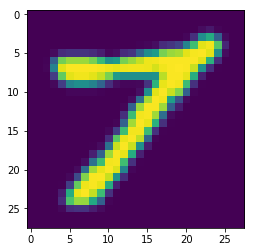

training set name:  train_T_54106.png
training set label:  T
IF measure:  -0.00129207132305
train_T_54106.png


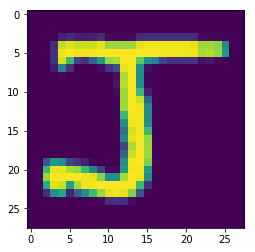

training set name:  train_J_74330.png
training set label:  T
IF measure:  -0.00125189706591
train_J_74330.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



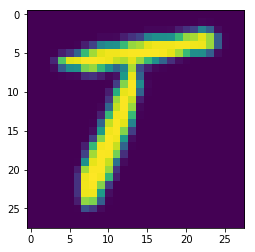

training set name:  train_T_36798.png
training set label:  t
IF measure:  0.00223112760561


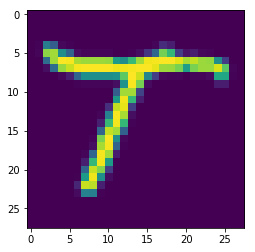

training set name:  train_T_62244.png
training set label:  I
IF measure:  0.00211456906024


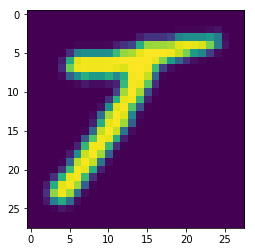

training set name:  train_T_26929.png
training set label:  A
IF measure:  0.00204838507062


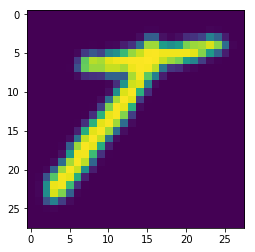

training set name:  train_T_63426.png
training set label:  I
IF measure:  0.0020192441121


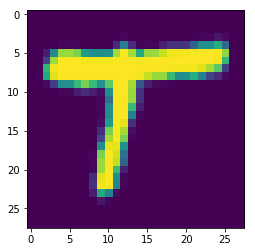

training set name:  train_T_28354.png
training set label:  Q
IF measure:  0.00201181898171

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



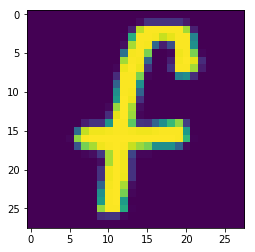

training set name:  train_f_21742.png
training set label:  f
IF measure:  5.81334822676e-12


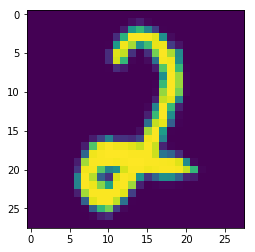

training set name:  train_2_74542.png
training set label:  2
IF measure:  1.61225674261e-11


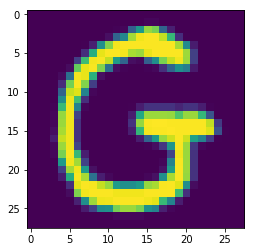

training set name:  train_G_66474.png
training set label:  G
IF measure:  -1.76334735623e-11


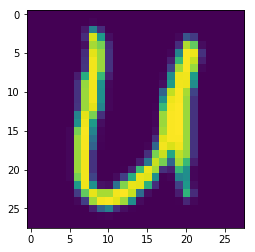

training set name:  train_U_60846.png
training set label:  U
IF measure:  -2.26067486244e-11


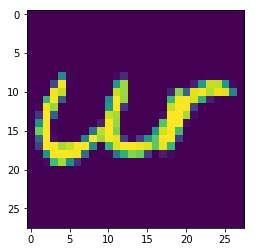

training set name:  train_W_7486.png
training set label:  W
IF measure:  3.40554163278e-11


In [13]:
# calculate IF measure for each samples of each classes

# WITH SEVERAL METHODOLOGIES

temp_list, _ = dataset.read_data_subset(root_dir, mode='validation1')

print('num_of_samples',len(temp_list))

# restore trainval_list, test_list
#file_dir = './compare/result_net_nn_if_nn/train_e_99502'
file_dir = './sample/result_net_nn_if_nn/train_B_69574'

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
test_list = list(np.load(file_dir+'/test_list.npy'))

dic = {ks: [] for ks in anno_dict['classes'].values()}

for tl in temp_list:
    dic[tl.split('_')[1]].append(tl)
    
#sample_list = [dic[ks][0] for ks in dic.keys()]
sample_list = list(np.load('./sample/result_net_nn_if_nn/train_B_69574/sample_list.npy'))
sample_set = dataset.LazyDataset(root_dir, sample_list, anno_dict) # non-noisy dataset

    
print(len(sample_list), sample_list)

# # network trained with non-noisy dataset, influence value with non-noisy dataset
# save_dir = './sample/result_net_nn_if_nn'
# restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

# network trained with noisy dataset, influence value with noisy dataset
save_dir = './sample/result_net_ns_if_ns'
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn' # noisy network
train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset


for idx_test in range(47):
    # Set a single test image

    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = sample_list[idx_test]
    img_test, lb_test = sample_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)
    np.save(save_path+'/temp_list', temp_list)
    np.save(save_path+'/sample_list', sample_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

#     # Calculate influence functions

#     # CG-FREEZE (1885 sec)
#     t1 = time.time()
#     ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':50})
#     IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
#     print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))
#     np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)
#     #IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')
#     visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path+'/cg-frz')
    
#     # VECTOR-FREEZE (175 sec)
#     t1 = time.time()
#     IF_v_logreg = IF_val(net, v_logreg, train_set)
#     print('V_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_logreg),min(IF_v_logreg)]))
#     np.save(save_path+'/if_v_logreg.npy', IF_v_logreg)
#     #IF_v_logreg = np.load(save_path+'/if_v_logreg.npy')
#     visualize_topk_samples(IF_v_logreg, train_set, num_sample=5, save_path=save_path+'/vec-frz')

#     # Vector-FULL (1688 sec)
#     t1 = time.time()
#     IF_v = IF_val(net, v_test, train_set)
#     print('V takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v),min(IF_v)]))
#     np.save(save_path+'/if_v.npy', IF_v)
#     #IF_v = np.load(save_path+'/if_v.npy')
#     visualize_topk_samples(IF_v, train_set, num_sample=5, save_path=save_path+'/v')
    
#     # VECTOR-FREEZE-cosine-similarity (178 sec)
#     t1 = time.time()
#     IF_v_cos = IF_val(net, v_logreg, train_set, cosine=True)
#     print('V_cos takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_cos),min(IF_v_cos)]))
#     np.save(save_path+'/if_v_cos.npy', IF_v_cos)
#     #IF_v_cos = np.load(save_path+'/if_v_cos.npy')
#     visualize_topk_samples(IF_v_cos, train_set, num_sample=5, save_path=save_path+'/vec-cos')

#     # CG-FULL (1epoch, more than 3 hours, did it stuck at line search as it happened in ncg?)
#     t1 = time.time()
#     ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_test, train_set,**{'damping':0.1, 'maxiter':100})
#     IF_cg = IF_val(net, ihvp_cg, train_set)
#     print('CG takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg),min(IF_cg)]))
#     np.save(save_path+'/if_cg.npy', IF_cg)
#     visualize_topk_samples(IF_cg, train_set, num_sample=5, save_path=save_path+'/cg')
    
#     # SE-FULL (? sec: diverge)
#     t1 = time.time()
#     ihvp_se = get_inverse_hvp_se(net, net.loss, v_test, train_set,**{'scale':1e5, 'damping':0.1, 'batch_size':50, 'recursion_depth':100})
#     IF_se = IF_val(net, ihvp_se, train_set)
#     print('SE takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se),min(IF_se)]))
#     np.save(save_path+'/if_se.npy', IF_se)
#     visualize_topk_samples(IF_se, train_set, num_sample=5, save_path=save_path+'/se')
    
    # SE-FREEZE (1065 sec)
    t1 = time.time()
    ihvp_se_logreg = get_inverse_hvp_se(net, net.loss, v_logreg, train_set,**{'scale':1e3, 'damping':0.1, 'batch_size':50, 'tolerance':0, 'recursion_depth':65})
    IF_se_logreg = IF_val(net, ihvp_se_logreg, train_set)
    print('SE_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se_logreg),min(IF_se_logreg)]))
    np.save(save_path+'/if_se_logreg.npy', IF_se_logreg)
    #IF_se_logreg = np.load(save_path+'/if_se_logreg.npy')
    visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=save_path+'/se-frz')
    

In [18]:
def normalize_list(ls):
    # normalize elements in the list. 
    # the distribution of each element follows normal distribution
    # i.e. (x_i-mean)/sigma
    
    m = np.mean(ls)
    v = np.sqrt(np.var(ls))
    
    return np.array([(e-m)/v for e in ls])

sample/result_net_ns_if_ns/train_8_100781/if_se_logreg.npy
sample/result_net_ns_if_ns/train_J_9128/if_se_logreg.npy
sample/result_net_ns_if_ns/train_H_100708/if_se_logreg.npy
sample/result_net_ns_if_ns/train_h_6101/if_se_logreg.npy
sample/result_net_ns_if_ns/train_t_67915/if_se_logreg.npy
sample/result_net_ns_if_ns/train_P_104114/if_se_logreg.npy
sample/result_net_ns_if_ns/train_7_74705/if_se_logreg.npy
sample/result_net_ns_if_ns/train_Q_54865/if_se_logreg.npy
sample/result_net_ns_if_ns/train_F_41402/if_se_logreg.npy
sample/result_net_ns_if_ns/train_1_31620/if_se_logreg.npy
sample/result_net_ns_if_ns/train_q_67554/if_se_logreg.npy
sample/result_net_ns_if_ns/train_9_71069/if_se_logreg.npy
sample/result_net_ns_if_ns/train_3_20482/if_se_logreg.npy
sample/result_net_ns_if_ns/train_O_3897/if_se_logreg.npy
sample/result_net_ns_if_ns/train_N_43201/if_se_logreg.npy
sample/result_net_ns_if_ns/train_g_11056/if_se_logreg.npy
sample/result_net_ns_if_ns/train_L_66551/if_se_logreg.npy
sample/result_

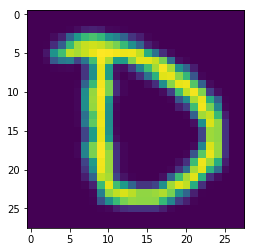

training set name:  train_D_100338.png
training set label:  R
IF measure:  0.000416131404837
train_D_100338.png


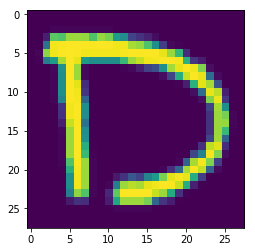

training set name:  train_D_39370.png
training set label:  O
IF measure:  0.000385118308921
train_D_39370.png


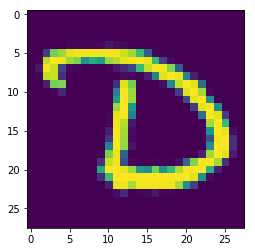

training set name:  train_D_34787.png
training set label:  q
IF measure:  0.00037124788342
train_D_34787.png


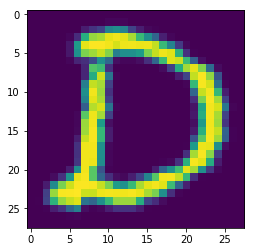

training set name:  train_D_26789.png
training set label:  2
IF measure:  0.000351685800331
train_D_26789.png


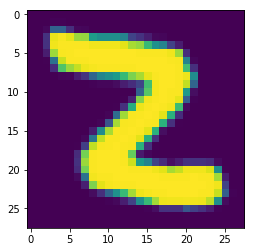

training set name:  train_Z_109846.png
training set label:  2
IF measure:  0.000347893088277
train_Z_109846.png


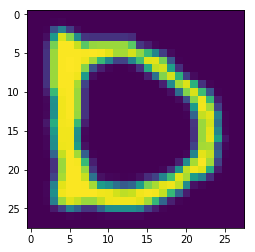

training set name:  train_D_42112.png
training set label:  H
IF measure:  0.000344805841412
train_D_42112.png


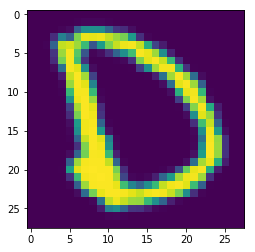

training set name:  train_D_111377.png
training set label:  F
IF measure:  0.000334698993333
train_D_111377.png


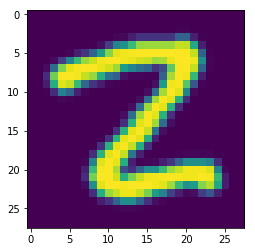

training set name:  train_2_58015.png
training set label:  2
IF measure:  0.000329562344177
train_2_58015.png


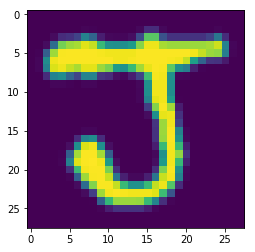

training set name:  train_J_18134.png
training set label:  5
IF measure:  0.000329065566585
train_J_18134.png


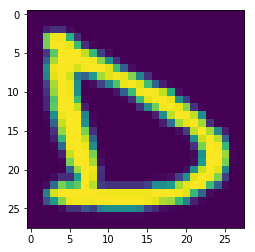

training set name:  train_D_60860.png
training set label:  K
IF measure:  0.000316710204015
train_D_60860.png


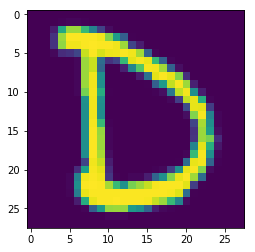

training set name:  train_D_112561.png
training set label:  B
IF measure:  0.000316290320302
train_D_112561.png


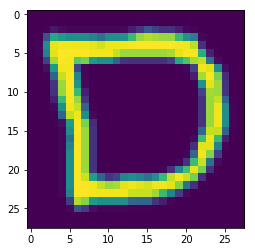

training set name:  train_D_49247.png
training set label:  F
IF measure:  0.000313501330759
train_D_49247.png


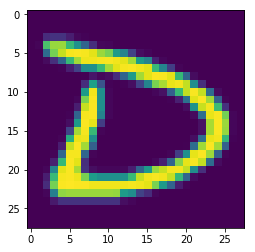

training set name:  train_D_73335.png
training set label:  N
IF measure:  0.000307477116094
train_D_73335.png


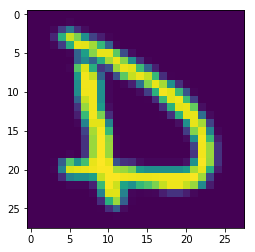

training set name:  train_D_21846.png
training set label:  K
IF measure:  0.000304733649319
train_D_21846.png


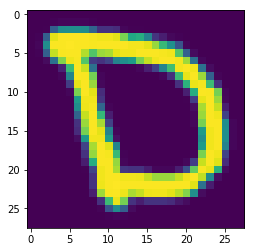

training set name:  train_D_37150.png
training set label:  X
IF measure:  0.000303866490685
train_D_37150.png


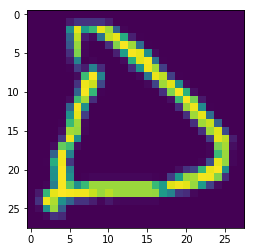

training set name:  train_D_48176.png
training set label:  R
IF measure:  0.000295730776951
train_D_48176.png


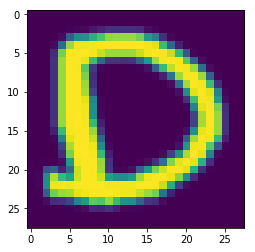

training set name:  train_D_12390.png
training set label:  K
IF measure:  0.00028806891153
train_D_12390.png


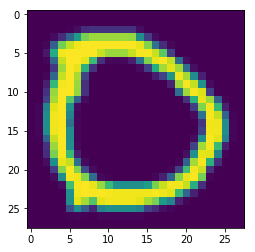

training set name:  train_D_95244.png
training set label:  R
IF measure:  0.000287091335841
train_D_95244.png


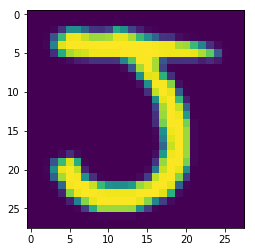

training set name:  train_J_74384.png
training set label:  5
IF measure:  0.000286750162337
train_J_74384.png


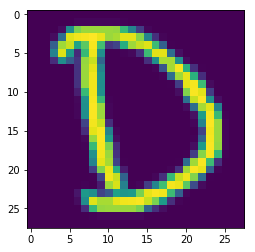

training set name:  train_D_18330.png
training set label:  K
IF measure:  0.000283671701588
train_D_18330.png

## SHOW 20-MOST ADVANTAGEOUS EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:62: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


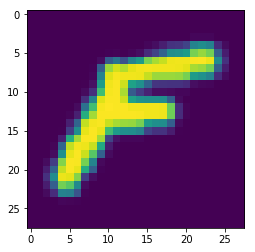

training set name:  train_F_5696.png
training set label:  f
IF measure:  -0.000458652686565
train_F_5696.png


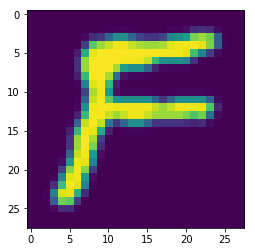

training set name:  train_f_86788.png
training set label:  f
IF measure:  -0.000395502835975
train_f_86788.png


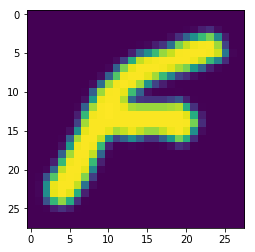

training set name:  train_f_67147.png
training set label:  f
IF measure:  -0.000381212196981
train_f_67147.png


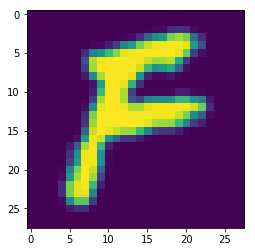

training set name:  train_f_31410.png
training set label:  f
IF measure:  -0.000367667961084
train_f_31410.png


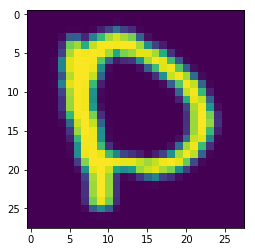

training set name:  train_D_90888.png
training set label:  D
IF measure:  -0.000345329499355
train_D_90888.png


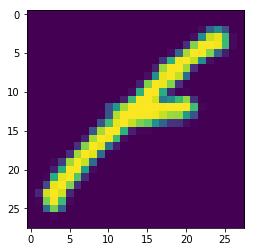

training set name:  train_f_69058.png
training set label:  f
IF measure:  -0.00033739583737
train_f_69058.png


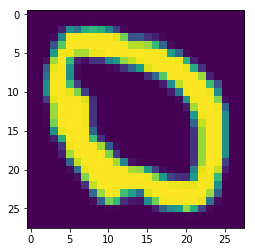

training set name:  train_D_109828.png
training set label:  D
IF measure:  -0.000310852807909
train_D_109828.png


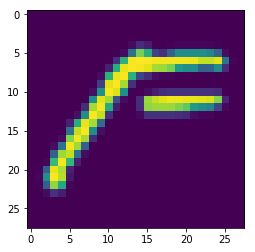

training set name:  train_f_22129.png
training set label:  f
IF measure:  -0.000309562586005
train_f_22129.png


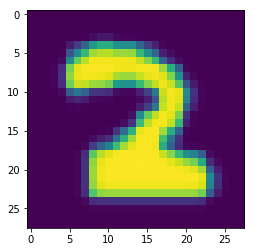

training set name:  train_Z_49610.png
training set label:  Z
IF measure:  -0.000299383759944
train_Z_49610.png


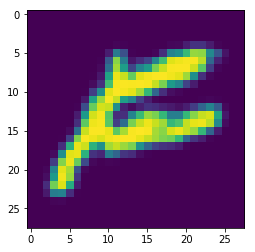

training set name:  train_f_65507.png
training set label:  f
IF measure:  -0.000298187406517
train_f_65507.png


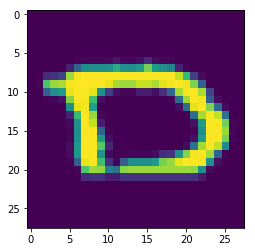

training set name:  train_D_110878.png
training set label:  D
IF measure:  -0.00029079706831
train_D_110878.png


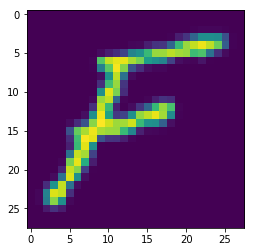

training set name:  train_f_6676.png
training set label:  f
IF measure:  -0.00028785911538
train_f_6676.png


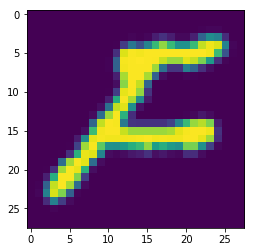

training set name:  train_f_36606.png
training set label:  f
IF measure:  -0.000284304948037
train_f_36606.png


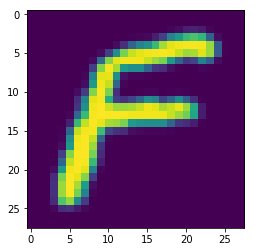

training set name:  train_f_68195.png
training set label:  f
IF measure:  -0.000283630324593
train_f_68195.png


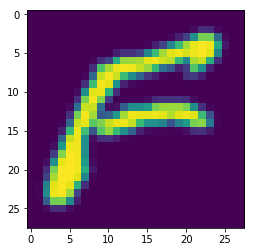

training set name:  train_f_109428.png
training set label:  f
IF measure:  -0.000281397712632
train_f_109428.png


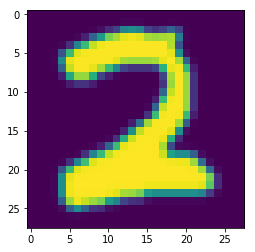

training set name:  train_Z_45072.png
training set label:  Z
IF measure:  -0.000278624754656
train_Z_45072.png


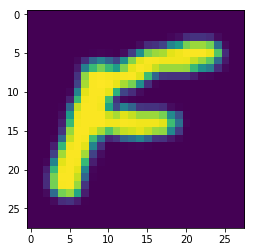

training set name:  train_f_55593.png
training set label:  f
IF measure:  -0.000277983120614
train_f_55593.png


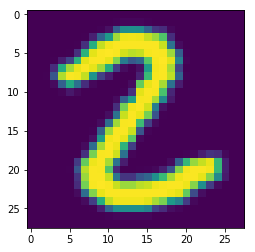

training set name:  train_Z_21556.png
training set label:  Z
IF measure:  -0.000277208549701
train_Z_21556.png


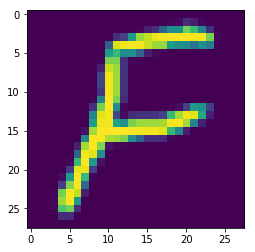

training set name:  train_f_111075.png
training set label:  f
IF measure:  -0.000276234273701
train_f_111075.png


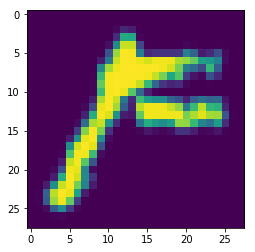

training set name:  train_f_93237.png
training set label:  f
IF measure:  -0.000275695429232
train_f_93237.png

## SHOW 20-MOST INFLUENTIAL EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


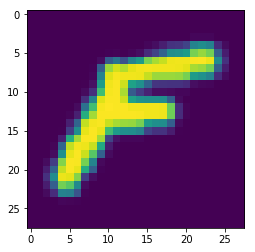

training set name:  train_F_5696.png
training set label:  f
IF measure:  -0.000458652686565


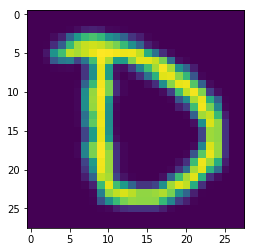

training set name:  train_D_100338.png
training set label:  R
IF measure:  0.000416131404837


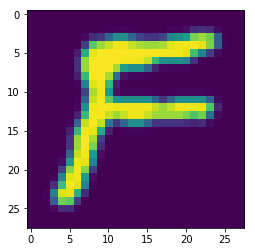

training set name:  train_f_86788.png
training set label:  f
IF measure:  -0.000395502835975


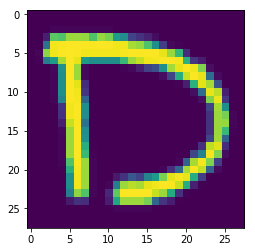

training set name:  train_D_39370.png
training set label:  O
IF measure:  0.000385118308921


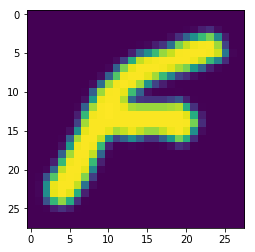

training set name:  train_f_67147.png
training set label:  f
IF measure:  -0.000381212196981


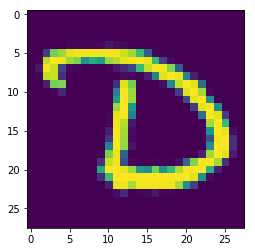

training set name:  train_D_34787.png
training set label:  q
IF measure:  0.00037124788342


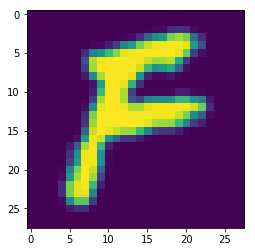

training set name:  train_f_31410.png
training set label:  f
IF measure:  -0.000367667961084


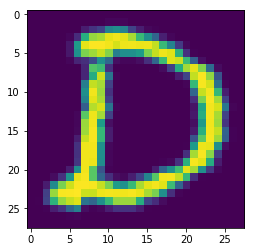

training set name:  train_D_26789.png
training set label:  2
IF measure:  0.000351685800331


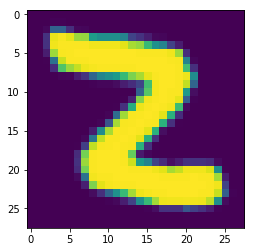

training set name:  train_Z_109846.png
training set label:  2
IF measure:  0.000347893088277


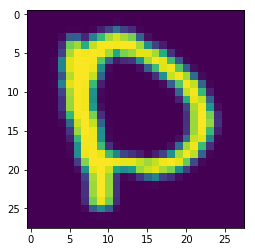

training set name:  train_D_90888.png
training set label:  D
IF measure:  -0.000345329499355


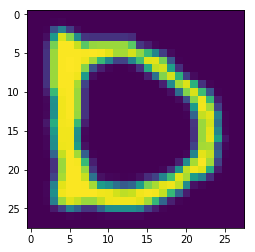

training set name:  train_D_42112.png
training set label:  H
IF measure:  0.000344805841412


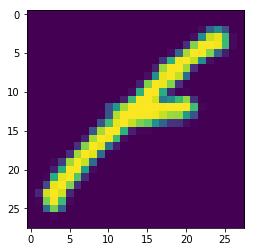

training set name:  train_f_69058.png
training set label:  f
IF measure:  -0.00033739583737


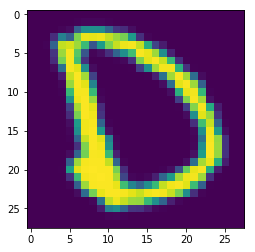

training set name:  train_D_111377.png
training set label:  F
IF measure:  0.000334698993333


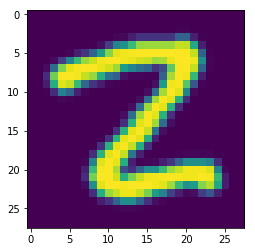

training set name:  train_2_58015.png
training set label:  2
IF measure:  0.000329562344177


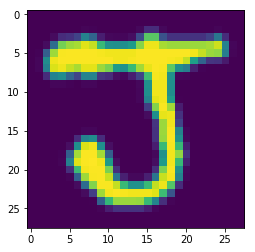

training set name:  train_J_18134.png
training set label:  5
IF measure:  0.000329065566585


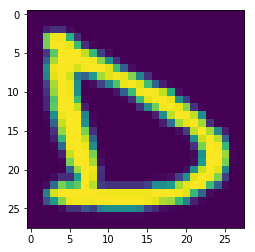

training set name:  train_D_60860.png
training set label:  K
IF measure:  0.000316710204015


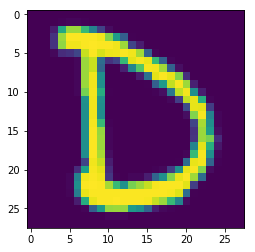

training set name:  train_D_112561.png
training set label:  B
IF measure:  0.000316290320302


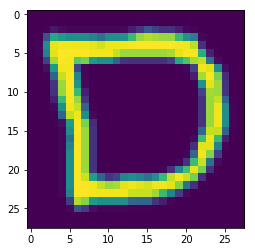

training set name:  train_D_49247.png
training set label:  F
IF measure:  0.000313501330759


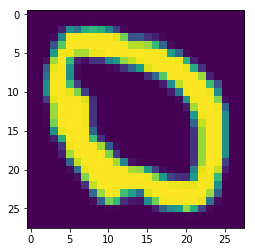

training set name:  train_D_109828.png
training set label:  D
IF measure:  -0.000310852807909


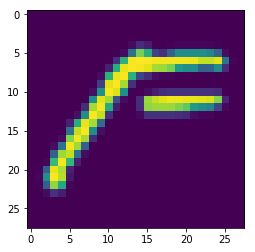

training set name:  train_f_22129.png
training set label:  f
IF measure:  -0.000309562586005

## SHOW 20-MOST NEGLIGIBLE EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:105: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


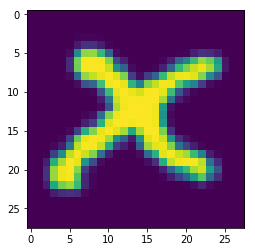

training set name:  train_X_53694.png
training set label:  X
IF measure:  2.59318285779e-10


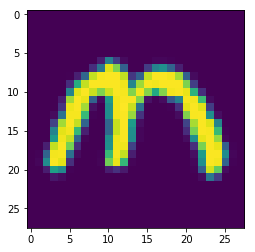

training set name:  train_M_69400.png
training set label:  M
IF measure:  -5.41934330552e-10


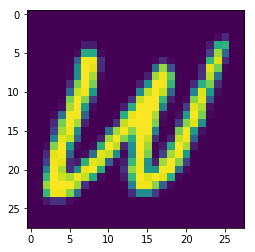

training set name:  train_W_70716.png
training set label:  W
IF measure:  -5.73586550888e-10


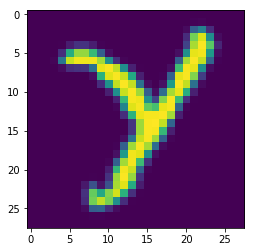

training set name:  train_Y_63192.png
training set label:  Y
IF measure:  -1.25899336872e-09


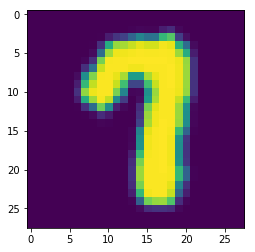

training set name:  train_7_38357.png
training set label:  7
IF measure:  -1.26025897581e-09


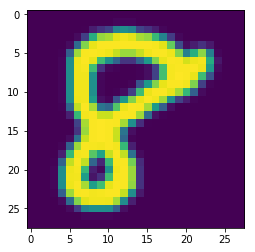

training set name:  train_8_70121.png
training set label:  8
IF measure:  1.51206601001e-09


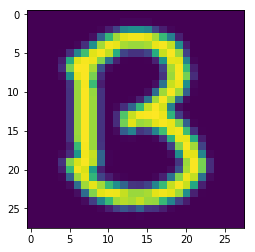

training set name:  train_B_80725.png
training set label:  B
IF measure:  1.68999856036e-09


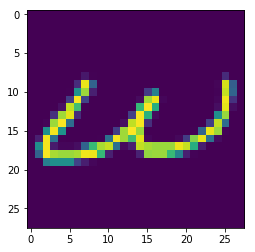

training set name:  train_W_25448.png
training set label:  0
IF measure:  -2.10178103268e-09


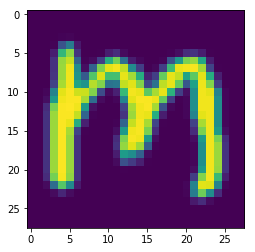

training set name:  train_M_99270.png
training set label:  M
IF measure:  2.16344304423e-09


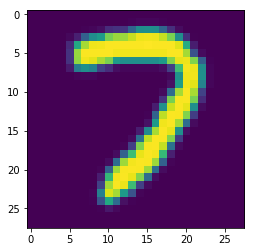

training set name:  train_7_39445.png
training set label:  7
IF measure:  2.16986749138e-09


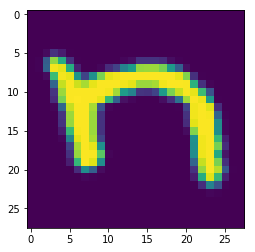

training set name:  train_n_95525.png
training set label:  n
IF measure:  -2.27158534039e-09


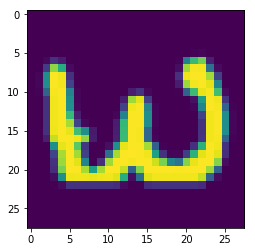

training set name:  train_W_108759.png
training set label:  W
IF measure:  -2.83771615038e-09


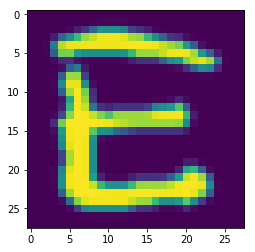

training set name:  train_E_73805.png
training set label:  E
IF measure:  -3.37018576906e-09


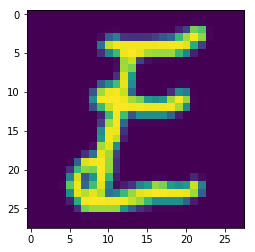

training set name:  train_E_80803.png
training set label:  E
IF measure:  3.53222854924e-09


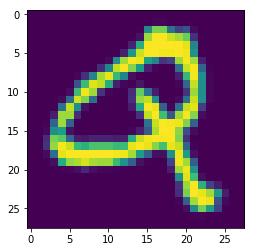

training set name:  train_Q_32990.png
training set label:  Q
IF measure:  3.66834116989e-09


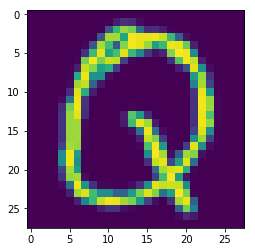

training set name:  train_Q_99812.png
training set label:  Z
IF measure:  -3.87532406881e-09


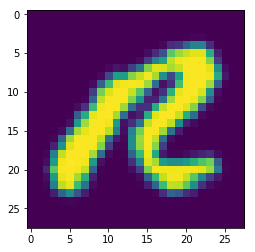

training set name:  train_R_73938.png
training set label:  R
IF measure:  4.23701598963e-09


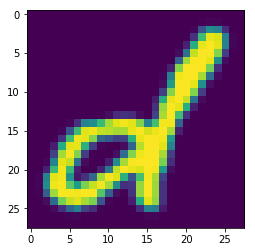

training set name:  train_d_91425.png
training set label:  d
IF measure:  -6.13142964932e-09


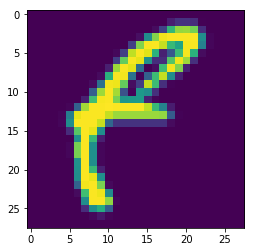

training set name:  train_F_103714.png
training set label:  O
IF measure:  -6.30328982489e-09


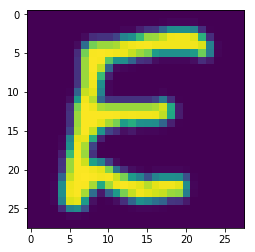

training set name:  train_E_111664.png
training set label:  E
IF measure:  -6.46681509207e-09


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:120: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


0

In [19]:
# summation over several examples and visualize samples

import glob

# file_dir = './sample/result_net_nn_if_nn/train_N_43201'
# restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network
# net.logits.restore(restore_dir)

# trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

# test_list = list(np.load(file_dir+'/test_list.npy'))
# test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

file_dir = './sample/result_net_ns_if_ns/train_N_43201'
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn' # non-noisy network
net.logits.restore(restore_dir)

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # non-noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

IF_batch = []

for dr in glob.glob('sample/result_net_ns_if_ns/*'):
    #dr_if = dr+'/if_v_logreg.npy'
    dr_if = dr+'/if_se_logreg.npy'
    if os.path.isfile(dr_if):
        print(dr_if)
        IF = np.load(dr_if)
        # normalize?
        #IF = normalize_list(IF)
        IF_batch.append(IF)

IF_batch = np.mean(IF_batch, axis=0)
visualize_topk_samples(IF_batch, train_set, num_sample=20, save_path='/tmp')

In [ ]:
# calculate IF measure w.r.t. fixed length of dataset

# WITH SEVERAL METHODOLOGIES

temp_list, _ = dataset.read_data_subset(root_dir, mode='validation1')

print('num_of_samples',len(temp_list))

# restore trainval_list, test_list
file_dir = './compare/result_net_nn_if_nn/train_e_99502'

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

dic = {ks: [] for ks in anno_dict['classes'].values()}

for tl in temp_list:
    dic[tl.split('_')[1]].append(tl)
    
sample_list = [dic[ks][0] for ks in dic.keys()]
sample_set = dataset.LazyDataset(root_dir, sample_list, anno_dict) # non-noisy dataset

    
print(len(sample_list), sample_list)

# 저장경로 변경 (compare 말고)

# network trained with non-noisy dataset, influence value with non-noisy dataset
save_dir = './sample/result_net_nn_if_nn'
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network

for idx_test in range(47):
    # Set a single test image

    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = sample_list[idx_test]
    img_test, lb_test = sample_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)
    np.save(save_path+'/temp_list', temp_list)
    np.save(save_path+'/sample_list', sample_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

#     # Calculate influence functions

#     # CG-FREEZE (1885 sec)
#     t1 = time.time()
#     ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':50})
#     IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
#     print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))
#     np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)
#     #IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')
#     visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path+'/cg-frz')
    
#     # VECTOR-FREEZE (175 sec)
#     t1 = time.time()
#     IF_v_logreg = IF_val(net, v_logreg, train_set)
#     print('V_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_logreg),min(IF_v_logreg)]))
#     np.save(save_path+'/if_v_logreg.npy', IF_v_logreg)
#     #IF_v_logreg = np.load(save_path+'/if_v_logreg.npy')
#     visualize_topk_samples(IF_v_logreg, train_set, num_sample=5, save_path=save_path+'/vec-frz')

#     # Vector-FULL (1688 sec)
#     t1 = time.time()
#     IF_v = IF_val(net, v_test, train_set)
#     print('V takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v),min(IF_v)]))
#     np.save(save_path+'/if_v.npy', IF_v)
#     #IF_v = np.load(save_path+'/if_v.npy')
#     visualize_topk_samples(IF_v, train_set, num_sample=5, save_path=save_path+'/v')
    
#     # VECTOR-FREEZE-cosine-similarity (178 sec)
#     t1 = time.time()
#     IF_v_cos = IF_val(net, v_logreg, train_set, cosine=True)
#     print('V_cos takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_cos),min(IF_v_cos)]))
#     np.save(save_path+'/if_v_cos.npy', IF_v_cos)
#     #IF_v_cos = np.load(save_path+'/if_v_cos.npy')
#     visualize_topk_samples(IF_v_cos, train_set, num_sample=5, save_path=save_path+'/vec-cos')

#     # CG-FULL (1epoch, more than 3 hours, did it stuck at line search as it happened in ncg?)
#     t1 = time.time()
#     ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_test, train_set,**{'damping':0.1, 'maxiter':100})
#     IF_cg = IF_val(net, ihvp_cg, train_set)
#     print('CG takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg),min(IF_cg)]))
#     np.save(save_path+'/if_cg.npy', IF_cg)
#     visualize_topk_samples(IF_cg, train_set, num_sample=5, save_path=save_path+'/cg')
    
#     # SE-FULL (? sec: diverge)
#     t1 = time.time()
#     ihvp_se = get_inverse_hvp_se(net, net.loss, v_test, train_set,**{'scale':1e5, 'damping':0.1, 'batch_size':50, 'recursion_depth':100})
#     IF_se = IF_val(net, ihvp_se, train_set)
#     print('SE takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se),min(IF_se)]))
#     np.save(save_path+'/if_se.npy', IF_se)
#     visualize_topk_samples(IF_se, train_set, num_sample=5, save_path=save_path+'/se')
    
    # SE-FREEZE (1065 sec)
    t1 = time.time()
    ihvp_se_logreg = get_inverse_hvp_se(net, net.loss, v_logreg, train_set,**{'scale':1e3, 'damping':0.1, 'batch_size':50, 'tolerance':0, 'recursion_depth':65})
    IF_se_logreg = IF_val(net, ihvp_se_logreg, train_set)
    print('SE_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se_logreg),min(IF_se_logreg)]))
    np.save(save_path+'/if_se_logreg.npy', IF_se_logreg)
    #IF_se_logreg = np.load(save_path+'/if_se_logreg.npy')
    visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=save_path+'/se-frz')
    

border 2
======================

In [ ]:
# compare value between two labels

IF_f = np.load('./sample/result_net_nn_if_nn/train_f_952/if_se_logreg.npy')
IF_F = np.load('./sample/result_net_nn_if_nn/train_F_41402/if_se_logreg.npy')

idx = np.argmax(IF_f)
print(idx)
img_temp, _ = train_set[idx]
show_image_from_data(img_temp)
print(IF_f[idx], IF_F[idx])

In [ ]:
# rename folder (test_list -> sample_list)
dr = './sample/result_net_nn_if_nn/'

for i in range(1,47):
    tn = test_list[i].split('.')[0]; sn = sample_list[i].split('.')[0]
    print('from {} to {}'.format(tn, sn))
    tt = list(filter(lambda x: 'reference' in x, glob.glob(dr+tn+'/*')))[0]
    print(tt.split('_')[-3])
    os.rename(dr+tn, dr+sn)

In [ ]:
# rename result images (advantageous, true_x1_noisy_x2 -> true_x2_noisy_x1)
dr = './sample/result_net_ns_if_ns/'

DOOOOOOOOOOOOOOOOOTHISSSSSSSSSSSSSSSSSSSSSSSSS

0.0
0
0.1
9024
0.2
18048
0.3
27072
0.4
36096
0.5
45120
0.6
54144
0.7
63167
0.8
72192
0.9
81216
1.0
90240
conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
measure extraction takes 2.3158886432647705
0.0
0
0.1
9024
0.2
18048
0.3
27072
0.4
36096
0.5
45120
0.6
54144
0.7
63167
0.8
72192
0.9
81216
1.0
90240
conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
measure extraction takes 2.1519360542297363
0.0
0
0.1
9024
0.2
18048
0.3
27072
0.4
36096
0.5
45120
0.6
54144
0.7
63167
0.8
72192
0.9
81216
1.0
90240
0.0
0
0.1
9024
0.2
18048
0.3
27072
0.4
36096
0.5
45120
0.6
54144
0.7
63167
0.8
72192
0.9
81216
1.0
90240
0.0
0
0.1
9024
0.2
18048
0.3
27072
0.4
36096
0.5
45120
0.6
54144
0.7
63167
0.8
72192
0.9
81216
1.0
90240
[0, 2691, 5364, 8163, 10906, 13550, 16282, 19015, 21688, 24417, 27069]
[0, 8970, 17829, 257

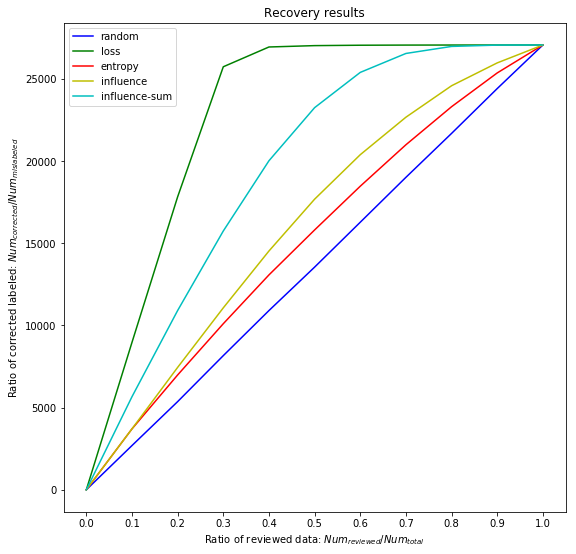

In [21]:
# RELABELING

import glob
import json
import numpy as np
import random
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import dataset28 as dataset
from models.nn import VGG as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

import time

def review(ratios, method):
    # ratios: the list of ratio which is the proportion of the data considered to be reviewed.  
    # reviewing is done by oracle. the label may or may not be changed. 
    #(i.e. if a single reviewed data has correct label, the label won't be changed, and vice versa)
    # method: the methodology of selecting data torch be reviewed. 
    # this can be 'random', 'influence', loss', 'entropy'
    t1 = time.time()

    # FIXME
    anno_dir = '/Data/emnist/balanced/original/annotation/'
    root_dir = '/Data/emnist/balanced/original/'
    #checkpt_dir = '/Data/github/interview/save/dropout_0.5_noaugmentation/model_fold_1_trainval_ratio_0.3.dnn'
    #checkpt_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn'
    checkpt_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn'

    with open(anno_dir + 'annotation1.json', 'r') as fid:
        annotation = json.load(fid)

    with open(anno_dir + 'annotation1_wp_0.3.json', 'r') as fid:
        noisy_annotation = json.load(fid)

    #image_list = list(noisy_annotation['images'].keys())
    image_list = trainval_list
    num_image = len(image_list)

    ## sorting
    if method == 'random':
        # random policy
        image_list_random = image_list[:]
        random.shuffle(image_list_random)
        review_list = image_list_random
        #review_list_random = np.random.choice(image_list, int(num_image * ratio), replace=False)
        
    elif method == 'influence':
        # influence function
        save_path = './sample/result_net_ns_if_ns/train_K_97272'
        IF_measure = np.load(save_path+'/if_se_logreg.npy')
        argsort_abs = np.argsort(np.abs(IF_measure))[::-1]
        #review_list = image_list[argsort_abs]
        review_list = [image_list[idx] for idx in argsort_abs]
#         noisy_list = [noisy_annotation['images'][fname]['class'] for fname in review_list]
#         print(review_list[0:int(num_image * ratios[0])])
#         print(noisy_list[0:int(num_image * ratios[0])])

    elif method == 'influence-sum':
        # summation of influence function among several samples
        save_path = glob.glob('./sample/result_net_ns_if_ns/*')
        IF_measures = []
        for pth in save_path:
            IF_measure = np.load(pth+'/if_se_logreg.npy')
            IF_measures.append(np.abs(IF_measure))
        IF_measures = np.mean(IF_measures, axis=0)
        argsort_abs = np.argsort(IF_measures)[::-1]
        review_list = [image_list[idx] for idx in argsort_abs]
        
    else:
        # loss
        image_set = dataset.LazyDataset(root_dir, image_list, noisy_annotation)
        model = ConvNet(image_set.__getitem__(0)[0].shape, len(annotation['classes']))
        model.logits.restore(checkpt_dir)
        evaluator = Evaluator()
        
        # extract loss, entropy
        t1_measure = time.time()
        loss, entropy = network_based_measure(model, image_set)
        t2_measure = time.time()
        print('measure extraction takes {}'.format(t2_measure-t1_measure))
        # check data // filename[0] and __getitem__[0] and dataloader first instance
        # -> all of them are same. in other word, we can use an index information
        
        if method == 'loss':
            # loss ascending policy
            idx_loss = np.argsort(loss)[::-1]
            image_list_loss = [image_list[i] for i in idx_loss]
            review_list = image_list_loss
        
        elif method == 'entropy':
            # entropy ascending policy
            idx_entropy = np.argsort(entropy)[::-1]
            image_list_entropy = [image_list[i] for i in idx_entropy]
            review_list = image_list_entropy

    ## correcting
    corrected_list = []
    for ratio in ratios:
        print(ratio)
        num_corrected = 0
        review_list_ratio = review_list[0:int(num_image * ratio)]
        print(len(review_list_ratio))
        for fname in review_list_ratio:
            correct_class = annotation['images'][fname]['class']
            noisy_class = noisy_annotation['images'][fname]['class']
            if noisy_class != correct_class:
                num_corrected += 1
        #corrected_list.append(num_corrected/int(0.3*len(image_list)))
        corrected_list.append(num_corrected)

    return corrected_list
    #return [cr/int(0.3*len(image_list)) for cr in corrected_list]

def network_based_measure(model, data_set):
    # return loss and entropy
    batch_size = 256
    num_workers = 6
    dataloader = DataLoader(data_set, batch_size, shuffle=False, num_workers=num_workers)
    
    num_classes = len(data_set.anno_dict['classes'])

    loss = np.empty(0)
    entropy = np.empty(0)
    
    # prediction in batchwise
    for X, y in dataloader:
        X = X.numpy(); y = y.numpy()
        y_pred = model.pred.eval({model.X: X})
        loss_batch = -np.log(np.sum(y_pred * y, axis=1))
        entropy_batch = -np.sum(y_pred * np.log(y_pred), axis=1)
        loss = np.concatenate((loss,loss_batch), axis=0)
        entropy = np.concatenate((entropy, entropy_batch))

    return loss, entropy

# main code

#x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#x = [0.001]
#x = [0.1, 0.5, 0.9]
x = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rnd = review(x, 'random')
ls = review(x, 'loss')
etp = review(x, 'entropy')
inf1 = review(x, 'influence')
inf2 = review(x, 'influence-sum')
# vector
# vector frz
# vector cos

print(rnd)
print(ls)
print(etp)
print(inf1)
print(inf2)

# draw a graph
fig, ax = plt.subplots(1,1, figsize=(9,9))
_ = ax.plot(x, rnd, color='b', label='random')
_ = ax.plot(x, ls, color='g', label='loss')
_ = ax.plot(x, etp, color='r', label='entropy') 
_ = ax.plot(x, inf1, color='y', label='influence') 
_ = ax.plot(x, inf2, color='c', label='influence-sum') 
_ = ax.set_title('Recovery results')
_ = ax.set_ylabel('Ratio of corrected labeled: $Num_{corrected}/Num_{mislabeled}$')
_ = ax.set_xlabel('Ratio of reviewed data: $Num_{reviewed}/Num_{total}$')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig('./images/recovery_results.png', bbox_inches='tight')
plt.show()

# wasted!!

In [ ]:
# DO THIS FOR SEVERAL EXAMPLES

# FIXME
# # network trained with noisy dataset, influence value with noisy dataset
# train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset
# save_dir = './result_net_ns_if_ns' 
# restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.3.dnn'

# network trained with non-noisy dataset, influence value with non-noisy dataset
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset
save_dir = './result_net_nn_if_nn'
restore_dir = '/Data/checkpts/emnist/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network

for idx_test in range(13, 14):
    # Set a single test image

    # # Re-sample a test instance
    # test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=100)
    # test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)
    
    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = test_list[idx_test]
    img_test, lb_test = test_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

    # Calculate influence functions

    # the solution which is converged properly can be found within 30 iterations, otherwise does not converge
    t1 = time.time()
    ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':30})
    IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
    print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))

    np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)

    # otherwise, load
    IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')

    # t1 = time.time()
    # ihvp_ncg_logreg = get_inverse_hvp_ncg(net, net.loss, v_logreg, train_set,**{'damping':0.1, 'maxiter':3})
    # IF_ncg_logreg = IF_val(net, ihvp_ncg_logreg, train_set)
    # print('NCG_logreg takes {} sec, and its value {}'.format(time.time()-t1, IF_ncg_logreg))
   
    visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path)

# tsne
tsne.py 참고

# Retraining
bootstrapping 참고

그리고 SE도 돌려볼 것.
그리고 여러 z_test의 if에 대해서 summation을 한 후 sorting 보기
(그래서 전체적으로 성능을 나쁘게 하는 녀석이 있는지 찾기)

In [ ]:
[trainval_list]
